# Imports

- [Imports](#Imports)
- [Definition](#Definition)
- [Functions](#Functions)
- [DF22](#DF22)
- [DF32](#DF32)
- [DF35](#DF35)
- [DF22&DF32](#DF22&DF32)
- [Outliers?](#Outliers)
- [Predictions of fetal weight](#Predictions-of-fetal-weight)
- [Predict-Wk32-fetal-weight-using-Wk22-data](#Predict-Wk32-fetal-weight-using-Wk22-data)
- [Predict-Wk35-fetal-weight-using-Wk22-data](#Predict-Wk35-fetal-weight-using-Wk22-data)
- [Predict-Wk35-fetal-weight-using-Wk22+WK32-data](#Predict-Wk35-fetal-weight-using-Wk22+WK32-data)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#knn imputer
from sklearn.neighbors import KNeighborsRegressor

#feature filtering/processing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#outliers
from sklearn.ensemble import IsolationForest

#plot tree
from sklearn.tree import plot_tree

#sns configuration
sns.set(style="ticks", color_codes=True)

#investigate data
pd.set_option('display.max_columns', None)

#dictionary
import collections

#display dataframe
from IPython.display import display

#hyperparameters tuning
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.regression.linear_model as smrlm
import statsmodels.api as sm
from scipy.stats import randint

# Definition

In [5]:
#meaning of excel
df_definition_22 = pd.read_excel('antenatal_dictionary v2.xlsx', sheet_name='wk22')
df_definition_32 = pd.read_excel('antenatal_dictionary v2.xlsx', sheet_name='wk32')
df_definition_35 = pd.read_excel('antenatal_dictionary v2.xlsx', sheet_name='wk35')

#vocab
'''
Gestational age -common term used during pregnancy to describe how far along the pregnancy is in week(s)
                -for example, week 32
                -The gestational age chart is used to determine the biometric measurements and determine if 
                 the foetal growth is normal.
                 
LBW (Low Birth Weight)  -Baby was born premature
                        -medical classification for a baby who weighs less than 2500 grams

'''
pass


# Helper Functions

In [8]:
from utils import *
from gan_utils import *

Instructions for updating:
non-resource variables are not supported in the long term


# GAN

In [7]:
gan_util = GanUtil()

NameError: name 'GanUtil' is not defined

In [5]:
##GAN IMPUTER
'''
GAIN function.
Date: 2020/02/28
Reference: J. Yoon, J. Jordon, M. van der Schaar, "GAIN: Missing Data 
           Imputation using Generative Adversarial Nets," ICML, 2018.
Paper Link: http://proceedings.mlr.press/v80/yoon18a/yoon18a.pdf
Contact: jsyoon0823@gmail.com
'''

# Necessary packages
#import tensorflow as tf
##IF USING TF 2 use following import to still use TF < 2.0 Functionalities
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tqdm import tqdm

def gain (data_x, gain_parameters):
    '''Impute missing values in data_x

    Args:
    - data_x: original data with missing values
    - gain_parameters: GAIN network parameters:
      - batch_size: Batch size
      - hint_rate: Hint rate
      - alpha: Hyperparameter
      - iterations: Iterations

    Returns:
    - imputed_data: imputed data
    '''
    # Define mask matrix
    data_m = 1-np.isnan(data_x)

    # System parameters
    batch_size = gain_parameters['batch_size']
    hint_rate = gain_parameters['hint_rate']
    alpha = gain_parameters['alpha']
    iterations = gain_parameters['iterations']

    # Other parameters
    no, dim = data_x.shape

    # Hidden state dimensions
    h_dim = int(dim)

    # Normalization
    norm_data,norm_parameters = gan_util.normalization(data_x)
    norm_data_x = np.nan_to_num(norm_data, 0)

    ## GAIN architecture   
    # Input placeholders
    # Data vector
    X = tf.placeholder(tf.float32, shape = [None, dim])
    # Mask vector 
    M = tf.placeholder(tf.float32, shape = [None, dim])
    # Hint vector
    H = tf.placeholder(tf.float32, shape = [None, dim])

    # Discriminator variables
    D_W1 = tf.Variable(gan_util.xavier_init([dim*2, h_dim])) # Data + Hint as inputs
    D_b1 = tf.Variable(tf.zeros(shape = [h_dim]))

    D_W2 = tf.Variable(gan_util.xavier_init([h_dim, h_dim]))
    D_b2 = tf.Variable(tf.zeros(shape = [h_dim]))

    D_W3 = tf.Variable(gan_util.xavier_init([h_dim, dim]))
    D_b3 = tf.Variable(tf.zeros(shape = [dim]))  # Multi-variate outputs

    theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

    #Generator variables
    # Data + Mask as inputs (Random noise is in missing components)
    G_W1 = tf.Variable(gan_util.xavier_init([dim*2, h_dim]))  
    G_b1 = tf.Variable(tf.zeros(shape = [h_dim]))

    G_W2 = tf.Variable(gan_util.xavier_init([h_dim, h_dim]))
    G_b2 = tf.Variable(tf.zeros(shape = [h_dim]))

    G_W3 = tf.Variable(gan_util.xavier_init([h_dim, dim]))
    G_b3 = tf.Variable(tf.zeros(shape = [dim]))

    theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

    ## GAIN functions
    # Generator
    def generator(x,m):
        # Concatenate Mask and Data
        inputs = tf.concat(values = [x, m], axis = 1) 
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
        # MinMax normalized output
        G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) 
        return G_prob

    # Discriminator
    def discriminator(x, h):
        # Concatenate Data and Hint
        inputs = tf.concat(values = [x, h], axis = 1) 
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
        D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)
        return D_prob

    ## GAIN structure
    # Generator
    G_sample = generator(X, M)

    # Combine with observed data
    Hat_X = X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_X, H)

    ## GAIN loss
    D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) \
                                + (1-M) * tf.log(1. - D_prob + 1e-8)) 

    G_loss_temp = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))

    MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)

    D_loss = D_loss_temp
    G_loss = G_loss_temp + alpha * MSE_loss 

    ## GAIN solver
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

    ## Iterations
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # Start Iterations
    for it in tqdm(range(iterations)):    
        # Sample batch
        batch_idx = gan_util.sample_batch_index(no, batch_size)
        X_mb = norm_data_x[batch_idx, :]  
        M_mb = data_m[batch_idx, :]  
        # Sample random vectors  
        Z_mb = gan_util.uniform_sampler(0, 0.01, batch_size, dim) 
        # Sample hint vectors
        H_mb_temp = gan_util.binary_sampler(hint_rate, batch_size, dim)
        H_mb = M_mb * H_mb_temp

        # Combine random vectors with observed vectors
        X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 

        _, D_loss_curr = sess.run([D_solver, D_loss_temp], 
                                  feed_dict = {M: M_mb, X: X_mb, H: H_mb})
        _, G_loss_curr, MSE_loss_curr = \
        sess.run([G_solver, G_loss_temp, MSE_loss],
                 feed_dict = {X: X_mb, M: M_mb, H: H_mb})

    ## Return imputed data      
    Z_mb = gan_util.uniform_sampler(0, 0.01, no, dim) 
    M_mb = data_m
    X_mb = norm_data_x          
    X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 

    imputed_data = sess.run([G_sample], feed_dict = {X: X_mb, M: M_mb})[0]

    imputed_data = data_m * norm_data_x + (1-data_m) * imputed_data

    # Renormalization
    imputed_data = gan_util.renormalization(imputed_data, norm_parameters)  

    # Rounding
    imputed_data = gan_util.rounding(imputed_data, data_x)  

    return imputed_data

# DF22

In [7]:
#Read from excel
df_22 = pd.read_excel('antenatal_info.xlsx', sheet_name='Wk 22')

#replace GA Scan (wk) and GA Scan(Day) and GA (wk) to total GA day
df_22['GA(Day)'] = (df_22['GA SCAN (WK)'] * 7) + df_22['GA SCAN (DAY)']

#drop unnecessary columns
df_22.drop(['Doc Remark', 'GA (wk)', 'Patient Identifier', 'experiment_no', 'experiment_personnel', 'Refno', 'GA SCAN (WK)', 'GA SCAN (DAY)'], axis=1, inplace=True)
#drop future data/non-existed data in wk22
df_22.drop(['BW (centile)', 'labels (0-healthy, 1-BW between 3rd-10th centile, 2-BW>10th centile)',
           'GA at birth (days)', 'BW (g)', 'All 3 Scans? (0=N, 1=Y) '], axis=1, inplace=True)

#rename column for readability
df_22.rename(columns={"BABY GENDER": "Baby Gender"}, inplace=True)
df_22.rename(columns={"Ethnics (chinese =1, malay = 2, indian =3, other =4)": "Ethnics"}, inplace=True)
df_22.rename(columns={"Doc Remark  (0=Normal, 1=IUGR)": "IUGR"}, inplace=True)
df_22.rename(columns={"IUGR CASES (0=No Detection, 1=Detection, * =Detection only in Additional Scan) ": "IUGR Cases*"}, inplace=True)
df_22.rename(columns={"SGA CASES (0=No Detection, 1=Detection, * =Detection only in Additional Scan) ": "SGA Cases*"}, inplace=True)
df_22.rename(columns={"Normal CASES (0=No Detection, 1=Detection, * =Detection only in Additional Scan) ": "Normal Cases*"}, inplace=True)

#drop the NA
'''
IUGR Cases*: 250
SGA Cases*: 242
Normal Cases*: 202
'''
df_22.drop(['IUGR Cases*', 'SGA Cases*', 'Normal Cases*'], axis=1, inplace=True)

#make the info standardize
df_22['Baby Gender'] = df_22['Baby Gender'].replace('Female', 'F')
df_22['Baby Gender'] = df_22['Baby Gender'].replace('Male', 'M')

#modify dtypes
df_22['Baby Gender'] = df_22['Baby Gender'].astype('category')
df_22['Ethnics'] = df_22['Ethnics'].astype('category')
df_22['IUGR'] = df_22['IUGR'].astype('category')

#all birth weight is not used, drop.

check_df(df_22)

#rename cols 
for col in df_22.columns:
    df_22.rename({col: col+'_22'}, axis='columns', inplace=True)

No null exist in this dataframe.


In [8]:
df_22

Baby Gender_22  Age_22 Ethnics_22  BPD_22  HC_22  Cerebellum tr_22  CM_22  \
0                M      30          1    54.1  193.9              22.9    7.3   
1                F      31          1    52.3  186.0              23.0    5.9   
2                M      26          1    49.8  186.0              21.1    5.4   
3                F      31          1    53.6  195.0              21.7    6.5   
4                M      27          4    53.6  192.1              22.7    8.1   
..             ...     ...        ...     ...    ...               ...    ...   
342              F      29          2    47.4  172.5              22.2    5.2   
343              M      31          2    50.6  188.0              23.3    6.4   
344              F      33          2    52.4  194.6              22.2    4.2   
345              M      29          3    60.7  221.1              27.1    5.3   
346              F      32          4    51.3  188.8              22.5    6.0   

     EFW_22  Nuchal fold_22  AC_22  Femur_22  Va_22  Vp_22  Hem_22  Ut RI_22  \
0       441            4.74  170.7      35.5    6.5    6.7    26.5      0.56   
1       415            4.43  162.4      36.3    6.4    6.6    23.6      0.52   
2       410            2.93  166.0      34.7    7.9    6.9    23.4      0.47   
3       417            4.05  163.8      35.2    6.7    7.2    26.3      0.50   
4       400            4.91  159.8      35.0    6.2    7.9    26.6      0.50   
..      ...             ...    ...       ...    ...    ...     ...       ...   
342     383            4.19  163.0      34.2    4.7    4.4    21.0      0.49   
343     448            5.91  163.7      38.9    5.8    5.3    26.3      0.60   
344     465            4.40  173.8      36.7    6.1    5.6    25.6      0.61   
345     648            6.66  199.1      40.5    6.9    3.6    28.8      0.55   
346     436            4.31  161.3      38.4    7.1    4.2    23.8      0.49   

     Ut PI_22 IUGR_22  GA(Day)_22  
0        0.91       0         153  
1        0.78       0         152  
2        0.70       0         152  
3        0.77       0         153  
4        0.76       0         150  
..        ...     ...         ...  
342      0.71       0         151  
343      1.08       0         153  
344      1.03       0         153  
345      0.86       0         167  
346      0.73       0         151  

[347 rows x 18 columns]

In [9]:
#log10(Fetal weight) = 1.335-0.0034*AC*FL+ 0.0316*BPD+0.0457*AC +0.1623*FL 
#all unit here is mm, convert them to cm
# df_22['Hadlock Weight'] = 10**(1.335 - 0.0034*df_22['AC_22']/10*df_22['Femur_22']/10 + 
#                                0.0316*df_22['BPD_22']/10 + 0.0457*df_22['AC_22']/10 + 
#                                0.1623*df_22['Femur_22']/10)

# DF32

In [10]:
df_32 = pd.read_excel('antenatal_info.xlsx', sheet_name='Wk 32')
#drop unnecessary columns - OFD(325/333 - 0.9759 Na), Umb PI(225/333 - 0.6756 NA)
#drop GA wk or day
df_32.drop(['Patient Identifier', 'OFD', 'PERCENTILE', 'Umb PI', 'percentile', 'GA SCAN (DAY)', 'GA SCAN (WK)', 'Doc Remark'], axis=1, inplace=True)

#get rid of the 14 null rows
df_32 = df_32[~df_32['HC'].isnull()] 

#rename column for readability
df_32.rename(columns={"PERCENTILE": "OFD_P", "PERCENTILE.1": "HC_P"}, inplace=True)
df_32.rename(columns={"PERCENTILE.2": "AC_P", 'PERCENTILE.3': 'Femur_P'}, inplace=True)
df_32.rename(columns={"PERCENTILE.4": "EFW_P", "PERCENTILE.5": "HC/AC_P"}, inplace=True)
df_32.rename(columns={"PERCENTILE.6": "Umb_S/D_P", 'percentile.1':'Umb_RI_P'}, inplace=True)
df_32.rename(columns={'Percentile': 'Right_Mid_Cerebral_Artery_RI_P'}, inplace=True)
df_32.rename(columns={'Percentile.1':'Right_Mid_Cerebral_Artery_PI_P'}, inplace=True)
df_32.rename(columns={"Doc Remark  (0=Normal, 1=IUGR)": "IUGR"}, inplace=True)


#GA (wk) here is actually GA (Day)
df_32.rename(columns={'GA (wk)':'GA(Day)'}, inplace=True)

#convert all missing value to None
df_32['HC/AC_P'].replace('N', None, inplace=True)

#convert them to correct dtypes
df_32['HC/AC_P'] = df_32['HC/AC_P'].astype('float64')
df_32['IUGR'] = df_32['IUGR'].astype('category')

#dropping again 
'''
Right Mid Cerebral Artery RI: 151 NA
Right_Mid_Cerebral_Artery_RI_P: 151 NA
Right Mid Cerebral Artery PI: 151 NA
Right_Mid_Cerebral_Artery_PI_P: 151 NA
'''
df_32.drop(['Right Mid Cerebral Artery RI', 'Right_Mid_Cerebral_Artery_RI_P', 'Right Mid Cerebral Artery PI', 'Right_Mid_Cerebral_Artery_PI_P'], axis=1, inplace=True)

#error in the data column ['Umb RI'], I guess 44=0.44 (index 179),  65=0.65 (index 302)
'''
array([ 0.53,  0.51,  0.67,  0.64,  0.57,  0.55,  0.72,  0.68,  0.56,
        0.66,  0.6 ,  0.49,  0.62,  0.69,  0.65,  0.48,  0.63,  0.58,
        0.52,  0.61,  0.54,  0.59,  0.7 ,  0.71,  0.5 , 44.  ,  0.75,
        0.77,  0.81,  0.73, 65.  ])
'''

df_32.loc[179, 'Umb RI'] = 0.44
df_32.loc[302, 'Umb RI'] = 0.65

#convert the first hc/ga to none since it is 0
df_32.loc[0, 'HC_GA'] = None

#drop the outliers
df_32 = df_32[df_32['EFW'] > 100]

#Remove percentile
df_32 = df_32[df_32.columns.drop(list(df_32.filter(regex='_P')))]

pass

## Overall data needed to be filled in df_32

### columns needed to fill in missing data:

AFI:64, (float64) [  4,   5,   9,  11,  17,  23,  26,  31,  37,  45,  46,  49,  53, 57,  59,  61,  84,  87,  90,  93,  95,  96, 100, 106, 108, 111,112, 119, 120, 125, 145, 152, 181, 184, 189, 190, 192, 193, 198, 211, 212, 216, 221, 226, 229, 238, 245, 251, 253, 256, 261, 270, 276, 290, 307, 311, 317, 318, 319, 323, 328, 330, 336, 341]

Umb RI:2, (float64)[54, 256] - Fill

Umb S/D:2, (float64) [54, 256] - Fill

HC_GA: 1, (float64), [0] - fill


In [11]:
#Use GAN to impute all
'''
AFI:64, (float64) [ 4, 5, 9, 11, 17, 23, 26, 31, 37, 45, 46, 49, 53, 57, 59, 61, 84, 87, 90, 93, 95, 96, 
                    100, 106, 108, 111,112, 119, 120, 125, 145, 152, 181, 184, 189, 190, 192, 193, 198, 
                    211, 212, 216, 221, 226, 229, 238, 245, 251, 253, 256, 261, 270, 276, 290, 307, 311, 
                    317, 318, 319, 323, 328, 330, 336, 341]
Umb RI:2, (float64)[54, 256] - Fill
Umb S/D:2, (float64) [54, 256] - Fill
HC_GA: 1, (float64), [0] - fill
'''

#all i use default first:
#batch_size =128, hint_rate=0.9, alpha=100, iter=10000
BATCH_SIZE=128
HINT_RATE=0.9
ALPHA=100
ITERATION=10000
gain_parameters = {'batch_size': BATCH_SIZE,
                    'hint_rate': HINT_RATE,
                    'alpha': ALPHA,
                    'iterations': ITERATION}

# Impute missing data
df_32_numpy = df_32.to_numpy().astype('float')
imputed_data_x = gain(df_32_numpy, gain_parameters)

df_32_new = pd.DataFrame(imputed_data_x, columns = df_32.columns)

#Keep track of patient_no
df_32.reset_index(inplace=True) #reset the index

#replace imputed columns
df_32['AFI'] = df_32_new['AFI']
df_32['Umb RI'] = df_32_new['Umb RI']
df_32['Umb S/D'] = df_32_new['Umb S/D']
df_32['HC_GA'] = df_32_new['HC_GA']

#convert back the index
df_32.set_index('index', inplace=True)
df_32.index.name = None

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.22it/s]


In [12]:
check_df(df_32)

No null exist in this dataframe.


In [13]:
# #idea: Handle HC_GA first as gradient boost do well on it

# #1. exclude row 0, 54,256, exclude columns AFI, train and fill in the missing
# df_32_X = df_32.drop(index=[0, 54, 256])
# df_32_X.drop('AFI', axis=1, inplace=True)

# #columns needed to fill in missing data: 
# '''
# V1
# Umb RI:2, (float64)[54, 256] -pretty hard
# Umb S/D:2, (float64) [54, 256] -pretty hard
# HC_GA: 1, (float64), [0] - no problem
# '''

# #second version of columns
# col = 'HC_GA'

# #Linear reg, random forest reg, Adaboostreg, Gradient boost reg
# models = [LinearRegression(normalize=True), RandomForestRegressor(n_estimators = 100, random_state = 42),
#          AdaBoostRegressor(random_state=42, n_estimators=100), GradientBoostingRegressor(n_estimators = 100, random_state = 42), 
#          make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)), KNeighborsRegressor(n_neighbors=5)]

# #cross_val_score and cross_validate are the same things
# # cross_validate_models(models, df_32_X, col)

In [14]:
# # Filling HC_GA data with gradient boosting regressor (best)

# df_32_master = df_32.copy() #for final result
# to_update_dict = {
#     'HC_GA': [0],
# }

# for col, index_list in to_update_dict.items():
#     #to train
#     X = df_32_X.drop(col, axis=1)
#     y = df_32_X[col]
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
#     #create object - gradient boost -best
#     regressor = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
#     #fit the regressor with x and y data 
#     regressor.fit(X_train, y_train)
    
#     #To predict
#     for i in index_list:
#         Xreal_test = pd.DataFrame(df_32_master.drop([col, 'AFI'], axis=1).loc[i]).T
#         df_32_master.loc[i, col] = regressor.predict(Xreal_test) #update df_32

In [15]:
# Impute AFI, Umb_RI, Umb_S/D
# df_32 = impute(df_32_master)

In [16]:
#check the null
# df_32_master.loc[[81,156, 236]]
check_df(df_32, show_all=False, show_unique=True)

No null exist in this dataframe.


In [17]:
#rename cols 
for col in df_32.columns:
    df_32.rename({col: col+'_32'}, axis='columns', inplace=True)

In [18]:
df_32

HC_32  AC_32  FEMUR_32  EFW_32  HC/AC_32  FL/HC_32  FL/AC_32     AFI_32  \
0    296.4  279.4      60.5  1870.0      1.06      0.20      0.22  12.100000   
1    300.2  277.0      61.6  1894.0      1.08      0.21      0.22  14.100000   
2    289.9  274.3      57.6  1709.0      1.06      0.20      0.21  13.100000   
3    288.0  265.8      59.7  1676.0      1.08      0.21      0.22  11.100000   
4    307.4  275.2      60.7  1883.0      1.12      0.20      0.22  12.821708   
..     ...    ...       ...     ...       ...       ...       ...        ...   
341  283.2  273.5      62.4  1805.0      1.04      0.22      0.23  12.405553   
342  274.0  248.4      58.0  1425.0      1.10      0.21      0.23  11.800000   
343  302.1  269.6      61.7  1831.0      1.12      0.20      0.23  11.600000   
345  291.3  273.0      59.6  1757.0      1.07      0.20      0.22  15.300000   
346  294.4  277.3      61.5  1868.0      1.06      0.21      0.22   7.600000   

     Umb RI_32  Umb S/D_32  GA(Day)_32 IUGR_32  HC_GA_32  
0         0.53        2.14       227.0     0.0  1.272032  
1         0.51        2.04       225.0     0.0  1.334222  
2         0.67        3.06       228.0     0.0  1.271491  
3         0.64        2.76       215.0     0.0  1.339535  
4         0.53        2.12       227.0     0.0  1.354185  
..         ...         ...         ...     ...       ...  
341       0.72        3.60       226.0     0.0  1.253097  
342       0.63        2.67       217.0     0.0  1.262673  
343       0.59        2.45       230.0     0.0  1.313478  
345       0.56        2.26       224.0     0.0  1.300446  
346       0.62        2.61       228.0     0.0  1.291228  

[332 rows x 13 columns]

(array([ 4., 24., 48., 89., 92., 53., 15.,  3.,  2.,  2.]),
 array([1018. , 1195.2, 1372.4, 1549.6, 1726.8, 1904. , 2081.2, 2258.4,
        2435.6, 2612.8, 2790. ]),
 <a list of 10 Patch objects>)

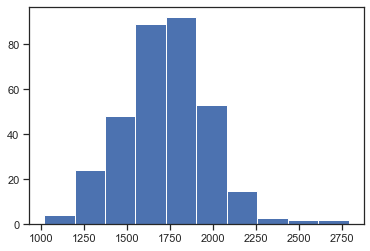

In [19]:
plt.hist(df_32['EFW_32'])

# DF35

## Overall data needed to be filled in df_35

### columns needed to fill in missing data:
- AFI: null=50, dtypes=float64
- Right Mid Cerebral Artery RI: null=32, dtypes=float64
- Right Mid Cerebral Artery PI: null=32, dtypes=float64

In [20]:
df_35 = pd.read_excel('antenatal_info.xlsx', sheet_name='Wk 35')

#get rid of empty data
df_35 = df_35[df_35['35th Scan done?'] == 'Yes'] #get yes only
## these [145, 238, 243] indexes have mostly blank, remove
df_35.drop(index=[145, 238, 243], inplace=True)

#GA (wk) = GA(Day)
df_35['GA(Day)'] = df_35['GA (wk) =']

#145/224=0.647 ('Umb PI', 'percentile')
#>90% 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32'
#remove cols ['Umb PI', 'percentile', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']
df_35.drop(['Umb PI', 'percentile', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'GA SCAN (DAY)', 'GA SCAN (WK)', 'GA (wk) ='], axis=1, inplace=True)

#drop unnecessary cols
df_35.drop(['Patient Identifier', '35th Scan done?', 'Doc Remark'], axis=1, inplace=True)

#rename column for readability
df_35.rename(columns={"PERCENTILE": "HC_P", "PERCENTILE.1": "AC_P"}, inplace=True)
df_35.rename(columns={"PERCENTILE.2": "FEMUR_P", 'PERCENTILE.3': 'EFW_P'}, inplace=True)
df_35.rename(columns={"PERCENTILE.4": "HC/AC_P"}, inplace=True)
df_35.rename(columns={'percentile.1':'Umb_RI_P'}, inplace=True)
df_35.rename(columns={'PERCENTILE.5': 'Umb_S/D_P'}, inplace=True)
df_35.rename(columns={'Percentile.1':'Right_Mid_Cerebral_Artery_PI_P'}, inplace=True)
df_35.rename(columns={"Doc Remark  (0=Normal, 1=IUGR)": "IUGR"}, inplace=True)
df_35.rename(columns={"Percentile": "Right_Mid_Cerebral_Artery_RI_P"}, inplace=True)


#drop all percentile
df_35 = df_35[df_35.columns.drop(list(df_35.filter(regex='_P')))]

#df_35['AC'] index 236 from 2911 to 291.1
df_35.loc[236, 'AC'] = 291.1

#convert to correct dtypes
df_35['AC'] = df_35['AC'].astype('float')
df_35['IUGR'] = df_35['IUGR'].astype('category')

#remove index 336, 
df_35.drop(336, axis=0, inplace=True)

In [21]:
df_35.dtypes

HC                               float64
AC                               float64
FEMUR                            float64
EFW                              float64
HC/AC                            float64
FL/HC                            float64
FL/AC                            float64
AFI                              float64
Umb RI                           float64
Umb S/D                          float64
Right Mid Cerebral Artery RI     float64
Right Mid Cerebral Artery PI     float64
IUGR                            category
GA(Day)                            int64
dtype: object

In [22]:
check_df(df_35)

AFI: null=50, dtypes=float64
Right Mid Cerebral Artery RI: null=32, dtypes=float64
Right Mid Cerebral Artery PI: null=32, dtypes=float64


In [23]:
df_35

HC     AC  FEMUR     EFW  HC/AC  FL/HC  FL/AC   AFI  Umb RI  Umb S/D  \
2    310.7  298.8   63.9  2261.0   1.04   0.21   0.21  15.3    0.58     2.39   
5    340.3  360.4   71.1  3603.0   0.94   0.21   0.20   NaN    0.44     1.80   
7    306.2  266.2   59.0  1737.0   1.15   0.19   0.22  10.1    0.71     3.39   
9    305.1  282.6   59.7  1922.0   1.08   0.20   0.21   NaN    0.57     2.31   
10   315.0  283.1   66.3  2181.0   1.11   0.21   0.23   NaN    0.63     2.72   
..     ...    ...    ...     ...    ...    ...    ...   ...     ...      ...   
339  301.0  272.2   62.6  1879.0   1.11   0.21   0.23  17.5    0.58     2.35   
341  323.1  303.3   67.3  2501.0   1.07   0.21   0.22  11.4    0.50     2.00   
342  298.5  278.9   63.6  1966.0   1.07   0.21   0.23  10.3    0.56     2.29   
345  317.6  286.4   64.1  2161.0   1.11   0.20   0.22  12.5    0.59     2.44   
346  303.9  288.9   71.2  2349.0   1.05   0.23   0.25   5.6    0.64     2.77   

     Right Mid Cerebral Artery RI  Right Mid Cerebral Artery PI IUGR  GA(Day)  
2                            0.83                          1.87  0.0      247  
5                             NaN                           NaN  0.0      252  
7                            0.92                          2.65  1.0      239  
9                            0.79                          1.70  1.0      243  
10                           0.84                          1.79  0.0      239  
..                            ...                           ...  ...      ...  
339                          0.77                          1.72  1.0      245  
341                          0.75                          1.55  1.0      260  
342                          0.76                          1.51  0.0      238  
345                          0.65                          1.08  1.0      250  
346                          0.81                          1.75  0.0      254  

[223 rows x 14 columns]

In [24]:
df_35

HC     AC  FEMUR     EFW  HC/AC  FL/HC  FL/AC   AFI  Umb RI  Umb S/D  \
2    310.7  298.8   63.9  2261.0   1.04   0.21   0.21  15.3    0.58     2.39   
5    340.3  360.4   71.1  3603.0   0.94   0.21   0.20   NaN    0.44     1.80   
7    306.2  266.2   59.0  1737.0   1.15   0.19   0.22  10.1    0.71     3.39   
9    305.1  282.6   59.7  1922.0   1.08   0.20   0.21   NaN    0.57     2.31   
10   315.0  283.1   66.3  2181.0   1.11   0.21   0.23   NaN    0.63     2.72   
..     ...    ...    ...     ...    ...    ...    ...   ...     ...      ...   
339  301.0  272.2   62.6  1879.0   1.11   0.21   0.23  17.5    0.58     2.35   
341  323.1  303.3   67.3  2501.0   1.07   0.21   0.22  11.4    0.50     2.00   
342  298.5  278.9   63.6  1966.0   1.07   0.21   0.23  10.3    0.56     2.29   
345  317.6  286.4   64.1  2161.0   1.11   0.20   0.22  12.5    0.59     2.44   
346  303.9  288.9   71.2  2349.0   1.05   0.23   0.25   5.6    0.64     2.77   

     Right Mid Cerebral Artery RI  Right Mid Cerebral Artery PI IUGR  GA(Day)  
2                            0.83                          1.87  0.0      247  
5                             NaN                           NaN  0.0      252  
7                            0.92                          2.65  1.0      239  
9                            0.79                          1.70  1.0      243  
10                           0.84                          1.79  0.0      239  
..                            ...                           ...  ...      ...  
339                          0.77                          1.72  1.0      245  
341                          0.75                          1.55  1.0      260  
342                          0.76                          1.51  0.0      238  
345                          0.65                          1.08  1.0      250  
346                          0.81                          1.75  0.0      254  

[223 rows x 14 columns]

In [25]:
#Use GAN to impute all
'''
AFI: null=50, dtypes=float64
Right Mid Cerebral Artery RI: null=32, dtypes=float64
Right Mid Cerebral Artery PI: null=32, dtypes=float64
'''

#all i use default first:
#batch_size =128, hint_rate=0.9, alpha=100, iter=10000
BATCH_SIZE=128
HINT_RATE=0.9
ALPHA=100
ITERATION=10000
gain_parameters = {'batch_size': BATCH_SIZE,
                    'hint_rate': HINT_RATE,
                    'alpha': ALPHA,
                    'iterations': ITERATION}

# Impute missing data
df_35_numpy = df_35.to_numpy().astype('float')
imputed_data_x = gain(df_35_numpy, gain_parameters)

df_35_new = pd.DataFrame(imputed_data_x, columns = df_35.columns)

#Keep track of patient_no
df_35.reset_index(inplace=True) #reset the index

#replace imputed columns
df_35['AFI'] = df_35_new['AFI']
df_35['Right Mid Cerebral Artery RI'] = df_35_new['Right Mid Cerebral Artery RI']
df_35['Right Mid Cerebral Artery PI'] = df_35_new['Right Mid Cerebral Artery PI']

#convert back the index
df_35.set_index('index', inplace=True)
df_35.index.name = None

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.74it/s]


In [26]:
# #see whether my model can impute better
# models = [LinearRegression(normalize=True), RandomForestRegressor(n_estimators = 100, random_state = 42),
#          AdaBoostRegressor(random_state=42, n_estimators=100), GradientBoostingRegressor(n_estimators = 100, random_state = 42), 
#          make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)), KNeighborsRegressor(n_neighbors=5)]

# columns = ['AFI', 'Right Mid Cerebral Artery RI', 'Right Mid Cerebral Artery PI']

# #cross_val_score and cross_validate are the same things
# df_35_cross = df_35[~df_35['AFI'].isna()]
# df_35_cross = df_35_cross[~df_35_cross['Right Mid Cerebral Artery RI'].isna()]

# # for col in columns:
# #     cross_validate_models(models, df_35_cross, col)

In [27]:
# #decided to impute data
# df_35 = impute(df_35)

In [28]:
check_df(df_35)

No null exist in this dataframe.


In [29]:
#rename cols 
for col in df_35.columns:
    df_35.rename({col: col+'_35'}, axis='columns', inplace=True)

(array([ 1.,  0.,  0.,  9., 77., 89., 31.,  8.,  5.,  3.]),
 array([ 296. ,  648.2, 1000.4, 1352.6, 1704.8, 2057. , 2409.2, 2761.4,
        3113.6, 3465.8, 3818. ]),
 <a list of 10 Patch objects>)

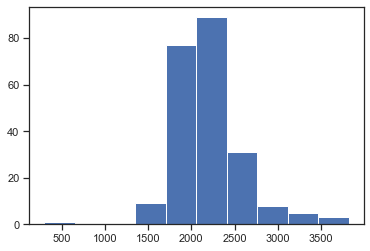

In [30]:
plt.hist(df_35['EFW_35'])

# DF22&DF32

In [31]:
df_22_32 = df_22.merge(df_32, left_index= True, right_index=True) #join based on left index and right index
df_22_32

Baby Gender_22  Age_22 Ethnics_22  BPD_22  HC_22  Cerebellum tr_22  CM_22  \
0                M      30          1    54.1  193.9              22.9    7.3   
1                F      31          1    52.3  186.0              23.0    5.9   
2                M      26          1    49.8  186.0              21.1    5.4   
3                F      31          1    53.6  195.0              21.7    6.5   
4                M      27          4    53.6  192.1              22.7    8.1   
..             ...     ...        ...     ...    ...               ...    ...   
341              F      29          4    50.2  186.1              22.6    4.1   
342              F      29          2    47.4  172.5              22.2    5.2   
343              M      31          2    50.6  188.0              23.3    6.4   
345              M      29          3    60.7  221.1              27.1    5.3   
346              F      32          4    51.3  188.8              22.5    6.0   

     EFW_22  Nuchal fold_22  AC_22  Femur_22  Va_22  Vp_22  Hem_22  Ut RI_22  \
0       441            4.74  170.7      35.5    6.5    6.7    26.5      0.56   
1       415            4.43  162.4      36.3    6.4    6.6    23.6      0.52   
2       410            2.93  166.0      34.7    7.9    6.9    23.4      0.47   
3       417            4.05  163.8      35.2    6.7    7.2    26.3      0.50   
4       400            4.91  159.8      35.0    6.2    7.9    26.6      0.50   
..      ...             ...    ...       ...    ...    ...     ...       ...   
341     405            4.78  160.5      35.9    6.6    5.9    23.4      0.52   
342     383            4.19  163.0      34.2    4.7    4.4    21.0      0.49   
343     448            5.91  163.7      38.9    5.8    5.3    26.3      0.60   
345     648            6.66  199.1      40.5    6.9    3.6    28.8      0.55   
346     436            4.31  161.3      38.4    7.1    4.2    23.8      0.49   

     Ut PI_22 IUGR_22  GA(Day)_22  HC_32  AC_32  FEMUR_32  EFW_32  HC/AC_32  \
0        0.91       0         153  296.4  279.4      60.5  1870.0      1.06   
1        0.78       0         152  300.2  277.0      61.6  1894.0      1.08   
2        0.70       0         152  289.9  274.3      57.6  1709.0      1.06   
3        0.77       0         153  288.0  265.8      59.7  1676.0      1.08   
4        0.76       0         150  307.4  275.2      60.7  1883.0      1.12   
..        ...     ...         ...    ...    ...       ...     ...       ...   
341      0.80       0         149  283.2  273.5      62.4  1805.0      1.04   
342      0.71       0         151  274.0  248.4      58.0  1425.0      1.10   
343      1.08       0         153  302.1  269.6      61.7  1831.0      1.12   
345      0.86       0         167  291.3  273.0      59.6  1757.0      1.07   
346      0.73       0         151  294.4  277.3      61.5  1868.0      1.06   

     FL/HC_32  FL/AC_32     AFI_32  Umb RI_32  Umb S/D_32  GA(Day)_32 IUGR_32  \
0        0.20      0.22  12.100000       0.53        2.14       227.0     0.0   
1        0.21      0.22  14.100000       0.51        2.04       225.0     0.0   
2        0.20      0.21  13.100000       0.67        3.06       228.0     0.0   
3        0.21      0.22  11.100000       0.64        2.76       215.0     0.0   
4        0.20      0.22  12.821708       0.53        2.12       227.0     0.0   
..        ...       ...        ...        ...         ...         ...     ...   
341      0.22      0.23  12.405553       0.72        3.60       226.0     0.0   
342      0.21      0.23  11.800000       0.63        2.67       217.0     0.0   
343      0.20      0.23  11.600000       0.59        2.45       230.0     0.0   
345      0.20      0.22  15.300000       0.56        2.26       224.0     0.0   
346      0.21      0.22   7.600000       0.62        2.61       228.0     0.0   

     HC_GA_32  
0    1.272032  
1    1.334222  
2    1.271491  
3    1.339535  
4    1.354185  
..        ...  
341  1.253097  
342  1.262673  
343 

# Outliers?

In [32]:
#from the post hoc, I found out that the outliers in wk22 to predict wk32: 
#[246,101,34,190] is outliers in training set

display(df_22.loc[[246,101,34,190], :])
display(df_32.loc[[246,101,34,190], 'EFW_32'])

#from the post hoc results
'''
No. 	GA(Day)_22 	EFW_22 	CM_22 	Va_22 	Nuchal fold_22 	predicted 	    actual 	diff     	square_error
246 	148 	431 	5.7 	8.1 	4.51        	1919.952220 	1220.0 	699.952220 	489933.110970
101 	158 	513 	6.3 	7.5 	5.43        	1844.223726 	2448.0 	603.776274 	364545.788454
34  	152 	475 	7.7 	5.4 	4.06        	1898.555952 	1318.0 	580.555952 	337045.213722
190 	157 	''496 	6.6 	6.8 	4.56        	1797.038854 	1231.0 	566.038854 	320399.984138
'''
#from the post hoc, I found out that the outliers in wk22+wk32 to predict Wk35
##drop outliers [132,44,154]

display(df_32.loc[[132,44,154], :])
display(df_35.loc[[132,44,154], 'EFW_35'])

#from the post hoc results
'''
No. 	EFW_32 	HC_GA_32 	AFI_32  	CM_22 	Ut PI_22 	Age_22 	predicted   	actual 	diff        	square_error
132 	1695.0 	1.225551 	16.000000 	3.4 	1.12    	28   	2182.102026 	296.0 	1886.102026 	3.557381e+06
44  	2018.0 	1.305333 	15.300000 	4.2 	0.56    	25  	2690.755409 	3615.0 	924.244591  	8.542281e+05
154 	1898.0 	1.379018 	13.600000 	6.7 	0.97    	28  	2650.706292 	3421.0 	770.293708  	5.933524e+05
'''
pass

Baby Gender_22  Age_22 Ethnics_22  BPD_22  HC_22  Cerebellum tr_22  CM_22  \
246              M      28          2    52.9  194.8              23.2    5.7   
101              M      32          3    57.4  209.8              23.2    6.3   
34               F      28          3    52.8  191.2              22.3    7.7   
190              F      32          1    52.7  192.5              22.4    6.6   

     EFW_22  Nuchal fold_22  AC_22  Femur_22  Va_22  Vp_22  Hem_22  Ut RI_22  \
246     431            4.51  166.2      35.8    8.1    6.1    24.1      1.21   
101     513            5.43  171.8      39.9    7.5    6.0    27.6      0.49   
34      475            4.06  176.5      37.1    5.4    5.6    24.2      0.81   
190     496            4.56  179.3      38.0    6.8    5.8    26.4      0.73   

     Ut PI_22 IUGR_22  GA(Day)_22  
246      1.21       1         148  
101      0.74       0         158  
34       1.98       1         152  
190      1.56       1         157

246    1220.0
101    2448.0
34     1318.0
190    1231.0
Name: EFW_32, dtype: float64

HC_32  AC_32  FEMUR_32  EFW_32  HC/AC_32  FL/HC_32  FL/AC_32  AFI_32  \
132  278.2  267.7      61.2  1695.0      1.04      0.22      0.23    16.0   
44   293.7  283.2      64.6  2018.0      1.04      0.22      0.23    15.3   
154  308.9  280.2      59.2  1898.0      1.10      0.19      0.21    13.6   

     Umb RI_32  Umb S/D_32  GA(Day)_32 IUGR_32  HC_GA_32  
132       0.69        3.20       227.0     0.0  1.225551  
44        0.61        2.58       225.0     0.0  1.305333  
154       0.51        2.03       224.0     0.0  1.379018

132     296.0
44     3615.0
154    3421.0
Name: EFW_35, dtype: float64

# Predictions of fetal weight

In [33]:
#Best: Log 10 (weight) = 1.335-0.0034*AC*FL+ 0.0316*BPD+0.0457*AC +0.1623*FL  --> AC = AC, FL = Femur length, BPD - Bipe diam
#Without BPD: Log 10 (weight) = 1.304+0.05281*Ac+0.1938*FL -0.004*AC*FL

# hadlock_1

## Predict Wk32 fetal weight using Wk22 data

### Testing using autoML, pycaret

In [34]:
from pycaret.regression import *

In [ ]:
df_train.columns

In [104]:
train_this = df_train[['EFW_22' ,'GA(Day)_22' ,'Baby Gender_22', \
                      'CM_22','Ut PI_22', 'Va_22', 'Nuchal fold_22', \
                      'Hem_22', 'BPD_22', 'EFW_32']]

In [106]:
exp_reg101 = setup(data = train_this, target = label_name, session_id=12) 

In [107]:
compare_models()

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [108]:
lasso = create_model('ridge')

In [109]:
tuned_lasso = tune_model(lasso)

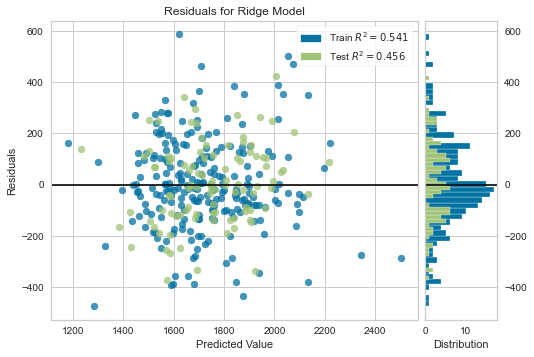

In [110]:
plot_model(tuned_lasso)

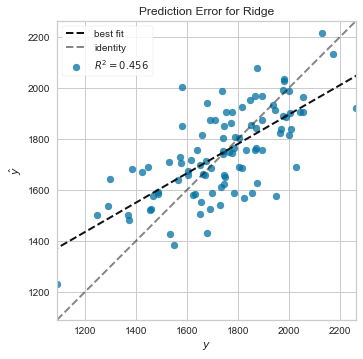

In [111]:
plot_model(tuned_lasso, plot = 'error')

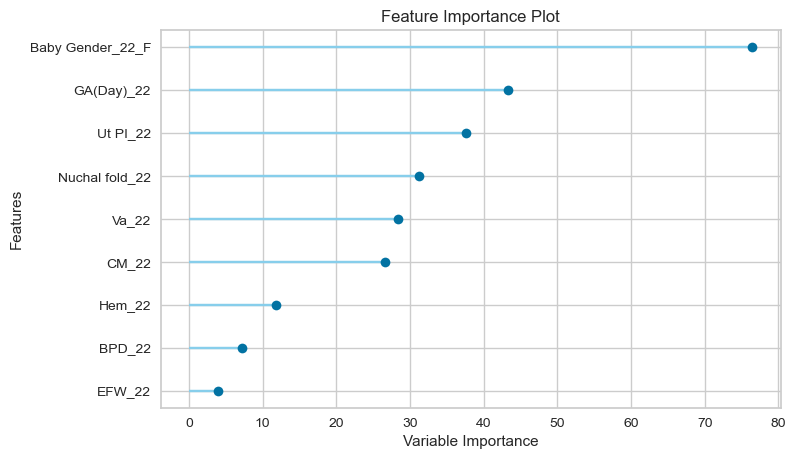

In [112]:
plot_model(tuned_lasso, plot='feature')

In [113]:
predict_model(tuned_lasso)

EFW_22  GA(Day)_22  CM_22  Ut PI_22  Va_22  Nuchal fold_22     Hem_22  \
0    289.0       143.0    4.7      1.71    7.5           4.100  21.000000   
1    436.0       151.0    3.7      0.86    5.3           4.510  25.400000   
2    445.0       151.0    6.4      1.07    6.7           5.050  27.400000   
3    461.0       151.0    5.2      1.05    6.4           4.900  26.200001   
4    396.0       145.0    6.0      1.07    7.4           3.640  25.000000   
..     ...         ...    ...       ...    ...             ...        ...   
94   541.0       158.0    8.0      0.62    7.0           3.930  26.900000   
95   413.0       154.0    5.6      0.88    8.7           5.020  24.000000   
96   504.0       153.0    4.1      1.21    7.6           5.580  26.200001   
97   420.0       150.0    6.7      0.59    5.6           5.388  25.299999   
98   442.0       154.0    5.8      0.58    5.8           3.510  26.400000   

       BPD_22  Baby Gender_22_F  EFW_32        Label  
0   45.500000               1.0  1630.0  1585.076660  
1   51.400002               0.0  1803.0  1688.478516  
2   54.299999               0.0  1872.0  1841.797363  
3   52.700001               0.0  1773.0  1863.264160  
4   52.299999               0.0  1976.0  1887.606445  
..        ...               ...     ...          ...  
94  55.799999               0.0  1865.0  1967.414062  
95  50.799999               1.0  1614.0  1718.750488  
96  52.900002               0.0  1895.0  1967.854004  
97  51.700001               1.0  1689.0  1874.310547  
98  53.299999               1.0  1528.0  1709.972656  

[99 rows x 11 columns]

In [114]:
final_lasso = finalize_model(lasso)

Basically autoML achieved the same results as mine, just the cross validated results different in numerical, but the model ranking looks similar.

In [116]:
#test features and train model
label_name = 'EFW_32'

#random forest regressor - no need scale/normalize data, but need to turn them to 1-hot encoding
df_train = df_22.drop([246,101,34,190])#outliers
df_train = df_train.merge(df_32[label_name], left_index= True, right_index=True) #join based on left index and right index
df_train = df_train.drop('IUGR_22', axis=1)
                         
#1-hot encoding
X = pd.get_dummies(df_train, drop_first=True)

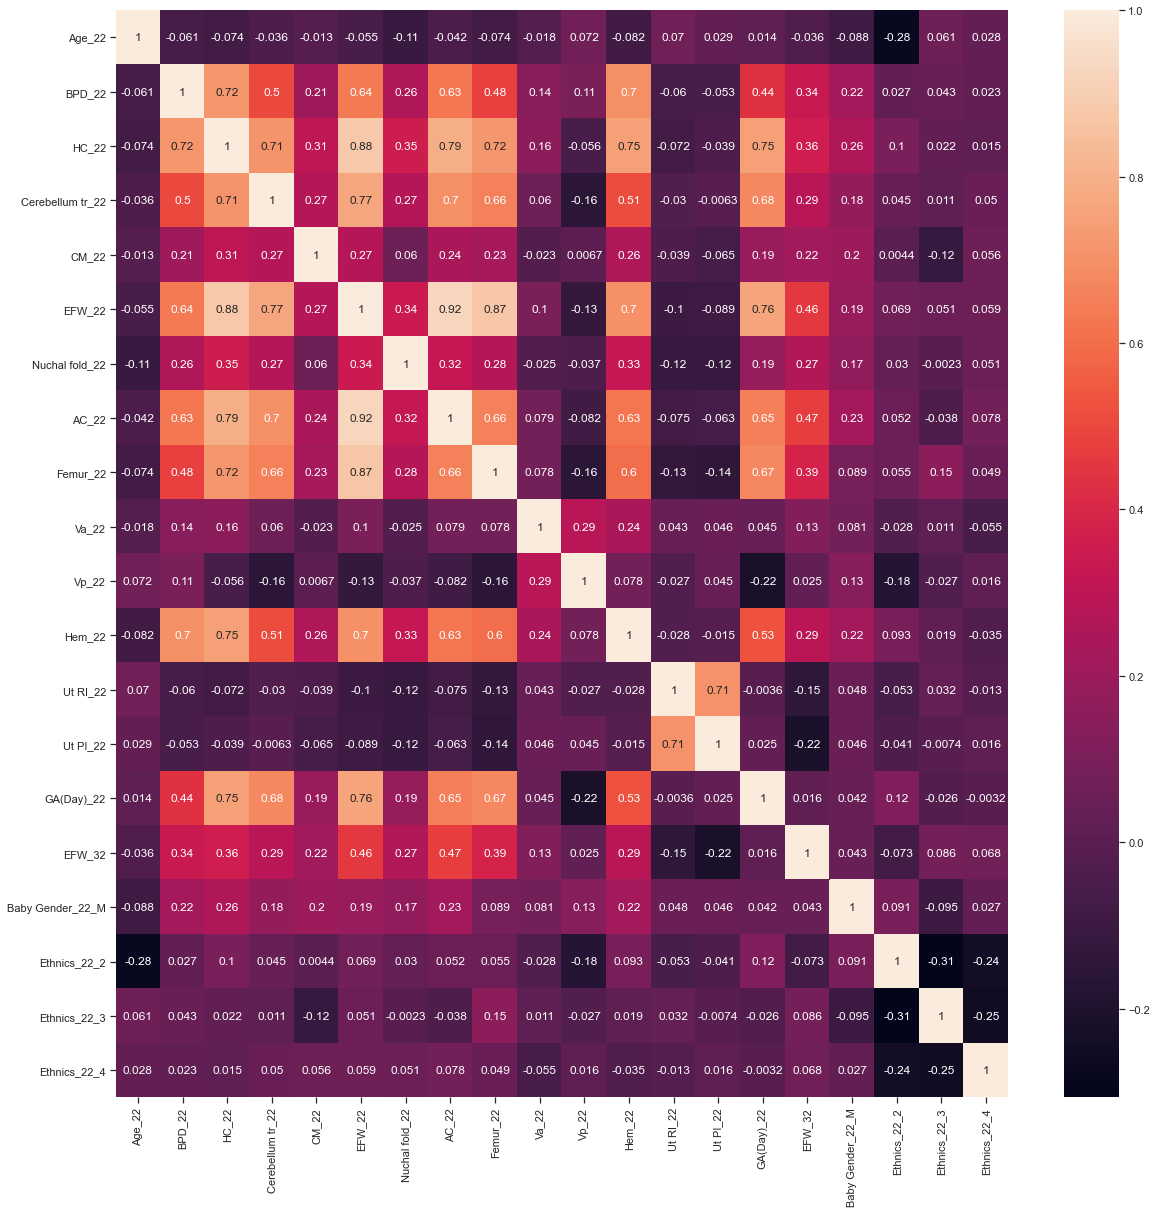

In [35]:
plot_heat_map(X)

IndexError: index 1 is out of bounds for axis 0 with size 1

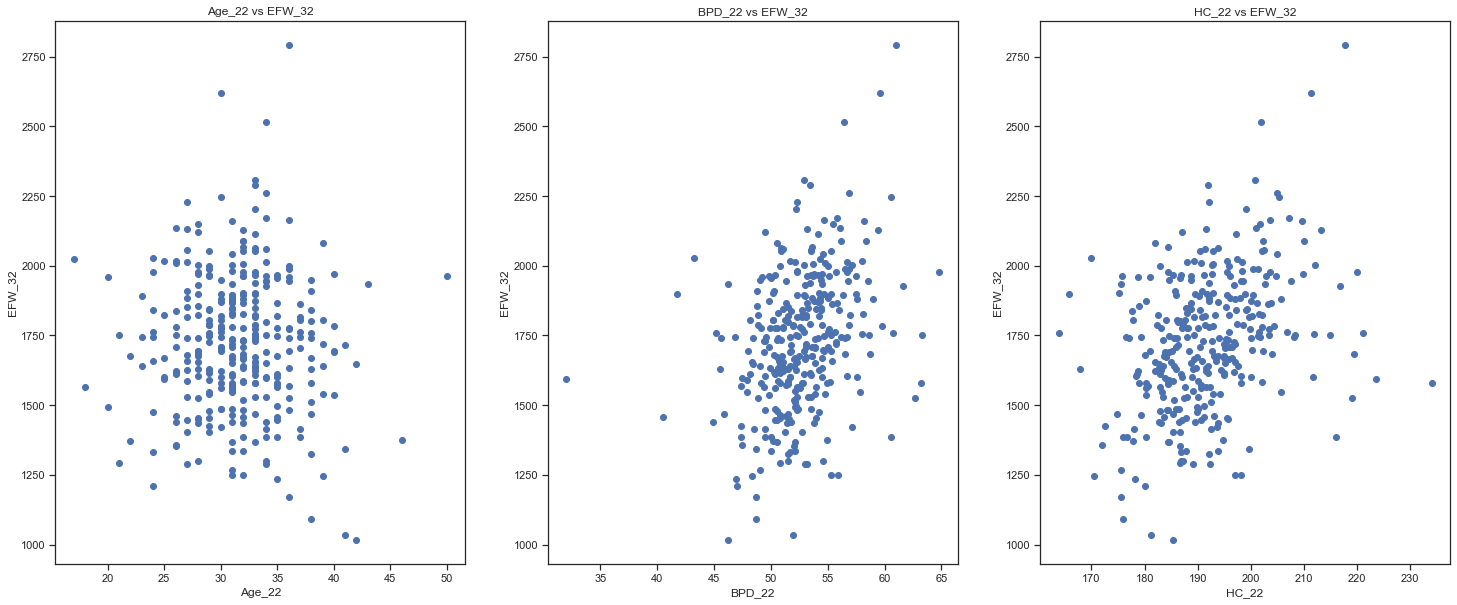

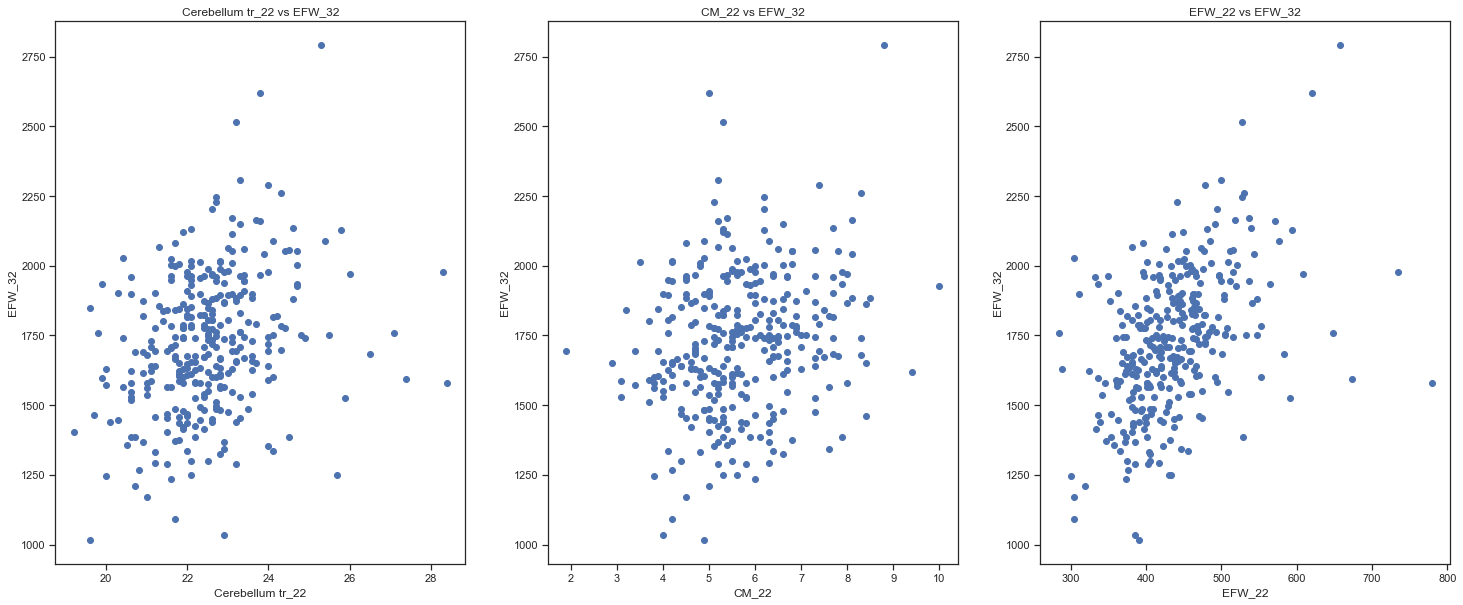

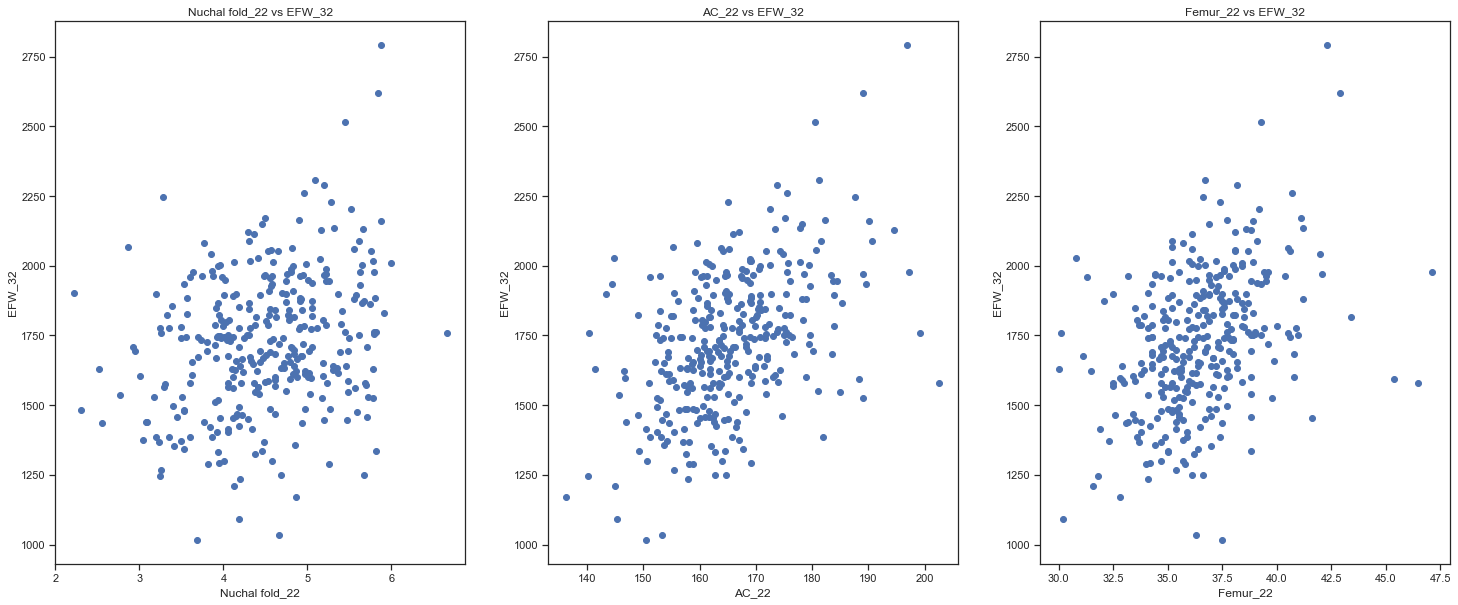

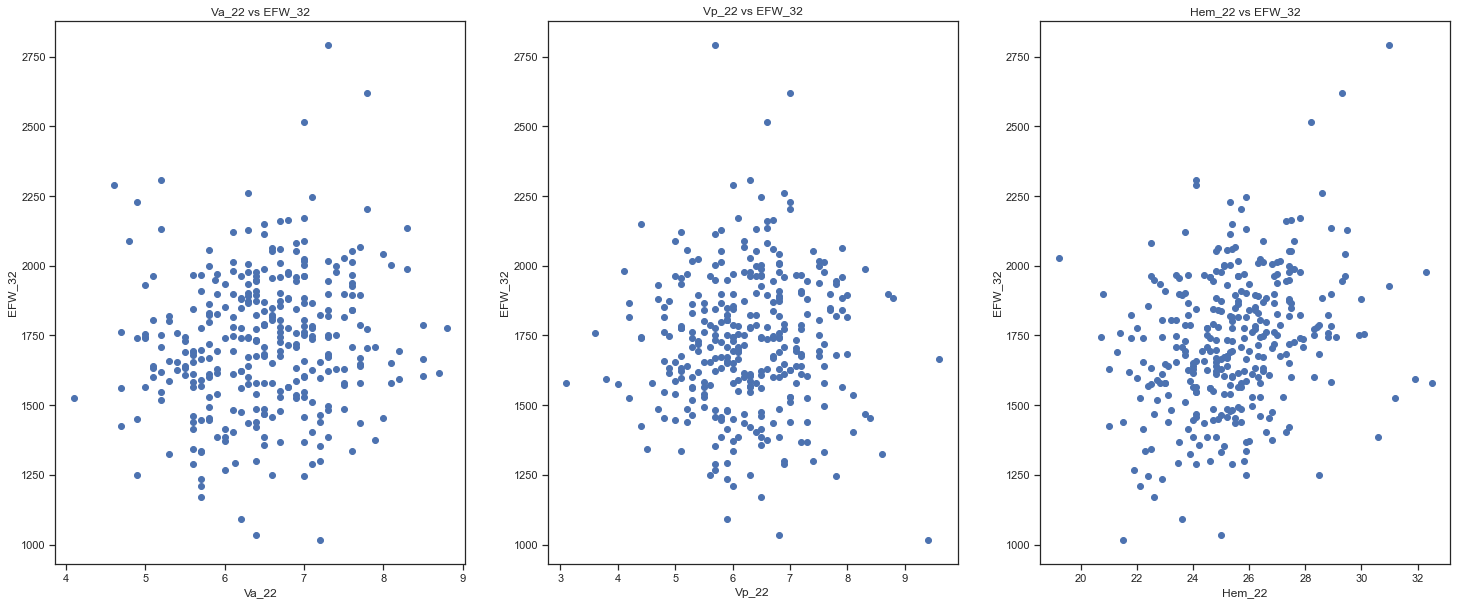

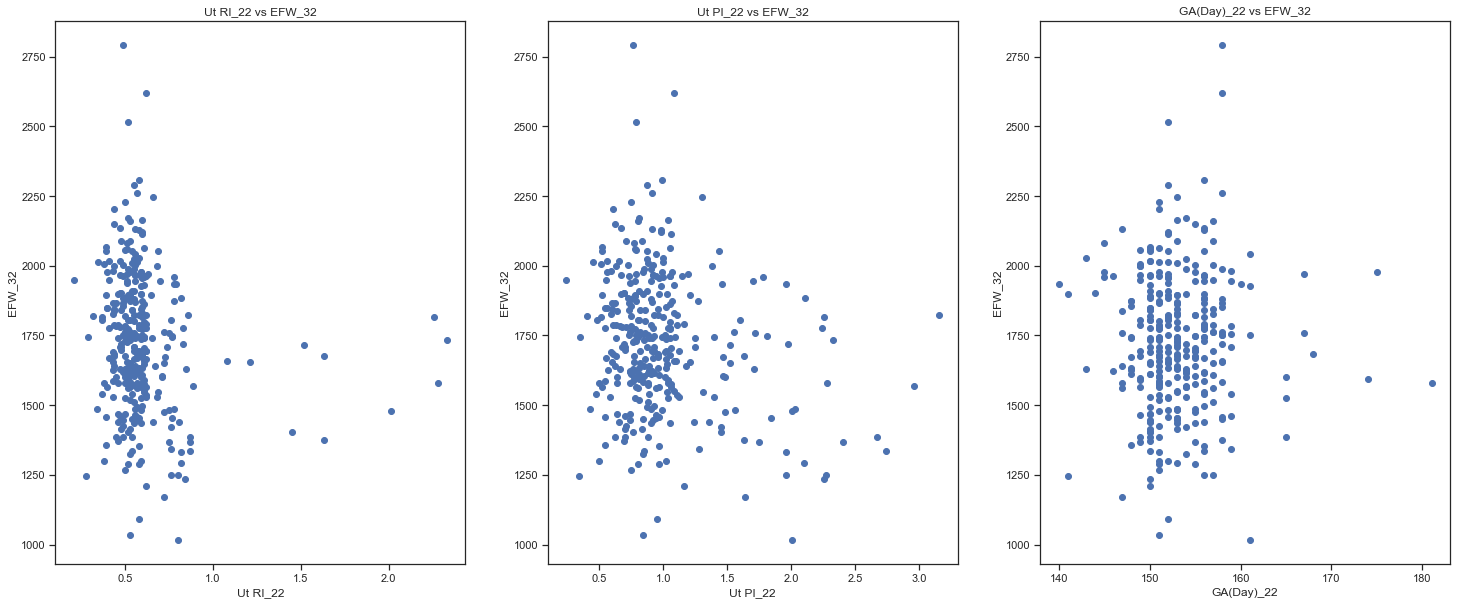

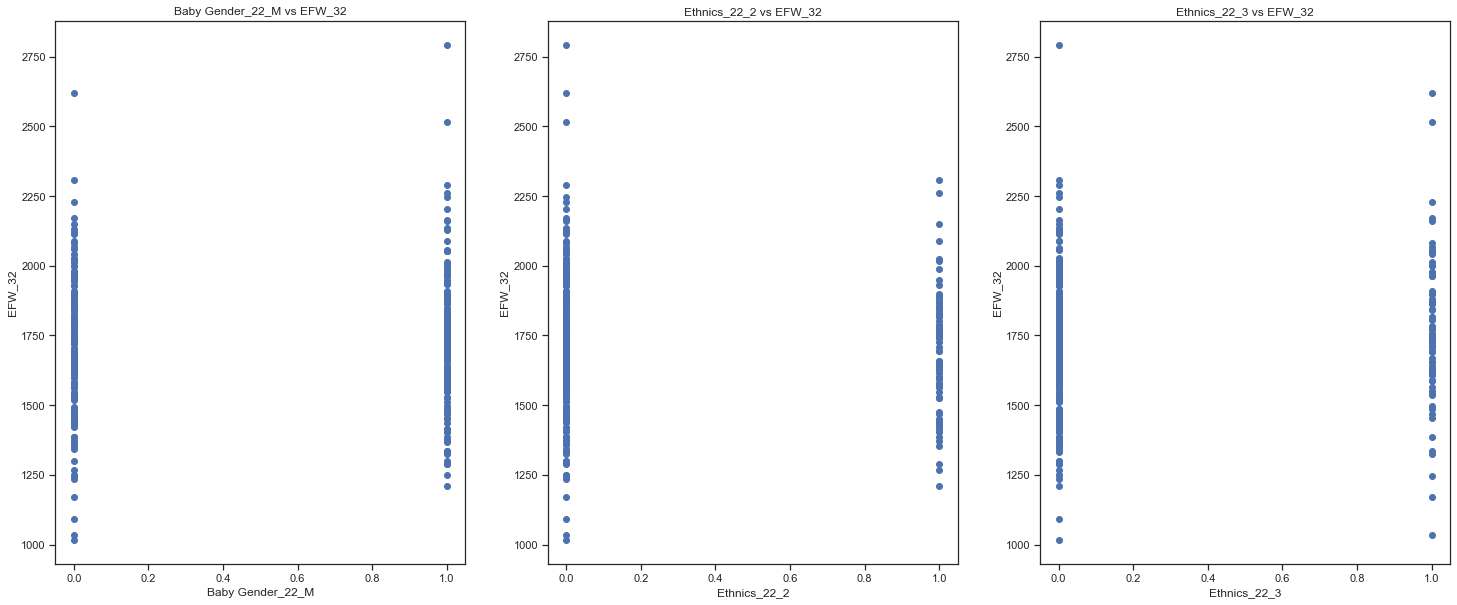

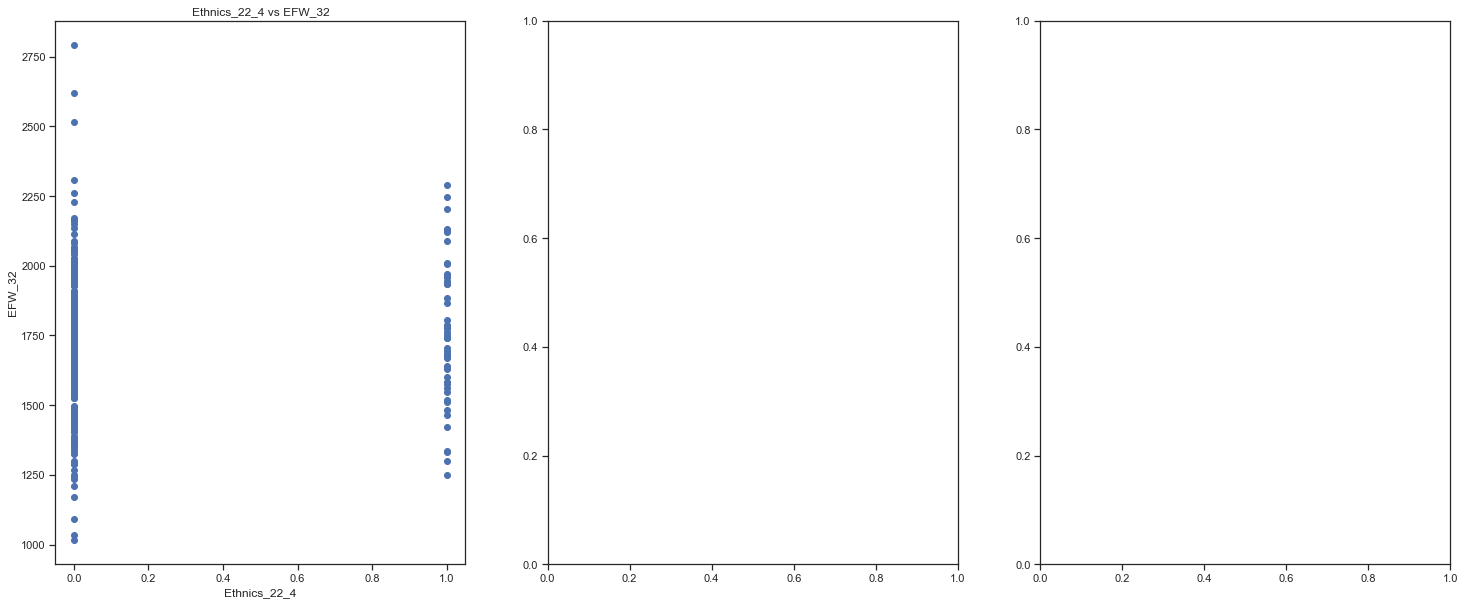

In [36]:
features_graph(X)

In [42]:
# #test using LR to predict feature importances
# # define the model
# lr_model = LinearRegression()
# # fit the model
# lr_model.fit(X_test_features, y_test_features)
# # get importance
# importance = lr_model.coef_

# df = pd.DataFrame({"X_col":X_test_features.columns, "Feature Importances":importance})
# df = df.sort_values(by=['Feature Importances'], ascending=False)

# x_col = list(df['X_col'])
# y_f = list(df['Feature Importances'])

# plt.bar(x_col, y_f)
# plt.xlabel(f'Feature Labels on {y_test_features.name}')
# plt.ylabel('Feature Importances')
# plt.title('Comparison of different Feature Importances')
# plt.xticks(range(len(x_col)), x_col, rotation=90)
# plt.show()

In [ ]:
# #select features - making the result worst
# selector = SelectKBest(f_regression, k=10).fit(X, X['EFW_32'])
# df_scores = pd.DataFrame(selector.scores_)
# df_columns = pd.DataFrame(X.columns)

# # concatenate dataframes
# feature_scores = pd.concat([df_columns, df_scores],axis=1)
# feature_scores.columns = ['Feature_Name','Score']  # name output columns
# print(feature_scores.nlargest(10,'Score'))  # print 20 best features

# best_features = feature_scores.nlargest(10,'Score').iloc[:, 0].tolist()
# X_ = X[best_features]
# X_['EFW_32'] = X['EFW_32']

### Become worse when use higher degree.

In [74]:
# from sklearn.preprocessing import PolynomialFeatures
# polynomial_features= PolynomialFeatures(degree=2)
# x_poly = polynomial_features.fit_transform(X.drop([label_name], axis=1))
# model = LinearRegression()
# model.fit(x_poly, X[label_name])
# cv = cross_validate(model, x_poly, X[label_name], cv=10, return_train_score=True, scoring='r2')
# print(cv)

### Here, I will compare which features selection method can generate the best results.

#### Stepwise selection

In [40]:
SL_in = 0.05
SL_out = 0.05
col_stepwise = stepwise_selection(X.drop(label_name, axis=1), X[label_name], SL_in, SL_out)
col_stepwise.append(label_name)

c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

['AC_22']
['AC_22', 'GA(Day)_22']
['AC_22', 'GA(Day)_22', 'EFW_22']
['GA(Day)_22', 'EFW_22']


c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

['GA(Day)_22', 'EFW_22', 'Baby Gender_22_M']
['GA(Day)_22', 'EFW_22', 'Baby Gender_22_M', 'CM_22']
['GA(Day)_22', 'EFW_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22']


c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

In [41]:
print('columns used:')
print(col_stepwise)

columns used:
['GA(Day)_22', 'EFW_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'EFW_32']


In [42]:
#model setup
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          RandomForestRegressor(n_estimators = 10, random_state = 42),
          AdaBoostRegressor(random_state=42, n_estimators=50), 
          GradientBoostingRegressor(n_estimators = 50, random_state = 42), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
          KNeighborsRegressor(n_neighbors=5),
          linear_model.BayesianRidge(),
         ]

#### Backward elimination
https://www.geeksforgeeks.org/ml-multiple-linear-regression-backward-elimination-technique/     
https://gist.github.com/vb100/6af31cbf9950e598d01cd6add98a3814

In [80]:
# SL = 0.05
# X_22_32, columns_drop_list = backward_elimination(X.drop(label_name, axis=1), X[label_name],  SL, const=True)

# #add y into X_Modeled
# X_22_32[label_name] = X[label_name]
# # print('\ncolumns to be dropped:\n', columns_drop_list)
# print('columns used:', X_22_32.columns)

                            OLS Regression Results                            
Dep. Variable:                 EFW_32   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     34.72
Date:                Thu, 10 Jun 2021   Prob (F-statistic):           4.67e-48
Time:                        09:12:49   Log-Likelihood:                -2145.6
No. Observations:                 328   AIC:                             4315.
Df Residuals:                     316   BIC:                             4361.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
HC_22                3.5520      2.325  

In [81]:
# #cross validate the model to check
# #cross_validate_models(models, columns, df_32_X), columns = list of y you wanna predict, return a dict as a result
# #cv - backward eli
# print('Prediction of WK32 using WK22 backward elimination')
# cross_validate_models(models, X_22_32.drop(['IUGR_22_1', 'Baby Gender_22_M'], axis=1), label_name)

Prediction of WK32 using WK22 backward elimination
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.435916   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.435838   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.388888   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.225516   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.281841   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.303841   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.191862   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.123251   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.109791       0.500574      0.024523         -183.317215   
1     0.101153       0.496977      0.024607         -183.539154   
2     0.081579       0.440693      0.023905         -191.664649   
3     0.126189       0.850771      0.013000         -215.522040   
4     0.096602       0.609396      0.021801         -207.953775   
5     0.107082       0.780905      0.013952         -204.464344   
6     0.053953       0.226830      0.022925         -221.209380   
7     0.147561       0.435140      0.026607         -228.941493   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          17.304762       0.094398          -175.977311            4.302435   
1          16.885382       0.091999          -176.609854            4.287248   
2          17.563407       0.091636          -186.247205            4.204454   
3          21.808293       0.101188           -96.146998            4.584325   
4          20.807821       0.100060          -155.620090            4.516403   
5          20.053051       0.098076          -116.527626            3.560596   
6          20.909312       0.094523          -219.034589            5.160839   
7          20.928825       0.091416          -187.189137            5.667823   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.449624                     0.106559  1726.679878  
1                      0.449163                     0.098543  1726.679878  
2                      0.402454                     0.079811  1726.679878  
3                      0.242395                     0.123434  1726.679878  
4                      0.296421                     0.095508  1726.679878  
5                      0.318600                     0.105207  1726.679878  
6                      0.207386                     0.049337  1726.679878  
7                      0.139740                     0.144725  1726.679878

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -183.31721479973737
The error:10.6%
10.6


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 -183.31721479973737)

In [45]:
#stepwise - I tried to append columns to see whether the r2 grow but the ori is the highest
print('Prediction of WK32 using WK22 stepwise elimination')
# cross_validate_models(models, X[col_stepwise].drop(['Baby Gender_22_M'], axis=1), label_name)

Prediction of WK32 using WK22 stepwise elimination
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.450703   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.450081   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.378669   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.218809   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.273916   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.311657   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.449523   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.159647   
8  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...      0.450401   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099113       0.491439      0.022838         -181.061813   
1     0.093001       0.489876      0.022917         -181.349354   
2     0.062139       0.412819      0.021553         -193.698164   
3     0.128029       0.853160      0.011950         -216.235197   
4     0.086815       0.556233      0.023288         -209.283605   
5     0.094878       0.717004      0.014452         -203.371007   
6     0.098011       0.489580      0.023219         -181.250235   
7     0.151049       0.470887      0.024488         -224.016261   
8     0.099357       0.489741      0.023018         -181.106872   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          16.334625       0.090216          -177.589391            4.035365   
1          16.472776       0.090834          -177.861741            4.030204   
2          18.264497       0.094294          -190.849385            4.104180   
3          19.151272       0.088567           -95.378582            4.168298   
4          21.087323       0.100760          -165.891714            4.958567   
5          18.576375       0.091342          -132.465855            3.460022   
6          16.048938       0.088546          -177.912140            4.069030   
7          20.844259       0.093048          -181.175429            5.602994   
8          16.284040       0.089914          -177.885268            4.060438   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.463099                     0.096757  1726.679878  
1                      0.462326                     0.090923  1726.679878  
2                      0.391286                     0.061531  1726.679878  
3                      0.236322                     0.126920  1726.679878  
4                      0.288104                     0.086585  1726.679878  
5                      0.324973                     0.090291  1726.679878  
6                      0.461448                     0.096556  1726.679878  
7                      0.173944                     0.149455  1726.679878  
8                      0.462651                     0.097036  1726.679878

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.06181267857997
The error:10.5%
10.5


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 -181.06181267857997)

In [87]:
print('Prediction of WK32 using WK22 stepwise elimination')
cross_validate_models(models, X[col_stepwise].drop('IUGR_22_1',axis=1), label_name)

Prediction of WK32 using WK22 stepwise elimination
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.466586   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.465338   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.380429   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.269767   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.304983   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.322718   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.108459   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.160217   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094730       0.507893      0.022040         -178.450271   
1     0.089481       0.505667      0.022138         -178.830630   
2     0.059453       0.415782      0.021128         -193.457394   
3     0.110785       0.857672      0.012671         -209.463244   
4     0.086459       0.570896      0.020554         -204.756995   
5     0.096603       0.734205      0.013559         -201.912164   
6     0.034319       0.135577      0.013038         -232.614694   
7     0.145888       0.470528      0.023838         -224.087025   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          15.845486       0.088795          -174.693576            3.974114   
1          16.070462       0.089864          -175.087813            3.965084   
2          18.187462       0.094013          -190.368024            4.042444   
3          20.943314       0.099986           -93.900537            4.703126   
4          20.892156       0.102034          -163.146110            4.898188   
5          20.800216       0.103016          -128.387104            3.723536   
6          22.979316       0.098787          -231.641885            5.635792   
7          21.281050       0.094968          -181.235636            5.382394   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.478348                     0.092937  1726.679878  
1                      0.476933                     0.087795  1726.679878  
2                      0.392066                     0.058185  1726.679878  
3                      0.283791                     0.109699  1726.679878  
4                      0.321128                     0.085619  1726.679878  
5                      0.335677                     0.095186  1726.679878  
6                      0.124423                     0.027489  1726.679878  
7                      0.174884                     0.143693  1726.679878

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.45027099517864
The error:10.299999999999999%
10.299999999999999


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 -178.45027099517864)

In [88]:
# ##my features
# my_df = test_features(models, X, label_name)

Loop 1:


KeyboardInterrupt: 

### After comparing, I decided to write my own feature selection methods.

In [54]:
# feature selections
# models = [LinearRegression(normalize=True), 
#           Lasso(alpha=0.2, normalize=True),
#           Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
#           make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
#           linear_model.BayesianRidge(),]

# my_for_df, best_feature_rmse, best_feature_to_return = test_features_forward(models, X, label_name, ['EFW_22'])

Loop 1:


<ipython-input-3-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.167908   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.168566   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.168789   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.165353   
4  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...      0.168090   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.117103       0.209888      0.026286         -223.446838   
1     0.111989       0.209718      0.026291         -223.449802   
2     0.088301       0.204058      0.025556         -223.819325   
3     0.136855       0.205566      0.028039         -223.400090   
4     0.114539       0.209843      0.026295         -223.469641   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.026828       0.085151          -221.400197            4.831146   
1          19.051021       0.085259          -221.423911            4.830623   
2          19.479957       0.087034          -222.219501            4.838278   
3          18.962453       0.084881          -221.997866            4.871773   
4          19.040340       0.085203          -221.406426            4.831343   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.182959                     0.114613  1726.679878  
1                      0.183560                     0.109510  1726.679878  
2                      0.183572                     0.085661  1726.679878  
3                      0.180972                     0.133736  1726.679878  
4                      0.183114                     0.112061  1726.679878

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -223.40009018465528
The error:12.9%
12.9
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4']


  0%|                                                                                           | 0/18 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [44]:
#Mine
'''
['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22'] - mine
['GA(Day)_22', 'EFW_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'EFW_32'] - stepwise

have to remove IUGR_22_1 since it is future feature.
'''

my_cols = ['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22', 'EFW_32'] #IUGR not possible

print('Prediction of WK32 using WK22 using my elimination')
cross_validate_models(models, X[my_cols], label_name)

Prediction of WK32 using WK22 using my elimination
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.472853   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.469185   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.393554   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.222656   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.288698   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.280144   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.480197   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.146605   
8  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...      0.471191   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097627       0.529201      0.022460         -177.370887   
1     0.090293       0.525201      0.022570         -178.194592   
2     0.071915       0.444344      0.021135         -191.169085   
3     0.121520       0.850832      0.012931         -215.975800   
4     0.091358       0.608556      0.018594         -207.094577   
5     0.096729       0.780048      0.012933         -208.170829   
6     0.095346       0.526101      0.022671         -176.130056   
7     0.155407       0.457727      0.024967         -225.590492   
8     0.098508       0.524061      0.023033         -177.640185   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          17.020830       0.095962          -170.867243            4.262828   
1          16.774304       0.094135          -171.591403            4.242056   
2          18.033408       0.094332          -185.654661            4.163760   
3          21.221293       0.098258           -96.140879            4.784951   
4          21.423121       0.103446          -155.819926            4.529220   
5          20.266444       0.097355          -116.776038            3.698603   
6          16.727602       0.094973          -171.428575            4.285289   
7          20.671387       0.091632          -183.411366            5.502243   
8          16.986699       0.095624          -171.796316            4.353421   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.486333                     0.095395  1726.679878  
1                      0.482073                     0.088713  1726.679878  
2                      0.406886                     0.071013  1726.679878  
3                      0.238726                     0.116714  1726.679878  
4                      0.303581                     0.089683  1726.679878  
5                      0.294299                     0.094265  1726.679878  
6                      0.492354                     0.094185  1726.679878  
7                      0.161301                     0.154399  1726.679878  
8                      0.484224                     0.096261  1726.679878

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -176.13005629435443
The error:10.2%
10.2


In [165]:
print('Columns used:\n', my_cols)

Columns used:
 ['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22', 'EFW_32']


# Hyperparameter tuning

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

### Chose Linear, Lasso, Ridge, SVR to perform hypertuning

In [170]:
#General params
cv = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42)

#### For Backward Eli

In [34]:
# #linear_reg
# linear_reg_best_params_backward = linear_regression_hypertune(X_22_32.drop(label_name, axis=1), X_22_32[label_name], cv)

Fitting 75 folds for each of 4 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1809s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0354s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0648s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1057s.) Setting batch_size=16.


Best Score (neg_mean_absolute_error): -141.3919828083676
Best Hyperparameters: {'normalize': True, 'fit_intercept': True}


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.6s finished


In [35]:
# #Ridge
# ridge_best_params_backward = ridge_hypertune(X_22_32.drop(label_name, axis=1), X_22_32[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0190s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0519s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1217s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 768 t

Best Score in neg_root_mean_squared_error: -185.86237043151905
Best Hyperparameters: {'alpha': 8.879374434074535, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  2.8min finished


In [36]:
# #lasso 
# lasso_best_params_backward = lasso_hypertune(X_22_32.drop(label_name, axis=1), X_22_32[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0449s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0838s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1406s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 768 t

Best Score: -141.3919832579902
Best Hyperparameters: {'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.9min finished


In [37]:
# #Support Vector Regressor
# svr_best_params_backward = svr_hypertune(X_22_32.drop(label_name, axis=1), X_22_32[label_name], cv)

Fitting 75 folds for each of 240 candidates, totalling 18000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1746s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0329s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0618s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1217s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 540 tasks      | elapsed:    3.3s
exception calling callback for <Future at 0x173

KeyboardInterrupt: 

In [99]:
# #Final Cross Validate using tuned params - backward
# #cross_validate_models(models, columns, df_32_X), columns = list of y you wanna predict, return a dict as a result
# #Finalized Params
# models = [LinearRegression(normalize=True, fit_intercept=True), 
#           Ridge(alpha=0.03128871367903606,fit_intercept=True, normalize=True, solver='cholesky'),
#           Lasso(alpha=0.057418232283616887, normalize=True, fit_intercept=True, selection='cyclic'),
#           make_pipeline(StandardScaler(), SVR(kernel='linear', C=10, epsilon=10, gamma='scale', )), 
#          ]
# #cv
# print('Prediction of WK32 using WK22 backward elimination after tuning.')
# cross_validate_models(models, X_22_32, label_name)

#### For stepwise elimination

In [81]:
# #linear_reg
# linear_reg_best_params_stepwise = linear_regression_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

NameError: name 'cv' is not defined

In [220]:
# #Ridge
# ridge_best_params_stepwise = ridge_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0758s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0359s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0588s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1346s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.3s
[Parallel(n

Best Score in neg_root_mean_squared_error: -181.2782431101997
Best Hyperparameters: {'alpha': 5.820097823045092, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  2.3min finished


In [221]:
# #lasso 
# lasso_best_params_stepwise = lasso_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0389s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0369s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1287s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1626s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n

Best Score: -138.28402977299797
Best Hyperparameters: {'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.4min finished


In [91]:
# print(col_stepwise)

['GA(Day)_22', 'EFW_22', 'IUGR_22_1', 'Baby Gender_22_M', 'CM_22', 'Va_22', 'EFW_32']


In [97]:
# #Final Cross Validate using tuned params -stepwise eli

# #ridge
# #{'alpha': 5.820097823045092, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}

# #lasso
# #{'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}

# models = [LinearRegression(normalize=True, fit_intercept=True), 
#           Ridge(alpha=5.820097823045092, normalize=False, fit_intercept=True, solver='sparse_cg'),
#           Lasso(alpha=1.0405895699434454e-05, normalize=False, fit_intercept=True, selection='cyclic'),
#          ]
# #cv
# # cross_validate_models(models, X.drop(['AC_22', 'Femur_22'], axis=1), label_name)
# print('Prediction of WK32 using WK22 stepwise elimination after tuning.')
# cross_validate_models(models, X[col_stepwise].drop('IUGR_22_1', axis=1), label_name)

Prediction of WK32 using WK22 stepwise elimination after tuning.
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.466586   
1  Ridge(alpha=5.820097823045092, copy_X=True, fi...      0.466626   
2  Lasso(alpha=1.0405895699434454e-05, copy_X=Tru...      0.466586   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094730       0.507893      0.022040         -178.450271   
1     0.093719       0.507137      0.022001         -178.459274   
2     0.094730       0.507893      0.022040         -178.450271   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          15.845486       0.088795          -174.693576            3.974114   
1          15.753421       0.088275          -174.828513            3.992650   
2          15.845486       0.088795          -174.693576            3.974114   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.478348                     0.092937  1726.679878  
1                      0.478339                     0.092007  1726.679878  
2                      0.478348                     0.092937  1726.679878

The best model is 
 Lasso(alpha=1.0405895699434454e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
 with rmse score: -178.4502708530055
The error:10.299999999999999%
10.299999999999999


(Lasso(alpha=1.0405895699434454e-05, copy_X=True, fit_intercept=True,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 -178.4502708530055)

#### My features - best

In [80]:
#General params
cv = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42)

my_cols = ['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22', 'EFW_32'] #IUGR not possible

In [171]:
#linear_reg
linear_reg_best_params_mine = linear_regression_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 4 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1851s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0329s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0713s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 266 t

Best Score (neg_mean_absolute_error): -138.31706281875208
Best Hyperparameters: {'normalize': True, 'fit_intercept': True}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.3s finished


In [172]:
#Ridge
ridge_best_params_mine = ridge_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0369s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0469s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0738s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1805s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3216 tasks    

Best Score in neg_root_mean_squared_error: -177.13576768247452
Best Hyperparameters: {'alpha': 12.340769010376022, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  2.3min finished


In [173]:
#lasso 
lasso_best_params_mine = lasso_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0618s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1227s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 t

Best Score: -138.31706364947283
Best Hyperparameters: {'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.7min finished


In [50]:
#Support Vector Regressor
svr_best_params_mine = svr_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 240 candidates, totalling 18000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1888s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0269s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0529s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1137s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 540 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 748 tasks      | ela

Best Score: -137.70466827020846
Best Hyperparameters: {'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


In [51]:
#Bayesian Ridge
b_ridge_best_params_mine = b_ridge_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1911s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0459s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0574s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1207s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 288 t

Best Score in neg_root_mean_squared_error: -177.5096819832317
Best Hyperparameters: {'alpha_1': 9.732339537431798, 'alpha_2': 0.5029667266319318, 'fit_intercept': True, 'lambda_1': 0.00035232317780219824, 'lambda_2': 0.17444373949516154, 'normalize': True}


In [174]:
print(my_cols)

['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22', 'EFW_32']


In [118]:
#v1 ----------------------
#ridge
#{'alpha': 8.879374434074535, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}
#lasso
#{'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}

#v2 ----------------------------
#lr
# 'normalize': True, 'fit_intercept': True
#ridge
# 'alpha': 12.340769010376022, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'
#lasso
# 'alpha': 1.0405895699434454e-05, 'fit_intercept': True, 'normalize': False, 'selection': 'cyclic'}
#svr
#'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'
#b_ridge
#'alpha_1': 9.732339537431798, 'alpha_2': 0.5029667266319318, 'fit_intercept': True, 'lambda_1': 0.00035232317780219824, 'lambda_2': 0.17444373949516154, 'normalize': True

models = [LinearRegression(normalize=True, fit_intercept=True), 
          Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=12, solver='auto', tol=0.001),
#           Ridge(alpha=12.340769010376022, normalize=False, fit_intercept=True, solver='auto'),
          Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
          normalize=False, positive=False, precompute=False, random_state=12,
          selection='cyclic', tol=0.0001, warm_start=False),
#           Lasso(alpha=1.0405895699434454e-05, normalize=False, fit_intercept=True, selection='cyclic'),
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')),
          linear_model.BayesianRidge(alpha_1=9.732339537431798, alpha_2=0.5029667266319318, fit_intercept=True, lambda_1=0.00035232317780219824, lambda_2=0.17444373949516154, normalize=True),
         ]

print('Prediction of WK32 using WK22 my elimination after tuning.')
# cross_validate_models(models, X[my_cols], label_name)
cross_validate_models(models, X[my_cols], label_name)

#conclude:
#with IUGR and baby gender:  best rmse
#with baby gender: better
#nothing: worse

Prediction of WK32 using WK22 my elimination after tuning.
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.472853   
1  Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...      0.473098   
2  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...      0.472548   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.480197   
4  BayesianRidge(alpha_1=9.732339537431798, alpha...      0.472743   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097627       0.529201      0.022460         -177.370887   
1     0.097645       0.529191      0.022461         -177.329015   
2     0.097426       0.528928      0.022469         -177.431959   
3     0.095346       0.526101      0.022671         -176.130056   
4     0.093545       0.528428      0.022562         -177.509682   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          17.020830       0.095962          -170.867243            4.262828   
1          17.019917       0.095979          -170.869120            4.262803   
2          17.009794       0.095867          -170.916772            4.262225   
3          16.727602       0.094973          -171.428575            4.285289   
4          16.983079       0.095674          -171.007084            4.273286   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.486333                     0.095395  1726.679878  
1                      0.486554                     0.095409  1726.679878  
2                      0.485912                     0.095235  1726.679878  
3                      0.492354                     0.094185  1726.679878  
4                      0.486059                     0.091492  1726.679878

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -176.13005629435443
The error:10.2%
10.2


(Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svr',
                  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                      gamma='scale', kernel='linear', max_iter=-1,
                      shrinking=True, tol=0.001, verbose=False))],
          verbose=False),
 -176.13005629435443)

In [ ]:
#Xg boost cv
# data_dmatrix = xgb.DMatrix(data=X.drop(label_name,axis=1),label=X[label_name])

# params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True)

# cv_results.tail()

In [ ]:
# xgboost final model template
# X_train, X_test, y_train, y_test = train_test_split(X.drop(label_name,axis=1), X[label_name], test_size=0.20, random_state=42)
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10)

# xg_reg.fit(X_train,y_train)

# preds = xg_reg.predict(X_test)

# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))



In [ ]:
#sample tree
# X_train, X_test, y_train, y_test = train_test_split(X.drop(label_name,axis=1), X[label_name], test_size=0.20, random_state=42)
# data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
# data_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' #visualize graph

# xg_reg = xgb.train(params=params, dtrain=data_dmatrix_train, num_boost_round=100)
# preds = xg_reg.predict(data_dmatrix_test)
# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))
# xgb.plot_tree(xg_reg,num_trees=6) #which tree you want to plot
# plt.rcParams['figure.figsize'] = [10, 5]
# plt.show()

## Predict Wk32 AC and FL - Failed

- I tried to models to predict AC and FL to feed into Hadlock Formulae to get the final EFW, unfortunately it doesn't perform well.

In [ ]:
hadlock_1(ac_cm, fl_cm)

In [37]:
df_32

HC_32  AC_32  FEMUR_32  EFW_32  HC/AC_32  FL/HC_32  FL/AC_32     AFI_32  \
0    296.4  279.4      60.5  1870.0      1.06      0.20      0.22  12.100000   
1    300.2  277.0      61.6  1894.0      1.08      0.21      0.22  14.100000   
2    289.9  274.3      57.6  1709.0      1.06      0.20      0.21  13.100000   
3    288.0  265.8      59.7  1676.0      1.08      0.21      0.22  11.100000   
4    307.4  275.2      60.7  1883.0      1.12      0.20      0.22  13.638169   
..     ...    ...       ...     ...       ...       ...       ...        ...   
341  283.2  273.5      62.4  1805.0      1.04      0.22      0.23  13.152448   
342  274.0  248.4      58.0  1425.0      1.10      0.21      0.23  11.800000   
343  302.1  269.6      61.7  1831.0      1.12      0.20      0.23  11.600000   
345  291.3  273.0      59.6  1757.0      1.07      0.20      0.22  15.300000   
346  294.4  277.3      61.5  1868.0      1.06      0.21      0.22   7.600000   

     Umb RI_32  Umb S/D_32  GA(Day)_32 IUGR_32  HC_GA_32  
0         0.53        2.14       227.0     0.0  1.249278  
1         0.51        2.04       225.0     0.0  1.334222  
2         0.67        3.06       228.0     0.0  1.271491  
3         0.64        2.76       215.0     0.0  1.339535  
4         0.53        2.12       227.0     0.0  1.354185  
..         ...         ...         ...     ...       ...  
341       0.72        3.60       226.0     0.0  1.253097  
342       0.63        2.67       217.0     0.0  1.262673  
343       0.59        2.45       230.0     0.0  1.313478  
345       0.56        2.26       224.0     0.0  1.300446  
346       0.62        2.61       228.0     0.0  1.291228  

[332 rows x 13 columns]

In [ ]:
plot_heat_map(X)

In [70]:
#test features and train model
label_name = 'AC_32'

#random forest regressor - no need scale/normalize data, but need to turn them to 1-hot encoding
df_train = df_22.drop(['GA at birth (days)_22','BW (g)_22', 'BW Centile_22', '3 Scans_22'], axis=1)
df_train = df_train.merge(df_32[label_name], left_index= True, right_index=True) #join based on left index and right index

#1-hot encoding
X = pd.get_dummies(df_train, drop_first=True)

#backward
SL = 0.05
X_22_32AC, columns_drop_list = backward_elimination(X.drop(label_name, axis=1), X[label_name],  SL)
#add y into X_Modeled
X_22_32AC[label_name] = X[label_name]
print('\ncolumns to be dropped:\n', columns_drop_list)

#stepwise return nothing
# col_stepwise = stepwise_selection(X.drop(label_name, axis=1), X[label_name])
# col_stepwise.append(label_name)
# print('columns used:')
# print(col_stepwise)

                                 OLS Regression Results                                
Dep. Variable:                  AC_32   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              75.19
Date:                Sun, 16 May 2021   Prob (F-statistic):                    4.35e-78
Time:                        17:14:34   Log-Likelihood:                         -2207.3
No. Observations:                 332   AIC:                                      4435.
Df Residuals:                     322   BIC:                                      4473.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [71]:
#cross validate the model to check
#cross_validate_models(models, columns, df_32_X), columns = list of y you wanna predict, return a dict as a result

#Initial model setup
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          RandomForestRegressor(n_estimators = 10, random_state = 42),
          AdaBoostRegressor(random_state=42, n_estimators=50), 
          GradientBoostingRegressor(n_estimators = 50, random_state = 42), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=0.5, epsilon=0.1)), 
          KNeighborsRegressor(n_neighbors=5)
         ]
#cv - backward eli
print('Prediction of WK32 using WK22 stepwise elimination')
cross_validate_models(models, X_22_32AC, label_name)

Prediction of WK32 using WK22 stepwise elimination
Cross validation Result for AC_32:


Models    test_r2  train_r2  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...  -6.008573  0.074019   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  -3.109504  0.055955   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...  -2.958747  0.064280   
3  RandomForestRegressor(bootstrap=True, ccp_alph... -24.820490  0.786421   
4  AdaBoostRegressor(base_estimator=None, learnin...  -1.986324  0.976724   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha... -48.311151  0.982345   
6  (StandardScaler(copy=True, with_mean=True, wit...   0.226676  0.023607   
7  KNeighborsRegressor(algorithm='auto', leaf_siz... -28.959387  0.195340   

   test_neg_rmse  train_neg_rmse      y_mean  
0    -145.566797     -180.484880  282.087349  
1    -137.940627     -181.302607  282.087349  
2    -137.137257     -181.299330  282.087349  
3    -171.952529      -85.601205  282.087349  
4    -127.444170      -13.594359  282.087349  
5    -191.555099      -16.844706  282.087349  
6    -121.618247     -185.356257  282.087349  
7    -182.608942     -167.890545  282.087349

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with test_r2 score: 0.22667623649490243


In [72]:
X_22_32AC

HC_22  CM_22  EFW_22  Nuchal fold_22  AC_22  Vp_22  Hem_22  GA(Day)_22  \
0    193.9    7.3     441            4.74  170.7    6.7    26.5         153   
1    186.0    5.9     415            4.43  162.4    6.6    23.6         152   
2    186.0    5.4     410            2.93  166.0    6.9    23.4         152   
3    195.0    6.5     417            4.05  163.8    7.2    26.3         153   
4    192.1    8.1     400            4.91  159.8    7.9    26.6         150   
..     ...    ...     ...             ...    ...    ...     ...         ...   
341  186.1    4.1     405            4.78  160.5    5.9    23.4         149   
342  172.5    5.2     383            4.19  163.0    4.4    21.0         151   
343  188.0    6.4     448            5.91  163.7    5.3    26.3         153   
345  221.1    5.3     648            6.66  199.1    3.6    28.8         167   
346  188.8    6.0     436            4.31  161.3    4.2    23.8         151   

     Baby Gender_22_M  Va_22  AC_32  
0                   1    6.5  279.4  
1                   0    6.4  277.0  
2                   1    7.9  274.3  
3                   0    6.7  265.8  
4                   1    6.2  275.2  
..                ...    ...    ...  
341                 0    6.6  273.5  
342                 0    4.7  248.4  
343                 1    5.8  269.6  
345                 1    6.9  273.0  
346                 0    7.1  277.3  

[332 rows x 11 columns]

## Predict Wk35 fetal weight using Wk22 data  -FAILED
- The results is not good.
- Since all quite low, I don't tune them

In [153]:
#test features and train model
label_name = 'EFW_35'

#random forest regressor - no need scale/normalize data, but need to turn them to 1-hot encoding
df_train = df_22

#only 224 rows existed in df_35[EFW]
#hence, use merge
df_train = df_train.merge(df_35[label_name], left_index= True, right_index=True) #join based on left index and right index
#drop the outliers- None

#1-hot encoding
X = pd.get_dummies(df_train, drop_first=True)
# y = df_train['EFW_y']
# #drop the EFW from X
# X.drop('EFW_y', axis=1, inplace=True)

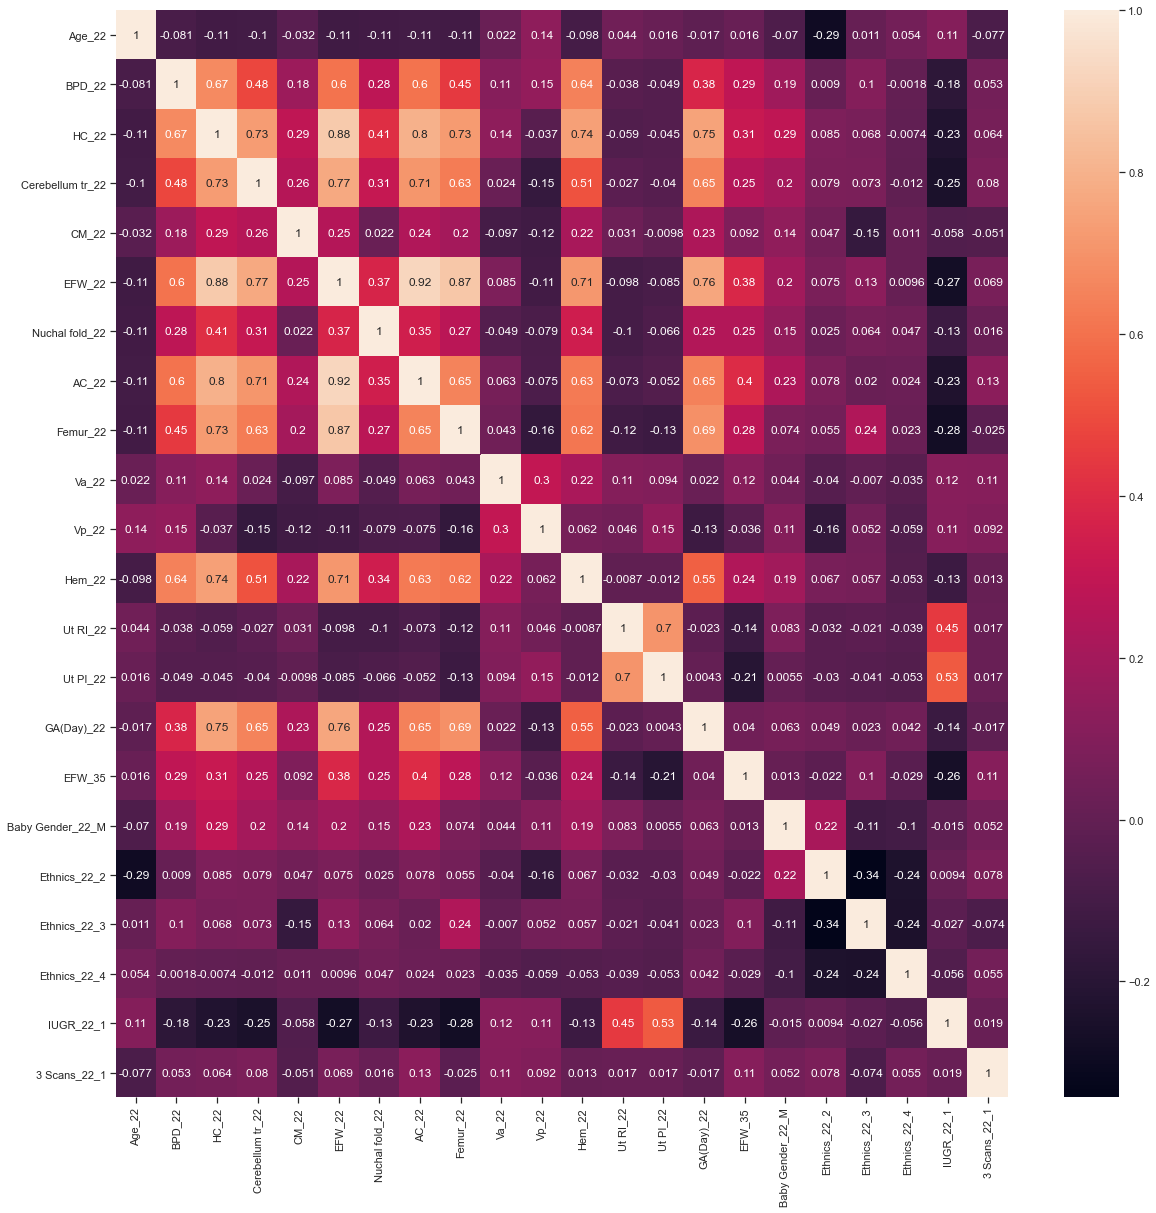

In [71]:
plot_heat_map(X)

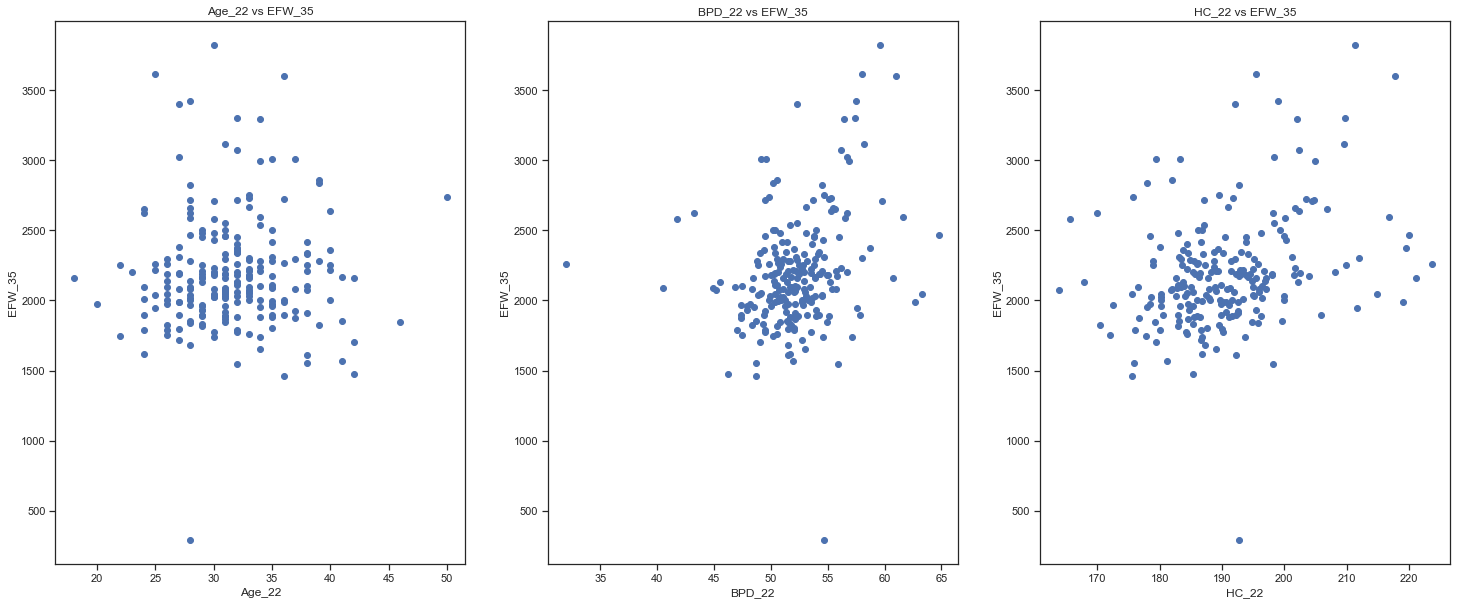

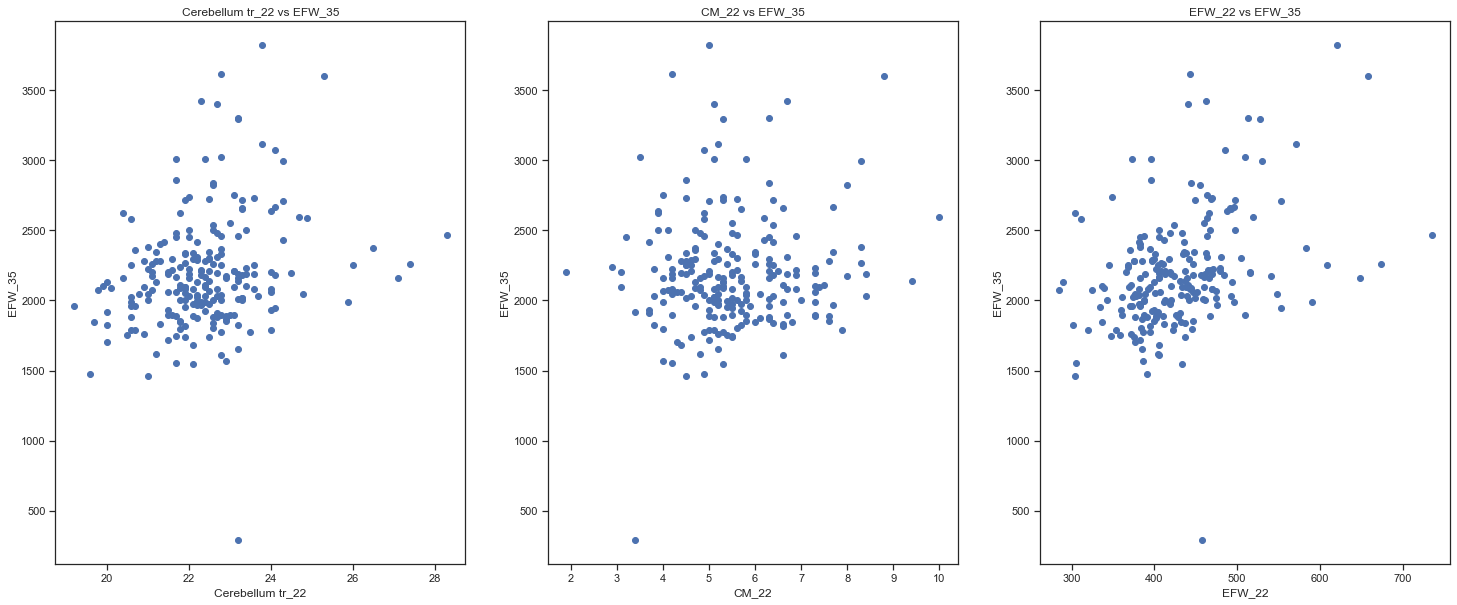

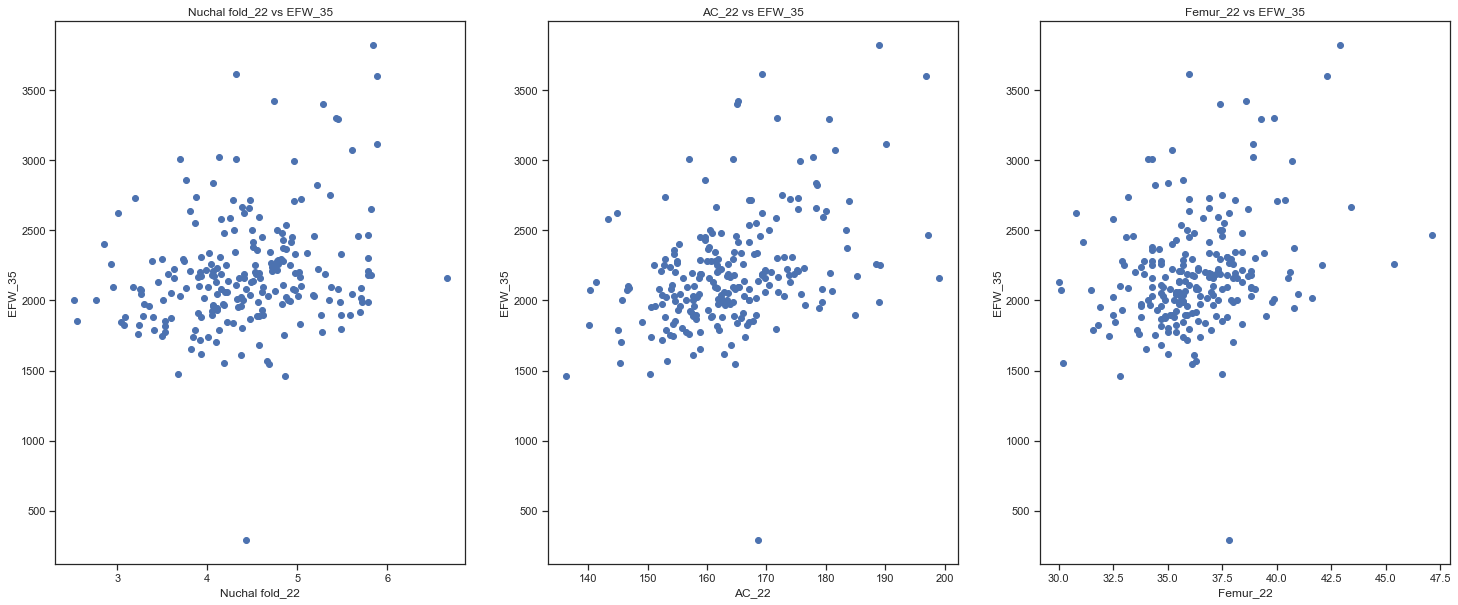

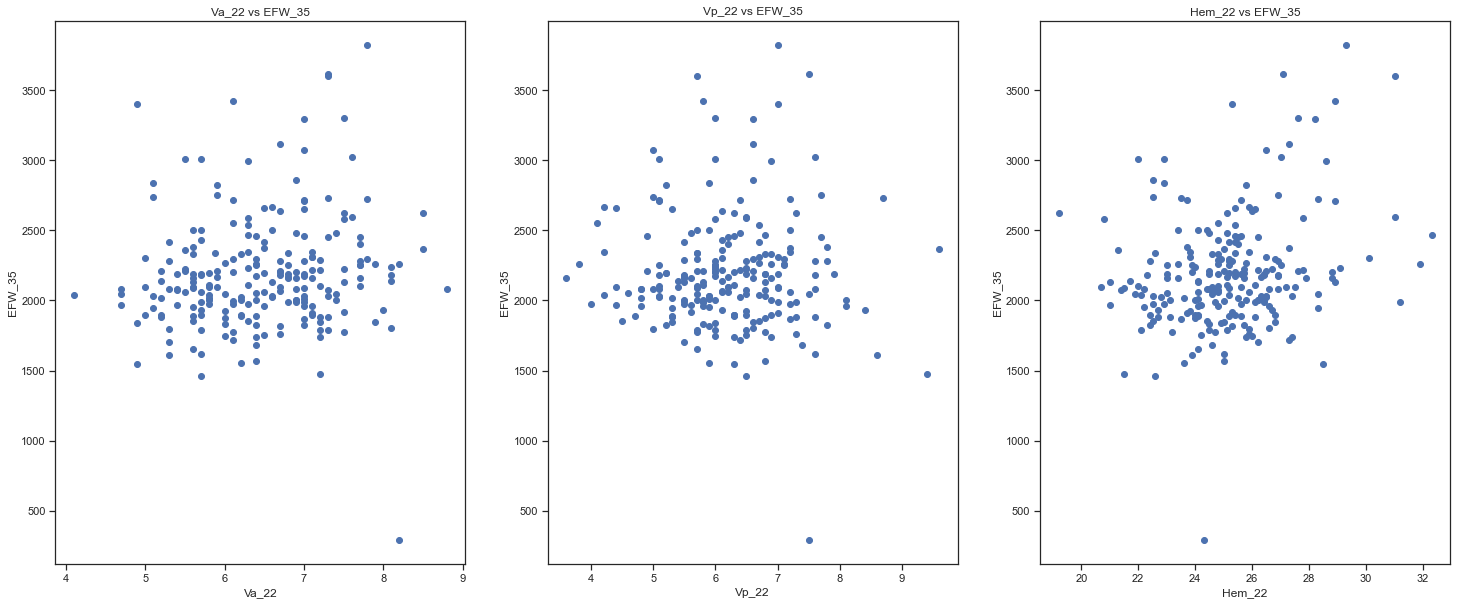

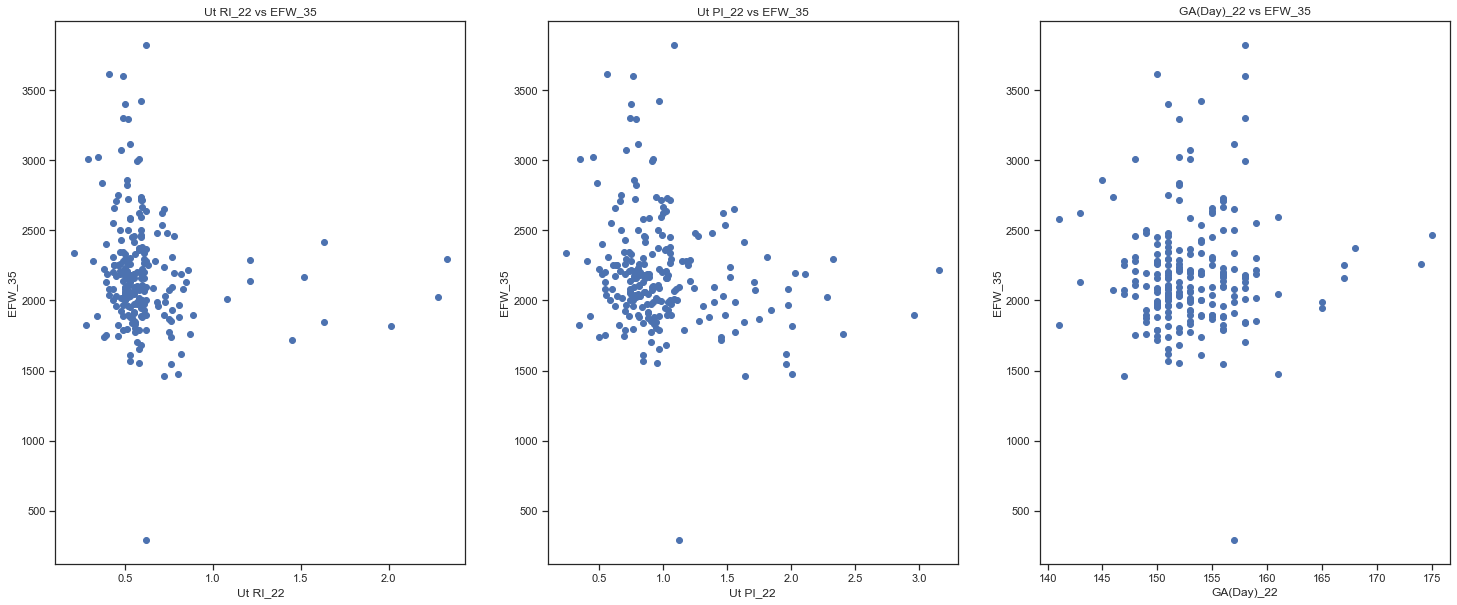

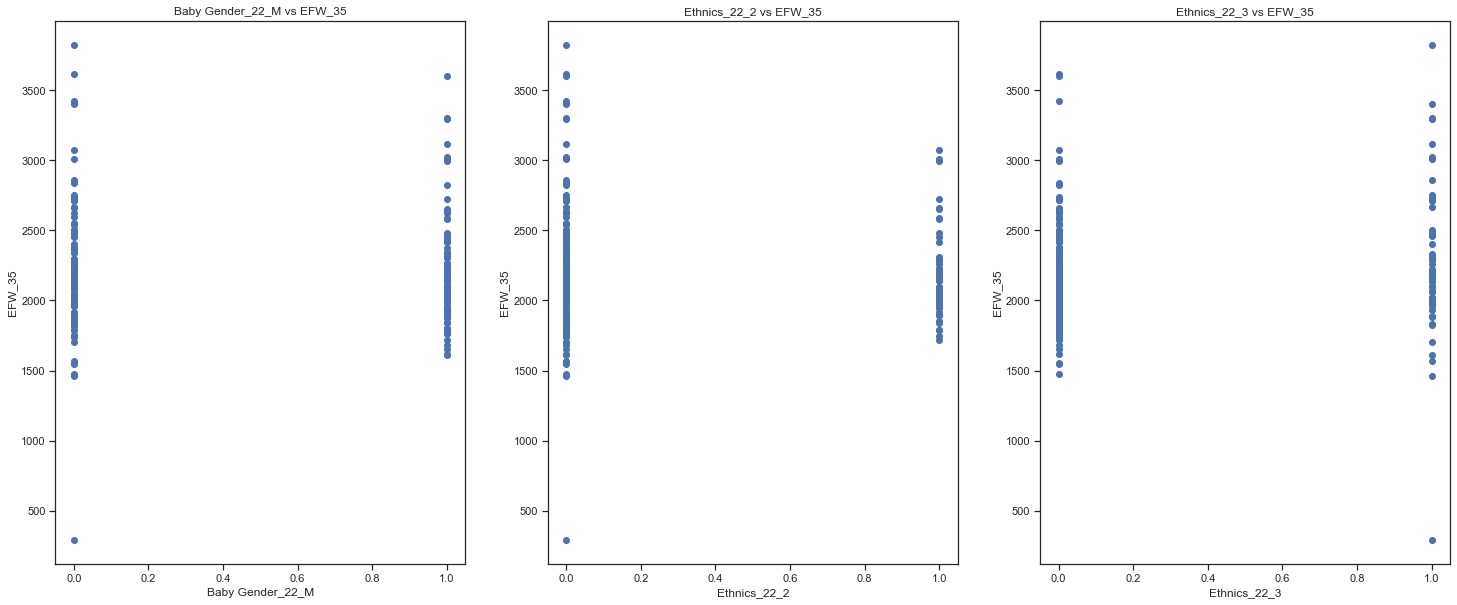

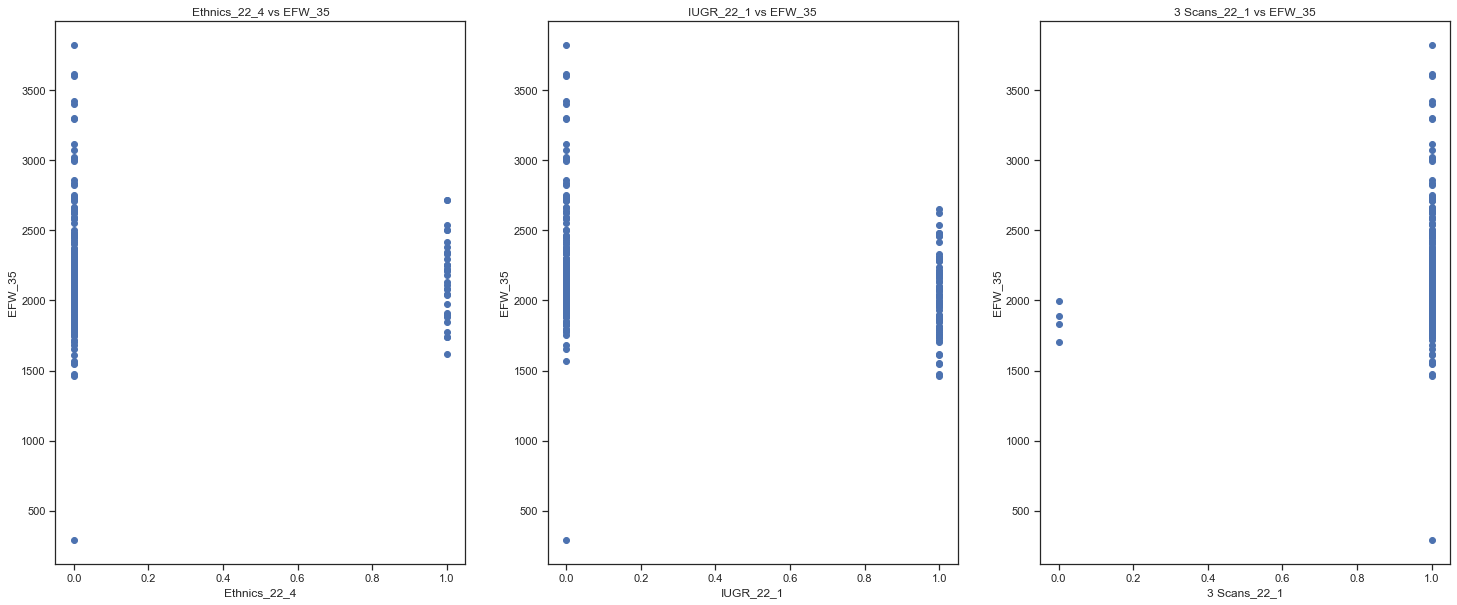

In [27]:
features_graph(X)

In [156]:
#backward elim
SL = 0.05
X_22_35, columns_drop_list = backward_elimination(X.drop(label_name, axis=1), X[label_name],  SL, const=True)

#add y into X_Modeled
X_22_35[label_name] = X[label_name]
print('\ncolumns to be dropped:\n', columns_drop_list)

                            OLS Regression Results                            
Dep. Variable:                 EFW_35   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     10.54
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           3.19e-16
Time:                        18:01:00   Log-Likelihood:                -1603.9
No. Observations:                 223   AIC:                             3234.
Df Residuals:                     210   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_22               8.8826      4.843  

In [157]:
X_22_35

Age_22  HC_22  EFW_22  Nuchal fold_22  Femur_22  Va_22  Ut RI_22  \
2        26  186.0     410            2.93      34.7    7.9      0.47   
5        36  217.8     658            5.88      42.3    7.3      0.49   
7        30  193.7     437            3.84      36.5    6.4      0.76   
9        37  192.5     397            4.05      35.4    6.0      0.48   
10       32  193.8     456            5.82      38.8    5.7      0.54   
..      ...    ...     ...             ...       ...    ...       ...   
339      32  185.5     377            3.93      35.3    5.2      0.53   
341      29  186.1     405            4.78      35.9    6.6      0.52   
342      29  172.5     383            4.19      34.2    4.7      0.49   
345      29  221.1     648            6.66      40.5    6.9      0.55   
346      32  188.8     436            4.31      38.4    7.1      0.49   

     Ut PI_22  GA(Day)_22  Baby Gender_22_M  IUGR_22_1  const  Hem_22  EFW_35  
2        0.70         152                 1          0      1    23.4  2261.0  
5        0.76         158                 1          0      1    31.0  3603.0  
7        1.45         154                 0          1      1    27.4  1737.0  
9        0.70         153                 1          0      1    23.8  1922.0  
10       0.85         156                 1          0      1    22.3  2181.0  
..        ...         ...               ...        ...    ...     ...     ...  
339      0.81         151                 0          0      1    22.7  1879.0  
341      0.80         149                 0          0      1    23.4  2501.0  
342      0.71         151                 0          0      1    21.0  1966.0  
345      0.86         167                 1          0      1    28.8  2161.0  
346      0.73         151                 0          0      1    23.8  2349.0  

[223 rows x 14 columns]

In [158]:
#cross validate the model to check - backward eli
#cross_validate_models(models, columns, df_32_X), columns = list of y you wanna predict, return a dict as a result

#Initial model setup
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          RandomForestRegressor(n_estimators = 10, random_state = 42),
          AdaBoostRegressor(random_state=42, n_estimators=50), 
          GradientBoostingRegressor(n_estimators = 50, random_state = 42), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=0.5, epsilon=0.1)),
          KNeighborsRegressor(n_neighbors=5)
         ]
#cv
cross_validate_models(models, X_22_35, label_name)

Cross validation Result for EFW_35:


Models   test_r2  train_r2  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...  0.254862  0.383917   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.257205  0.381906   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.230255  0.323961   
3  RandomForestRegressor(bootstrap=True, ccp_alph... -0.077803  0.833730   
4  AdaBoostRegressor(base_estimator=None, learnin...  0.041350  0.630015   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha... -0.007459  0.835319   
6  (StandardScaler(copy=True, with_mean=True, wit...  0.029013  0.064466   
7  KNeighborsRegressor(algorithm='auto', leaf_siz... -0.049123  0.328893   

   test_neg_rmse  train_neg_rmse       y_mean  
0    -338.646215     -318.979262  2192.439462  
1    -338.634122     -319.499229  2192.439462  
2    -347.492090     -334.192660  2192.439462  
3    -405.736793     -165.162124  2192.439462  
4    -384.186906     -247.166527  2192.439462  
5    -393.427834     -164.722368  2192.439462  
6    -392.653009     -393.318949  2192.439462  
7    -403.551251     -332.982526  2192.439462

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with test_r2 score: 0.25720496951453165


## Predict Wk35 fetal weight using Wk32 data
- However, I found out that the prediction of wk35 using wk22+wk32 data is the best

In [110]:
#test features and train model
label_name = 'EFW_35'

#random forest regressor - no need scale/normalize data, but need to turn them to 1-hot encoding
df_train = df_32

#only 224 rows existed in df_35[EFW]
#hence, use merge
df_train = df_train.merge(df_35[label_name], left_index= True, right_index=True) #join based on left index and right index
#drop the outliers- None

#1-hot encoding
X = pd.get_dummies(df_train, drop_first=True)
# y = df_train['EFW']
# #drop the EFW from X
# X.drop('EFW', axis=1, inplace=True)

In [44]:
X

HC_32  AC_32  FEMUR_32  EFW_32  HC/AC_32  FL/HC_32  FL/AC_32     AFI_32  \
2    289.9  274.3      57.6  1709.0      1.06      0.20      0.21  13.100000   
5    318.0  334.3      64.3  2790.0      0.95      0.20      0.19  12.437663   
7    289.2  249.3      55.5  1423.0      1.16      0.19      0.22  13.500000   
9    276.9  251.7      56.1  1415.0      1.10      0.20      0.22  12.505170   
10   275.7  244.0      55.6  1336.0     14.13      0.20      0.23  13.100000   
..     ...    ...       ...     ...       ...       ...       ...        ...   
339  278.3  260.0      57.2  1519.0      1.07      0.21      0.22   9.400000   
341  283.2  273.5      62.4  1805.0      1.04      0.22      0.23  12.781041   
342  274.0  248.4      58.0  1425.0      1.10      0.21      0.23  11.800000   
345  291.3  273.0      59.6  1757.0      1.07      0.20      0.22  15.300000   
346  294.4  277.3      61.5  1868.0      1.06      0.21      0.22   7.600000   

     Umb RI_32  Umb S/D_32  GA(Day)_32  HC_GA_32  EFW_35  IUGR_32_1.0  
2         0.67        3.06       228.0  1.271491  2261.0            0  
5         0.57        2.30       224.0  1.419643  3603.0            0  
7         0.72        3.56       217.0  1.332719  1737.0            0  
9         0.56        2.27       222.0  1.247297  1922.0            1  
10        0.57        2.35       205.0  1.344878  2181.0            0  
..         ...         ...         ...       ...     ...          ...  
339       0.55        2.24       224.0  1.242411  1879.0            1  
341       0.72        3.60       226.0  1.253097  2501.0            0  
342       0.63        2.67       217.0  1.262673  1966.0            0  
345       0.56        2.26       224.0  1.300446  2161.0            0  
346       0.62        2.61       228.0  1.291228  2349.0            0  

[218 rows x 14 columns]

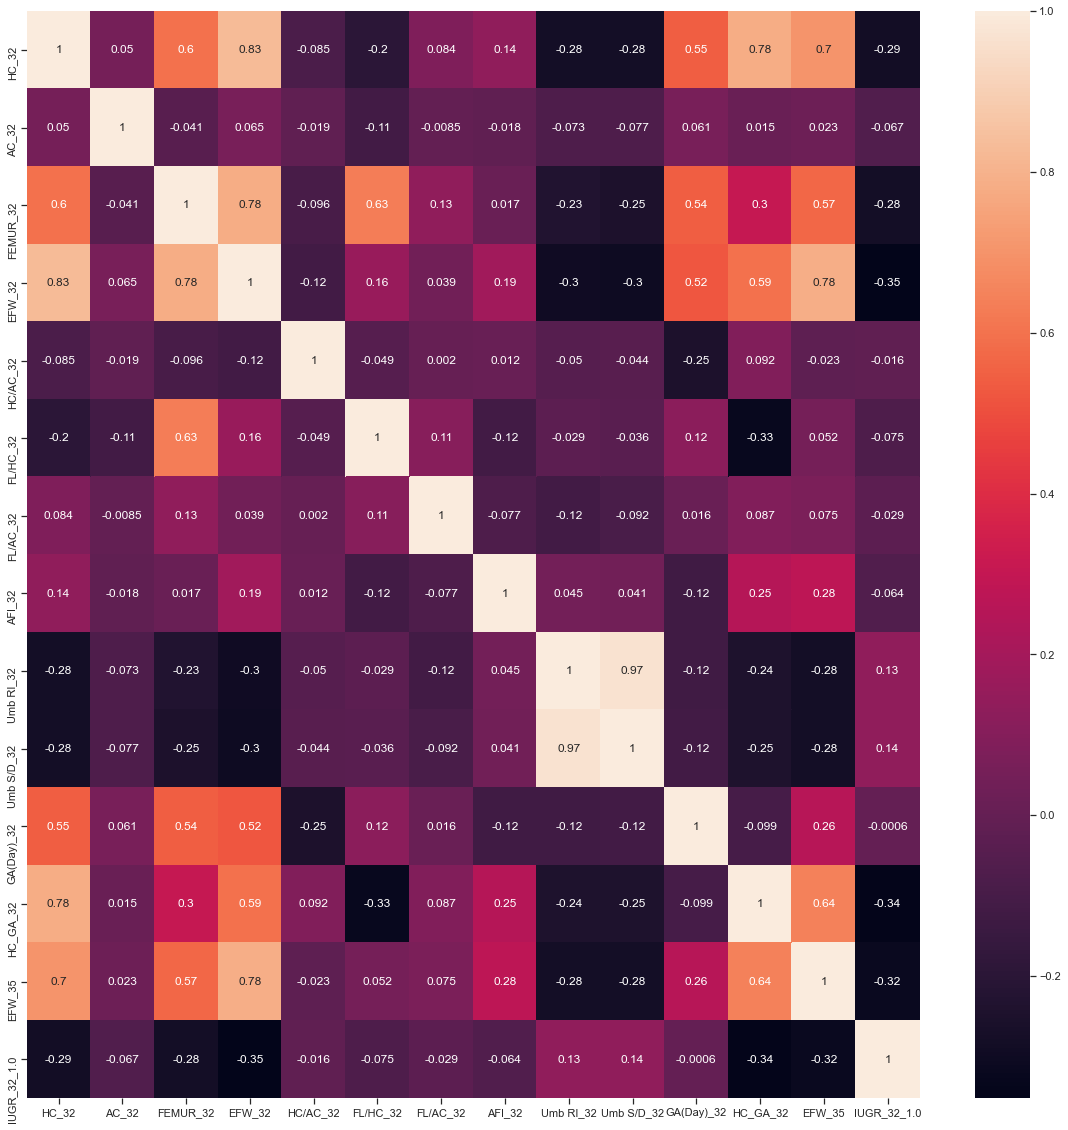

In [45]:
plot_heat_map(X)

IndexError: index 1 is out of bounds for axis 0 with size 1

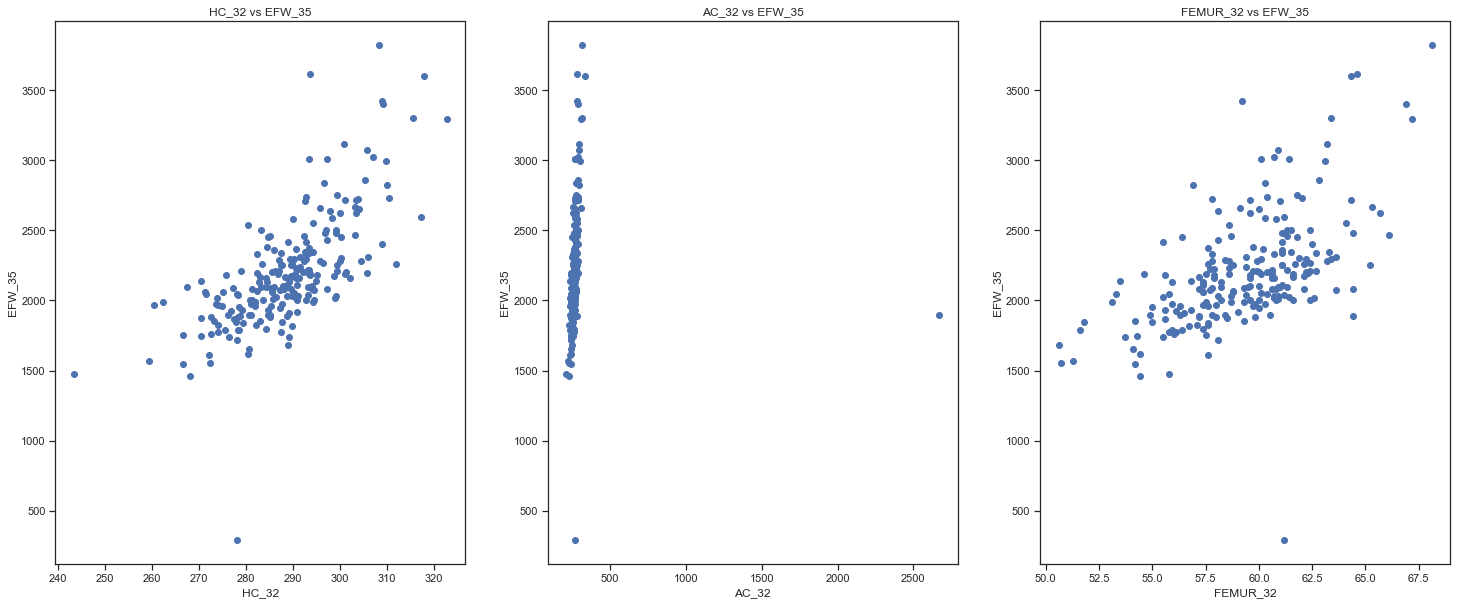

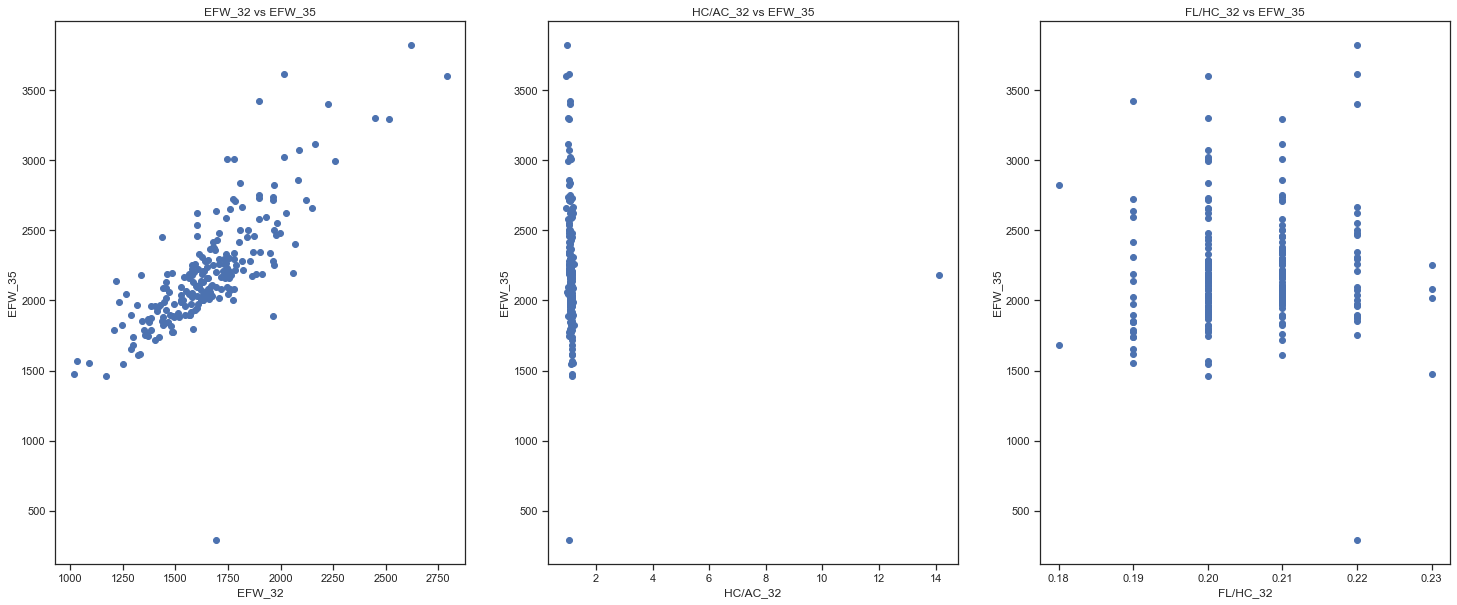

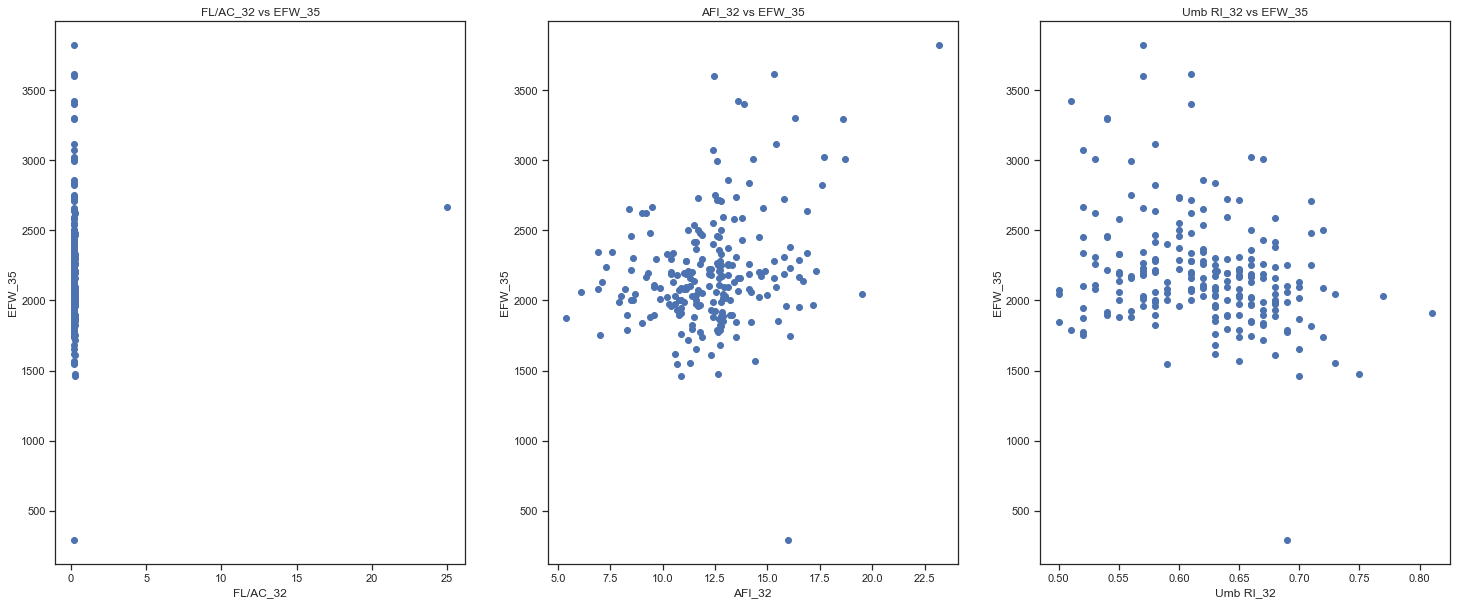

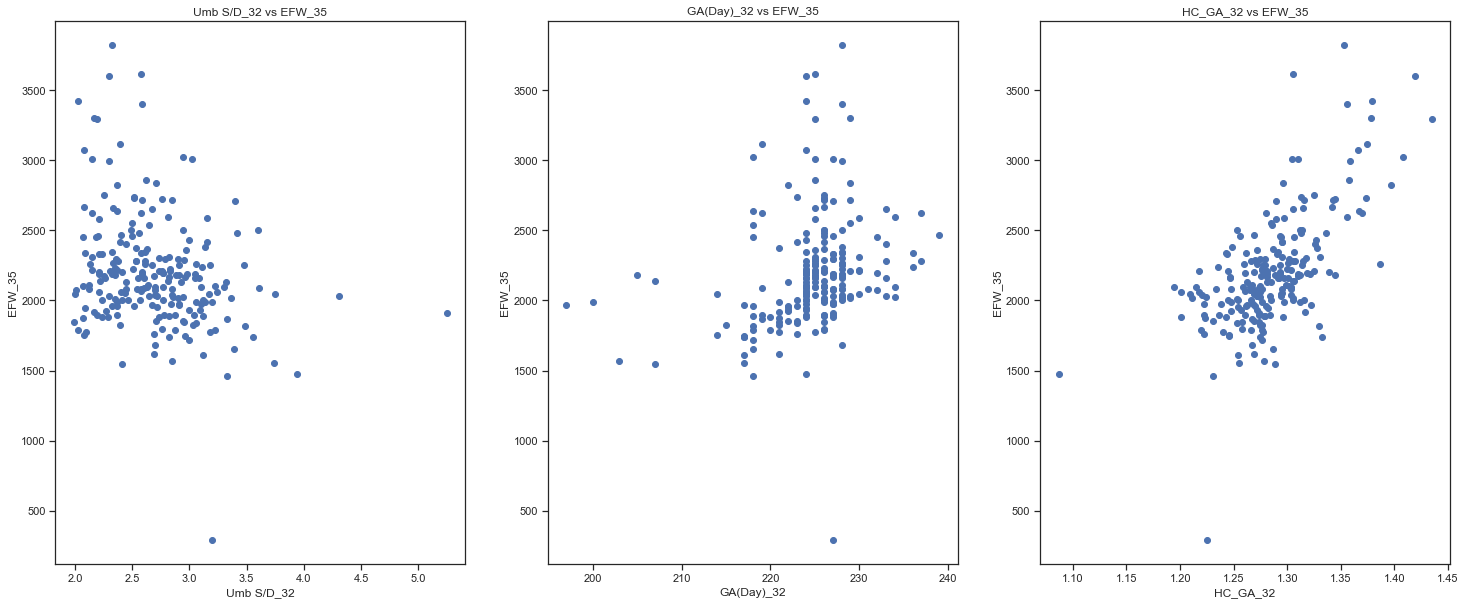

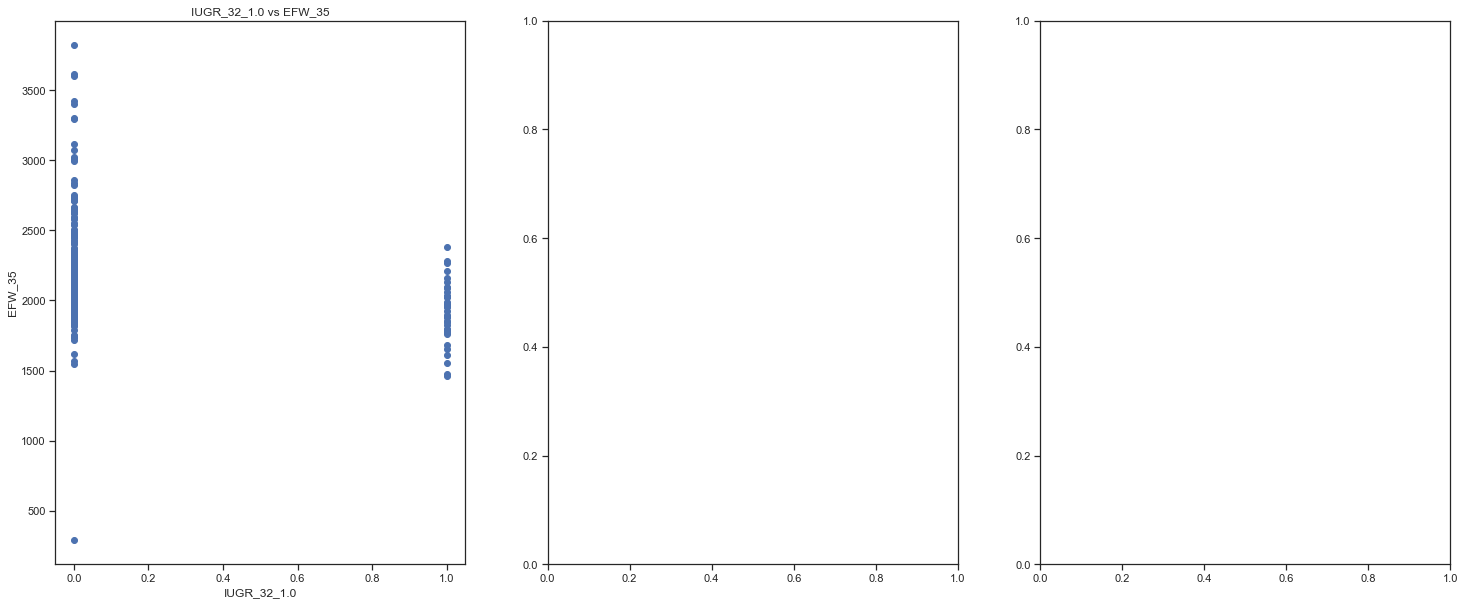

In [46]:
features_graph(X)

In [47]:
#stepwise
col_stepwise = stepwise_selection(X.drop(label_name, axis=1), X[label_name])
col_stepwise.append(label_name)
print('columns used in stepwise:')
print(col_stepwise)

['EFW_32']
['EFW_32', 'HC_GA_32']
['EFW_32', 'HC_GA_32', 'AFI_32']
columns used in stepwise:
['EFW_32', 'HC_GA_32', 'AFI_32', 'EFW_35']


c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

In [48]:
#back elimination better than feature importance analysis (r2 results)
SL = 0.05
X_32_35, columns_drop_list = backward_elimination(X.drop(label_name, axis=1), X[label_name],  SL)

#add y into X_Modeled
X_32_35[label_name] = X[label_name]
print('\ncolumns to be dropped:\n', columns_drop_list)

                                 OLS Regression Results                                
Dep. Variable:                 EFW_35   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              2803.
Date:                Mon, 17 May 2021   Prob (F-statistic):                   2.38e-204
Time:                        13:57:15   Log-Likelihood:                         -1495.6
No. Observations:                 218   AIC:                                      3005.
Df Residuals:                     211   BIC:                                      3029.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [306]:
#using knn impute : test_r2 score: 0.647337572446456
#using GAN imputer: test_r2 score: 0.6495899669300248

#initial model setup
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          RandomForestRegressor(n_estimators = 10, random_state = 42),
          AdaBoostRegressor(random_state=42, n_estimators=50), 
          GradientBoostingRegressor(n_estimators = 50, random_state = 42), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=10, epsilon=10, gamma='scale', )), 
          KNeighborsRegressor(n_neighbors=5)
         ]
#cv
#After dropping columns - without const r2=0.5748540545598322, after dropping ethics: 0.5788139048963803
print('Prediction of WK35 using WK32 backward elimination.')
cross_validate_models(models, X_32_35, label_name)

Prediction of WK35 using WK32 backward elimination.
Cross validation Result for EFW_35:


Models   test_r2  train_r2  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...  0.649568  0.685583   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.649590  0.682486   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.641484  0.664758   
3  RandomForestRegressor(bootstrap=True, ccp_alph...  0.511438  0.923440   
4  AdaBoostRegressor(base_estimator=None, learnin...  0.562562  0.845714   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...  0.513499  0.933497   
6  (StandardScaler(copy=True, with_mean=True, wit...  0.645312  0.662779   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...  0.507737  0.702061   

   test_neg_rmse  train_neg_rmse       y_mean  
0    -231.880034     -228.196564  2200.417431  
1    -232.087915     -229.327098  2200.417431  
2    -235.786315     -235.692667  2200.417431  
3    -272.617345     -112.004162  2200.417431  
4    -259.411401     -159.757577  2200.417431  
5    -269.749375     -104.912298  2200.417431  
6    -234.282525     -236.362354  2200.417431  
7    -272.102447     -222.093357  2200.417431

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with test_r2 score: 0.6495899669300248


In [307]:
#using KNN - stepwise elimination r2=0.6548485936167474
#using GAN - test_r2 score: 0.6564349296435553
print('Prediction of WK35 using WK32 stepwise elimination.')
cross_validate_models(models, X[col_stepwise], label_name)

Prediction of WK35 using WK32 stepwise elimination.
Cross validation Result for EFW_35:


Models   test_r2  train_r2  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...  0.653363  0.676670   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.653458  0.676593   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...  0.651788  0.666152   
3  RandomForestRegressor(bootstrap=True, ccp_alph...  0.524881  0.924525   
4  AdaBoostRegressor(base_estimator=None, learnin...  0.511507  0.841382   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...  0.566992  0.921819   
6  (StandardScaler(copy=True, with_mean=True, wit...  0.656435  0.667289   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...  0.456171  0.677056   

   test_neg_rmse  train_neg_rmse       y_mean  
0    -230.706618     -231.427574  2200.417431  
1    -230.740670     -231.455075  2200.417431  
2    -232.635580     -235.205903  2200.417431  
3    -269.371230     -111.140782  2200.417431  
4    -271.694643     -161.962286  2200.417431  
5    -257.370409     -113.764981  2200.417431  
6    -230.728995     -234.773317  2200.417431  
7    -283.851069     -231.086536  2200.417431

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with test_r2 score: 0.6564349296435553


### SVR, LR, Lasso, Ridge - For Stepwise

In [311]:
#General params
cv = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42)

#### Stepwise tune

In [312]:
#svr
svr_best_params_stepwise = svr_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 240 candidates, totalling 18000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1814s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0180s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0389s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0738s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1636s.) Setting batch_size=32.
[Parallel(n_jobs=4)]: Done 396 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Don

Best Score: -154.93000450359344
Best Hyperparameters: {'clf__C': 1000, 'clf__epsilon': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


[Parallel(n_jobs=4)]: Done 17929 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done 18000 out of 18000 | elapsed:   37.9s finished


In [313]:
#lr
lr_best_params_stepwise = linear_regression_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 4 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1729s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=8.


Best Score (neg_mean_absolute_error): -156.26898285583474
Best Hyperparameters: {'normalize': False, 'fit_intercept': True}


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0628s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.5s finished


In [314]:
#ridge
ridge_best_params_stepwise = ridge_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0379s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0638s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1406s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.3s
[Parallel(n

Best Score in neg_root_mean_squared_error: -229.88189973074597
Best Hyperparameters: {'alpha': 0.053121562366700195, 'fit_intercept': True, 'normalize': False, 'solver': 'cholesky'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.8min finished


In [315]:
#Lasso
lasso_best_params_stepwise = lasso_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0130s.) Setting batch_size=2.


Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0429s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0449s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1207s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1356s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1520 tasks      |

Best Score: -155.6886407123607
Best Hyperparameters: {'alpha': 0.5579310595219891, 'fit_intercept': True, 'normalize': False, 'selection': 'random'}


In [316]:
#-----------------------using KNN ------------------ test_r2 score: 0.6543531274172582
#svr
#'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

#ridge
#{'alpha': 0.056496042087489935, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'}

#lasso
#'alpha': 0.5579310595219891, 'fit_intercept': True, 'normalize': False, 'selection': 'random'

# #knn imputer best parameters: test_r2 score: 0.660157971179986
# models = [make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
#           LinearRegression(normalize=True, fit_intercept=False), 
#           Ridge(alpha=0.056496042087489935,fit_intercept=True, normalize=False, solver='auto'),
#           Lasso(alpha=0.5579310595219891, fit_intercept=True, normalize=False, selection='random'),
#          ]

# cross_validate_models(models, X[col_stepwise], label_name)


#-----------------------------using GAN ----------------------- test_r2 score: 
#svr
#'clf__C': 1000, 'clf__epsilon': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'

#lr
#'normalize': False, 'fit_intercept': True

#ridge
#'alpha': 0.053121562366700195, 'fit_intercept': True, 'normalize': False, 'solver': 'cholesky'

#lasso
#'alpha': 0.5579310595219891, 'fit_intercept': True, 'normalize': False, 'selection': 'random'


#GAN imputer best parameters:
models = [make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=10, gamma='scale')), 
          LinearRegression(normalize=True, fit_intercept=False), 
          Ridge(alpha=0.053121562366700195,fit_intercept=True, normalize=False, solver='cholesky'),
          Lasso(alpha=0.5579310595219891, fit_intercept=True, normalize=False, selection='random'),
         ]

cross_validate_models(models, X[col_stepwise], label_name)

#why test rmse < train rmse:
#https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error
'''
One possibility: If you are using dropout regularization layer in your network, it is reasonable that 
the validation error is smaller than training error. Because usually dropout is activated when training 
but deactivated when evaluating on the validation set. You get a more smooth (usually means better) function 
in the latter case.
'''


Cross validation Result for EFW_35:


Models   test_r2  train_r2  \
0  (StandardScaler(copy=True, with_mean=True, wit...  0.660158  0.672199   
1  LinearRegression(copy_X=True, fit_intercept=Fa...  0.615924  0.635335   
2  Ridge(alpha=0.053121562366700195, copy_X=True,...  0.654229  0.674818   
3  Lasso(alpha=0.5579310595219891, copy_X=True, f...  0.652423  0.675012   

   test_neg_rmse  train_neg_rmse       y_mean  
0    -228.067596     -233.016063  2200.417431  
1    -241.503174     -245.734452  2200.417431  
2    -229.881900     -232.085613  2200.417431  
3    -230.538005     -232.022569  2200.417431

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with test_r2 score: 0.660157971179986


## Predict Wk35 fetal weight using Wk22+WK32 data

In [58]:
#test features and train model
label_name = 'EFW_35'

#random forest regressor - no need scale/normalize data, but need to turn them to 1-hot encoding
df_train = df_22_32

#only 224 rows existed in df_35[EFW]
#hence, use merge
df_train = df_train.merge(df_35[label_name], left_index= True, right_index=True) #join based on left index and right index
#drop the outliers [132,44,154]
df_train = df_train.drop([132,44,154])


#1-hot encoding
X = pd.get_dummies(df_train, drop_first=True)
# y = df_train['EFW']
# #drop the EFW from X
# X.drop('EFW', axis=1, inplace=True)

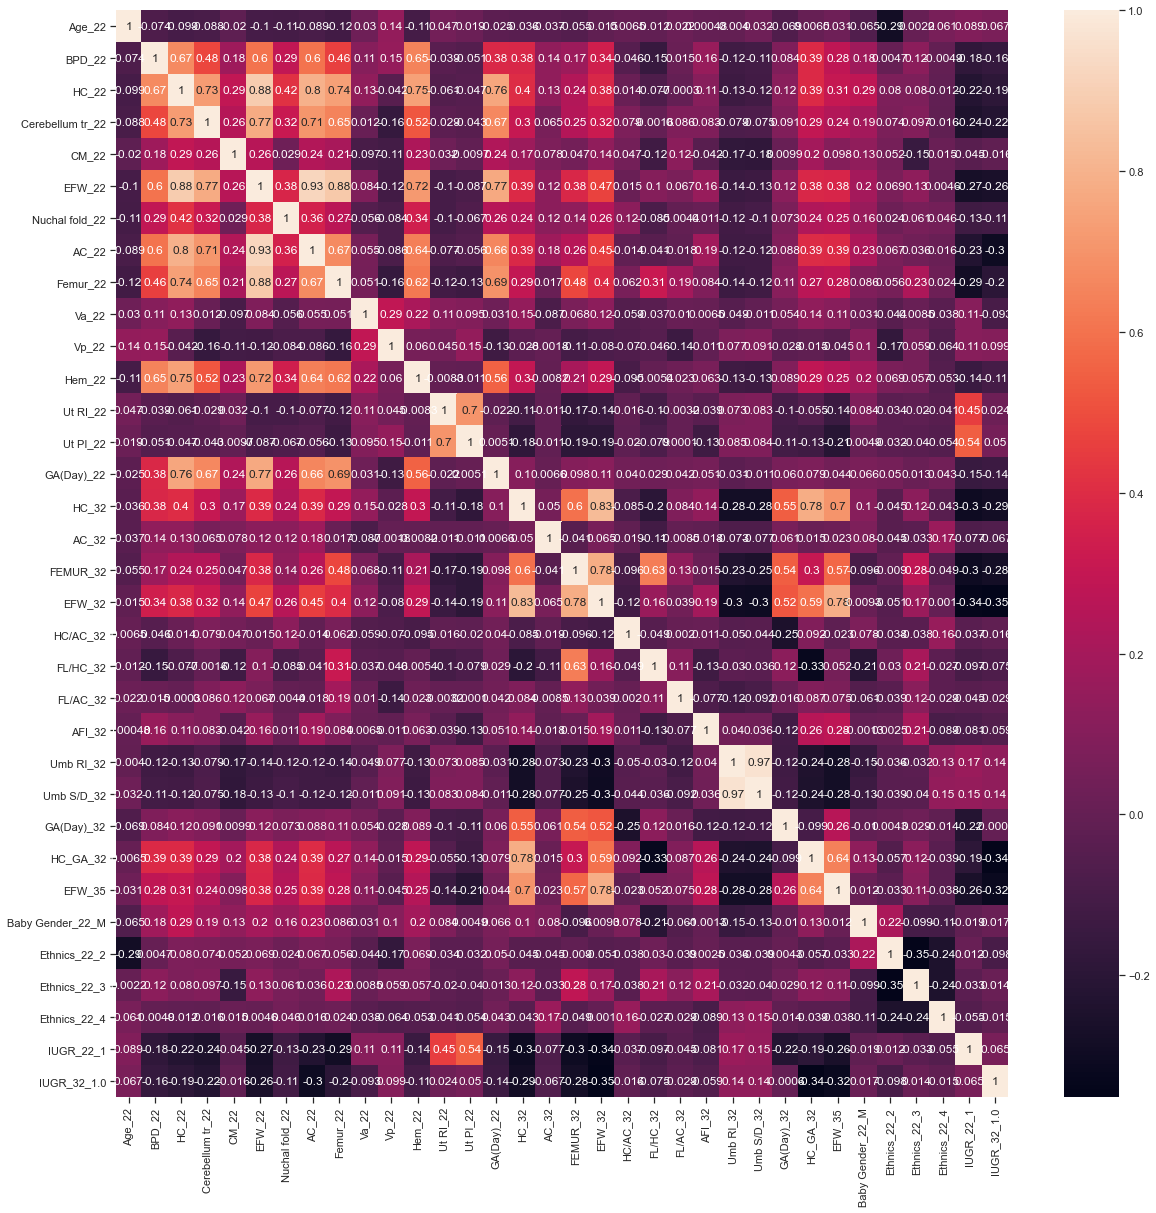

In [244]:
plot_heat_map(X)

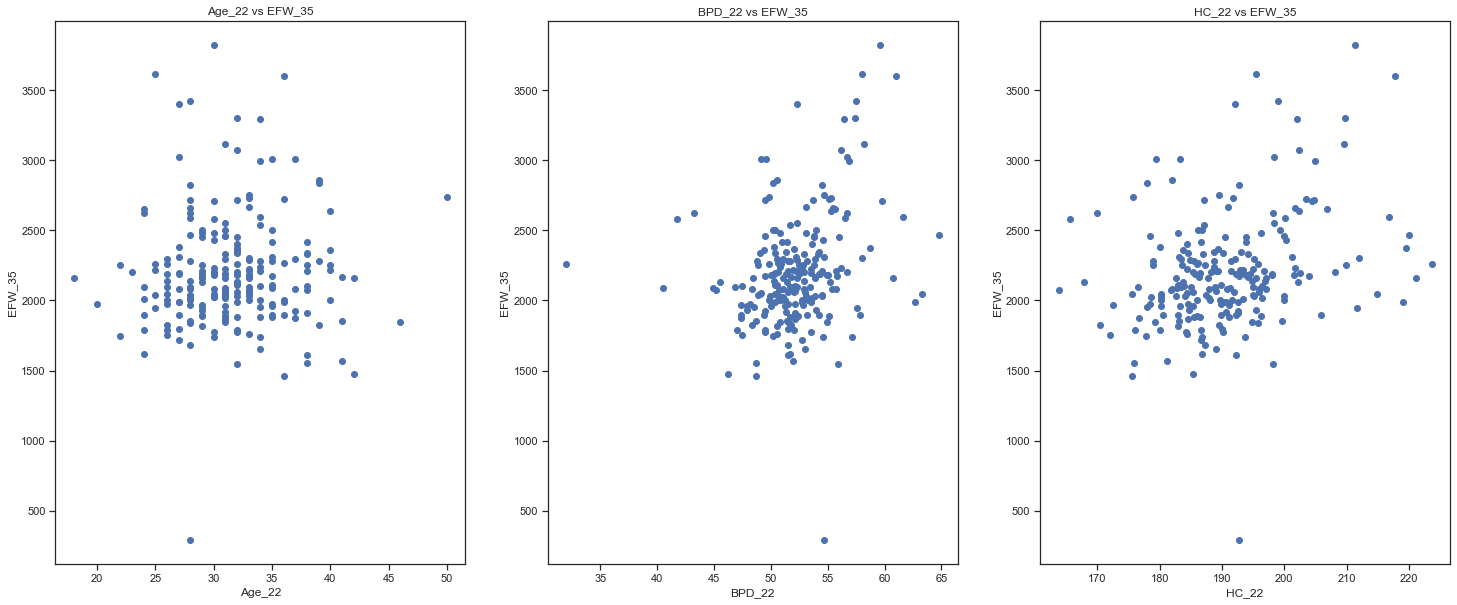

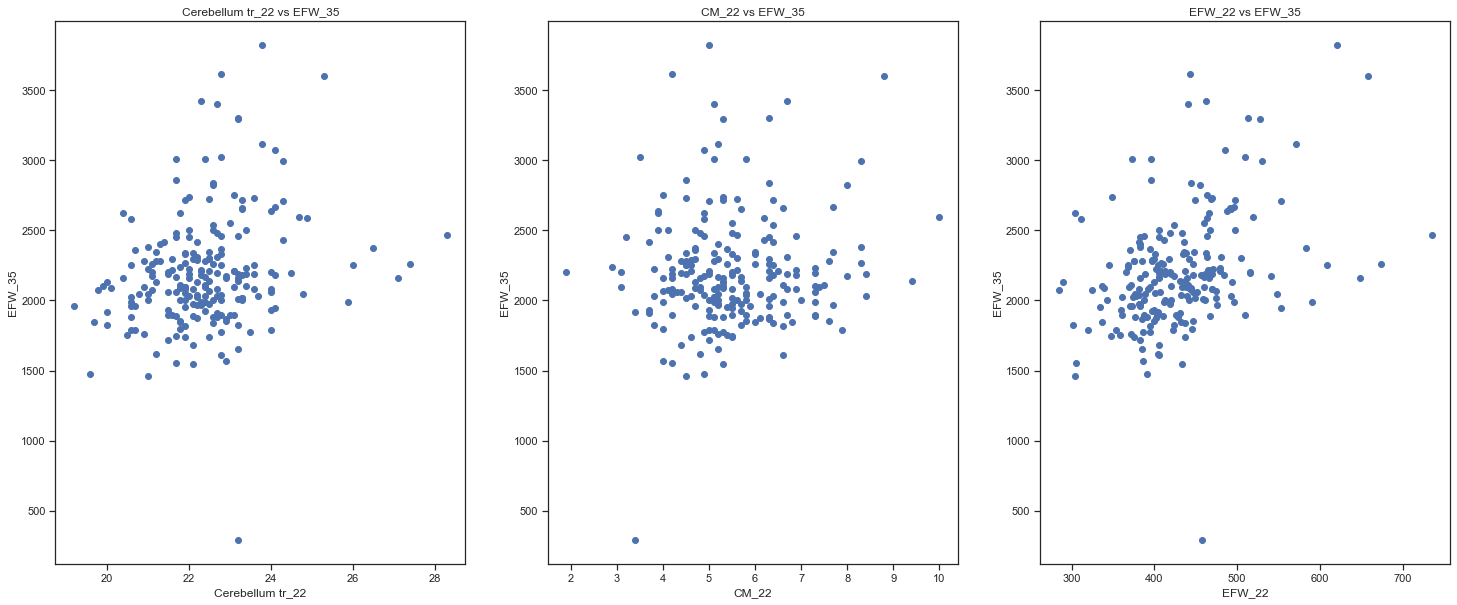

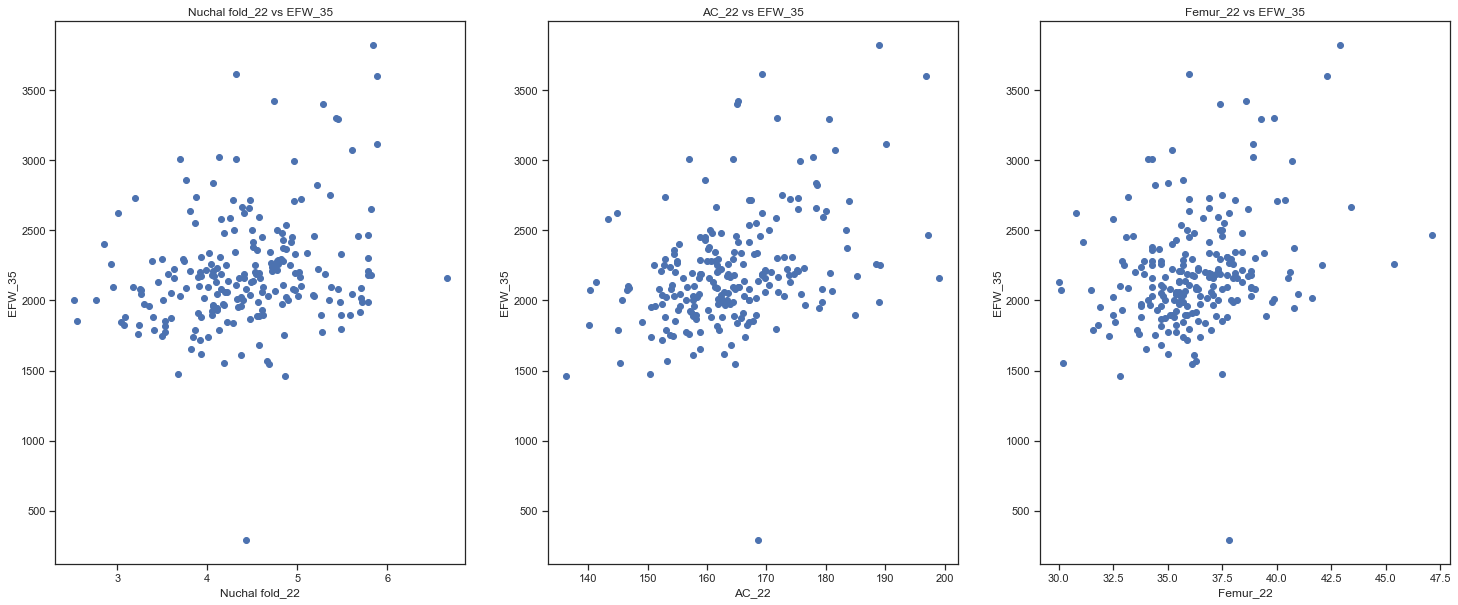

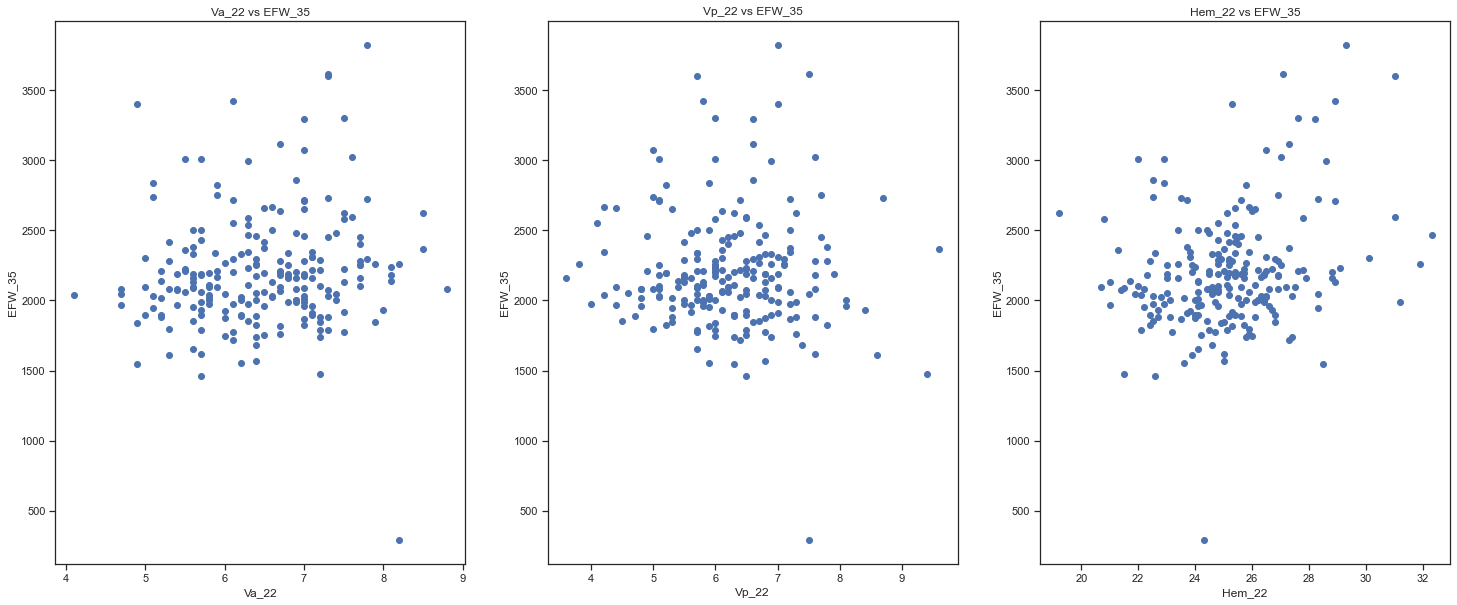

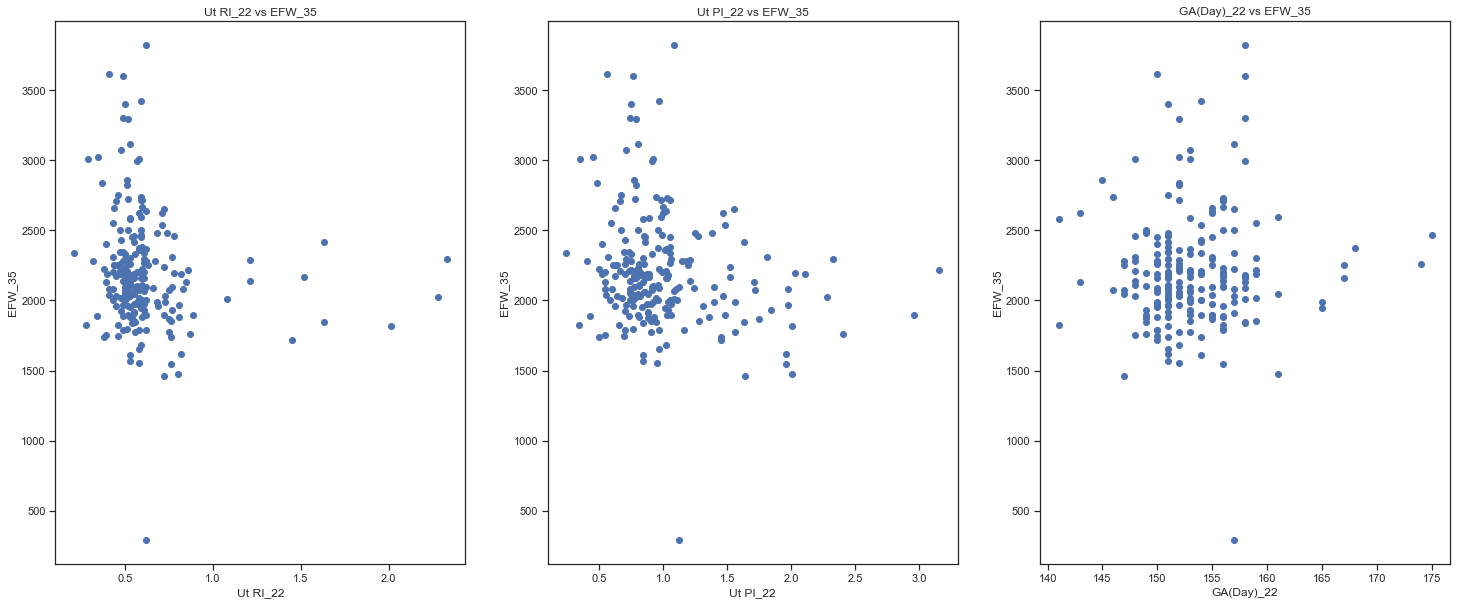

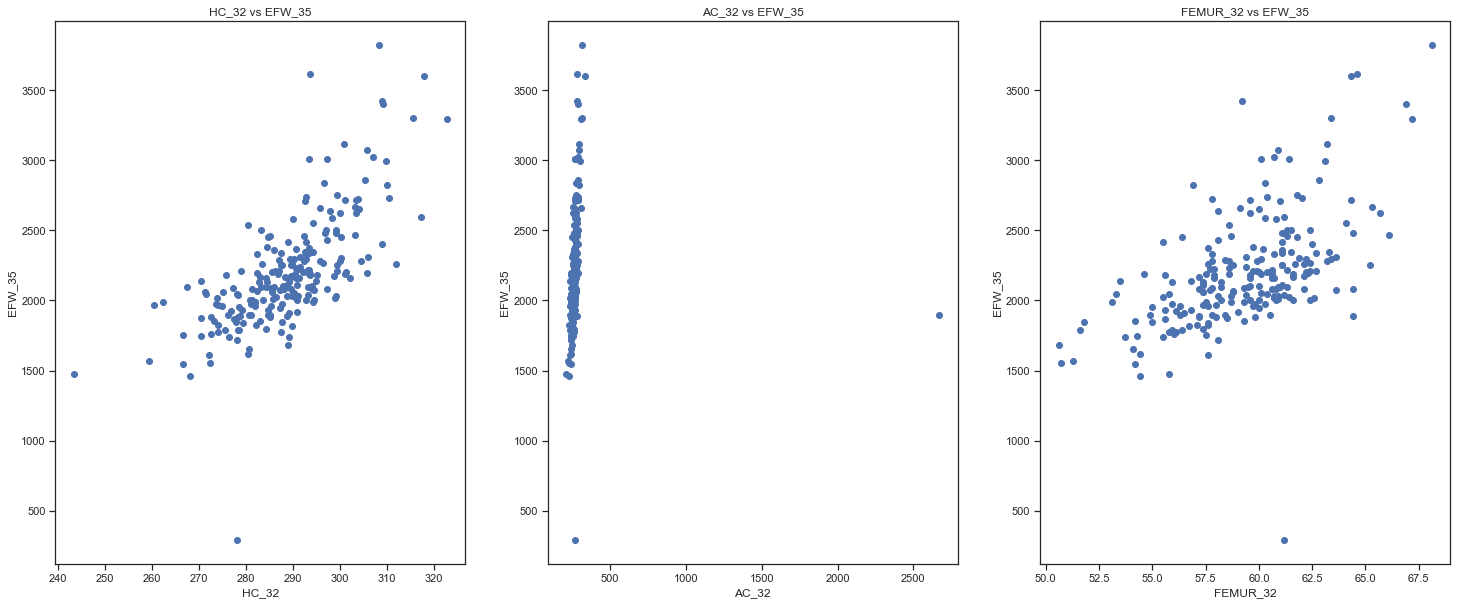

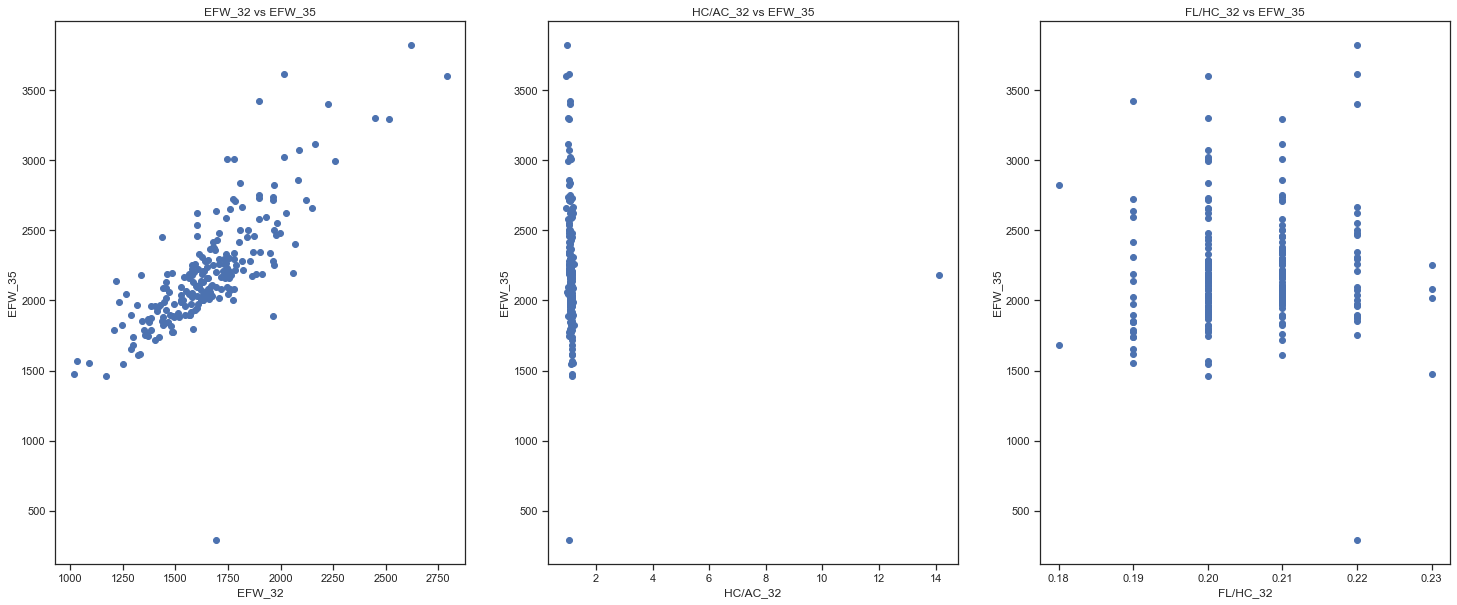

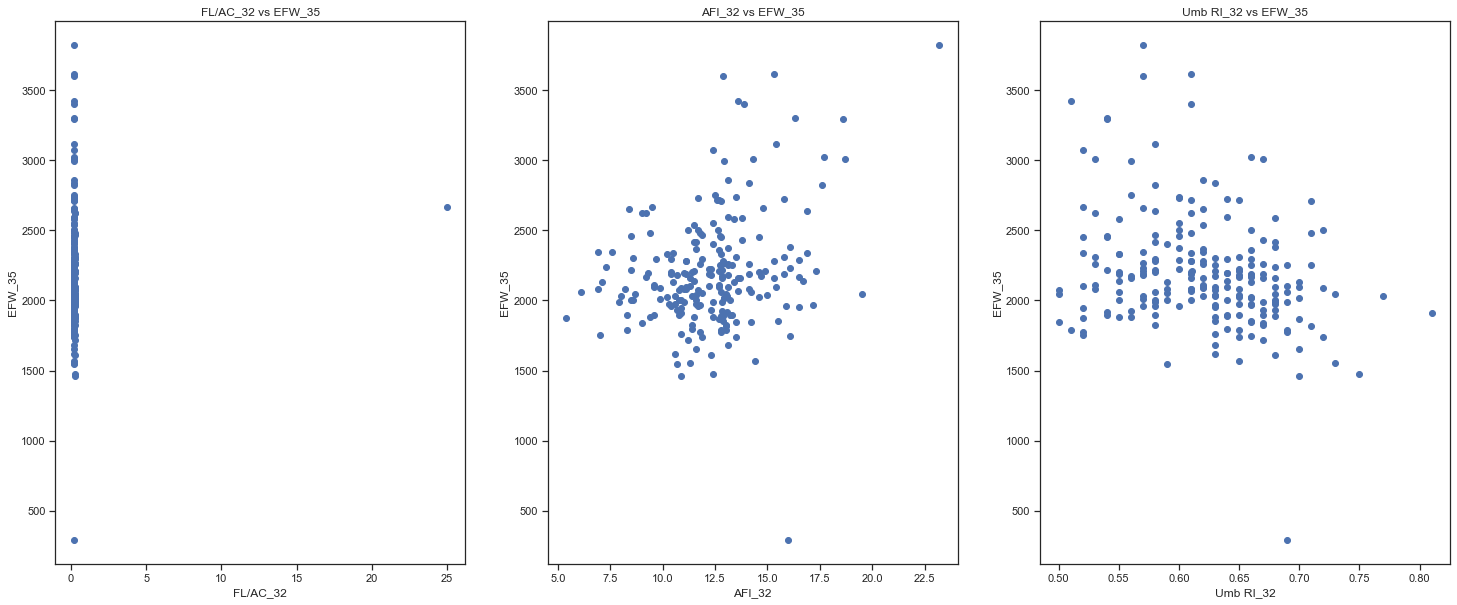

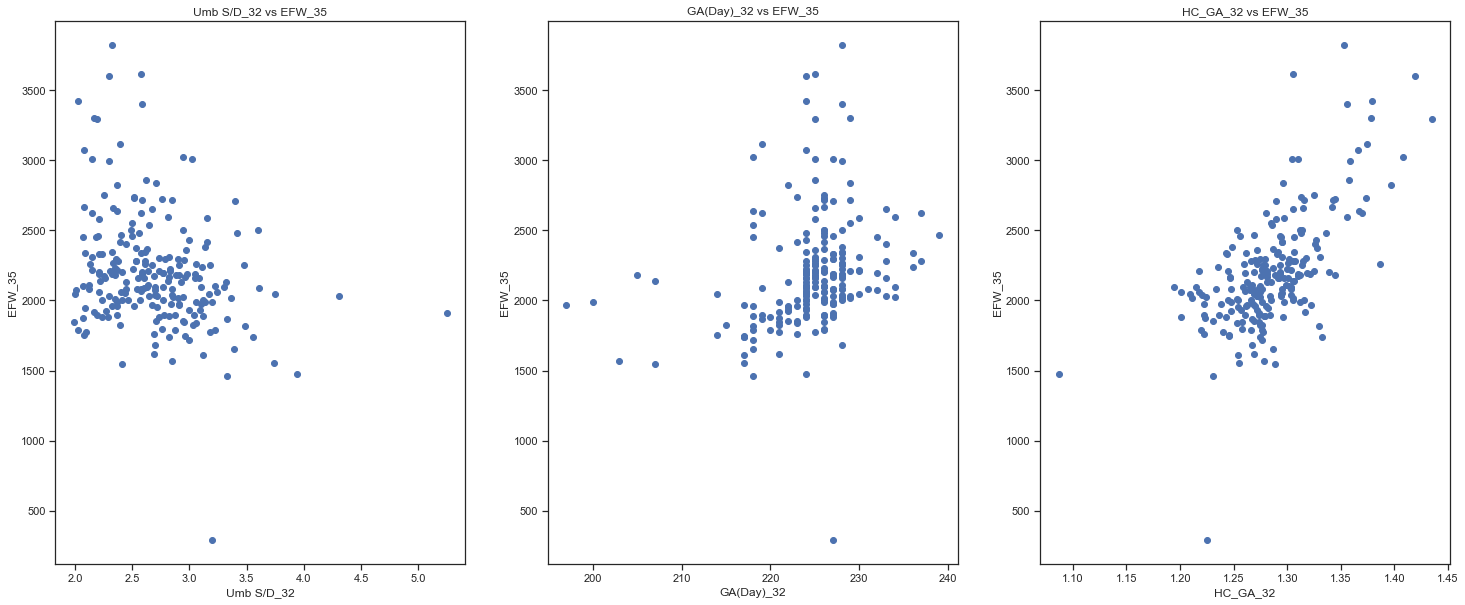

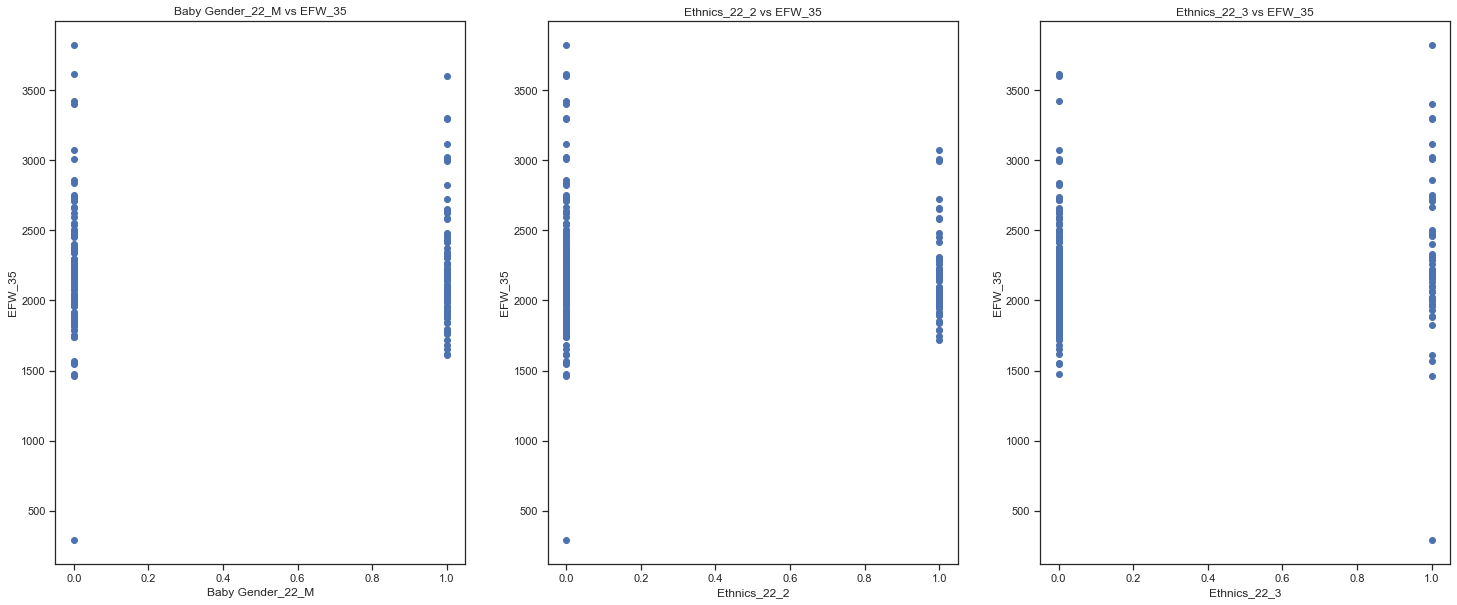

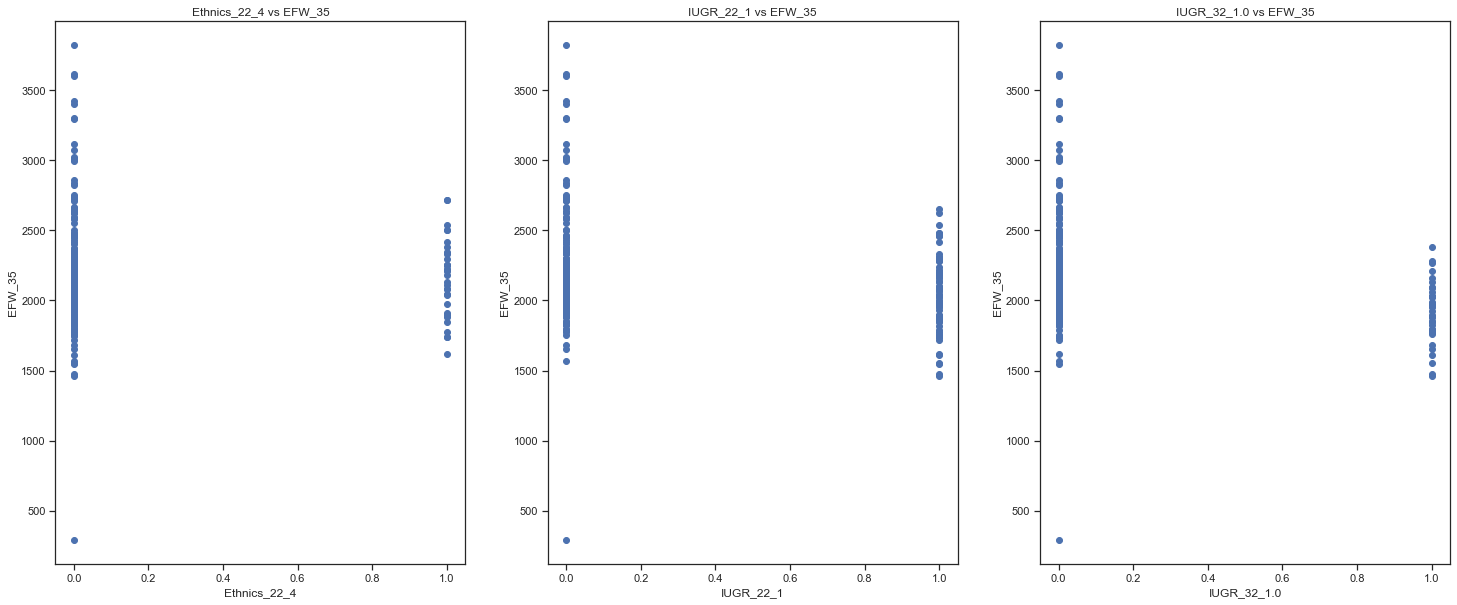

In [133]:
features_graph(X)

In [59]:
#stepwise
col_stepwise = stepwise_selection(X.drop(label_name, axis=1), X[label_name])
col_stepwise.append(label_name)

c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

['EFW_32']
['EFW_32', 'HC_GA_32']


c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

['EFW_32', 'HC_GA_32', 'AFI_32']
['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32']


c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\yi chong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis,

In [60]:
print('columns used:')
print(col_stepwise)

columns used:
['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'EFW_35']


In [124]:
# #back elimination better than feature importance analysis (r2 results)
# SL = 0.05
# X_2232_35, columns_drop_list = backward_elimination(X.drop(label_name, axis=1), X[label_name],  SL)

# #add y into X_Modeled
# X_2232_35[label_name] = X[label_name]
# print('\ncolumns to be dropped:\n', columns_drop_list)
# X_2232_35.drop('Ethnics_22_3', axis=1, inplace=True) #dropping result in increasing of accuracy

In [61]:
#model setup
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          RandomForestRegressor(n_estimators = 10, random_state = 42),
          AdaBoostRegressor(random_state=42, n_estimators=50), 
          GradientBoostingRegressor(n_estimators = 50, random_state = 42), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=10, epsilon=10, gamma='scale', )), 
          KNeighborsRegressor(n_neighbors=5),
          linear_model.BayesianRidge(),
         ]

In [118]:
# #backward elim (r2= 0.5788139048963803)
# #initial model setup

# #cv
# #After dropping columns - without const r2=0.5748540545598322, after dropping ethics: 0.5788139048963803
# print('Prediction of WK35 using WK22+WK32 backward elimination.')
# cross_validate_models(models, X_2232_35, label_name)

In [126]:
#stepwise elimination r2=0.6548485936167474
print('Prediction of WK35 using WK22+WK32 stepwise elimination.')
cross_validate_models(models, X[col_stepwise], label_name)

Prediction of WK35 using WK22+WK32 stepwise elimination.
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734032   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734214   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.727587   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663212   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677500   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703600   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722871   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608112   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098590       0.771996      0.018891         -180.292162   
1     0.096552       0.771807      0.018900         -180.418283   
2     0.083737       0.760217      0.018608         -184.091796   
3     0.092073       0.949002      0.006653         -205.793077   
4     0.078248       0.841769      0.014071         -201.918116   
5     0.085676       0.925006      0.007673         -192.761099   
6     0.088405       0.762371      0.020623         -185.370919   
7     0.110681       0.763069      0.021773         -221.565662   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.082875       0.116937          -175.420349            5.140185   
1          20.836070       0.115488          -175.493102            5.137554   
2          19.568544       0.106298          -179.921778            4.908714   
3          22.655378       0.110088           -82.849719            4.666127   
4          21.967553       0.108794          -146.132937            5.366649   
5          22.135251       0.114833          -100.552589            4.144277   
6          20.164471       0.108779          -179.059946            5.535330   
7          23.573371       0.106395          -178.780770            6.037030   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740533                     0.097321  2197.018605  
1                      0.740825                     0.095301  2197.018605  
2                      0.734920                     0.081635  2197.018605  
3                      0.671825                     0.092928  2197.018605  
4                      0.688105                     0.076373  2197.018605  
5                      0.712299                     0.084551  2197.018605  
6                      0.732573                     0.088063  2197.018605  
7                      0.622517                     0.109542  2197.018605

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.29216201232248
The error:8.200000000000001%
8.200000000000001


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 -180.29216201232248)

In [196]:
#my features selection
models = [LinearRegression(normalize=True), 
          Lasso(alpha=0.2, normalize=True),
          Ridge(alpha=0.2,fit_intercept=True, normalize=True, solver='cholesky'),
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=10, epsilon=10, gamma='scale', )), 
          linear_model.BayesianRidge(),
         ]
my_df = test_features(models, X, label_name) #by using backward, the best I get is these two columns
'''
EFW_32
HC_GA_32
'''

Loop 1:
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -596.625946   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.504977   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -184.454147   
3  (StandardScaler(copy=True, with_mean=True, wit...   -379.039703   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1440.979584       0.720416      0.039427        -5245.165269   
1    27.787389       0.711856      0.039578         -495.818548   
2   636.149703       0.699655      0.038909        -2379.295405   
3  1403.626454       0.675481      0.045790        -3200.659309   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7366.564005       1.404448          -215.145170           20.589508   
1         895.906205       1.806924          -218.437859           20.528053   
2        3732.489725       1.568737          -223.057756           20.086383   
3        5276.972242       1.648714          -231.790259           22.306767   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -583.270188                  1408.489732  2200.417431  
1                     -5.349710                    27.099014  2200.417431  
2                   -180.152648                   621.545917  2200.417431  
3                   -370.194877                  1370.972698  2200.417431

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -495.81854772351244
The error:22.5%
22.5
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'FEMUR_32', 'EFW_32', 'HC/AC_32', 'FL/HC_32', 'FL/AC_32', 'AFI_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'HC_GA_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -667.476658   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.649846   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -181.893090   
3  (StandardScaler(copy=True, with_mean=True, wit...   -376.369946   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1553.966873       0.719174      0.039636        -5544.742041   
1    34.244297       0.710452      0.039907         -515.064260   
2   623.814535       0.697721      0.039258        -2364.307134   
3  1358.176692       0.674900      0.045705        -3238.232211   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7781.581277       1.403416          -215.617817           20.604986   
1         985.718125       1.913777          -218.963450           20.597056   
2        3711.527161       1.569816          -223.770461           20.160349   
3        5278.364189       1.630014          -231.993943           22.189673   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -652.408237                  1518.952219  2200.417431  
1                     -6.467142                    33.396503  2200.417431  
2                   -177.645277                   609.493916  2200.417431  
3                   -367.607233                  1326.738252  2200.417431

  3%|██▌                                                                                | 1/33 [00:01<01:02,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -515.0642599849981
The error:23.400000000000002%
23.400000000000002
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -454.560485   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.151718   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -185.779714   
3  (StandardScaler(copy=True, with_mean=True, wit...   -398.316789   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1116.449578       0.717548      0.040055        -4644.337110   
1    22.426680       0.709938      0.040041         -457.505551   
2   638.260549       0.698221      0.039278        -2390.435795   
3  1452.223637       0.673135      0.045897        -3306.076743   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        6362.918481       1.370038          -216.242224           20.811004   
1         786.387084       1.718858          -219.160230           20.691176   
2        3750.917136       1.569135          -223.585483           20.199992   
3        5484.787983       1.659002          -232.632885           22.336507   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -444.440776                  1091.259632  2200.417431  
1                     -4.026466                    21.867542  2200.417431  
2                   -181.453538                   623.633234  2200.417431  
3                   -389.014086                  1418.397069  2200.417431

  6%|█████                                                                              | 2/33 [00:03<01:00,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -457.50555094343804
The error:20.8%
20.8
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -630.000424   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.512593   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -182.971099   
3  (StandardScaler(copy=True, with_mean=True, wit...   -385.194164   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1493.081387       0.719321      0.039609        -5360.531544   
1    29.591472       0.711618      0.039640         -521.252318   
2   632.774949       0.699406      0.038972        -2368.699173   
3  1369.878112       0.675340      0.046103        -3285.113258   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7684.590398       1.433550          -215.567683           20.671578   
1         954.674187       1.831501          -218.528680           20.565899   
2        3716.821682       1.569140          -223.150615           20.118483   
3        5352.761545       1.629399          -231.834671           22.402673   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -615.685864                  1459.390532  2200.417431  
1                     -6.335754                    28.873447  2200.417431  
2                   -178.706040                   618.248438  2200.417431  
3                   -376.188983                  1337.977359  2200.417431

  9%|███████▌                                                                           | 3/33 [00:05<00:58,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -521.2523184018485
The error:23.7%
23.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -601.589646   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.037744   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -183.356997   
3  (StandardScaler(copy=True, with_mean=True, wit...   -355.893658   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1447.504101       0.719824      0.039290        -5215.921093   
1    24.653483       0.711477      0.039658         -487.452521   
2   630.960897       0.699221      0.038968        -2375.656463   
3  1208.834842       0.675020      0.046218        -3223.145767   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7390.766113       1.416963          -215.375575           20.501088   
1         850.775413       1.745350          -218.580356           20.548488   
2        3727.385423       1.568992          -223.218481           20.098804   
3        5226.317776       1.621496          -231.946647           22.443213   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -588.130980                  1414.831462  2200.417431  
1                     -4.894527                    24.047749  2200.417431  
2                   -179.081415                   616.480115  2200.417431  
3                   -347.611334                  1180.756692  2200.417431

 12%|██████████                                                                         | 4/33 [00:07<00:56,  1.95s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -487.4525206162926
The error:22.2%
22.2
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -586.151866   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.310376   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -184.077837   
3  (StandardScaler(copy=True, with_mean=True, wit...   -363.108625   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1434.038998       0.719228      0.039085        -5163.635054   
1    23.627089       0.710490      0.039152         -449.146819   
2   633.381501       0.698654      0.038539        -2378.374985   
3  1248.480705       0.673131      0.046239        -3182.006442   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7319.311506       1.417473          -215.611421           20.400582   
1         793.920900       1.767620          -218.964103           20.285442   
2        3730.373558       1.568455          -223.435206           19.882732   
3        5269.852729       1.656141          -232.620462           22.332295   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -573.048888                  1401.717481  2200.417431  
1                     -4.185888                    23.044871  2200.417431  
2                   -179.785288                   618.844032  2200.417431  
3                   -354.641241                  1219.470485  2200.417431

 15%|████████████▌                                                                      | 5/33 [00:09<00:54,  1.96s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -449.1468193818912
The error:20.4%
20.4
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -531.215287   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.505996   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -186.549000   
3  (StandardScaler(copy=True, with_mean=True, wit...   -369.772274   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1235.617147       0.719343      0.039069        -4892.921185   
1    27.791784       0.711850      0.039579         -495.915295   
2   643.287715       0.699567      0.038951        -2391.790741   
3  1352.710847       0.675764      0.045758        -3180.451220   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7044.053739       1.439642          -215.564551           20.375779   
1         895.967165       1.806694          -218.439990           20.528061   
2        3754.915603       1.569918          -223.090243           20.105640   
3        5224.123766       1.642573          -231.688146           22.281805   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -519.278055                  1207.831609  2200.417431  
1                     -5.350719                    27.103296  2200.417431  
2                   -182.199249                   628.521298  2200.417431  
3                   -361.142221                  1321.243002  2200.417431

 18%|███████████████                                                                    | 6/33 [00:11<00:52,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -495.9152954012658
The error:22.5%
22.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -571.839476   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.799345   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -203.233452   
3  (StandardScaler(copy=True, with_mean=True, wit...   -406.723497   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1412.317317       0.718629      0.038754        -5114.630774   
1    29.762381       0.709984      0.039064         -503.506579   
2   685.102996       0.697055      0.038401        -2495.855115   
3  1386.732184       0.677506      0.043648        -3462.771026   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7159.362471       1.399781          -215.845609           20.212353   
1         925.072576       1.837260          -219.157460           20.243106   
2        3954.164774       1.584293          -224.031853           19.798932   
3        5525.927487       1.595811          -231.100586           21.509396   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -559.107061                  1380.548430  2200.417431  
1                     -5.637093                    29.024392  2200.417431  
2                   -198.496498                   669.436042  2200.417431  
3                   -397.262152                  1354.763977  2200.417431

 21%|█████████████████▌                                                                 | 7/33 [00:13<00:50,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -503.50657907720966
The error:22.900000000000002%
22.900000000000002
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -462.931127   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.043520   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -218.411613   
3  (StandardScaler(copy=True, with_mean=True, wit...   -376.595326   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1103.075691       0.718243      0.038629        -4545.868321   
1    18.343530       0.710040      0.038916         -420.686667   
2   749.639379       0.697152      0.038396        -2582.061584   
3  1284.590241       0.675023      0.045162        -3324.573017   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        6690.200209       1.471710          -215.999236           20.169479   
1         691.691661       1.644197          -219.139661           20.177990   
2        4086.345817       1.582590          -223.994315           19.764067   
3        5386.274677       1.620140          -231.973492           22.117668   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -452.552739                  1078.418250  2200.417431  
1                     -2.947590                    17.887574  2200.417431  
2                   -213.325647                   732.438642  2200.417431  
3                   -367.797003                  1254.716895  2200.417431

 24%|████████████████████                                                               | 8/33 [00:15<00:48,  1.95s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -420.6866666951691
The error:19.1%
19.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -585.949013   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -1.862962   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -193.508566   
3  (StandardScaler(copy=True, with_mean=True, wit...   -386.093697   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1397.970689       0.720007      0.039437        -5181.925447   
1    12.235169       0.710678      0.039717         -394.879707   
2   660.913221       0.698485      0.038962        -2453.613268   
3  1458.660171       0.674998      0.045900        -3238.607906   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7305.028646       1.409713          -215.302442           20.568302   
1         554.554659       1.404364          -218.882800           20.526042   
2        3835.278467       1.563114          -223.490087           20.040640   
3        5326.432348       1.644667          -231.959793           22.310846   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -572.784491                  1366.399504  2200.417431  
1                     -1.795966                    11.922917  2200.417431  
2                   -188.996766                   645.730928  2200.417431  
3                   -377.066751                  1424.611908  2200.417431

 27%|██████████████████████▋                                                            | 9/33 [00:17<00:47,  1.96s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -394.8797070939997
The error:17.9%
17.9
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -548.493782   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.676933   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -183.835093   
3  (StandardScaler(copy=True, with_mean=True, wit...   -367.905293   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1303.045203       0.718962      0.039107        -5099.939486   
1    27.693418       0.710859      0.039046         -498.411507   
2   635.277674       0.698823      0.038107        -2370.932030   
3  1305.343575       0.678729      0.043879        -3274.812431   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7107.928152       1.393728          -215.718228           20.454264   
1         908.341511       1.822473          -218.828745           20.289408   
2        3724.910420       1.571074          -223.381634           19.735739   
3        5232.109855       1.597682          -230.655314           21.578343   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -536.170834                  1273.401840  2200.417431  
1                     -5.516725                    27.007423  2200.417431  
2                   -179.545812                   620.688787  2200.417431  
3                   -359.284314                  1274.882915  2200.417431

 30%|████████████████████████▊                                                         | 10/33 [00:19<00:45,  1.98s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -498.4115074177589
The error:22.7%
22.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -649.309031   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.733711   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -179.404749   
3  (StandardScaler(copy=True, with_mean=True, wit...   -360.798582   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1615.009623       0.719625      0.039220        -5396.128522   
1    29.814765       0.710989      0.039295         -495.344208   
2   619.532123       0.698852      0.038671        -2351.305578   
3  1319.735440       0.674433      0.046128        -3144.393374   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7676.700111       1.422631          -215.457266           20.514093   
1         913.866709       1.844912          -218.774960           20.423534   
2        3677.081991       1.563847          -223.362432           19.997382   
3        5186.407270       1.649414          -232.165192           22.485986   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -634.751342                  1578.492069  2200.417431  
1                     -5.571524                    29.077402  2200.417431  
2                   -175.221520                   605.325323  2200.417431  
3                   -352.391897                  1289.106057  2200.417431

 33%|███████████████████████████▎                                                      | 11/33 [00:21<00:43,  1.98s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -495.34420778885067
The error:22.5%
22.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -488.338344   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.154749   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -185.854381   
3  (StandardScaler(copy=True, with_mean=True, wit...   -416.449440   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1196.119737       0.718607      0.039932        -4801.234855   
1    21.697015       0.710676      0.039893         -462.436285   
2   641.517212       0.698841      0.039021        -2382.981619   
3  1518.595525       0.679656      0.044593        -3416.802856   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        6687.450830       1.392861          -215.835512           20.775316   
1         783.267002       1.693784          -218.882075           20.642137   
2        3745.940863       1.571955          -223.360275           20.120784   
3        5517.485613       1.614809          -230.302955           21.869713   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -477.404201                  1169.126605  2200.417431  
1                     -4.032246                    21.161785  2200.417431  
2                   -181.521674                   626.790622  2200.417431  
3                   -406.715407                  1483.250516  2200.417431

 36%|█████████████████████████████▊                                                    | 12/33 [00:23<00:41,  1.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -462.43628454415835
The error:21.0%
21.0
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -558.259946   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.525188   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -184.079144   
3  (StandardScaler(copy=True, with_mean=True, wit...   -379.534371   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1358.047771       0.720089      0.039381        -5078.135690   
1    28.030448       0.711677      0.039546         -495.024118   
2   633.497737       0.699495      0.038878        -2372.926978   
3  1351.430677       0.675216      0.046032        -3258.396090   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7104.684257       1.399073          -215.273861           20.579601   
1         898.617914       1.815301          -218.507262           20.522765   
2        3730.983350       1.572313          -223.118340           20.079936   
3        5315.763559       1.631405          -231.875833           22.350204   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -545.800084                  1327.448216  2200.417431  
1                     -5.369470                    27.336008  2200.417431  
2                   -179.787346                   618.964383  2200.417431  
3                   -370.677115                  1320.011343  2200.417431

 39%|████████████████████████████████▎                                                 | 13/33 [00:25<00:39,  1.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -495.02411761959695
The error:22.5%
22.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -547.407820   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.795823   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -182.230894   
3  (StandardScaler(copy=True, with_mean=True, wit...   -343.649477   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1374.298090       0.717361      0.039959        -4952.737727   
1    18.637194       0.709226      0.040035         -459.786233   
2   625.099459       0.697526      0.039328        -2376.429524   
3  1234.564352       0.672491      0.046930        -3092.354473   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7061.565445       1.425790          -216.313302           20.712258   
1         735.243659       1.599099          -219.427716           20.623592   
2        3715.622554       1.563532          -223.841185           20.174355   
3        5064.925116       1.637886          -232.841280           22.647272   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -535.206769                  1343.261447  2200.417431  
1                     -3.680906                    18.173879  2200.417431  
2                   -177.980519                   610.733885  2200.417431  
3                   -335.651111                  1205.910392  2200.417431

 42%|██████████████████████████████████▊                                               | 14/33 [00:27<00:37,  1.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -459.786232568002
The error:20.9%
20.9
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -709.551624   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -9.810065   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -191.543297   
3  (StandardScaler(copy=True, with_mean=True, wit...   -315.129703   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1694.934024       0.718477      0.040198        -5663.162240   
1    45.333630       0.709735      0.040368         -566.984501   
2   676.695550       0.696343      0.039809        -2398.360255   
3  1122.487493       0.674377      0.045997        -3029.860701   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7944.219139       1.402789          -215.883316           20.908320   
1        1152.363632       2.032443          -219.232134           20.821062   
2        3782.246234       1.577013          -224.277649           20.398788   
3        4864.469036       1.605509          -232.181882           22.329385   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -693.409993                  1656.724427  2200.417431  
1                     -9.556450                    44.254689  2200.417431  
2                   -187.072248                   661.104237  2200.417431  
3                   -307.748933                  1096.258703  2200.417431

 45%|█████████████████████████████████████▎                                            | 15/33 [00:29<00:35,  1.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -566.9845009953209
The error:25.8%
25.8
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -540.704051   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.374789   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -182.519385   
3  (StandardScaler(copy=True, with_mean=True, wit...   -364.101523   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1333.564292       0.718807      0.039588        -4881.859683   
1    34.379947       0.711817      0.039576         -507.365015   
2   620.222576       0.699025      0.039068        -2380.215671   
3  1347.634239       0.673540      0.046517        -3162.049647   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7185.378696       1.471853          -215.758080           20.550531   
1         977.348773       1.926323          -218.452792           20.526680   
2        3735.695279       1.569478          -223.292801           20.159679   
3        5191.710771       1.641881          -232.478139           22.599190   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -528.495821                  1303.556497  2200.417431  
1                     -6.198400                    33.529356  2200.417431  
2                   -178.258969                   605.969847  2200.417431  
3                   -355.597599                  1316.279216  2200.417431

 48%|███████████████████████████████████████▊                                          | 16/33 [00:31<00:33,  1.97s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -507.3650146467127
The error:23.1%
23.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -678.320335   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.327312   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -206.629290   
3  (StandardScaler(copy=True, with_mean=True, wit...   -433.704476   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1720.501850       0.719329      0.039657        -4864.725187   
1    27.512638       0.711652      0.039568         -488.106629   
2   652.578094       0.698601      0.039042        -2435.739581   
3  1453.619461       0.674651      0.045863        -3349.475782   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        8623.587885       1.772677          -215.568634           20.742011   
1         883.038332       1.809109          -218.515023           20.509185   
2        4150.268785       1.703905          -223.453545           20.164703   
3        5952.051164       1.777010          -232.096196           22.397455   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -662.419659                  1681.139998  2200.417431  
1                     -5.176603                    26.832085  2200.417431  
2                   -201.778468                   637.612736  2200.417431  
3                   -423.456917                  1419.789326  2200.417431

 52%|██████████████████████████████████████████▏                                       | 17/33 [00:33<00:31,  1.96s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -488.1066289065846
The error:22.2%
22.2
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -127.778062   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.503648   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...    -92.531589   
3  (StandardScaler(copy=True, with_mean=True, wit...   -223.331988   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   359.739935       0.717996      0.039315        -2438.309498   
1    27.788533       0.711831      0.039563         -495.761559   
2   342.701253       0.700083      0.038990        -1777.947727   
3   833.311321       0.675827      0.045783        -2491.233150   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        3602.083088       1.477287          -216.087273           20.530332   
1         895.841595       1.807001          -218.447971           20.527016   
2        2545.911636       1.431938          -222.899038           20.151268   
3        3986.582277       1.600245          -231.664028           22.280761   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -125.672859                   355.955569  2200.417431  
1                     -5.348361                    27.100142  2200.417431  
2                    -90.354070                   334.810206  2200.417431  
3                   -218.115822                   813.827565  2200.417431

 55%|████████████████████████████████████████████▋                                     | 18/33 [00:35<00:29,  1.97s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -495.7615594250424
The error:22.5%
22.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...  -1486.786937   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  -1215.698475   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -600.854811   
3  (StandardScaler(copy=True, with_mean=True, wit...   -951.627347   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  4230.090484       0.690478      0.039230        -6692.374094   
1  4003.583869       0.685358      0.039523        -5416.791227   
2  1958.290629       0.675854      0.039357        -4153.258177   
3  3049.851047       0.647761      0.045736        -5122.622021   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0       11264.482582       1.683182          -226.383172           19.319284   
1       10028.058074       1.851291          -228.256361           19.404526   
2        6906.413891       1.662891          -231.703273           19.217685   
3        8797.809991       1.717443          -241.484985           21.183997   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                  -1451.083951                  4130.300515  2200.417431  
1                  -1187.186684                  3911.098156  2200.417431  
2                   -586.883613                  1913.188178  2200.417431  
3                   -929.449297                  2979.069091  2200.417431

 58%|███████████████████████████████████████████████▏                                  | 19/33 [00:37<00:27,  1.95s/it]

The best model is 
 Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='cholesky', tol=0.001) 
 with rmse score: -4153.258176695185
The error:188.7%
188.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -745.181549   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -7.393218   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -194.798172   
3  (StandardScaler(copy=True, with_mean=True, wit...   -376.925826   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1639.789426       0.719209      0.039703        -5398.141029   
1    34.947506       0.711041      0.039555         -524.662433   
2   608.809211       0.698543      0.038615        -2379.490116   
3  1230.080307       0.674401      0.045689        -3200.799114   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        8890.286804       1.646916          -215.607122           20.673678   
1        1035.286785       1.973244          -218.751369           20.528196   
2        4113.147596       1.728584          -223.479884           19.974068   
3        5692.809159       1.778559          -232.185711           22.268564   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -728.781944                  1602.785509  2200.417431  
1                     -7.188966                    34.084430  2200.417431  
2                   -190.347029                   594.831966  2200.417431  
3                   -368.271168                  1201.474234  2200.417431

 61%|█████████████████████████████████████████████████▋                                | 20/33 [00:39<00:25,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -524.6624325126488
The error:23.799999999999997%
23.799999999999997
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -609.987892   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...    -37.808722   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -118.791768   
3  (StandardScaler(copy=True, with_mean=True, wit...   -230.803925   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1464.176329       0.717819      0.038647        -5282.873528   
1   109.963002       0.710573      0.039152        -1204.702829   
2   415.545380       0.698148      0.038528        -1966.935710   
3   863.866577       0.675154      0.044964        -2604.331564   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7441.917448       1.408687          -216.161646           20.179639   
1        2205.564813       1.830796          -218.932681           20.317832   
2        2954.818097       1.502244          -223.625769           19.906574   
3        4093.243613       1.571706          -231.924423           22.004188   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -596.303531                  1431.116834  2200.417431  
1                    -36.914602                   107.428283  2200.417431  
2                   -116.023428                   406.059036  2200.417431  
3                   -225.432327                   843.793130  2200.417431

 64%|████████████████████████████████████████████████████▏                             | 21/33 [00:41<00:23,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -1204.702828910094
The error:54.7%
54.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -102.714580   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.394596   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -8.505335   
3  (StandardScaler(copy=True, with_mean=True, wit...    -15.216585   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   167.152383       0.717731      0.039294        -2388.857437   
1     0.789128       0.709326      0.039331         -281.000114   
2    13.510326       0.697610      0.038617         -851.959260   
3    23.608033       0.672862      0.045841        -1064.377731   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        2780.289701       1.163858          -216.182414           20.460763   
1         127.397119       0.453370          -219.400761           20.342622   
2         752.274960       0.882994          -223.826231           19.961895   
3        1021.756069       0.959956          -232.733284           22.350279   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -100.417214                   163.495144  2200.417431  
1                      0.406432                     0.776765  2200.417431  
2                     -8.272567                    13.191220  2200.417431  
3                    -14.823778                    23.042313  2200.417431

 67%|██████████████████████████████████████████████████████▋                           | 22/33 [00:43<00:21,  1.92s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -281.00011386042104
The error:12.8%
12.8
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -660.568212   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.238114   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -243.799034   
3  (StandardScaler(copy=True, with_mean=True, wit...   -462.488961   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1512.027427       0.711811      0.035278        -5602.765854   
1    22.418968       0.702181      0.035509         -448.156621   
2   813.520276       0.687290      0.034219        -2732.748167   
3  1676.144332       0.663947      0.042240        -3504.089701   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7714.778041       1.376959          -218.531642           18.775900   
1         718.381635       1.602970          -222.170101           18.770113   
2        4314.309215       1.578744          -227.698685           18.123687   
3        5850.876954       1.669728          -235.958326           20.663252   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -645.648714                  1477.929301  2200.417431  
1                     -3.139129                    21.861415  2200.417431  
2                   -238.139948                   794.980111  2200.417431  
3                   -451.722795                  1637.335783  2200.417431

 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [00:44<00:19,  1.92s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -448.1566208007896
The error:20.4%
20.4
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -600.868005   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.558843   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -187.618047   
3  (StandardScaler(copy=True, with_mean=True, wit...   -366.313283   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1446.234404       0.718988      0.039648        -5266.155377   
1    23.844701       0.711113      0.039775         -474.537492   
2   644.025360       0.699060      0.039062        -2402.079169   
3  1325.073542       0.675550      0.045709        -3182.943789   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7329.361856       1.391786          -215.699354           20.728226   
1         823.137075       1.734609          -218.718532           20.611867   
2        3765.065174       1.567419          -223.278740           20.155189   
3        5208.817848       1.636478          -231.766352           22.263660   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -587.383769                  1413.443678  2200.417431  
1                     -4.424684                    23.246202  2200.417431  
2                   -183.244001                   629.239959  2200.417431  
3                   -357.764676                  1294.217536  2200.417431

 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [00:46<00:17,  1.91s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -474.5374916037768
The error:21.6%
21.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -614.869930   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.463397   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -184.904773   
3  (StandardScaler(copy=True, with_mean=True, wit...   -378.433265   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1481.270624       0.719703      0.039421        -5312.385848   
1    27.744159       0.711844      0.039564         -494.334935   
2   636.856771       0.699804      0.038859        -2382.898746   
3  1389.382331       0.675184      0.045952        -3215.800210   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7421.485111       1.397015          -215.426121           20.627543   
1         892.615030       1.805689          -218.442809           20.520997   
2        3737.564900       1.568495          -223.003112           20.066216   
3        5283.936996       1.643117          -231.891379           22.321759   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -601.098371                  1447.751545  2200.417431  
1                     -5.309210                    27.057021  2200.417431  
2                   -180.592907                   622.238813  2200.417431  
3                   -369.601368                  1357.059700  2200.417431

 76%|██████████████████████████████████████████████████████████████                    | 25/33 [00:48<00:15,  1.91s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -494.33493505584056
The error:22.5%
22.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -539.497148   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -2.779918   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -185.058711   
3  (StandardScaler(copy=True, with_mean=True, wit...   -379.012634   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1333.017365       0.718811      0.039550        -4901.527927   
1    23.021253       0.711712      0.039589         -392.060022   
2   637.336657       0.699016      0.039071        -2383.290688   
3  1394.727408       0.674986      0.045889        -3201.409931   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7142.747624       1.457249          -215.757630           20.537508   
1         726.660530       1.853442          -218.492210           20.527410   
2        3738.870296       1.568785          -223.293286           20.142725   
3        5284.351604       1.650633          -231.963519           22.326619   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -527.350851                  1303.037852  2200.417431  
1                     -2.685954                    22.438161  2200.417431  
2                   -180.748212                   622.712307  2200.417431  
3                   -370.171197                  1362.295451  2200.417431

 79%|████████████████████████████████████████████████████████████████▌                 | 26/33 [00:50<00:13,  1.91s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -392.0600223899446
The error:17.8%
17.8
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -535.620420   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...    -11.425720   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -183.374249   
3  (StandardScaler(copy=True, with_mean=True, wit...   -342.349078   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1323.142450       0.718477      0.039591        -4884.939456   
1    37.080627       0.711661      0.039488         -759.613513   
2   619.117304       0.694258      0.039737        -2384.173038   
3  1285.048889       0.666698      0.047722        -3053.478814   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7123.925811       1.458345          -215.884803           20.534664   
1        1144.186704       1.506275          -218.513307           20.479761   
2        3762.716657       1.578206          -225.047273           20.257244   
3        5032.706094       1.648188          -234.892376           22.886186   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -523.556946                  1293.384067  2200.417431  
1                    -11.151245                    36.245701  2200.417431  
2                   -179.112650                   604.901259  2200.417431  
3                   -334.335776                  1255.095877  2200.417431

 82%|███████████████████████████████████████████████████████████████████               | 27/33 [00:52<00:11,  1.90s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -759.6135134203895
The error:34.5%
34.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -620.714893   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.003916   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -187.159092   
3  (StandardScaler(copy=True, with_mean=True, wit...   -364.297287   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1488.654400       0.717993      0.039516        -5318.050633   
1    31.026713       0.709836      0.039592         -499.417743   
2   644.132112       0.697408      0.038919        -2391.093277   
3  1290.787939       0.671954      0.046009        -3178.465273   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7457.500493       1.402300          -216.090624           20.696385   
1         928.211884       1.858588          -219.215439           20.597313   
2        3755.472674       1.570609          -223.902581           20.142059   
3        5239.189067       1.648339          -233.069624           22.536439   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -606.885477                  1455.190154  2200.417431  
1                     -5.836627                    30.262647  2200.417431  
2                   -182.798581                   629.389447  2200.417431  
3                   -355.769369                  1260.766972  2200.417431

 85%|█████████████████████████████████████████████████████████████████████▌            | 28/33 [00:54<00:09,  1.90s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -499.4177434517702
The error:22.7%
22.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -590.674050   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.065163   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -184.443361   
3  (StandardScaler(copy=True, with_mean=True, wit...   -379.500871   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1430.539002       0.720140      0.039372        -5214.869619   
1    26.040650       0.711665      0.039538         -486.756737   
2   637.547861       0.699454      0.038882        -2380.323897   
3  1404.131572       0.675152      0.046019        -3220.978548   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7325.481243       1.404730          -215.253654           20.559402   
1         867.438161       1.782077          -218.511473           20.505921   
2        3727.011138       1.565758          -223.133560           20.072536   
3        5283.919685       1.640470          -231.905207           22.391857   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -577.452615                  1398.232477  2200.417431  
1                     -4.920464                    25.393532  2200.417431  
2                   -180.145277                   622.923283  2200.417431  
3                   -370.642518                  1371.481562  2200.417431

 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [00:56<00:07,  1.89s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -486.75673737251384
The error:22.1%
22.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -734.778492   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.645765   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -200.384213   
3  (StandardScaler(copy=True, with_mean=True, wit...   -367.292080   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1801.605411       0.717948      0.040190        -5681.475640   
1    21.368469       0.708503      0.040570         -448.164540   
2   688.814370       0.696096      0.039926        -2465.554653   
3  1304.487691       0.673674      0.046534        -3199.545623   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        8089.805629       1.423892          -216.089519           20.925493   
1         764.908462       1.706758          -219.699118           20.932769   
2        3873.870175       1.571196          -224.368717           20.478086   
3        5228.731549       1.634211          -232.427038           22.584566   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -718.083995                  1760.773161  2200.417431  
1                     -3.532911                    20.828202  2200.417431  
2                   -195.734962                   673.061078  2200.417431  
3                   -358.747734                  1274.212126  2200.417431

 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [00:58<00:05,  1.89s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -448.1645403086277
The error:20.4%
20.4
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -672.875396   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -9.044799   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -171.820328   
3  (StandardScaler(copy=True, with_mean=True, wit...   -307.181302   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1591.848191       0.719675      0.039299        -5497.084056   
1    46.071817       0.711044      0.039479         -578.863997   
2   588.267429       0.698810      0.038767        -2307.001518   
3  1023.794562       0.675278      0.045213        -3006.423517   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7654.562472       1.392477          -215.436601           20.544290   
1        1148.473061       1.984012          -218.752904           20.511501   
2        3617.138901       1.567896          -223.380034           20.063799   
3        4862.377809       1.617330          -231.884398           22.185811   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -657.804738                  1555.904937  2200.417431  
1                     -8.803818                    44.931864  2200.417431  
2                   -167.809187                   574.759804  2200.417431  
3                   -300.007793                   999.983719  2200.417431

 94%|█████████████████████████████████████████████████████████████████████████████     | 31/33 [01:00<00:03,  1.89s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -578.8639972953812
The error:26.3%
26.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -665.733575   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -8.092970   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -179.971421   
3  (StandardScaler(copy=True, with_mean=True, wit...   -417.337345   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1658.501276       0.718807      0.039999        -5487.636522   
1    34.575719       0.710485      0.040145         -558.485209   
2   626.062106       0.698702      0.039326        -2344.045168   
3  1532.125745       0.677655      0.045849        -3327.604280   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7776.592156       1.417111          -215.756699           20.794733   
1        1046.697334       1.874172          -218.949920           20.736455   
2        3686.053617       1.572518          -223.406576           20.235514   
3        5531.843199       1.662410          -231.002223           22.324099   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -650.763797                  1620.947233  2200.417431  
1                     -7.881459                    33.758067  2200.417431  
2                   -175.779630                   611.701919  2200.417431  
3                   -407.588201                  1496.475923  2200.417431

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [01:01<00:01,  1.89s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -558.4852087288513
The error:25.4%
25.4
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -651.717195   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.704934   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -185.265534   
3  (StandardScaler(copy=True, with_mean=True, wit...   -347.711126   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0  1620.349165       0.720108      0.039342        -5333.263552   
1    25.710804       0.711653      0.039500         -510.069220   
2   635.090342       0.699788      0.038889        -2393.281868   
3  1202.118295       0.675238      0.045823        -3152.579929   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        7724.436504       1.448351          -215.267410           20.553755   
1         888.665463       1.742245          -218.518100           20.504472   
2        3742.997558       1.563960          -223.008582           20.084095   
3        5161.962533       1.637377          -231.879184           22.355221   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -637.060882                  1583.647514  2200.417431  
1                     -5.548521                    25.096287  2200.417431  
2                   -180.943239                   620.508420  2200.417431  
3                   -339.584181                  1174.109792  2200.417431

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:03<00:00,  1.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -510.0692196554936
The error:23.200000000000003%
23.200000000000003
Loop 2:



<ipython-input-178-25cd37d0c6d5>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.777142   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.273941   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.214960   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.254218   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.047184       0.682514      0.036717         -440.530109   
1     1.224494       0.680920      0.036643         -300.009230   
2    15.720200       0.667848      0.035626         -645.082152   
3    22.922945       0.655787      0.039148         -734.140680   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         503.806519       1.143637          -229.384346           18.663297   
1         205.230705       0.684081          -229.962283           18.605193   
2         818.155202       1.268296          -234.667909           18.246942   
3         990.931438       1.349784          -238.873638           19.481600   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.714789                     6.885843  2200.417431  
1                      0.292105                     1.201645  2200.417431  
2                     -6.042428                    15.368728  2200.417431  
3                     -8.985843                    22.350109  2200.417431

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -300.00922986759497
The error:13.600000000000001%
13.600000000000001
features to test: ['Age_22', 'HC_22', 'EFW_22', 'Nuchal fold_22', 'Va_22', 'GA(Day)_22', 'HC_32', 'EFW_32', 'HC/AC_32', 'FL/HC_32', 'HC_GA_32', 'Baby Gender_22_M', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.980313   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.274094   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.316197   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.858471   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.237733       0.680366      0.037058         -454.242758   
1     1.248033       0.678756      0.037003         -299.914566   
2    15.837440       0.664967      0.035984         -649.081337   
3    21.286715       0.653361      0.039704         -727.208462   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         514.962195       1.133672          -230.155012           18.724970   
1         209.484700       0.698481          -230.736659           18.673763   
2         826.926041       1.273994          -235.680747           18.316197   
3         985.461895       1.355130          -239.705968           19.590763   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.914370                     7.072429  2200.417431  
1                      0.292265                     1.224747  2200.417431  
2                     -6.140922                    15.480776  2200.417431  
3                     -8.602137                    20.749021  2200.417431

  7%|█████▌                                                                             | 1/15 [00:01<00:23,  1.67s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -299.9145655939572
The error:13.600000000000001%
13.600000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.777489   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.269571   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.199103   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.286933   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.116801       0.681860      0.036387         -438.187801   
1     1.270457       0.680495      0.036368         -300.007880   
2    15.697811       0.667570      0.035462         -644.168495   
3    23.066184       0.655374      0.039073         -733.827482   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         505.042471       1.152571          -229.624811           18.512082   
1         207.954075       0.693162          -230.118996           18.483384   
2         817.290183       1.268752          -234.767745           18.172547   
3         991.847964       1.351609          -239.015328           19.418440   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.715078                     6.954264  2200.417431  
1                      0.287795                     1.246836  2200.417431  
2                     -6.027162                    15.347240  2200.417431  
3                     -9.018172                    22.489316  2200.417431

 13%|███████████                                                                        | 2/15 [00:03<00:22,  1.70s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -300.00787971939235
The error:13.600000000000001%
13.600000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.895056   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.222953   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.646819   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.486006   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.374544       0.681474      0.036522         -444.668075   
1     1.403084       0.680087      0.036474         -305.066588   
2    16.702694       0.666079      0.035283         -659.255503   
3    23.153066       0.655068      0.038799         -742.182722   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         512.059810       1.151555          -229.765078           18.578612   
1         217.342330       0.712442          -230.267758           18.546499   
2         845.736655       1.282866          -235.301528           18.135430   
3        1011.844238       1.363336          -239.127926           19.319584   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.830098                     7.205396  2200.417431  
1                      0.241975                     1.378321  2200.417431  
2                     -6.464185                    16.329632  2200.417431  
3                     -9.212553                    22.575133  2200.417431

 20%|████████████████▌                                                                  | 3/15 [00:05<00:20,  1.71s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -305.0665883416732
The error:13.900000000000002%
13.900000000000002
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.915946   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.278338   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.476739   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.067734   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.555826       0.680388      0.036506         -444.416313   
1     1.232922       0.678787      0.036468         -298.300456   
2    16.373667       0.665288      0.035463         -653.430201   
3    22.234544       0.655812      0.038688         -728.666709   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         520.332076       1.170821          -230.150972           18.477436   
1         206.775759       0.693179          -230.728830           18.432806   
2         834.533248       1.277157          -235.570259           18.093450   
3         986.751625       1.354188          -238.869632           19.303715   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.851303                     7.386787  2200.417431  
1                      0.296393                     1.208734  2200.417431  
2                     -6.297837                    16.009842  2200.417431  
3                     -8.800696                    21.670340  2200.417431

 27%|██████████████████████▏                                                            | 4/15 [00:06<00:19,  1.74s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -298.3004564465484
The error:13.600000000000001%
13.600000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.606384   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.335902   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.151000   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.665831   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     6.827788       0.681554      0.035754         -424.388564   
1     0.937884       0.680030      0.035718         -292.754255   
2    15.616449       0.667010      0.034672         -641.348285   
3    21.783471       0.658652      0.037451         -716.462526   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         489.676622       1.153840          -229.740669           18.229180   
1         178.322219       0.609119          -230.292310           18.191854   
2         811.243460       1.264903          -234.971945           17.835208   
3         962.965890       1.344056          -237.887046           18.794420   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.547648                     6.673488  2200.417431  
1                      0.352825                     0.919377  2200.417431  
2                     -5.979749                    15.266875  2200.417431  
3                     -8.411442                    21.234841  2200.417431

 33%|███████████████████████████▋                                                       | 5/15 [00:08<00:17,  1.78s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -292.7542550309187
The error:13.3%
13.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.682981   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.190297   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.829025   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.408076   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     6.775793       0.680427      0.037390         -434.356609   
1     1.366702       0.678878      0.037300         -310.597639   
2    17.184823       0.663851      0.036504         -664.242403   
3    22.944051       0.652198      0.040635         -737.682537   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         490.455686       1.129154          -230.134184           18.923177   
1         220.148276       0.708789          -230.695077           18.866537   
2         854.528010       1.286470          -236.075549           18.585672   
3        1002.544091       1.359045          -240.100129           19.940839   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.622452                     6.617199  2200.417431  
1                      0.210223                     1.340835  2200.417431  
2                     -6.643626                    16.802422  2200.417431  
3                     -9.139066                    22.374592  2200.417431

 40%|█████████████████████████████████▏                                                 | 6/15 [00:10<00:16,  1.78s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -310.597638835418
The error:14.099999999999998%
14.099999999999998
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -0.052024   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.213174   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -2.453683   
3  (StandardScaler(copy=True, with_mean=True, wit...     -4.655336   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     1.921772       0.681510      0.036586         -339.309775   
1     1.310697       0.680419      0.036489         -308.779794   
2     7.228226       0.669406      0.035817         -496.456642   
3    12.658060       0.654744      0.039950         -584.608819   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         273.038259       0.804687          -229.749769           18.606596   
1         218.859478       0.708788          -230.145219           18.547905   
2         536.909603       1.081483          -234.114330           18.328124   
3         709.230113       1.213170          -239.232740           19.835053   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -0.024357                     1.873080  2200.417431  
1                      0.233601                     1.282191  2200.417431  
2                     -2.369528                     7.070630  2200.417431  
3                     -4.501681                    12.335249  2200.417431

 47%|██████████████████████████████████████▋                                            | 7/15 [00:12<00:14,  1.77s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -308.77979386063555
The error:14.000000000000002%
14.000000000000002
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...    -32.746309   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...    -32.189131   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...    -22.518614   
3  (StandardScaler(copy=True, with_mean=True, wit...    -28.339291   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    75.588726       0.628384      0.039508        -1204.977148   
1    74.476709       0.627297      0.039413        -1194.635892   
2    52.698819       0.615202      0.038988        -1035.670983   
3    65.142720       0.582120      0.048791        -1142.273952   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        1881.270121       1.561250          -248.185086           18.943537   
1        1864.545082       1.560764          -248.549396           18.883798   
2        1547.695620       1.494389          -252.576800           18.727153   
3        1746.104272       1.528621          -263.113562           21.469375   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                    -31.950625                    73.849979  2200.417431  
1                    -31.407257                    72.764352  2200.417431  
2                    -21.964683                    51.502325  2200.417431  
3                    -27.606266                    63.567847  2200.417431

 53%|████████████████████████████████████████████▎                                      | 8/15 [00:14<00:12,  1.75s/it]

The best model is 
 Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='cholesky', tol=0.001) 
 with rmse score: -1035.6709830893712
The error:47.099999999999994%
47.099999999999994
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.607015   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.618765   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.615699   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.611476   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.144305       0.681985      0.036709         -244.994767   
1     0.138646       0.680469      0.036524         -241.628072   
2     0.129190       0.666003      0.035077         -243.840875   
3     0.138332       0.654022      0.039002         -244.694568   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          62.472859       0.254997          -229.577296           18.664747   
1          62.572542       0.258962          -230.127819           18.564489   
2          63.731445       0.261365          -235.327835           18.006997   
3          65.748471       0.268696          -239.489895           19.385014   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.616924                     0.144615  2200.417431  
1                      0.628324                     0.138835  2200.417431  
2                      0.626044                     0.129030  2200.417431  
3                      0.623377                     0.141629  2200.417431

 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:15<00:10,  1.75s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -241.62807171735966
The error:11.0%
11.0
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -0.559461   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.505441   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.359188   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.848701   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     3.423722       0.681821      0.036665         -377.701561   
1     0.838347       0.680130      0.036584         -258.987635   
2    13.930125       0.664313      0.035254         -614.861638   
3    22.690776       0.655376      0.038591         -715.246680   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         339.282234       0.898281          -229.631984           18.590549   
1         130.602649       0.504281          -230.243292           18.514039   
2         758.280277       1.233254          -235.914732           17.979710   
3         964.132867       1.347973          -239.008982           19.088134   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -0.528145                     3.358145  2200.417431  
1                      0.516877                     0.824760  2200.417431  
2                     -5.209646                    13.626867  2200.417431  
3                     -8.599514                    22.145123  2200.417431

 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:17<00:08,  1.76s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -258.9876354916893
The error:11.799999999999999%
11.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -8.869610   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -0.434197   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.167883   
3  (StandardScaler(copy=True, with_mean=True, wit...     -5.682334   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    25.917363       0.655347      0.039408         -661.138900   
1     3.727177       0.653954      0.039319         -348.817108   
2     9.384889       0.642178      0.038433         -530.267271   
3    15.918508       0.622841      0.041622         -618.985247   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         996.567137       1.507349          -238.967462           18.842933   
1         319.706397       0.916544          -239.453314           18.789669   
2         589.445288       1.111600          -243.535915           18.536254   
3         751.237066       1.213659          -250.021115           19.449698   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -8.651332                    25.342062  2200.417431  
1                     -0.404136                     3.651741  2200.417431  
2                     -3.068271                     9.190230  2200.417431  
3                     -5.493404                    15.508618  2200.417431

 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:19<00:07,  1.78s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -348.8171078734432
The error:15.9%
15.9
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.971605   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.295204   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.203899   
3  (StandardScaler(copy=True, with_mean=True, wit...     -9.032814   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     7.557262       0.681360      0.036619         -447.369258   
1     1.165721       0.679806      0.036527         -296.927859   
2    15.695197       0.666250      0.035463         -644.149950   
3    23.436096       0.655588      0.039223         -720.210406   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         522.789306       1.168586          -229.809885           18.686058   
1         201.083465       0.677213          -230.372585           18.622252   
2         817.863217       1.269678          -235.241592           18.245635   
3         977.919806       1.357825          -238.944614           19.567102   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.904836                     7.385563  2200.417431  
1                      0.312542                     1.145254  2200.417431  
2                     -6.032573                    15.349044  2200.417431  
3                     -8.772339                    22.860658  2200.417431

 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:21<00:05,  1.77s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -296.9278590613134
The error:13.5%
13.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -2.501858   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.385121   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.583851   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.376055   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     9.217077       0.680977      0.036087         -463.722131   
1     0.898209       0.679452      0.036028         -285.176287   
2    14.054828       0.666487      0.035018         -625.724257   
3    20.340974       0.652744      0.039113         -711.274356   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         556.772102       1.200659          -229.953863           18.448426   
1         176.065348       0.617391          -230.505317           18.401296   
2         779.438026       1.245657          -235.161309           18.055738   
3         944.335412       1.327667          -239.927279           19.358279   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -2.421568                     9.000917  2200.417431  
1                      0.400628                     0.882819  2200.417431  
2                     -5.425895                    13.737309  2200.417431  
3                     -8.126230                    19.811772  2200.417431

 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:22<00:03,  1.78s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -285.1762869406446
The error:13.0%
13.0
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.762991   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.296529   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.291363   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.804965   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     6.803132       0.682075      0.036441         -444.240019   
1     1.152857       0.680532      0.036385         -297.063317   
2    15.903387       0.667636      0.035315         -646.798056   
3    22.137810       0.654620      0.038696         -719.146755   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         507.818370       1.143117          -229.546824           18.551670   
1         199.531631       0.671680          -230.105579           18.499018   
2         823.938953       1.273874          -234.745519           18.118077   
3         964.828478       1.341629          -239.286256           19.317697   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.702008                     6.650491  2200.417431  
1                      0.314202                     1.131071  2200.417431  
2                     -6.116754                    15.547811  2200.417431  
3                     -8.545958                    21.580779  2200.417431

 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:24<00:01,  1.77s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -297.0633166430963
The error:13.5%
13.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -1.786605   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.295845   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -6.558516   
3  (StandardScaler(copy=True, with_mean=True, wit...     -8.898291   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     6.788682       0.682321      0.036758         -447.183359   
1     1.223678       0.680764      0.036678         -296.417084   
2    16.464639       0.667856      0.035703         -656.010865   
3    22.232550       0.655169      0.039417         -722.539460   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         504.294472       1.127713          -229.453322           18.669852   
1         205.705304       0.693972          -230.017687           18.608817   
2         840.926413       1.281879          -234.661354           18.237620   
3         972.010497       1.345270          -239.081613           19.530722   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -1.724249                     6.638261  2200.417431  
1                      0.313098                     1.201583  2200.417431  
2                     -6.378695                    16.096994  2200.417431  
3                     -8.639330                    21.675439  2200.417431

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.77s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -296.41708401796524
The error:13.5%
13.5
Loop 3:



<ipython-input-178-25cd37d0c6d5>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.637104   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.637890   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.628538   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.635043   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.131721       0.672716      0.034971         -235.793948   
1     0.131581       0.671658      0.034916         -235.596441   
2     0.123185       0.653506      0.033214         -239.700114   
3     0.123894       0.651228      0.035134         -237.508271   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          60.734218       0.257573          -232.924511           17.777469   
1          60.898643       0.258487          -233.302368           17.743336   
2          61.433697       0.256294          -239.709040           17.046227   
3          62.077128       0.261368          -240.481311           17.686170   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.646215                     0.131459  2200.417431  
1                      0.647001                     0.131125  2200.417431  
2                      0.638433                     0.122239  2200.417431  
3                      0.645601                     0.126559  2200.417431

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -235.59644068353435
The error:10.7%
10.7
features to test: ['EFW_22', 'GA(Day)_22', 'HC_32', 'EFW_32', 'HC_GA_32']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.640076   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.639855   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.628406   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.633699   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.129899       0.672206      0.034983         -235.030924   
1     0.130131       0.671231      0.034928         -235.119612   
2     0.119111       0.651462      0.032984         -240.077811   
3     0.119085       0.651797      0.035084         -238.426788   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          61.028507       0.259662          -233.107576           17.789411   
1          61.094788       0.259846          -233.455864           17.759016   
2          61.171521       0.254799          -240.423294           17.000069   
3          61.817659       0.259273          -240.282254           17.620889   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.648996                     0.129688  2200.417431  
1                      0.648864                     0.129704  2200.417431  
2                      0.638135                     0.118299  2200.417431  
3                      0.645795                     0.121907  2200.417431

 20%|████████████████▊                                                                   | 1/5 [00:01<00:06,  1.63s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -235.0309238895154
The error:10.7%
10.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.640821   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.640785   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.627241   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.630988   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.128901       0.670709      0.035473         -234.875972   
1     0.129242       0.669578      0.035447         -234.899560   
2     0.121771       0.648393      0.033750         -240.396078   
3     0.123258       0.646074      0.035588         -239.131006   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          61.445127       0.261607          -233.635151           17.944340   
1          61.556401       0.262054          -234.037918           17.924831   
2          62.350435       0.259365          -241.476675           17.267523   
3          63.273316       0.264597          -242.257567           17.877666   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.649725                     0.128885  2200.417431  
1                      0.649760                     0.129057  2200.417431  
2                      0.637082                     0.121209  2200.417431  
3                      0.642680                     0.126828  2200.417431

 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:04,  1.61s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -234.87597212600173
The error:10.7%
10.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.637314   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.638574   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.639024   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.638639   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.132495       0.669908      0.034499         -235.631129   
1     0.131251       0.669553      0.034492         -235.384355   
2     0.121441       0.658814      0.033552         -236.569409   
3     0.122993       0.653008      0.036141         -236.492932   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          60.232189       0.255621          -233.927201           17.543340   
1          60.776763       0.258202          -234.053099           17.532106   
2          63.092681       0.266698          -237.856575           17.201775   
3          63.091213       0.266778          -239.849567           18.012288   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.646546                     0.131988  2200.417431  
1                      0.647743                     0.130825  2200.417431  
2                      0.648511                     0.121026  2200.417431  
3                      0.649799                     0.126155  2200.417431

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:04<00:03,  1.61s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -235.38435472233667
The error:10.7%
10.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.505575   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.507351   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.511403   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.503765   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.160990       0.558043      0.029525         -274.858009   
1     0.154311       0.557667      0.029524         -274.779930   
2     0.122590       0.544158      0.028547         -275.884083   
3     0.115392       0.532073      0.034198         -278.651002   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          55.572805       0.202187          -270.778629           14.980012   
1          56.038531       0.203940          -270.893740           14.973055   
2          59.115283       0.214276          -275.019727           14.900531   
3          59.043003       0.211889          -278.600049           16.109228   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.520438                     0.156649  2200.417431  
1                      0.522033                     0.150345  2200.417431  
2                      0.525196                     0.120827  2200.417431  
3                      0.518460                     0.115989  2200.417431

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:06<00:01,  1.61s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -274.7799304674427
The error:12.5%
12.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.595311   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.596241   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.598970   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.587477   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.168271       0.636168      0.038538         -246.990174   
1     0.165797       0.635774      0.038532         -246.942465   
2     0.142472       0.625148      0.036966         -248.137814   
3     0.133309       0.612370      0.038198         -252.570676   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          62.641701       0.253620          -245.548674           18.078598   
1          63.246542       0.256119          -245.681955           18.067908   
2          63.264603       0.254958          -249.278543           17.541679   
3          62.996368       0.249421          -253.474655           17.549863   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.606457                     0.165821  2200.417431  
1                      0.607345                     0.163541  2200.417431  
2                      0.610286                     0.140393  2200.417431  
3                      0.605350                     0.138057  2200.417431

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -246.94246538078787
The error:11.200000000000001%
11.200000000000001
Loop 4:



<ipython-input-178-25cd37d0c6d5>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.644396   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.644801   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.642580   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.643056   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.128350       0.666061      0.035427         -233.719292   
1     0.128236       0.666008      0.035426         -233.642282   
2     0.118254       0.655302      0.034376         -235.769057   
3     0.118068       0.652708      0.036422         -235.507175   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          61.744820       0.264184          -235.283389           17.870081   
1          62.038492       0.265528          -235.302095           17.868529   
2          63.622660       0.269852          -239.075494           17.482218   
3          63.089462       0.267888          -239.946768           18.042328   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.653448                     0.128334  2200.417431  
1                      0.653866                     0.128202  2200.417431  
2                      0.651848                     0.118104  2200.417431  
3                      0.654971                     0.121395  2200.417431

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -233.64228179309478
The error:10.6%
10.6
features to test: ['EFW_32', 'HC_GA_32']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.376603   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.377098   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.374389   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.343016   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.138319       0.414344      0.028804         -311.061461   
1     0.136769       0.414301      0.028805         -311.035911   
2     0.114949       0.402834      0.028004         -313.127954   
3     0.090338       0.364825      0.032114         -322.108803   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          56.398129       0.181309          -311.705338           14.106152   
1          56.543518       0.181791          -311.716551           14.105636   
2          59.009668       0.188452          -314.765037           14.128199   
3          60.434589       0.187622          -324.657286           15.793466   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.391615                     0.138469  2200.417431  
1                      0.392089                     0.136905  2200.417431  
2                      0.389345                     0.114627  2200.417431  
3                      0.362072                     0.092490  2200.417431

 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.43s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -311.03591103640537
The error:14.099999999999998%
14.099999999999998
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.594613   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.595064   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.587306   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.577612   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.168885       0.616521      0.042823         -247.274554   
1     0.167480       0.616478      0.042822         -247.282800   
2     0.143079       0.599395      0.041634         -252.533800   
3     0.135780       0.588433      0.040905         -256.018756   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          67.062388       0.271206          -252.065096           19.276423   
1          67.131785       0.271478          -252.079023           19.275252   
2          68.102042       0.269675          -257.680777           18.858219   
3          66.632021       0.260262          -261.192856           18.360708   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.605796                     0.167938  2200.417431  
1                      0.606249                     0.166543  2200.417431  
2                      0.598849                     0.142350  2200.417431  
3                      0.597402                     0.141212  2200.417431

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -247.27455353447567
The error:11.200000000000001%
11.200000000000001


'\nEFW_32\nAFI_32\nCerebellum tr_22\nFEMUR_32\nHC_GA_32\nHC/AC_32\nEthnics_22_4\nCM_22\nAC_32\nEFW_22\nBPD_22\nHC_22\nFemur_22\nIUGR_22_1\n'

In [128]:
#my forward feature selections
my_for_df, best_feature_rmse, best_feature_to_return = test_features_forward(models, X, label_name, ['EFW_32', 'HC_GA_32'])

Loop 1:


<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.714580   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714851   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.706541   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.628002   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.655160   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.670089   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.707145   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.599242   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094490       0.747714      0.018490         -187.760820   
1     0.093477       0.747650      0.018493         -187.771687   
2     0.078737       0.733982      0.017987         -191.988089   
3     0.110615       0.943445      0.006922         -215.615872   
4     0.091545       0.817833      0.018016         -208.279454   
5     0.094615       0.897080      0.009849         -203.539011   
6     0.080205       0.734487      0.019895         -191.686608   
7     0.112479       0.750904      0.021177         -224.034223   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.638698       0.104594          -184.579081            4.859556   
1          19.706372       0.104949          -184.602423            4.859031   
2          20.623622       0.107421          -189.565827            4.699244   
3          22.789403       0.105694           -87.292947            5.008760   
4          22.659800       0.108795          -156.758471            6.561453   
5          24.184735       0.118821          -117.819952            4.501660   
6          21.508064       0.112204          -189.353606            5.347493   
7          23.240008       0.103734          -183.362499            6.071004   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.721701                     0.094383  2197.018605  
1                      0.722041                     0.093330  2197.018605  
2                      0.714513                     0.077561  2197.018605  
3                      0.639035                     0.109279  2197.018605  
4                      0.666403                     0.088771  2197.018605  
5                      0.680977                     0.094812  2197.018605  
6                      0.718800                     0.079857  2197.018605  
7                      0.613617                     0.111348  2197.018605

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.76082036950038
The error:8.5%
8.5
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'FEMUR_32', 'HC/AC_32', 'FL/HC_32', 'FL/AC_32', 'AFI_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.715993   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716161   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.707995   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.624044   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.654847   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.664720   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.706615   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607705   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093922       0.750672      0.018167         -187.359550   
1     0.092949       0.750557      0.018173         -187.394832   
2     0.078866       0.736812      0.017678         -191.526355   
3     0.109580       0.943024      0.007452         -217.084540   
4     0.086043       0.823429      0.018047         -208.773617   
5     0.092632       0.900337      0.009962         -205.427823   
6     0.080336       0.736423      0.020112         -191.847520   
7     0.112853       0.753955      0.021867         -221.532176   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.876382       0.106087          -183.498975            4.900258   
1          19.951745       0.106469          -183.541027            4.899507   
2          21.082979       0.110079          -188.559890            4.746000   
3          23.844464       0.109840           -87.605931            5.643288   
4          24.336980       0.116571          -154.316730            6.696678   
5          24.973756       0.121569          -115.914164            4.408627   
6          21.136716       0.110175          -188.665221            5.709603   
7          23.661836       0.106810          -182.219916            6.447772   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.723114                     0.094142  2197.018605  
1                      0.723347                     0.093110  2197.018605  
2                      0.715933                     0.078068  2197.018605  
3                      0.635506                     0.109789  2197.018605  
4                      0.667058                     0.085346  2197.018605  
5                      0.675618                     0.092548  2197.018605  
6                      0.718240                     0.080175  2197.018605  
7                      0.621153                     0.112907  2197.018605

  3%|██▋                                                                                | 1/31 [00:07<03:57,  7.92s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.359550363391
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.714106   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714209   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704342   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.655210   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.669941   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.681043   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.704692   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.596470   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094843       0.749731      0.018335         -187.868241   
1     0.093882       0.749542      0.018336         -187.940751   
2     0.079321       0.734542      0.017805         -192.704151   
3     0.110745       0.946146      0.007489         -207.037546   
4     0.097728       0.836936      0.015465         -203.060094   
5     0.100625       0.911786      0.008614         -199.366794   
6     0.080511       0.736337      0.019901         -192.477536   
7     0.115343       0.745411      0.021742         -224.691139   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.331669       0.102900          -183.839720            4.802958   
1          19.476064       0.103629          -183.909354            4.800514   
2          20.582852       0.106811          -189.368852            4.651510   
3          22.469088       0.108527           -85.124941            5.491540   
4          22.001487       0.108350          -148.290769            4.957623   
5          24.424982       0.122513          -109.063776            4.065233   
6          21.039246       0.109308          -188.690729            5.359160   
7          23.365871       0.103991          -185.370657            6.162353   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.721200                     0.094627  2197.018605  
1                      0.721393                     0.093646  2197.018605  
2                      0.712396                     0.078128  2197.018605  
3                      0.665952                     0.111292  2197.018605  
4                      0.682147                     0.093892  2197.018605  
5                      0.691678                     0.098042  2197.018605  
6                      0.716059                     0.079843  2197.018605  
7                      0.610932                     0.114084  2197.018605

  6%|█████▎                                                                             | 2/31 [00:16<03:52,  8.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.86824050100412
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712829   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713409   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.703513   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.628352   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.666656   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.673323   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.704072   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601466   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095486       0.749150      0.018243         -188.278085   
1     0.094253       0.748956      0.018258         -188.202485   
2     0.082120       0.733738      0.017764         -192.848920   
3     0.128358       0.942951      0.007921         -214.507089   
4     0.095705       0.838867      0.013828         -204.366140   
5     0.098647       0.910303      0.008787         -202.269374   
6     0.086237       0.733093      0.019641         -192.418448   
7     0.120008       0.748366      0.023290         -223.088343   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.405596       0.103069          -184.054667            4.764166   
1          19.549074       0.103873          -184.125865            4.765259   
2          20.932108       0.108541          -189.656957            4.633673   
3          22.321505       0.104060           -87.617466            5.715572   
4          22.288004       0.109059          -147.474219            5.105700   
5          23.760256       0.117468          -109.975651            4.082138   
6          21.951388       0.114082          -189.857697            5.276796   
7          24.596365       0.110254          -184.250604            6.702717   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.720194                     0.094790  2197.018605  
1                      0.720827                     0.093670  2197.018605  
2                      0.711694                     0.080893  2197.018605  
3                      0.639649                     0.124336  2197.018605  
4                      0.678283                     0.091544  2197.018605  
5                      0.684684                     0.095279  2197.018605  
6                      0.715192                     0.086215  2197.018605  
7                      0.615200                     0.119098  2197.018605

 10%|████████                                                                           | 3/31 [00:24<03:49,  8.20s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.20248527314666
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712646   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713453   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.703844   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.629433   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.644734   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.656555   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.704891   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.598973   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095844       0.748187      0.018493         -188.347300   
1     0.094475       0.748036      0.018508         -188.193441   
2     0.081635       0.733522      0.017999         -192.756985   
3     0.096367       0.942409      0.006967         -216.111089   
4     0.087641       0.818844      0.019339         -211.918868   
5     0.092763       0.901109      0.009929         -208.062321   
6     0.082242       0.734582      0.019959         -192.336596   
7     0.112957       0.749630      0.021412         -224.037574   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.742213       0.104818          -184.405390            4.864185   
1          19.761842       0.105008          -184.460303            4.865306   
2          20.778983       0.107799          -189.729921            4.701625   
3          23.200894       0.107356           -88.108220            5.278139   
4          23.828166       0.112440          -156.278279            6.981605   
5          25.094675       0.120611          -115.484553            4.788129   
6          21.575862       0.112178          -189.318498            5.363785   
7          23.069475       0.102971          -183.824520            5.961240   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719826                     0.095559  2197.018605  
1                      0.720700                     0.094197  2197.018605  
2                      0.711947                     0.080329  2197.018605  
3                      0.640887                     0.096436  2197.018605  
4                      0.656628                     0.085560  2197.018605  
5                      0.667761                     0.091955  2197.018605  
6                      0.716506                     0.082081  2197.018605  
7                      0.613497                     0.111675  2197.018605

 13%|██████████▋                                                                        | 4/31 [00:32<03:36,  8.00s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.1934414399295
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.718256   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718415   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.709502   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.643393   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.656424   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.679970   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.713818   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604942   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093166       0.753029      0.018148         -186.529129   
1     0.092068       0.752888      0.018153         -186.590189   
2     0.076803       0.738607      0.017622         -191.093629   
3     0.094840       0.944651      0.006746         -211.639301   
4     0.089912       0.829239      0.018897         -207.912146   
5     0.088143       0.907371      0.009605         -200.329690   
6     0.078517       0.742724      0.018255         -189.402269   
7     0.112612       0.752453      0.021117         -222.339719   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.222686       0.103055          -182.621620            4.740752   
1          19.359845       0.103756          -182.673679            4.738913   
2          20.337931       0.106429          -187.910243            4.583552   
3          21.387275       0.101055           -86.345787            4.811716   
4          22.673434       0.109053          -151.716908            7.117503   
5          20.745671       0.103558          -111.747110            4.581153   
6          19.735902       0.104201          -186.413582            4.992741   
7          23.023490       0.103551          -182.793507            6.105606   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.724882                     0.093177  2197.018605  
1                      0.725154                     0.092036  2197.018605  
2                      0.717159                     0.075661  2197.018605  
3                      0.654385                     0.094359  2197.018605  
4                      0.668735                     0.085542  2197.018605  
5                      0.690249                     0.087531  2197.018605  
6                      0.721636                     0.078655  2197.018605  
7                      0.619384                     0.111510  2197.018605

 16%|█████████████▍                                                                     | 5/31 [00:40<03:26,  7.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -186.5291290978205
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.711499   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712900   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.702115   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.627680   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.653901   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.659821   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.701893   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602125   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097141       0.747985      0.018589         -188.651671   
1     0.095785       0.747853      0.018607         -188.300056   
2     0.085468       0.732791      0.018143         -193.130168   
3     0.115295       0.943563      0.007745         -215.648501   
4     0.088394       0.825526      0.017192         -208.886441   
5     0.099550       0.905358      0.009793         -206.410285   
6     0.088384       0.732289      0.020141         -193.044594   
7     0.122603       0.747788      0.021484         -222.749066   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.787289       0.104888          -184.477184            4.882710   
1          19.889785       0.105628          -184.525471            4.886644   
2          21.077968       0.109139          -189.989102            4.763867   
3          24.085640       0.111689           -87.146344            5.388259   
4          23.348195       0.111775          -153.404072            5.986354   
5          23.576332       0.114221          -112.951577            4.728938   
6          22.059307       0.114271          -190.135672            5.401727   
7          24.136095       0.108356          -184.513786            6.524366   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.718836                     0.096873  2197.018605  
1                      0.720204                     0.095568  2197.018605  
2                      0.710247                     0.084714  2197.018605  
3                      0.638507                     0.112298  2197.018605  
4                      0.665859                     0.086640  2197.018605  
5                      0.671011                     0.098083  2197.018605  
6                      0.712808                     0.088825  2197.018605  
7                      0.616156                     0.122763  2197.018605

 19%|████████████████                                                                   | 6/31 [00:48<03:20,  8.01s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.3000555155123
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.713915   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714174   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705699   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.653053   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.665453   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.676294   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.703176   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603553   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094803       0.749198      0.018606         -187.967373   
1     0.093701       0.749108      0.018612         -187.991201   
2     0.080733       0.735550      0.018113         -192.127978   
3     0.097302       0.945496      0.006464         -208.841058   
4     0.084541       0.831309      0.016553         -205.472181   
5     0.093410       0.916018      0.008248         -201.455627   
6     0.080094       0.732799      0.021146         -193.071542   
7     0.112417       0.751745      0.020987         -222.772998   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.611173       0.104333          -184.030852            4.905522   
1          19.676400       0.104667          -184.063918            4.904842   
2          20.461793       0.106501          -189.002086            4.739009   
3          22.912653       0.109713           -85.721525            5.028096   
4          22.960140       0.111743          -150.856051            6.502557   
5          24.062150       0.119441          -106.435033            4.499969   
6          21.168758       0.109642          -189.934077            5.642239   
7          23.108291       0.103730          -183.057251            6.061456   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.721146                     0.094962  2197.018605  
1                      0.721460                     0.093790  2197.018605  
2                      0.713758                     0.079906  2197.018605  
3                      0.663982                     0.097736  2197.018605  
4                      0.677123                     0.080997  2197.018605  
5                      0.687444                     0.094349  2197.018605  
6                      0.713297                     0.079845  2197.018605  
7                      0.617956                     0.110962  2197.018605

 23%|██████████████████▋                                                                | 7/31 [00:56<03:12,  8.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.96737344931614
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712106   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712619   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.703848   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.617185   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.643482   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.651647   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.704769   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605813   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098049       0.748572      0.018740         -188.403808   
1     0.096774       0.748492      0.018743         -188.349146   
2     0.084714       0.734293      0.018260         -192.595507   
3     0.114861       0.940627      0.007436         -218.809010   
4     0.097654       0.818706      0.020810         -211.636146   
5     0.100275       0.903307      0.011047         -209.130477   
6     0.085056       0.734639      0.020150         -192.239747   
7     0.121348       0.746325      0.022393         -221.662247   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.930528       0.105786          -184.258151            4.937357   
1          19.940377       0.105869          -184.287617            4.936494   
2          20.898927       0.108512          -189.449889            4.799234   
3          23.241664       0.106219           -89.433077            5.306792   
4          23.885849       0.112863          -156.287182            6.927630   
5          24.437207       0.116851          -114.144634            5.603663   
6          21.534999       0.112022          -189.295423            5.477832   
7          22.729108       0.102539          -185.022845            6.556223   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719437                     0.098059  2197.018605  
1                      0.720000                     0.096700  2197.018605  
2                      0.711957                     0.084063  2197.018605  
3                      0.629335                     0.114395  2197.018605  
4                      0.655034                     0.096503  2197.018605  
5                      0.662278                     0.100417  2197.018605  
6                      0.716030                     0.085629  2197.018605  
7                      0.619381                     0.121793  2197.018605

 26%|█████████████████████▍                                                             | 8/31 [01:03<03:00,  7.86s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.34914583092598
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.711983   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712884   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.703137   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.642363   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.670495   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.680968   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.701935   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.598726   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094551       0.748528      0.018331         -188.630504   
1     0.093497       0.748358      0.018345         -188.435459   
2     0.081613       0.733200      0.017885         -192.988867   
3     0.118077       0.945766      0.006864         -210.926204   
4     0.095960       0.831939      0.015154         -203.178471   
5     0.097830       0.907196      0.009348         -199.684268   
6     0.085328       0.732062      0.020347         -193.186487   
7     0.115117       0.751444      0.022261         -224.018602   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.548750       0.103635          -184.283205            4.816916   
1          19.611608       0.104076          -184.345245            4.818960   
2          20.970271       0.108661          -189.847780            4.700554   
3          23.760340       0.112648           -85.458106            4.635946   
4          22.174873       0.109140          -150.596578            5.716203   
5          22.916165       0.114762          -111.851846            4.279154   
6          21.980258       0.113777          -190.213098            5.440352   
7          22.302992       0.099559          -183.126720            6.033899   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719240                     0.094289  2197.018605  
1                      0.720189                     0.093262  2197.018605  
2                      0.711197                     0.080670  2197.018605  
3                      0.653777                     0.112345  2197.018605  
4                      0.682343                     0.090839  2197.018605  
5                      0.691734                     0.095759  2197.018605  
6                      0.713010                     0.085389  2197.018605  
7                      0.613669                     0.113632  2197.018605

 29%|████████████████████████                                                           | 9/31 [01:12<02:56,  8.00s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.43545879511143
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712901   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713130   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705292   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.649123   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.656697   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.684944   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.709247   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603119   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096326       0.749988      0.018769         -188.214166   
1     0.095242       0.749888      0.018775         -188.245964   
2     0.081374       0.736299      0.018309         -192.264245   
3     0.104937       0.944546      0.007584         -209.499389   
4     0.087128       0.827286      0.018077         -207.951466   
5     0.089253       0.909184      0.008300         -198.996035   
6     0.085357       0.739678      0.020064         -190.628119   
7     0.111830       0.753281      0.021166         -222.872192   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.065815       0.106612          -183.736147            4.948377   
1          20.078425       0.106661          -183.772918            4.947419   
2          21.154018       0.110026          -188.729413            4.787167   
3          22.825696       0.108954           -86.397074            5.532964   
4          21.737631       0.104532          -152.604381            6.777253   
5          24.033316       0.120773          -110.696441            4.171769   
6          21.922807       0.115003          -187.481368            5.362247   
7          22.850536       0.102528          -182.480938            6.012576   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719812                     0.096546  2197.018605  
1                      0.720128                     0.095381  2197.018605  
2                      0.713068                     0.080787  2197.018605  
3                      0.659101                     0.104237  2197.018605  
4                      0.668314                     0.085313  2197.018605  
5                      0.694102                     0.088943  2197.018605  
6                      0.719451                     0.085601  2197.018605  
7                      0.617403                     0.110698  2197.018605

 32%|██████████████████████████▍                                                       | 10/31 [01:19<02:45,  7.88s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -188.21416642738754
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712683   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712981   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704790   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.642059   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.659919   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.676550   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.707642   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600573   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095356       0.748809      0.018665         -188.321491   
1     0.094098       0.748690      0.018671         -188.352042   
2     0.079011       0.734776      0.018121         -192.547923   
3     0.096865       0.944473      0.006986         -212.163327   
4     0.087042       0.829899      0.016242         -207.137038   
5     0.091550       0.904227      0.009731         -201.546403   
6     0.080384       0.736467      0.020190         -191.468804   
7     0.113146       0.752473      0.021351         -223.563251   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.700200       0.104609          -184.171877            4.879429   
1          19.760101       0.104910          -184.215749            4.877544   
2          20.602960       0.107002          -189.278211            4.696556   
3          22.779349       0.107367           -86.476592            4.864817   
4          23.381915       0.112881          -151.494409            6.455950   
5          24.086170       0.119507          -113.643011            4.828734   
6          21.228724       0.110873          -188.637116            5.380740   
7          23.150494       0.103552          -182.774999            6.023424   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719883                     0.095235  2197.018605  
1                      0.720242                     0.093943  2197.018605  
2                      0.712854                     0.077852  2197.018605  
3                      0.653548                     0.096628  2197.018605  
4                      0.673318                     0.082152  2197.018605  
5                      0.687334                     0.090239  2197.018605  
6                      0.719090                     0.080449  2197.018605  
7                      0.615156                     0.112170  2197.018605

 35%|█████████████████████████████                                                     | 11/31 [01:27<02:36,  7.82s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -188.32149130181432
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.713307   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713792   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704556   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.644521   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677794   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.680184   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705700   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.599453   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095408       0.749308      0.018417         -188.119852   
1     0.094019       0.749147      0.018422         -188.087226   
2     0.079941       0.734504      0.017858         -192.616698   
3     0.115948       0.944142      0.007715         -210.163471   
4     0.098512       0.840115      0.014688         -200.464350   
5     0.102889       0.910350      0.008718         -199.612642   
6     0.081340       0.734781      0.019912         -192.118962   
7     0.112155       0.749142      0.022015         -223.953961   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.781684       0.105155          -183.994340            4.844654   
1          19.845800       0.105514          -184.053394            4.844007   
2          20.914956       0.108583          -189.382107            4.683247   
3          24.746864       0.117751           -86.692988            5.403970   
4          21.452941       0.107016          -146.868271            5.178852   
5          23.678124       0.118620          -109.953933            4.120571   
6          21.559303       0.112219          -189.248909            5.335964   
7          23.195006       0.103570          -183.997555            6.236844   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.720752                     0.094796  2197.018605  
1                      0.721242                     0.093493  2197.018605  
2                      0.712693                     0.078641  2197.018605  
3                      0.655521                     0.114303  2197.018605  
4                      0.689376                     0.093607  2197.018605  
5                      0.691444                     0.099095  2197.018605  
6                      0.717022                     0.080861  2197.018605  
7                      0.613557                     0.111023  2197.018605

 39%|███████████████████████████████▋                                                  | 12/31 [01:36<02:33,  8.09s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.08722638542397
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712649   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713104   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705107   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.638775   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.658489   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.658658   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705761   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602930   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095793       0.749039      0.018426         -188.361007   
1     0.094606       0.748936      0.018432         -188.317187   
2     0.079461       0.735509      0.017930         -192.433462   
3     0.097661       0.944906      0.006629         -213.186357   
4     0.081173       0.833825      0.015059         -207.855541   
5     0.087574       0.913031      0.008017         -207.660271   
6     0.081114       0.735892      0.020033         -192.112372   
7     0.111802       0.752553      0.020847         -222.962583   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.809890       0.105170          -184.093580            4.879344   
1          19.852577       0.105421          -184.131290            4.878094   
2          20.573954       0.106915          -189.020646            4.723312   
3          24.465722       0.114762           -86.168633            4.975378   
4          22.863157       0.109995          -149.760037            5.900710   
5          23.976534       0.115460          -108.326259            4.205309   
6          21.189319       0.110296          -188.847712            5.434000   
7          22.906764       0.102738          -182.757361            5.948077   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719485                     0.095835  2197.018605  
1                      0.720045                     0.094605  2197.018605  
2                      0.712775                     0.078426  2197.018605  
3                      0.649435                     0.097725  2197.018605  
4                      0.670210                     0.079298  2197.018605  
5                      0.669375                     0.085986  2197.018605  
6                      0.716150                     0.080990  2197.018605  
7                      0.617234                     0.110787  2197.018605

 42%|██████████████████████████████████▍                                               | 13/31 [01:44<02:25,  8.08s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.31718731568478
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.714329   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714582   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.707141   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.639739   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.660969   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.658433   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.708736   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602290   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094627       0.750327      0.018277         -187.867262   
1     0.093439       0.750229      0.018282         -187.894137   
2     0.078275       0.736881      0.017788         -191.832792   
3     0.099412       0.944788      0.006481         -212.745202   
4     0.082926       0.834035      0.014009         -207.095276   
5     0.088107       0.914336      0.007445         -207.763893   
6     0.080257       0.738189      0.019836         -191.106595   
7     0.112034       0.751313      0.021214         -223.138854   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.726593       0.105003          -183.621389            4.861685   
1          19.758931       0.105160          -183.657440            4.860820   
2          20.479550       0.106757          -188.530299            4.706809   
3          24.226607       0.113876           -86.269200            4.910144   
4          23.129128       0.111684          -149.697446            5.681952   
5          24.368041       0.117287          -107.533393            4.071214   
6          20.646195       0.108035          -188.024818            5.419436   
7          22.917205       0.102704          -183.208317            6.004617   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.721017                     0.094597  2197.018605  
1                      0.721377                     0.093368  2197.018605  
2                      0.714664                     0.077169  2197.018605  
3                      0.650310                     0.098810  2197.018605  
4                      0.671561                     0.081391  2197.018605  
5                      0.669145                     0.086913  2197.018605  
6                      0.718244                     0.079787  2197.018605  
7                      0.616486                     0.111090  2197.018605

 45%|█████████████████████████████████████                                             | 14/31 [01:52<02:20,  8.28s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.8672615895696
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.711309   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712270   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704167   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.634186   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.656392   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.667973   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.703837   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605360   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095118       0.748659      0.018354         -188.824945   
1     0.093844       0.748537      0.018365         -188.619924   
2     0.079669       0.734634      0.017870         -192.743912   
3     0.102465       0.944678      0.006914         -214.237630   
4     0.085232       0.827057      0.018154         -208.374441   
5     0.091178       0.903664      0.009599         -204.390243   
6     0.081730       0.735330      0.019713         -192.694732   
7     0.114583       0.753767      0.021573         -222.132503   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.734842       0.104514          -184.234335            4.827242   
1          19.750401       0.104710          -184.278869            4.827915   
2          20.708282       0.107439          -189.334962            4.683165   
3          22.562358       0.105315           -86.319850            4.908231   
4          23.840839       0.114413          -152.690880            6.457512   
5          25.139109       0.122996          -113.967661            4.296183   
6          21.580241       0.111992          -189.055593            5.344156   
7          22.702060       0.102201          -182.283785            5.947700   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.718529                     0.094794  2197.018605  
1                      0.719552                     0.093526  2197.018605  
2                      0.712258                     0.078387  2197.018605  
3                      0.645507                     0.101907  2197.018605  
4                      0.668944                     0.081897  2197.018605  
5                      0.679113                     0.088960  2197.018605  
6                      0.715523                     0.081150  2197.018605  
7                      0.619559                     0.113439  2197.018605

 48%|███████████████████████████████████████▋                                          | 15/31 [02:01<02:15,  8.48s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.6199235337341
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.717716   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716348   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.695366   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.622159   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.649736   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.661616   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.700291   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607031   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093475       0.753067      0.018273         -186.759312   
1     0.092811       0.751917      0.018324         -187.293104   
2     0.083343       0.726586      0.017983         -195.416865   
3     0.115758       0.942352      0.006809         -216.970285   
4     0.103022       0.824794      0.017403         -209.431426   
5     0.100572       0.908514      0.008943         -205.879714   
6     0.083160       0.731116      0.019073         -193.756446   
7     0.112665       0.759139      0.021749         -221.714034   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.178983       0.108048          -182.609714            4.980636   
1          19.888013       0.106187          -183.035024            4.970892   
2          20.371828       0.104248          -192.192965            4.689447   
3          22.953209       0.105790           -88.146032            4.996182   
4          23.952144       0.114367          -153.713416            6.046086   
5          23.617122       0.114713          -111.081623            4.386224   
6          20.974316       0.108251          -190.579687            5.362252   
7          23.555937       0.106245          -180.272004            6.097957   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.724675                     0.093795  2197.018605  
1                      0.723486                     0.092862  2197.018605  
2                      0.703653                     0.081446  2197.018605  
3                      0.634126                     0.113692  2197.018605  
4                      0.661357                     0.097677  2197.018605  
5                      0.672101                     0.100171  2197.018605  
6                      0.712676                     0.082474  2197.018605  
7                      0.621492                     0.112372  2197.018605

 52%|██████████████████████████████████████████▎                                       | 16/31 [02:10<02:08,  8.55s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -186.75931152799006
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.445901   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705334   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.966928   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.625988   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.650184   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.671573   
6  (StandardScaler(copy=True, with_mean=True, wit...     -4.215264   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601259   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.841535       0.748429      0.018505         -235.893923   
1     0.104883       0.748262      0.018500         -190.688829   
2    11.817093       0.734355      0.017991         -544.293588   
3     0.114359       0.942227      0.006731         -215.909346   
4     0.089659       0.826619      0.018024         -210.042989   
5     0.094330       0.903981      0.009165         -203.059880   
6    10.556556       0.735654      0.019702         -513.594060   
7     0.112101       0.759184      0.020859         -223.427374   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         127.086801       0.538746          -184.316283            4.884690   
1          25.192649       0.132114          -184.377801            4.875091   
2         702.476034       1.290620          -189.431894            4.688370   
3          22.677351       0.105032           -88.253371            4.799104   
4          23.234812       0.110619          -152.901846            6.872962   
5          24.493460       0.120622          -113.812121            4.440421   
6         645.162625       1.256172          -188.936295            5.213351   
7          23.044194       0.103140          -180.284441            6.121046   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.457755                     0.821273  2197.018605  
1                      0.712681                     0.104353  2197.018605  
2                     -4.816035                    11.521807  2197.018605  
3                      0.636319                     0.114040  2197.018605  
4                      0.663589                     0.087992  2197.018605  
5                      0.681561                     0.095108  2197.018605  
6                     -4.090797                    10.317332  2197.018605  
7                      0.615799                     0.111407  2197.018605

 55%|████████████████████████████████████████████▉                                     | 17/31 [02:18<01:55,  8.26s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -190.68882921965408
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712775   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714042   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.701596   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.643260   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.663079   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.684462   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.703176   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603995   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094835       0.747889      0.018456         -188.371667   
1     0.093561       0.747750      0.018456         -188.054856   
2     0.082744       0.731907      0.017827         -193.399307   
3     0.115838       0.944988      0.006704         -210.689755   
4     0.089481       0.823044      0.019405         -205.724139   
5     0.091943       0.905187      0.010421         -199.017856   
6     0.081032       0.731499      0.019392         -192.924925   
7     0.114916       0.757579      0.021252         -222.417585   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.540388       0.103733          -184.515333            4.853460   
1          19.594236       0.104194          -184.566362            4.848327   
2          19.639402       0.101548          -190.308006            4.618863   
3          22.591216       0.107225           -86.088128            4.652466   
4          21.408789       0.104066          -154.432543            6.945118   
5          24.987650       0.125555          -113.042947            5.348122   
6          20.009957       0.103719          -190.432004            5.232544   
7          22.728813       0.102190          -180.870926            5.986578   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719968                     0.094672  2197.018605  
1                      0.721237                     0.093381  2197.018605  
2                      0.709299                     0.081315  2197.018605  
3                      0.654174                     0.112626  2197.018605  
4                      0.674473                     0.086916  2197.018605  
5                      0.694638                     0.090849  2197.018605  
6                      0.712798                     0.081248  2197.018605  
7                      0.618492                     0.113544  2197.018605

 58%|███████████████████████████████████████████████▌                                  | 18/31 [02:25<01:44,  8.06s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.05485593200098
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -0.138035   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.111995   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.924251   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.638616   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.662570   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.672067   
6  (StandardScaler(copy=True, with_mean=True, wit...     -5.357530   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600954   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     2.615955       0.749174      0.018530         -285.935534   
1     2.023916       0.749059      0.018537         -262.435947   
2    12.635454       0.734972      0.018084         -524.196240   
3     0.109498       0.943314      0.007307         -212.469212   
4     0.093325       0.824182      0.017705         -205.735090   
5     0.096230       0.901232      0.009122         -202.681765   
6    15.509057       0.736079      0.019927         -522.561968   
7     0.112263       0.750862      0.021440         -223.517358   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         245.509262       0.858618          -184.041828            4.906469   
1         203.864724       0.776817          -184.084106            4.906027   
2         677.229255       1.291938          -189.210776            4.770712   
3          22.777098       0.107202           -87.367676            5.031654   
4          21.855929       0.106233          -154.000044            6.470106   
5          23.426341       0.115582          -115.432054            4.165458   
6         710.471977       1.359594          -188.785020            5.470697   
7          22.958777       0.102716          -183.369284            6.007750   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -0.113415                     2.559184  2197.018605  
1                      0.131294                     1.980346  2197.018605  
2                     -4.793357                    12.369228  2197.018605  
3                      0.649050                     0.110208  2197.018605  
4                      0.674108                     0.090280  2197.018605  
5                      0.682019                     0.096249  2197.018605  
6                     -5.200795                    15.152325  2197.018605  
7                      0.615296                     0.111078  2197.018605

 61%|██████████████████████████████████████████████████▎                               | 19/31 [02:33<01:33,  7.82s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -202.68176509127235
The error:9.2%
9.2
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.716005   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716176   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.709957   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.625339   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.656351   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.671754   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.715005   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.598406   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095747       0.751585      0.018133         -187.214733   
1     0.094357       0.751435      0.018141         -187.276282   
2     0.080347       0.739419      0.017752         -190.761520   
3     0.109682       0.943305      0.007006         -216.575027   
4     0.085799       0.819066      0.017165         -208.243515   
5     0.094085       0.898055      0.009989         -202.899516   
6     0.082913       0.741587      0.018510         -188.789224   
7     0.112392       0.750616      0.021072         -224.277768   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.481992       0.104062          -183.157827            4.809578   
1          19.537183       0.104323          -183.213199            4.807538   
2          20.361323       0.106737          -187.614740            4.667952   
3          21.957954       0.101387           -87.404798            5.070057   
4          23.411808       0.112425          -156.234291            6.170984   
5          23.499878       0.115820          -117.247881            4.543690   
6          20.901739       0.110715          -186.824598            5.178460   
7          23.124632       0.103107          -183.471096            6.031408   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.722695                     0.095493  2197.018605  
1                      0.722997                     0.094085  2197.018605  
2                      0.717468                     0.079260  2197.018605  
3                      0.636019                     0.105532  2197.018605  
4                      0.667695                     0.083226  2197.018605  
5                      0.681917                     0.093427  2197.018605  
6                      0.723427                     0.083384  2197.018605  
7                      0.612806                     0.111268  2197.018605

 65%|████████████████████████████████████████████████████▉                             | 20/31 [02:39<01:22,  7.54s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -187.21473269440992
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -2.913068   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -0.017654   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -9.072075   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.631526   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.653596   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.674282   
6  (StandardScaler(copy=True, with_mean=True, wit...     -9.859016   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.599972   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    12.894350       0.749048      0.018487         -425.882216   
1     5.630809       0.748933      0.018494         -238.348942   
2    23.205005       0.735104      0.018029         -661.048676   
3     0.111123       0.943363      0.006717         -214.863073   
4     0.087294       0.817748      0.017832         -209.170262   
5     0.093256       0.898680      0.010201         -202.391119   
6    35.440780       0.735535      0.019757         -621.718954   
7     0.112442       0.750700      0.021077         -223.796887   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         640.543804       1.504040          -184.088780            4.875533   
1         337.094445       1.414290          -184.131003            4.875741   
2        1015.588498       1.536329          -189.163181            4.703025   
3          24.742607       0.115155           -87.379989            5.007273   
4          24.096371       0.115200          -156.799303            6.609803   
5          25.584310       0.126410          -116.888740            4.739471   
6        1118.209207       1.798577          -188.981688            5.372752   
7          23.221108       0.103760          -183.438294            5.973199   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -2.809378                    12.540050  2197.018605  
1                      0.011878                     5.460842  2197.018605  
2                     -8.827129                    22.615048  2197.018605  
3                      0.642227                     0.110009  2197.018605  
4                      0.664244                     0.085890  2197.018605  
5                      0.684528                     0.092834  2197.018605  
6                     -9.597118                    34.561942  2197.018605  
7                      0.614283                     0.111408  2197.018605

 68%|███████████████████████████████████████████████████████▌                          | 21/31 [02:46<01:13,  7.38s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -202.39111919800143
The error:9.2%
9.2
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731064   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731274   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722257   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664058   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678332   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705781   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.724996   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608112   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095695       0.766468      0.018965         -181.564367   
1     0.094424       0.766375      0.018970         -181.626748   
2     0.080603       0.752728      0.018460         -186.179930   
3     0.096091       0.949129      0.006502         -205.331747   
4     0.079454       0.839968      0.014202         -201.464427   
5     0.082966       0.923658      0.007381         -192.294974   
6     0.082422       0.756546      0.020083         -184.982117   
7     0.110681       0.763069      0.021773         -221.565662   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.659468       0.113786          -177.543986            5.081558   
1          20.546073       0.113123          -177.579162            5.080583   
2          19.338592       0.103870          -182.726455            4.796920   
3          24.657117       0.120084           -82.756257            4.737311   
4          22.117653       0.109784          -146.949414            4.919910   
5          22.903056       0.119104          -101.474324            3.971847   
6          19.729995       0.106659          -181.273854            5.549771   
7          23.573371       0.106395          -178.780770            6.037030   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738105                     0.094399  2197.018605  
1                      0.738359                     0.093149  2197.018605  
2                      0.730178                     0.078193  2197.018605  
3                      0.673706                     0.095194  2197.018605  
4                      0.689226                     0.078582  2197.018605  
5                      0.714546                     0.082522  2197.018605  
6                      0.734940                     0.081848  2197.018605  
7                      0.622517                     0.109542  2197.018605

 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [02:55<01:09,  7.70s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.56436708815565
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.710114   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.711777   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.702767   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.637677   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.645643   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.659193   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.704581   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603152   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096945       0.748167      0.018624         -189.178839   
1     0.095005       0.748056      0.018618         -188.759678   
2     0.078328       0.733946      0.018018         -193.254460   
3     0.106693       0.942906      0.007218         -212.686339   
4     0.086667       0.822244      0.017218         -211.487702   
5     0.102349       0.903498      0.009450         -206.543326   
6     0.080462       0.735916      0.019870         -192.472962   
7     0.113952       0.752657      0.021196         -222.773100   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.177215       0.106657          -184.411322            4.946998   
1          20.120819       0.106595          -184.452229            4.941071   
2          20.638487       0.106794          -189.579286            4.735405   
3          20.892022       0.098229           -87.691611            5.157843   
4          21.977790       0.103920          -154.866458            6.464785   
5          24.644684       0.119320          -114.093813            4.814421   
6          21.303784       0.110685          -188.840823            5.272531   
7          23.139651       0.103871          -182.710943            5.959604   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.717464                     0.096721  2197.018605  
1                      0.719107                     0.094781  2197.018605  
2                      0.710910                     0.077338  2197.018605  
3                      0.647995                     0.106649  2197.018605  
4                      0.657743                     0.084634  2197.018605  
5                      0.670208                     0.102820  2197.018605  
6                      0.715455                     0.080603  2197.018605  
7                      0.617827                     0.112958  2197.018605

 74%|████████████████████████████████████████████████████████████▊                     | 23/31 [03:02<01:01,  7.63s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.75967757836088
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.710125   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.711833   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.702842   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.637447   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.640367   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.654662   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705359   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602176   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097832       0.748142      0.018645         -189.123970   
1     0.095694       0.748029      0.018640         -188.701392   
2     0.078508       0.733876      0.018035         -193.217877   
3     0.105039       0.942383      0.007502         -212.988596   
4     0.098196       0.823083      0.018906         -212.643159   
5     0.102792       0.905451      0.009297         -207.921719   
6     0.080837       0.736007      0.019773         -192.179354   
7     0.112939       0.751147      0.021450         -223.112023   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.163712       0.106616          -184.419528            4.944789   
1          20.106463       0.106552          -184.461318            4.938987   
2          20.578737       0.106505          -189.603462            4.733158   
3          21.450677       0.100713           -88.085271            5.386522   
4          23.521846       0.110617          -154.437274            6.859854   
5          24.366301       0.117190          -112.924615            4.480021   
6          21.053109       0.109549          -188.810277            5.247648   
7          22.917852       0.102719          -183.265615            6.039761   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.717497                     0.097482  2197.018605  
1                      0.719187                     0.095371  2197.018605  
2                      0.710990                     0.077437  2197.018605  
3                      0.647282                     0.105114  2197.018605  
4                      0.652476                     0.092804  2197.018605  
5                      0.665752                     0.102530  2197.018605  
6                      0.715940                     0.080725  2197.018605  
7                      0.616646                     0.111908  2197.018605

 77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [03:10<00:53,  7.61s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.70139238376282
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.717306   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717239   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.701897   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.625071   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.652840   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.670385   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705209   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612397   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093611       0.752782      0.018300         -186.891975   
1     0.092672       0.752542      0.018317         -187.001398   
2     0.080398       0.732155      0.017871         -193.442599   
3     0.105307       0.942132      0.007905         -216.848392   
4     0.085963       0.826591      0.017492         -209.380491   
5     0.093617       0.903860      0.009049         -203.395770   
6     0.080793       0.735014      0.019236         -192.278479   
7     0.107547       0.756104      0.021321         -220.468510   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.159497       0.107867          -182.714976            4.979474   
1          20.057405       0.107258          -182.803320            4.977734   
2          20.672055       0.106864          -190.220732            4.687527   
3          22.045700       0.101664           -88.258405            5.624442   
4          23.571127       0.112576          -152.933593            6.724014   
5          23.878326       0.117398          -113.901668            4.712249   
6          21.569139       0.112177          -189.181254            5.334652   
7          23.573120       0.106923          -181.428831            6.177077   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.724278                     0.093924  2197.018605  
1                      0.724314                     0.092860  2197.018605  
2                      0.710074                     0.078995  2197.018605  
3                      0.636456                     0.103251  2197.018605  
4                      0.664715                     0.083887  2197.018605  
5                      0.681555                     0.092681  2197.018605  
6                      0.716966                     0.080415  2197.018605  
7                      0.625530                     0.106847  2197.018605

 81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [03:17<00:44,  7.49s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -186.89197463343956
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712143   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712818   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704506   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.635850   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.660709   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.670525   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705187   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602336   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096390       0.748645      0.018584         -188.469690   
1     0.094982       0.748523      0.018591         -188.367708   
2     0.079778       0.734984      0.018072         -192.614866   
3     0.110330       0.943972      0.007327         -213.237677   
4     0.080723       0.818682      0.019249         -207.131684   
5     0.094840       0.898515      0.010007         -203.393193   
6     0.081270       0.735744      0.019920         -192.283374   
7     0.112884       0.752802      0.021550         -223.092472   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.995869       0.106096          -184.235227            4.905702   
1          19.964338       0.105986          -184.280051            4.904955   
2          20.736325       0.107657          -189.206106            4.733291   
3          22.419008       0.105136           -86.874322            5.474634   
4          22.925317       0.110680          -156.340652            6.958795   
5          24.344877       0.119694          -116.986945            4.782012   
6          21.690874       0.112807          -188.902432            5.331037   
7          23.179139       0.103899          -182.650058            6.108646   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719290                     0.096123  2197.018605  
1                      0.720048                     0.094713  2197.018605  
2                      0.712520                     0.078490  2197.018605  
3                      0.646324                     0.107453  2197.018605  
4                      0.671770                     0.079648  2197.018605  
5                      0.681294                     0.094260  2197.018605  
6                      0.716430                     0.080859  2197.018605  
7                      0.616414                     0.111864  2197.018605

 84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [03:24<00:37,  7.40s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.3677078468317
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.711428   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712574   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.704029   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.643638   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.659221   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.674149   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705515   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600469   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095508       0.748172      0.018523         -188.759266   
1     0.094123       0.748062      0.018534         -188.492296   
2     0.079241       0.734385      0.018016         -192.786616   
3     0.111088       0.944007      0.006452         -210.732489   
4     0.080712       0.817562      0.018865         -207.603514   
5     0.093463       0.899414      0.010136         -202.227496   
6     0.083431       0.735215      0.019996         -191.926317   
7     0.111833       0.751726      0.021319         -223.718077   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.659804       0.104153          -184.410011            4.861914   
1          19.688047       0.104450          -184.450165            4.861408   
2          20.538401       0.106534          -189.421042            4.700712   
3          21.353007       0.101328           -86.889031            4.901792   
4          22.377632       0.107790          -156.834607            6.737247   
5          23.972067       0.118540          -116.456025            4.670772   
6          20.819222       0.108475          -189.094779            5.436498   
7          23.017190       0.102885          -183.052853            6.061141   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.718741                     0.095351  2197.018605  
1                      0.719923                     0.093951  2197.018605  
2                      0.712141                     0.078035  2197.018605  
3                      0.654101                     0.108641  2197.018605  
4                      0.670851                     0.079255  2197.018605  
5                      0.684461                     0.093677  2197.018605  
6                      0.716216                     0.083125  2197.018605  
7                      0.614791                     0.110573  2197.018605

 87%|███████████████████████████████████████████████████████████████████████▍          | 27/31 [03:32<00:29,  7.33s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.4922962627747
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712656   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713016   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705488   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.635789   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.655105   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.669625   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.710864   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602576   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095052       0.748967      0.018539         -188.396693   
1     0.093975       0.748870      0.018544         -188.380615   
2     0.078746       0.735314      0.018032         -192.336031   
3     0.105927       0.944385      0.007226         -213.491296   
4     0.091245       0.816902      0.018983         -208.280813   
5     0.093533       0.898523      0.010120         -203.791090   
6     0.081928       0.737879      0.018887         -190.173802   
7     0.113921       0.753198      0.021085         -222.959522   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.908948       0.105676          -184.118124            4.920478   
1          19.899865       0.105636          -184.153700            4.919116   
2          20.570397       0.106950          -189.088769            4.753588   
3          21.755344       0.101903           -86.544702            5.235802   
4          22.110647       0.106158          -157.142425            7.143595   
5          24.264508       0.119066          -116.975145            4.585377   
6          20.856038       0.109668          -188.160243            5.276718   
7          23.312775       0.104561          -182.512746            5.992120   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719735                     0.094929  2197.018605  
1                      0.720179                     0.093833  2197.018605  
2                      0.713309                     0.077813  2197.018605  
3                      0.646690                     0.103176  2197.018605  
4                      0.667671                     0.087687  2197.018605  
5                      0.680704                     0.092717  2197.018605  
6                      0.720476                     0.082320  2197.018605  
7                      0.617032                     0.112779  2197.018605

 90%|██████████████████████████████████████████████████████████████████████████        | 28/31 [03:39<00:21,  7.28s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.3806152909871
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.713566   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713781   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.705617   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.634311   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.660207   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.670790   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.706642   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602253   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095088       0.749074      0.018498         -188.070168   
1     0.093983       0.748961      0.018505         -188.102230   
2     0.079549       0.735233      0.017992         -192.239704   
3     0.107568       0.944423      0.006651         -213.865580   
4     0.084835       0.817908      0.017287         -206.963753   
5     0.094964       0.897524      0.010699         -203.224953   
6     0.081003       0.737319      0.020445         -191.713503   
7     0.113225       0.752053      0.020880         -223.086611   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.391876       0.103110          -184.078037            4.856712   
1          19.477996       0.103550          -184.119358            4.855781   
2          20.452585       0.106391          -189.117337            4.686683   
3          22.780610       0.106518           -86.554351            4.996654   
4          21.956404       0.106088          -156.748655            6.526547   
5          24.072736       0.118454          -117.534145            4.967522   
6          20.545095       0.107166          -188.329850            5.596646   
7          23.180001       0.103906          -182.944927            5.997601   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.720618                     0.095030  2197.018605  
1                      0.720922                     0.093885  2197.018605  
2                      0.713502                     0.078470  2197.018605  
3                      0.645266                     0.104802  2197.018605  
4                      0.671214                     0.082369  2197.018605  
5                      0.681523                     0.094952  2197.018605  
6                      0.718009                     0.081075  2197.018605  
7                      0.616765                     0.111879  2197.018605

 94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [03:46<00:14,  7.19s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -188.07016770017083
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.712158   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.713408   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.703646   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.640359   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.659679   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.672247   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.703572   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.598969   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094918       0.747960      0.018489         -188.562058   
1     0.093730       0.747849      0.018493         -188.249308   
2     0.080021       0.733585      0.018030         -192.898616   
3     0.110954       0.945279      0.006820         -211.954885   
4     0.086187       0.818061      0.019644         -207.148277   
5     0.095676       0.899291      0.009522         -202.746768   
6     0.082375       0.733215      0.019633         -192.733588   
7     0.112029       0.750938      0.021122         -224.134475   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.659771       0.104262          -184.489043            4.870294   
1          19.741529       0.104869          -184.529754            4.868666   
2          20.776711       0.107708          -189.707516            4.729319   
3          23.679398       0.111719           -85.880237            5.291021   
4          22.977079       0.110921          -156.591339            6.817897   
5          24.213839       0.119429          -116.556833            4.543144   
6          21.227340       0.110138          -189.815098            5.313936   
7          23.257069       0.103764          -183.351763            6.058224   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.719180                     0.094847  2197.018605  
1                      0.720532                     0.093611  2197.018605  
2                      0.711479                     0.079194  2197.018605  
3                      0.652130                     0.108757  2197.018605  
4                      0.671148                     0.085485  2197.018605  
5                      0.683354                     0.095479  2197.018605  
6                      0.713813                     0.082793  2197.018605  
7                      0.613327                     0.110911  2197.018605

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [03:53<00:07,  7.13s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -188.24930812861274
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.713943   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.714435   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.706428   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.633909   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.656834   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.671401   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.705410   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600144   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094418       0.748379      0.018398         -187.996053   
1     0.093176       0.748293      0.018400         -187.943420   
2     0.076636       0.734349      0.017849         -192.200177   
3     0.106048       0.944256      0.006814         -214.082392   
4     0.081014       0.817282      0.017771         -208.347066   
5     0.094000       0.897709      0.010069         -203.164804   
6     0.079989       0.734795      0.020448         -192.307230   
7     0.112223       0.751570      0.021220         -223.758403   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          19.661589       0.104585          -184.337932            4.889534   
1          19.700842       0.104823          -184.369386            4.888711   
2          20.717557       0.107792          -189.439163            4.751115   
3          21.920139       0.102391           -86.664010            4.962706   
4          22.769575       0.109287          -156.992948            6.371827   
5          23.895695       0.117617          -117.449202            4.577617   
6          21.466497       0.111626          -189.233939            5.519378   
7          22.934262       0.102496          -183.115311            6.100736   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.720921                     0.094250  2197.018605  
1                      0.721504                     0.092996  2197.018605  
2                      0.714012                     0.075665  2197.018605  
3                      0.645268                     0.105323  2197.018605  
4                      0.667928                     0.079210  2197.018605  
5                      0.681863                     0.094009  2197.018605  
6                      0.717216                     0.079467  2197.018605  
7                      0.614420                     0.111056  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [04:00<00:00,  7.75s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -187.94342020653386
The error:8.6%
8.6
--------------------
In Loop 1:
the best rmse: -181.56436708815565
feature chosen to be added: AFI_32
col_approved now: ['EFW_32', 'HC_GA_32']
--------------------
Loop 2:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731064   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731274   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722257   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664058   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678332   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705781   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.724996   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608112   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095695       0.766468      0.018965         -181.564367   
1     0.094424       0.766375      0.018970         -181.626748   
2     0.080603       0.752728      0.018460         -186.179930   
3     0.096091       0.949129      0.006502         -205.331747   
4     0.079454       0.839968      0.014202         -201.464427   
5     0.082966       0.923658      0.007381         -192.294974   
6     0.082422       0.756546      0.020083         -184.982117   
7     0.110681       0.763069      0.021773         -221.565662   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.659468       0.113786          -177.543986            5.081558   
1          20.546073       0.113123          -177.579162            5.080583   
2          19.338592       0.103870          -182.726455            4.796920   
3          24.657117       0.120084           -82.756257            4.737311   
4          22.117653       0.109784          -146.949414            4.919910   
5          22.903056       0.119104          -101.474324            3.971847   
6          19.729995       0.106659          -181.273854            5.549771   
7          23.573371       0.106395          -178.780770            6.037030   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738105                     0.094399  2197.018605  
1                      0.738359                     0.093149  2197.018605  
2                      0.730178                     0.078193  2197.018605  
3                      0.673706                     0.095194  2197.018605  
4                      0.689226                     0.078582  2197.018605  
5                      0.714546                     0.082522  2197.018605  
6                      0.734940                     0.081848  2197.018605  
7                      0.622517                     0.109542  2197.018605

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.56436708815565
The error:8.3%
8.3
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'FEMUR_32', 'HC/AC_32', 'FL/HC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732257   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732386   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723546   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.658673   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674248   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.695231   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723131   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609480   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095854       0.769226      0.018734         -181.181418   
1     0.094514       0.769084      0.018743         -181.267482   
2     0.080945       0.755363      0.018222         -185.750084   
3     0.092547       0.947527      0.006980         -207.253975   
4     0.076880       0.842104      0.013054         -203.116394   
5     0.085508       0.925229      0.007363         -195.740538   
6     0.082220       0.757757      0.020058         -185.686631   
7     0.111678       0.758124      0.021487         -221.018217   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.080876       0.116352          -176.496269            5.157832   
1          20.929261       0.115461          -176.550611            5.156479   
2          19.829695       0.106755          -181.754085            4.869807   
3          23.627928       0.114005           -84.037786            4.998074   
4          21.833492       0.107493          -146.022281            5.303133   
5          23.530044       0.120210          -100.410817            3.784178   
6          19.985226       0.107629          -180.820632            5.547634   
7          23.004880       0.104086          -180.661488            6.149132   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739232                     0.094884  2197.018605  
1                      0.739413                     0.093543  2197.018605  
2                      0.731389                     0.078957  2197.018605  
3                      0.668803                     0.092935  2197.018605  
4                      0.684974                     0.074526  2197.018605  
5                      0.704477                     0.084710  2197.018605  
6                      0.733578                     0.082018  2197.018605  
7                      0.622699                     0.111674  2197.018605

  3%|██▊                                                                                | 1/30 [00:08<04:20,  8.99s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.1814180608528
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730944   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730987   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720708   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667586   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675269   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703796   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721186   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602118   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096951       0.768992      0.018890         -181.484741   
1     0.095389       0.768765      0.018897         -181.638493   
2     0.081166       0.753758      0.018349         -186.690639   
3     0.106391       0.948485      0.007183         -203.404614   
4     0.083641       0.847060      0.013803         -202.196133   
5     0.090664       0.927742      0.007136         -192.396911   
6     0.082710       0.757929      0.020567         -186.312540   
7     0.110609       0.756523      0.022727         -223.378321   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.470782       0.112796          -176.578033            5.036601   
1          20.373787       0.112167          -176.665120            5.034079   
2          19.273771       0.103239          -182.345758            4.745712   
3          23.805963       0.117037           -83.254064            5.304655   
4          21.571299       0.106685          -143.658054            5.168406   
5          23.676665       0.123062           -98.715870            3.925582   
6          19.771593       0.106121          -180.743190            5.658602   
7          23.703573       0.106114          -181.220144            6.130970   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737916                     0.095680  2197.018605  
1                      0.738042                     0.094126  2197.018605  
2                      0.728712                     0.078745  2197.018605  
3                      0.676859                     0.106841  2197.018605  
4                      0.686566                     0.079752  2197.018605  
5                      0.712341                     0.089529  2197.018605  
6                      0.731629                     0.082204  2197.018605  
7                      0.616678                     0.110236  2197.018605

  7%|█████▌                                                                             | 2/30 [00:17<04:10,  8.95s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.48474137595596
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.729045   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729619   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719384   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.656283   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679747   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701247   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721808   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601204   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097027       0.767857      0.018790         -182.165807   
1     0.095438       0.767634      0.018806         -182.124737   
2     0.083335       0.752553      0.018306         -187.023392   
3     0.118387       0.947873      0.007261         -206.433807   
4     0.078009       0.851965      0.013918         -201.245797   
5     0.085462       0.929425      0.006932         -193.670676   
6     0.084530       0.754906      0.019945         -185.998045   
7     0.119151       0.747037      0.023411         -223.222401   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.404228       0.112009          -177.014925            4.993611   
1          20.368405       0.111838          -177.100291            4.993783   
2          19.660396       0.105123          -182.794020            4.731998   
3          22.504426       0.109015           -83.750468            5.384142   
4          22.728746       0.112940          -141.306413            5.078261   
5          23.011467       0.118818           -97.558003            3.844381   
6          20.229780       0.108763          -181.893604            5.614971   
7          24.469938       0.109621          -184.737434            6.716050   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736388                     0.095148  2197.018605  
1                      0.736967                     0.093732  2197.018605  
2                      0.727491                     0.080863  2197.018605  
3                      0.667562                     0.115426  2197.018605  
4                      0.690287                     0.073846  2197.018605  
5                      0.710369                     0.083991  2197.018605  
6                      0.731522                     0.084071  2197.018605  
7                      0.615331                     0.118394  2197.018605

 10%|████████▎                                                                          | 3/30 [00:26<04:03,  9.00s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.12473697798072
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728838   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729738   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719542   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.652293   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671745   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.693973   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723038   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605296   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097194       0.766914      0.018989         -182.256170   
1     0.095460       0.766738      0.019006         -182.104382   
2     0.082917       0.752320      0.018492         -186.992555   
3     0.096881       0.947214      0.006321         -208.994678   
4     0.079028       0.841766      0.014881         -203.754881   
5     0.083729       0.926347      0.007452         -196.207142   
6     0.082634       0.756323      0.020129         -185.670055   
7     0.110307       0.761667      0.021671         -222.355332   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.777646       0.114002          -177.373207            5.094492   
1          20.601062       0.113128          -177.439842            5.095362   
2          19.457132       0.104053          -182.877005            4.803075   
3          23.062255       0.110349           -84.330661            4.633248   
4          22.718912       0.111501          -146.113246            5.698684   
5          22.724836       0.115821           -99.659576            4.149698   
6          19.786740       0.106569          -181.356477            5.557792   
7          23.340702       0.104970          -179.316355            6.079827   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735956                     0.095693  2197.018605  
1                      0.736879                     0.094042  2197.018605  
2                      0.727564                     0.080443  2197.018605  
3                      0.662101                     0.097117  2197.018605  
4                      0.682930                     0.077600  2197.018605  
5                      0.703205                     0.082582  2197.018605  
6                      0.733054                     0.081949  2197.018605  
7                      0.619876                     0.109417  2197.018605

 13%|███████████                                                                        | 4/30 [00:35<03:51,  8.90s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.10438182349128
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733471   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733505   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724015   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673919   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682059   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714771   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.727687   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607131   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.092652       0.770272      0.018327         -180.907578   
1     0.091732       0.770110      0.018336         -181.006764   
2     0.078144       0.756025      0.017857         -185.723445   
3     0.089736       0.949541      0.006958         -202.306814   
4     0.079710       0.849171      0.013823         -200.235592   
5     0.081081       0.931498      0.006772         -189.083688   
6     0.080326       0.761259      0.019019         -184.151308   
7     0.110574       0.761202      0.022077         -221.843309   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.013657       0.110629          -176.098095            4.895870   
1          20.043423       0.110733          -176.160334            4.893863   
2          19.058703       0.102619          -181.510900            4.639006   
3          21.870801       0.108107           -82.389804            5.060886   
4          21.072669       0.105239          -142.664759            5.368403   
5          20.884501       0.110451           -96.114154            3.753835   
6          18.751693       0.101828          -179.518954            5.029779   
7          23.350063       0.105255          -179.479408            6.102064   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740072                     0.091579  2197.018605  
1                      0.740207                     0.090648  2197.018605  
2                      0.731688                     0.075823  2197.018605  
3                      0.684132                     0.090803  2197.018605  
4                      0.693601                     0.077128  2197.018605  
5                      0.722986                     0.079990  2197.018605  
6                      0.736115                     0.079429  2197.018605  
7                      0.621700                     0.109478  2197.018605

 17%|█████████████▊                                                                     | 5/30 [00:44<03:42,  8.88s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.9075777522208
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.727859   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729341   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718029   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.658905   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672725   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.696171   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719025   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601048   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097953       0.766839      0.019028         -182.527929   
1     0.096180       0.766638      0.019045         -182.180386   
2     0.085588       0.751456      0.018543         -187.344598   
3     0.099381       0.947161      0.006966         -206.735906   
4     0.083474       0.843516      0.014446         -202.949951   
5     0.087485       0.926838      0.007393         -195.193468   
6     0.086793       0.752144      0.020213         -186.837977   
7     0.122539       0.747536      0.021408         -223.095755   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.720336       0.113519          -177.400237            5.085650   
1          20.641066       0.113300          -177.476697            5.088298   
2          19.831441       0.105855          -183.196399            4.828997   
3          23.164833       0.112050           -84.329174            4.862684   
4          20.138553       0.099229          -145.300536            5.189976   
5          23.055180       0.118115           -99.327732            4.085784   
6          20.121461       0.107695          -182.912349            5.597177   
7          24.145927       0.108231          -184.609027            6.534560   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735191                     0.096340  2197.018605  
1                      0.736595                     0.094763  2197.018605  
2                      0.726007                     0.083670  2197.018605  
3                      0.668680                     0.099481  2197.018605  
4                      0.683503                     0.080355  2197.018605  
5                      0.705154                     0.085784  2197.018605  
6                      0.728171                     0.086492  2197.018605  
7                      0.614887                     0.122537  2197.018605

 20%|████████████████▌                                                                  | 6/30 [00:53<03:34,  8.95s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.18038639984297
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730964   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731148   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722355   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670088   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.673963   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703196   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.724882   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608826   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095456       0.768663      0.019049         -181.618971   
1     0.094196       0.768540      0.019058         -181.689403   
2     0.081674       0.755103      0.018543         -186.047555   
3     0.096052       0.949490      0.006457         -203.202412   
4     0.078560       0.845570      0.013123         -202.879934   
5     0.081934       0.933528      0.006094         -193.064411   
6     0.081565       0.756910      0.020446         -185.123782   
7     0.109235       0.762395      0.021468         -221.414252   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.721563       0.114094          -176.702393            5.166241   
1          20.597658       0.113367          -176.749237            5.165096   
2          19.260164       0.103523          -181.842038            4.870387   
3          22.400389       0.110237           -82.466864            4.779240   
4          20.514013       0.101114          -144.398451            5.520682   
5          21.910599       0.113489           -94.709116            3.695243   
6          19.820364       0.107065          -181.132184            5.724414   
7          23.409770       0.105728          -179.045202            6.028490   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738010                     0.094454  2197.018605  
1                      0.738239                     0.093185  2197.018605  
2                      0.730223                     0.079693  2197.018605  
3                      0.679959                     0.097318  2197.018605  
4                      0.685537                     0.076099  2197.018605  
5                      0.712237                     0.082219  2197.018605  
6                      0.734114                     0.081515  2197.018605  
7                      0.623423                     0.107957  2197.018605

 23%|███████████████████▎                                                               | 7/30 [01:02<03:25,  8.95s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.61897135268467
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.727681   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728686   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718825   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.648475   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.668953   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.695055   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721112   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610507   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099057       0.766921      0.019151         -182.521914   
1     0.097284       0.766803      0.019151         -182.349049   
2     0.085003       0.752320      0.018623         -187.107565   
3     0.104959       0.946057      0.006741         -209.795366   
4     0.082363       0.842721      0.014965         -204.321406   
5     0.085360       0.927360      0.007139         -195.782810   
6     0.085132       0.754432      0.020092         -186.199254   
7     0.116589       0.751672      0.022026         -220.494240   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.917898       0.114605          -177.365919            5.127646   
1          20.758656       0.113840          -177.411099            5.125681   
2          19.621742       0.104869          -182.874220            4.848543   
3          23.799738       0.113443           -85.232270            4.873995   
4          20.948197       0.102526          -145.666085            5.776138   
5          23.373074       0.119383           -98.981221            3.952181   
6          19.711612       0.105863          -182.064070            5.593639   
7          22.430759       0.101729          -183.048215            6.172685   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.734952                     0.097743  2197.018605  
1                      0.735925                     0.096031  2197.018605  
2                      0.726787                     0.083221  2197.018605  
3                      0.658384                     0.105413  2197.018605  
4                      0.680127                     0.080686  2197.018605  
5                      0.703802                     0.085535  2197.018605  
6                      0.730450                     0.084746  2197.018605  
7                      0.624323                     0.116837  2197.018605

 27%|██████████████████████▏                                                            | 8/30 [01:11<03:16,  8.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.3490487885007
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728602   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729448   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719203   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663319   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679268   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700862   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718448   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604617   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095472       0.767238      0.018826         -182.438239   
1     0.094174       0.767041      0.018842         -182.285663   
2     0.082636       0.751968      0.018367         -187.125684   
3     0.101777       0.948257      0.006882         -205.004853   
4     0.091439       0.844601      0.013821         -200.478057   
5     0.086947       0.927517      0.007076         -193.576849   
6     0.085660       0.751651      0.020334         -187.103659   
7     0.112650       0.757256      0.021821         -222.439617   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.411307       0.111881          -177.252294            5.030459   
1          20.347716       0.111625          -177.327264            5.032052   
2          19.716045       0.105363          -183.010702            4.786351   
3          22.320428       0.108878           -83.456831            4.986433   
4          20.827397       0.103889          -144.822621            5.262463   
5          21.967904       0.113484           -98.864590            3.729988   
6          20.236116       0.108155          -183.090964            5.550844   
7          22.602355       0.101611          -180.969948            5.924286   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735858                     0.093935  2197.018605  
1                      0.736693                     0.092759  2197.018605  
2                      0.727149                     0.080497  2197.018605  
3                      0.673874                     0.099791  2197.018605  
4                      0.690302                     0.086367  2197.018605  
5                      0.709646                     0.085538  2197.018605  
6                      0.727531                     0.085200  2197.018605  
7                      0.618890                     0.111940  2197.018605

 30%|████████████████████████▉                                                          | 9/30 [01:20<03:07,  8.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.2856630192583
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731063   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731107   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722427   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670230   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675248   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708480   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.725456   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606910   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096526       0.769416      0.019048         -181.463947   
1     0.095374       0.769284      0.019058         -181.584049   
2     0.082355       0.755709      0.018609         -185.979344   
3     0.097540       0.949132      0.007026         -202.982640   
4     0.082718       0.845121      0.013271         -202.227742   
5     0.083237       0.930315      0.007182         -191.240717   
6     0.084601       0.758994      0.020078         -184.617394   
7     0.110968       0.761511      0.022070         -221.873451   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.043864       0.115967          -176.411901            5.112889   
1          20.953035       0.115390          -176.462485            5.111765   
2          19.964009       0.107345          -181.613406            4.837558   
3          21.173802       0.104313           -82.720795            5.064333   
4          21.016580       0.103925          -144.590105            5.066140   
5          22.595137       0.118150           -96.931913            4.121917   
6          20.412448       0.110566          -180.353182            5.461644   
7          23.312024       0.105069          -179.363518            6.093567   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737822                     0.095547  2197.018605  
1                      0.737928                     0.094390  2197.018605  
2                      0.730114                     0.080502  2197.018605  
3                      0.680273                     0.096521  2197.018605  
4                      0.686528                     0.079932  2197.018605  
5                      0.716862                     0.082630  2197.018605  
6                      0.734442                     0.084371  2197.018605  
7                      0.621342                     0.109802  2197.018605

 33%|███████████████████████████▎                                                      | 10/30 [01:29<02:58,  8.91s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.46394650612888
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.729475   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729660   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720656   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670504   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678322   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701730   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722566   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607937   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096381       0.767747      0.019118         -182.033940   
1     0.094941       0.767596      0.019129         -182.131355   
2     0.080949       0.753663      0.018595         -186.692621   
3     0.087181       0.949300      0.006818         -203.724839   
4     0.077589       0.847624      0.014281         -201.598852   
5     0.082847       0.928386      0.007332         -193.615572   
6     0.082988       0.756455      0.020278         -185.798785   
7     0.110845       0.761724      0.022080         -221.591752   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.823937       0.114396          -177.050696            5.123833   
1          20.660972       0.113440          -177.108431            5.121954   
2          19.343920       0.103614          -182.375768            4.817175   
3          23.054877       0.113167           -82.603683            5.013024   
4          21.818693       0.108228          -143.385857            5.445940   
5          23.182073       0.119732           -98.278446            4.284366   
6          20.271736       0.109106          -181.298934            5.462090   
7          23.389163       0.105551          -179.284400            6.174381   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736691                     0.095026  2197.018605  
1                      0.736901                     0.093621  2197.018605  
2                      0.728748                     0.078516  2197.018605  
3                      0.681454                     0.088267  2197.018605  
4                      0.689822                     0.074887  2197.018605  
5                      0.710810                     0.081211  2197.018605  
6                      0.733349                     0.082147  2197.018605  
7                      0.622230                     0.109752  2197.018605

 37%|██████████████████████████████                                                    | 11/30 [01:38<02:48,  8.89s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -182.03393976077416
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.729585   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730037   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720227   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.658996   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686680   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701090   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721015   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603214   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096685       0.767852      0.018948         -182.011246   
1     0.095037       0.767664      0.018956         -182.017674   
2     0.081586       0.753153      0.018391         -186.847071   
3     0.109104       0.947628      0.007511         -206.090452   
4     0.082427       0.849708      0.013279         -198.601065   
5     0.089050       0.927331      0.007168         -193.438982   
6     0.082987       0.755400      0.020252         -186.389260   
7     0.111176       0.757202      0.021657         -222.987538   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.846699       0.114535          -177.014935            5.089026   
1          20.702653       0.113740          -177.086893            5.087564   
2          19.653536       0.105185          -182.570454            4.794200   
3          24.627913       0.119501           -83.921684            5.260103   
4          21.392436       0.107716          -142.414759            4.958269   
5          23.600906       0.122007           -98.997577            3.987072   
6          20.354204       0.109203          -181.703066            5.740010   
7          23.696752       0.106269          -180.997420            5.967392   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736960                     0.094984  2197.018605  
1                      0.737374                     0.093465  2197.018605  
2                      0.728295                     0.079084  2197.018605  
3                      0.669596                     0.108519  2197.018605  
4                      0.698103                     0.078446  2197.018605  
5                      0.710529                     0.087606  2197.018605  
6                      0.731297                     0.082290  2197.018605  
7                      0.617673                     0.110520  2197.018605

 40%|████████████████████████████████▊                                                 | 12/30 [01:47<02:40,  8.93s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -182.01124635556434
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728984   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729490   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720575   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664852   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671544   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694124   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.724377   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608089   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096887       0.767639      0.018900         -182.226188   
1     0.095519       0.767508      0.018908         -182.193951   
2     0.081397       0.754092      0.018400         -186.699756   
3     0.095897       0.948719      0.006384         -205.172253   
4     0.082596       0.845233      0.013282         -203.672965   
5     0.084897       0.930401      0.007029         -196.259759   
6     0.084050       0.758364      0.020026         -185.077214   
7     0.110719       0.762993      0.021784         -221.570148   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.676400       0.113466          -177.097435            5.082048   
1          20.586252       0.112991          -177.147608            5.080772   
2          19.232729       0.103014          -182.220916            4.800689   
3          23.973818       0.116847           -83.102683            4.622625   
4          22.676763       0.111339          -144.559178            5.735564   
5          24.088228       0.122736           -96.870217            3.887079   
6          19.663423       0.106244          -180.592455            5.497440   
7          23.586377       0.106451          -178.809483            6.042371   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735685                     0.095793  2197.018605  
1                      0.736294                     0.094438  2197.018605  
2                      0.728130                     0.079085  2197.018605  
3                      0.674910                     0.096454  2197.018605  
4                      0.682665                     0.079165  2197.018605  
5                      0.703289                     0.082812  2197.018605  
6                      0.733613                     0.083582  2197.018605  
7                      0.622471                     0.109581  2197.018605

 43%|███████████████████████████████████▌                                              | 13/30 [01:55<02:30,  8.88s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.19395096104788
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730009   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730229   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721765   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663467   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671504   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.693825   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.726194   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608040   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095772       0.768001      0.018877         -181.961773   
1     0.094371       0.767880      0.018883         -182.027892   
2     0.080323       0.754446      0.018383         -186.384316   
3     0.101454       0.948797      0.006017         -205.252323   
4     0.081246       0.844938      0.013110         -203.733184   
5     0.085132       0.930663      0.007078         -196.309892   
6     0.083319       0.758851      0.020180         -184.499170   
7     0.110584       0.763177      0.021738         -221.592333   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.644109       0.113453          -176.959904            5.106096   
1          20.504029       0.112642          -177.006098            5.104651   
2          19.309413       0.103600          -182.090108            4.830292   
3          25.689339       0.125160           -83.061790            4.323077   
4          22.041296       0.108187          -144.682492            5.078590   
5          23.752615       0.120996           -96.683078            3.818200   
6          19.637729       0.106438          -180.410662            5.707073   
7          23.562265       0.106332          -178.740808            6.029869   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736695                     0.094666  2197.018605  
1                      0.736994                     0.093266  2197.018605  
2                      0.729313                     0.078126  2197.018605  
3                      0.673376                     0.100807  2197.018605  
4                      0.682680                     0.077618  2197.018605  
5                      0.703250                     0.082820  2197.018605  
6                      0.735063                     0.082738  2197.018605  
7                      0.622459                     0.109430  2197.018605

 47%|██████████████████████████████████████▎                                           | 14/30 [02:05<02:24,  9.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.96177275261127
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728018   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728756   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720095   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663056   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675648   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700055   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721297   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604543   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096203       0.767543      0.018871         -182.576489   
1     0.094786       0.767389      0.018882         -182.466512   
2     0.081293       0.753487      0.018384         -186.886033   
3     0.092638       0.948806      0.006482         -205.855050   
4     0.078105       0.843601      0.013318         -202.460015   
5     0.081916       0.926091      0.007124         -194.273018   
6     0.083199       0.757054      0.020299         -186.227705   
7     0.112581       0.757290      0.021750         -222.465657   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.635585       0.113024          -177.134724            5.052719   
1          20.492962       0.112311          -177.193431            5.052470   
2          19.363367       0.103611          -182.446047            4.781708   
3          23.614947       0.114716           -83.017679            4.500963   
4          21.611853       0.106746          -145.315120            5.456720   
5          23.158443       0.119206           -99.843197            3.760960   
6          20.027761       0.107544          -181.078106            5.605744   
7          22.898455       0.102930          -180.960717            6.038419   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735259                     0.094553  2197.018605  
1                      0.736020                     0.093236  2197.018605  
2                      0.728191                     0.078670  2197.018605  
3                      0.673064                     0.092094  2197.018605  
4                      0.687061                     0.074625  2197.018605  
5                      0.709002                     0.080979  2197.018605  
6                      0.731641                     0.082426  2197.018605  
7                      0.618996                     0.111838  2197.018605

 50%|█████████████████████████████████████████                                         | 15/30 [02:14<02:14,  8.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.4665123600537
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730682   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730475   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.712829   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.661296   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676660   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701217   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720129   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615595   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096383       0.768924      0.018987         -181.668306   
1     0.094599       0.767897      0.019070         -181.896926   
2     0.084109       0.746810      0.018544         -189.178805   
3     0.105841       0.948054      0.006218         -205.325629   
4     0.080119       0.846494      0.013178         -201.976077   
5     0.085262       0.930289      0.006638         -193.652407   
6     0.084470       0.752388      0.019585         -186.508882   
7     0.110051       0.767018      0.021642         -219.309951   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.416798       0.117890          -176.606270            5.238348   
1          20.694438       0.113770          -176.998148            5.228602   
2          18.754738       0.099138          -184.906702            4.739335   
3          23.229196       0.113133           -83.662814            4.515783   
4          21.464848       0.106274          -143.958473            5.323423   
5          22.558062       0.116487           -96.976007            3.784522   
6          19.393851       0.103984          -182.835500            5.426338   
7          23.381091       0.106612          -177.289489            6.328572   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737587                     0.095360  2197.018605  
1                      0.737550                     0.093367  2197.018605  
2                      0.721204                     0.080643  2197.018605  
3                      0.671437                     0.105078  2197.018605  
4                      0.688214                     0.076822  2197.018605  
5                      0.709293                     0.084347  2197.018605  
6                      0.729569                     0.083512  2197.018605  
7                      0.629499                     0.110143  2197.018605

 53%|███████████████████████████████████████████▋                                      | 16/30 [02:23<02:05,  8.98s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.66830599460135
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -0.364276   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719182   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.226485   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.650526   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672537   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.699426   
6  (StandardScaler(copy=True, with_mean=True, wit...     -3.900965   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604380   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     2.800333       0.767200      0.018954         -311.016117   
1     0.124623       0.766854      0.018957         -185.171878   
2    10.340995       0.752521      0.018572         -513.120534   
3     0.109232       0.946709      0.006074         -208.545706   
4     0.080435       0.844064      0.014754         -203.172012   
5     0.085707       0.927780      0.007429         -194.170399   
6     9.838443       0.756190      0.020051         -497.562252   
7     0.111656       0.761702      0.021138         -222.564240   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         291.806216       0.938235          -177.265170            5.111901   
1          31.801592       0.171741          -177.396782            5.095483   
2         653.197356       1.272990          -182.800266            4.805123   
3          23.322223       0.111833           -84.749465            4.259139   
4          20.607479       0.101429          -145.042059            5.533608   
5          22.879881       0.117834           -98.677264            4.159208   
6         629.415046       1.264998          -181.407098            5.521137   
7          23.320967       0.104783          -179.323972            6.138294   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -0.336176                     2.741021  2197.018605  
1                      0.726676                     0.119451  2197.018605  
2                     -4.093996                    10.083420  2197.018605  
3                      0.660088                     0.109988  2197.018605  
4                      0.684049                     0.078171  2197.018605  
5                      0.708073                     0.086300  2197.018605  
6                     -3.786753                     9.621072  2197.018605  
7                      0.618407                     0.111192  2197.018605

 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:32<01:56,  8.98s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -185.1718783401088
The error:8.4%
8.4
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.729689   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730018   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720821   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670246   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687222   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701401   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722525   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096626       0.767279      0.018914         -182.006098   
1     0.095065       0.767163      0.018921         -182.048846   
2     0.085689       0.754036      0.018578         -186.298945   
3     0.100216       0.949474      0.006309         -202.911751   
4     0.078703       0.845537      0.014100         -198.477764   
5     0.086038       0.927676      0.007160         -193.471685   
6     0.086905       0.757335      0.019565         -185.496119   
7     0.109997       0.764163      0.020914         -220.812542   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.513256       0.112706          -177.234397            5.065655   
1          20.396570       0.112039          -177.278340            5.064324   
2          18.856953       0.101219          -182.235891            4.790854   
3          23.090535       0.113796           -82.494448            4.639180   
4          20.138575       0.101465          -144.378847            5.561324   
5          22.538808       0.116497           -98.767119            4.189496   
6          19.372150       0.104434          -180.986656            5.319679   
7          23.074282       0.104497          -178.391615            6.049239   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736736                     0.095111  2197.018605  
1                      0.737116                     0.093603  2197.018605  
2                      0.728491                     0.083026  2197.018605  
3                      0.679542                     0.099917  2197.018605  
4                      0.697742                     0.076070  2197.018605  
5                      0.709998                     0.085257  2197.018605  
6                      0.731552                     0.085942  2197.018605  
7                      0.624978                     0.108696  2197.018605

 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:40<01:47,  8.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -182.00609820157865
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.538104   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.654952   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.188824   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673504   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676515   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714972   
6  (StandardScaler(copy=True, with_mean=True, wit...     -4.588556   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608525   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.711766       0.767800      0.018932         -215.379300   
1     0.445751       0.767645      0.018935         -194.463145   
2     8.891921       0.753152      0.018343         -457.241445   
3     0.095142       0.949162      0.006748         -202.186565   
4     0.076395       0.844632      0.014570         -202.166274   
5     0.081053       0.928488      0.007126         -189.116159   
6    13.531180       0.757147      0.019713         -494.801181   
7     0.110321       0.762813      0.021813         -221.455560   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         108.513287       0.503824          -177.035964            5.103945   
1          72.438560       0.372505          -177.094816            5.100512   
2         556.371015       1.216799          -182.571624            4.776907   
3          21.958549       0.108605           -82.725059            4.821618   
4          20.156846       0.099704          -144.795009            5.843678   
5          21.552261       0.113963           -98.198831            3.799316   
6         664.559721       1.343084          -181.056682            5.430997   
7          23.543189       0.106311          -178.876055            6.012731   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.550748                     0.691665  2197.018605  
1                      0.664546                     0.432069  2197.018605  
2                     -3.093372                     8.698517  2197.018605  
3                      0.682694                     0.096362  2197.018605  
4                      0.688343                     0.073894  2197.018605  
5                      0.722341                     0.081154  2197.018605  
6                     -4.444272                    13.188761  2197.018605  
7                      0.622824                     0.109437  2197.018605

 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:49<01:37,  8.89s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.11615940744858
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734032   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734214   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.727587   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663212   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677500   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703600   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722871   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608112   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098590       0.771996      0.018891         -180.292162   
1     0.096552       0.771807      0.018900         -180.418283   
2     0.083737       0.760217      0.018608         -184.091796   
3     0.092073       0.949002      0.006653         -205.793077   
4     0.078248       0.841769      0.014071         -201.918116   
5     0.085676       0.925006      0.007673         -192.761099   
6     0.088405       0.762371      0.020623         -185.370919   
7     0.110681       0.763069      0.021773         -221.565662   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.082875       0.116937          -175.420349            5.140185   
1          20.836070       0.115488          -175.493102            5.137554   
2          19.568544       0.106298          -179.921778            4.908714   
3          22.655378       0.110088           -82.849719            4.666127   
4          21.967553       0.108794          -146.132937            5.366649   
5          22.135251       0.114833          -100.552589            4.144277   
6          20.164471       0.108779          -179.059946            5.535330   
7          23.573371       0.106395          -178.780770            6.037030   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740533                     0.097321  2197.018605  
1                      0.740825                     0.095301  2197.018605  
2                      0.734920                     0.081635  2197.018605  
3                      0.671825                     0.092928  2197.018605  
4                      0.688105                     0.076373  2197.018605  
5                      0.712299                     0.084551  2197.018605  
6                      0.732573                     0.088063  2197.018605  
7                      0.622517                     0.109542  2197.018605

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:58<01:28,  8.87s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.29216201232248
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...    -24.399290   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...    -10.746984   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -1.405920   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667814   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676355   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703611   
6  (StandardScaler(copy=True, with_mean=True, wit...    -10.618833   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607801   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    62.704281       0.769238      0.018976         -945.651744   
1    34.053358       0.769074      0.018990         -651.761785   
2     7.770642       0.755111      0.018526         -355.754351   
3     0.094982       0.949131      0.006615         -204.250800   
4     0.075605       0.841652      0.013737         -202.409842   
5     0.082672       0.925314      0.007008         -193.181151   
6    34.811904       0.758982      0.020177         -670.560470   
7     0.110680       0.762700      0.021748         -221.646529   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        1678.440491       1.774903          -176.482771            5.126415   
1        1152.226747       1.767865          -176.545152            5.123798   
2         520.531837       1.463178          -181.838057            4.807458   
3          24.511659       0.120008           -82.740978            4.604065   
4          22.312530       0.110234          -146.204788            5.461723   
5          24.330464       0.125946          -100.392393            4.176648   
6        1174.159222       1.751012          -180.357886            5.612208   
7          23.710110       0.106973          -178.921245            6.004579   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                    -23.789219                    61.164401  2197.018605  
1                    -10.456301                    33.185586  2197.018605  
2                     -1.336639                     7.541563  2197.018605  
3                      0.677028                     0.095784  2197.018605  
4                      0.687108                     0.073993  2197.018605  
5                      0.711853                     0.081895  2197.018605  
6                    -10.348475                    33.964488  2197.018605  
7                      0.622169                     0.109678  2197.018605

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:07<01:19,  8.78s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -193.18115121872245
The error:8.799999999999999%
8.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.727207   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728319   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719242   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.661602   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672160   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.698522   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722057   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608003   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096839       0.767178      0.019068         -182.862945   
1     0.095155       0.767048      0.019074         -182.624955   
2     0.080198       0.753272      0.018533         -187.206823   
3     0.095971       0.948515      0.006812         -206.019551   
4     0.080881       0.842696      0.014596         -203.504100   
5     0.088114       0.927098      0.006903         -194.386081   
6     0.083705       0.757837      0.020320         -185.875604   
7     0.110647       0.763043      0.021769         -221.598974   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.121723       0.115506          -177.271527            5.144991   
1          20.887030       0.114371          -177.321003            5.141775   
2          19.451399       0.103903          -182.523578            4.831957   
3          22.326386       0.108370           -83.227690            4.789676   
4          21.799973       0.107123          -145.701941            5.921582   
5          23.364106       0.120194           -99.175400            3.901673   
6          19.843984       0.106759          -180.784560            5.573059   
7          23.565110       0.106341          -178.790654            6.035726   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.734440                     0.095515  2197.018605  
1                      0.735548                     0.093862  2197.018605  
2                      0.727295                     0.077986  2197.018605  
3                      0.671200                     0.096910  2197.018605  
4                      0.683409                     0.078807  2197.018605  
5                      0.707305                     0.087399  2197.018605  
6                      0.732022                     0.083076  2197.018605  
7                      0.622411                     0.109523  2197.018605

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [03:15<01:10,  8.80s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.62495510906547
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.727369   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728510   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719385   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.661687   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.668894   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.693276   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722508   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607322   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097321       0.767090      0.019068         -182.770742   
1     0.095485       0.766961      0.019074         -182.533998   
2     0.080214       0.753146      0.018521         -187.158801   
3     0.098411       0.948206      0.006194         -206.004863   
4     0.084308       0.842830      0.013830         -204.317297   
5     0.090079       0.928210      0.007060         -196.190615   
6     0.084056       0.757629      0.020266         -185.693315   
7     0.110532       0.762889      0.021497         -221.807475   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.081370       0.115343          -177.304618            5.137985   
1          20.845848       0.114203          -177.353985            5.134440   
2          19.373489       0.103514          -182.570313            4.823697   
3          23.243541       0.112830           -83.529339            4.484841   
4          22.064629       0.107992          -145.651560            5.398440   
5          24.139288       0.123040           -98.400660            3.936299   
6          19.735109       0.106278          -180.862701            5.531001   
7          23.599688       0.106397          -178.855762            5.970250   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.734615                     0.095909  2197.018605  
1                      0.735749                     0.094130  2197.018605  
2                      0.727444                     0.077934  2197.018605  
3                      0.671438                     0.098638  2197.018605  
4                      0.680734                     0.080719  2197.018605  
5                      0.702255                     0.089460  2197.018605  
6                      0.732460                     0.083425  2197.018605  
7                      0.621862                     0.109511  2197.018605

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:24<01:01,  8.84s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.53399757855007
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730452   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730480   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716943   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.657489   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676237   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701502   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721189   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.617414   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096440       0.768769      0.019004         -181.744736   
1     0.095063       0.768526      0.019024         -181.863820   
2     0.082437       0.750600      0.018488         -187.892961   
3     0.100634       0.947573      0.006571         -207.025920   
4     0.081091       0.846029      0.012771         -202.030271   
5     0.086793       0.927587      0.006554         -193.413848   
6     0.084039       0.755484      0.019965         -186.184431   
7     0.104531       0.766926      0.020983         -219.112896   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.397593       0.117734          -176.665599            5.236661   
1          21.030733       0.115640          -176.758243            5.235510   
2          19.303877       0.102739          -183.513235            4.772965   
3          23.646902       0.114222           -84.028882            4.731384   
4          20.795143       0.102931          -144.189303            5.211311   
5          22.246214       0.115019           -98.846259            3.563603   
6          19.902666       0.106898          -181.676446            5.610159   
7          23.750224       0.108393          -177.338631            6.136684   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737368                     0.095411  2197.018605  
1                      0.737506                     0.093929  2197.018605  
2                      0.725221                     0.079468  2197.018605  
3                      0.667966                     0.098727  2197.018605  
4                      0.686899                     0.079357  2197.018605  
5                      0.710768                     0.084985  2197.018605  
6                      0.731021                     0.083408  2197.018605  
7                      0.630699                     0.104251  2197.018605

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:33<00:52,  8.80s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.74473552171682
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728571   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729307   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720196   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.665315   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682596   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705140   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723585   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607214   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097852       0.767252      0.019027         -182.288796   
1     0.096063       0.767103      0.019036         -182.202980   
2     0.082114       0.753595      0.018523         -186.801769   
3     0.093255       0.948852      0.006769         -204.957434   
4     0.077384       0.841498      0.014539         -200.374971   
5     0.085676       0.924343      0.007152         -192.332809   
6     0.084727       0.757788      0.019881         -185.278233   
7     0.110989       0.762150      0.021809         -221.807539   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.912427       0.114721          -177.242742            5.100082   
1          20.707702       0.113652          -177.299631            5.099142   
2          19.457245       0.104160          -182.403062            4.809203   
3          23.461146       0.114468           -82.969973            4.916399   
4          22.644593       0.113011          -146.241005            5.434264   
5          22.944806       0.119297          -101.021304            3.796593   
6          19.632700       0.105963          -180.814246            5.508018   
7          23.579144       0.106305          -179.128178            6.053951   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735628                     0.096341  2197.018605  
1                      0.736417                     0.094619  2197.018605  
2                      0.728148                     0.079532  2197.018605  
3                      0.675217                     0.092926  2197.018605  
4                      0.693136                     0.073603  2197.018605  
5                      0.713847                     0.084338  2197.018605  
6                      0.733388                     0.083529  2197.018605  
7                      0.621722                     0.109852  2197.018605

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:42<00:43,  8.78s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.2029802366197
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728528   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729550   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720123   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667047   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677523   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707384   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721380   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607344   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096710       0.766781      0.019045         -182.387009   
1     0.095091       0.766647      0.019053         -182.184445   
2     0.081153       0.753006      0.018530         -186.874772   
3     0.094572       0.949268      0.006283         -204.345836   
4     0.086435       0.840178      0.014932         -201.225652   
5     0.084297       0.924573      0.007238         -191.680738   
6     0.084304       0.754895      0.020266         -186.067346   
7     0.110635       0.761930      0.021749         -221.791525   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.810420       0.114100          -177.422649            5.112577   
1          20.664337       0.113425          -177.473722            5.110307   
2          19.344985       0.103518          -182.621825            4.821434   
3          23.009571       0.112601           -82.658301            4.597443   
4          21.290012       0.105802          -146.858815            5.899214   
5          23.132989       0.120685          -100.865963            3.890418   
6          19.493027       0.104763          -181.882666            5.440929   
7          23.549700       0.106179          -179.212722            6.045255   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735686                     0.095433  2197.018605  
1                      0.736735                     0.093834  2197.018605  
2                      0.728135                     0.078778  2197.018605  
3                      0.677051                     0.095053  2197.018605  
4                      0.688967                     0.083707  2197.018605  
5                      0.716082                     0.083502  2197.018605  
6                      0.730959                     0.083925  2197.018605  
7                      0.621844                     0.109521  2197.018605

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:51<00:35,  8.84s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.18444490394995
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728127   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729342   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720119   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666143   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677516   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704142   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723433   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607814   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096241       0.766825      0.018932         -182.601097   
1     0.094646       0.766694      0.018938         -182.326203   
2     0.080460       0.752933      0.018416         -186.948503   
3     0.094049       0.948601      0.006680         -204.785042   
4     0.079841       0.840773      0.014612         -201.686792   
5     0.084142       0.924595      0.007306         -192.748145   
6     0.082703       0.755600      0.019733         -185.483861   
7     0.110913       0.762698      0.021705         -221.634710   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.758954       0.113685          -177.408898            5.103134   
1          20.668531       0.113360          -177.458808            5.102576   
2          19.398122       0.103762          -182.652032            4.823740   
3          24.151577       0.117936           -83.178709            4.815396   
4          21.003545       0.104139          -146.577359            5.486248   
5          22.858911       0.118595          -100.847466            3.934715   
6          19.690771       0.106159          -181.629547            5.229607   
7          23.539655       0.106209          -178.923031            6.022562   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735266                     0.094958  2197.018605  
1                      0.736482                     0.093413  2197.018605  
2                      0.728031                     0.078195  2197.018605  
3                      0.675613                     0.094167  2197.018605  
4                      0.688282                     0.076693  2197.018605  
5                      0.713306                     0.083055  2197.018605  
6                      0.732749                     0.082681  2197.018605  
7                      0.622160                     0.109657  2197.018605

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:00<00:26,  8.86s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.32620296862714
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.729317   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729742   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720686   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666093   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678958   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704530   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722217   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608027   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096011       0.767247      0.018933         -182.165859   
1     0.094556       0.767113      0.018942         -182.164255   
2     0.080963       0.753442      0.018423         -186.688252   
3     0.096908       0.948764      0.006522         -204.474263   
4     0.075046       0.840712      0.013982         -201.631298   
5     0.082837       0.923996      0.007280         -192.733674   
6     0.083162       0.756875      0.020524         -185.892717   
7     0.110621       0.761913      0.022051         -221.586025   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.335768       0.111633          -177.246189            5.070743   
1          20.246229       0.111143          -177.297156            5.068461   
2          19.092737       0.102271          -182.461258            4.778065   
3          23.247271       0.113693           -83.071147            4.965483   
4          22.116811       0.109689          -146.634853            5.449482   
5          22.909611       0.118867          -101.256264            4.034991   
6          19.585597       0.105360          -181.139627            5.658489   
7          23.504669       0.106075          -179.214275            6.204834   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736323                     0.094829  2197.018605  
1                      0.736812                     0.093374  2197.018605  
2                      0.728558                     0.078676  2197.018605  
3                      0.675417                     0.096964  2197.018605  
4                      0.689960                     0.071410  2197.018605  
5                      0.713300                     0.082250  2197.018605  
6                      0.732219                     0.082880  2197.018605  
7                      0.622297                     0.109298  2197.018605

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [04:09<00:17,  8.88s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.1642554277364
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.728681   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.729832   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718936   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679488   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678101   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711204   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722766   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607942   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095797       0.766730      0.018935         -182.426065   
1     0.094481       0.766588      0.018951         -182.148983   
2     0.082214       0.752344      0.018510         -187.251900   
3     0.091091       0.950776      0.006242         -200.626469   
4     0.078966       0.842809      0.014495         -201.653352   
5     0.080183       0.928018      0.006931         -190.582610   
6     0.085521       0.755442      0.019805         -185.539294   
7     0.110577       0.762467      0.021637         -221.623144   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.736447       0.113670          -177.445377            5.100077   
1          20.626770       0.113241          -177.499212            5.099363   
2          19.748521       0.105465          -182.868822            4.842516   
3          23.783626       0.118547           -81.416473            4.685375   
4          21.424494       0.106244          -145.635589            5.315636   
5          22.600557       0.118587           -98.528584            3.629660   
6          19.970411       0.107634          -181.696330            5.552601   
7          23.567883       0.106342          -179.013900            6.055501   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.735653                     0.094542  2197.018605  
1                      0.736875                     0.093236  2197.018605  
2                      0.726755                     0.080205  2197.018605  
3                      0.688776                     0.090569  2197.018605  
4                      0.689189                     0.076693  2197.018605  
5                      0.720007                     0.079300  2197.018605  
6                      0.731452                     0.085105  2197.018605  
7                      0.622399                     0.109373  2197.018605

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [04:17<00:08,  8.85s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -182.14898270927418
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730738   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731093   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722557   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666461   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679597   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707013   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.725221   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607917   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095442       0.767472      0.018860         -181.701548   
1     0.094070       0.767357      0.018866         -181.719374   
2     0.078203       0.753577      0.018311         -186.257271   
3     0.091676       0.948839      0.006637         -204.775888   
4     0.079943       0.840442      0.014046         -200.986587   
5     0.084130       0.923919      0.007313         -191.858241   
6     0.082263       0.757557      0.019708         -184.891938   
7     0.110701       0.763017      0.021759         -221.612490   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.659163       0.113698          -177.163989            5.108869   
1          20.537082       0.113015          -177.207675            5.107436   
2          19.265285       0.103434          -182.416266            4.834527   
3          23.885602       0.116643           -82.989130            4.809631   
4          21.041308       0.104690          -146.740931            5.206475   
5          23.366380       0.121790          -101.304927            3.990584   
6          19.417538       0.105021          -180.909708            5.619148   
7          23.522701       0.106143          -178.800496            6.024951   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737634                     0.094075  2197.018605  
1                      0.738040                     0.092758  2197.018605  
2                      0.730134                     0.075954  2197.018605  
3                      0.675732                     0.091853  2197.018605  
4                      0.690720                     0.077060  2197.018605  
5                      0.715513                     0.083384  2197.018605  
6                      0.734074                     0.081101  2197.018605  
7                      0.622322                     0.109595  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:26<00:00,  8.89s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.70154793641893
The error:8.3%
8.3
--------------------
In Loop 2:
the best rmse: -180.29216201232248
feature chosen to be added: FL/HC_32
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32']
--------------------
Loop 3:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734032   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734214   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.727587   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663212   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677500   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703600   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722871   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608112   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098590       0.771996      0.018891         -180.292162   
1     0.096552       0.771807      0.018900         -180.418283   
2     0.083737       0.760217      0.018608         -184.091796   
3     0.092073       0.949002      0.006653         -205.793077   
4     0.078248       0.841769      0.014071         -201.918116   
5     0.085676       0.925006      0.007673         -192.761099   
6     0.088405       0.762371      0.020623         -185.370919   
7     0.110681       0.763069      0.021773         -221.565662   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.082875       0.116937          -175.420349            5.140185   
1          20.836070       0.115488          -175.493102            5.137554   
2          19.568544       0.106298          -179.921778            4.908714   
3          22.655378       0.110088           -82.849719            4.666127   
4          21.967553       0.108794          -146.132937            5.366649   
5          22.135251       0.114833          -100.552589            4.144277   
6          20.164471       0.108779          -179.059946            5.535330   
7          23.573371       0.106395          -178.780770            6.037030   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740533                     0.097321  2197.018605  
1                      0.740825                     0.095301  2197.018605  
2                      0.734920                     0.081635  2197.018605  
3                      0.671825                     0.092928  2197.018605  
4                      0.688105                     0.076373  2197.018605  
5                      0.712299                     0.084551  2197.018605  
6                      0.732573                     0.088063  2197.018605  
7                      0.622517                     0.109542  2197.018605

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.29216201232248
The error:8.200000000000001%
8.200000000000001
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'FEMUR_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734923   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735082   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728619   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.662561   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.670322   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.698084   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722598   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609480   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099238       0.774687      0.018724         -179.980999   
1     0.097027       0.774450      0.018736         -180.119992   
2     0.084397       0.762793      0.018440         -183.724246   
3     0.095775       0.948249      0.006897         -205.878125   
4     0.082430       0.842893      0.013982         -203.997506   
5     0.087030       0.926530      0.007164         -194.588655   
6     0.089272       0.764440      0.020785         -185.441840   
7     0.111678       0.758124      0.021487         -221.018217   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.446289       0.119159          -174.383534            5.210940   
1          21.188461       0.117635          -174.475464            5.208117   
2          19.987348       0.108790          -178.954248            4.973475   
3          23.460915       0.113955           -83.457973            5.009742   
4          21.867609       0.107195          -145.624983            5.558393   
5          22.812559       0.117235           -99.547473            4.038532   
6          20.584482       0.111002          -178.271483            5.610795   
7          23.004880       0.104086          -180.661488            6.149132   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741392                     0.098308  2197.018605  
1                      0.741659                     0.096099  2197.018605  
2                      0.735898                     0.082728  2197.018605  
3                      0.672764                     0.095872  2197.018605  
4                      0.683006                     0.077926  2197.018605  
5                      0.706605                     0.086190  2197.018605  
6                      0.732708                     0.089024  2197.018605  
7                      0.622699                     0.111674  2197.018605

  3%|██▊                                                                                | 1/29 [00:09<04:18,  9.24s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.98099883372052
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733347   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733392   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725451   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666476   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679906   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702616   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719775   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602118   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099245       0.773763      0.018812         -180.463888   
1     0.097186       0.773465      0.018821         -180.647505   
2     0.084198       0.760524      0.018497         -184.816523   
3     0.106419       0.948039      0.006895         -203.839631   
4     0.081951       0.847702      0.012866         -200.836342   
5     0.091490       0.928818      0.007348         -192.763382   
6     0.087559       0.762987      0.020933         -186.526904   
7     0.110609       0.756523      0.022727         -223.378321   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.891502       0.115766          -174.737210            5.097421   
1          20.689344       0.114529          -174.852397            5.093439   
2          19.463691       0.105314          -179.808264            4.867636   
3          23.310124       0.114355           -83.632779            4.983111   
4          21.679682       0.107947          -143.390222            5.122025   
5          23.233517       0.120529           -97.966238            4.164962   
6          20.147795       0.108015          -178.818732            5.616016   
7          23.703573       0.106114          -181.220144            6.130970   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739842                     0.098025  2197.018605  
1                      0.740024                     0.095959  2197.018605  
2                      0.732906                     0.082087  2197.018605  
3                      0.675917                     0.105805  2197.018605  
4                      0.691092                     0.079116  2197.018605  
5                      0.710876                     0.090065  2197.018605  
6                      0.729488                     0.087298  2197.018605  
7                      0.616678                     0.110236  2197.018605

  7%|█████▋                                                                             | 2/29 [00:18<04:07,  9.17s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.46388764159872
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731935   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732492   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724523   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.658140   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683117   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702358   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719000   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601204   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099460       0.773176      0.018703         -180.961662   
1     0.097298       0.772869      0.018725         -180.967267   
2     0.086461       0.759872      0.018463         -185.002702   
3     0.114389       0.947767      0.006874         -206.318436   
4     0.082022       0.851779      0.012313         -199.897786   
5     0.087062       0.931048      0.006579         -193.089652   
6     0.091093       0.759407      0.020527         -186.565993   
7     0.119151       0.747037      0.023411         -223.222401   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.752288       0.114678          -174.966636            5.053112   
1          20.615595       0.113919          -175.085281            5.052639   
2          19.871400       0.107411          -180.054393            4.853590   
3          22.995632       0.111457           -83.848280            4.901812   
4          22.788846       0.114002          -141.449446            4.602909   
5          22.550785       0.116789           -96.443448            3.847947   
6          20.311037       0.108868          -180.183469            5.497930   
7          24.469938       0.109621          -184.737434            6.716050   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738705                     0.097727  2197.018605  
1                      0.739344                     0.095696  2197.018605  
2                      0.732034                     0.084327  2197.018605  
3                      0.668664                     0.111876  2197.018605  
4                      0.693862                     0.078404  2197.018605  
5                      0.711079                     0.085231  2197.018605  
6                      0.728570                     0.090649  2197.018605  
7                      0.615331                     0.118394  2197.018605

 10%|████████▌                                                                          | 3/29 [00:27<03:58,  9.16s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.96166166979918
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731876   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732754   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724889   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.652649   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.670990   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694471   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720794   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605296   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099872       0.772460      0.018895         -180.978303   
1     0.097405       0.772186      0.018915         -180.883071   
2     0.086096       0.759813      0.018626         -184.900107   
3     0.099821       0.947387      0.006437         -208.495476   
4     0.080805       0.842621      0.012449         -203.828477   
5     0.086647       0.927245      0.007602         -195.769624   
6     0.088817       0.761241      0.020591         -186.090953   
7     0.110307       0.761667      0.021671         -222.355332   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.158000       0.116909          -175.240912            5.147556   
1          20.859435       0.115320          -175.346187            5.146195   
2          19.652748       0.106288          -180.073534            4.910440   
3          21.241642       0.101881           -84.184915            4.681898   
4          21.640611       0.106171          -145.788721            5.071841   
5          22.401963       0.114430           -99.038694            4.375926   
6          19.875306       0.106804          -179.490072            5.545209   
7          23.340702       0.104970          -179.316355            6.079827   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738433                     0.098448  2197.018605  
1                      0.739405                     0.096050  2197.018605  
2                      0.732343                     0.083872  2197.018605  
3                      0.661777                     0.098726  2197.018605  
4                      0.682502                     0.078241  2197.018605  
5                      0.703317                     0.085204  2197.018605  
6                      0.730300                     0.088447  2197.018605  
7                      0.619876                     0.109417  2197.018605

 14%|███████████▍                                                                       | 4/29 [00:36<03:47,  9.11s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.88307108460359
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735344   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735395   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728151   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675532   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682741   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.715235   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.725103   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607131   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095195       0.775165      0.018245         -180.045123   
1     0.093697       0.774918      0.018258         -180.179890   
2     0.081489       0.762817      0.017994         -184.030953   
3     0.086035       0.949551      0.006962         -201.846537   
4     0.078728       0.848252      0.012749         -200.099396   
5     0.081063       0.933192      0.006694         -188.961417   
6     0.083337       0.765128      0.019817         -184.894256   
7     0.110574       0.761202      0.022077         -221.843309   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.233920       0.112382          -174.204685            4.923831   
1          20.194870       0.112082          -174.300103            4.920918   
2          19.226885       0.104476          -178.951647            4.716869   
3          20.617518       0.102145           -82.382823            5.040250   
4          20.700575       0.103451          -143.131678            5.093691   
5          21.315522       0.112804           -94.916520            3.898021   
6          19.382450       0.104830          -178.031739            5.344632   
7          23.350063       0.105255          -179.479408            6.102064   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741571                     0.094121  2197.018605  
1                      0.741763                     0.092615  2197.018605  
2                      0.735353                     0.079453  2197.018605  
3                      0.684625                     0.087390  2197.018605  
4                      0.693650                     0.074783  2197.018605  
5                      0.723579                     0.079328  2197.018605  
6                      0.733902                     0.083217  2197.018605  
7                      0.621700                     0.109478  2197.018605

 17%|██████████████▎                                                                    | 5/29 [00:45<03:38,  9.11s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.04512279836578
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731267   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732448   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723290   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.656163   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672931   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.696030   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717076   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601048   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100234       0.772644      0.018847         -181.148485   
1     0.097783       0.772299      0.018879         -180.953094   
2     0.088595       0.758899      0.018603         -185.298873   
3     0.101176       0.946666      0.007124         -207.491973   
4     0.080771       0.843222      0.013777         -203.129437   
5     0.086495       0.928495      0.007232         -195.203297   
6     0.092317       0.758733      0.020562         -187.133059   
7     0.122539       0.747536      0.021408         -223.095755   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.018482       0.116029          -175.170086            5.109959   
1          20.825959       0.115090          -175.302661            5.114908   
2          20.032964       0.108112          -180.418060            4.910703   
3          23.636114       0.113913           -84.729757            5.063380   
4          20.651085       0.101665          -145.455912            5.157134   
5          22.135356       0.113396           -98.194444            4.040041   
6          20.354118       0.108768          -180.438283            5.575379   
7          24.145927       0.108231          -184.609027            6.534560   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738034                     0.098582  2197.018605  
1                      0.739247                     0.096333  2197.018605  
2                      0.730755                     0.086722  2197.018605  
3                      0.665924                     0.101108  2197.018605  
4                      0.683935                     0.078049  2197.018605  
5                      0.705008                     0.085497  2197.018605  
6                      0.726771                     0.091991  2197.018605  
7                      0.614887                     0.122537  2197.018605

 21%|█████████████████▏                                                                 | 6/29 [00:54<03:30,  9.15s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.95309440761397
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734920   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735046   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728788   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.665156   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675276   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701315   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722302   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608826   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098479       0.774861      0.018974         -179.984285   
1     0.096389       0.774630      0.018988         -180.134150   
2     0.084843       0.763437      0.018709         -183.554754   
3     0.098573       0.949153      0.006142         -204.779447   
4     0.083991       0.846181      0.013245         -202.306108   
5     0.082296       0.934658      0.006109         -193.693298   
6     0.088866       0.762174      0.021205         -185.515052   
7     0.109235       0.762395      0.021468         -221.414252   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.170179       0.117622          -174.308320            5.242149   
1          20.908548       0.116072          -174.397771            5.239191   
2          19.547393       0.106494          -178.702484            5.006917   
3          22.929035       0.111969           -82.759840            4.430312   
4          22.215735       0.109812          -144.104009            5.489296   
5          22.220290       0.114719           -93.898828            3.812582   
6          19.992142       0.107766          -179.127330            5.992479   
7          23.409770       0.105728          -179.045202            6.028490   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741422                     0.097539  2197.018605  
1                      0.741653                     0.095435  2197.018605  
2                      0.736079                     0.083182  2197.018605  
3                      0.674893                     0.098577  2197.018605  
4                      0.686944                     0.079732  2197.018605  
5                      0.710369                     0.081941  2197.018605  
6                      0.731556                     0.088452  2197.018605  
7                      0.623423                     0.107957  2197.018605

 24%|████████████████████                                                               | 7/29 [01:03<03:20,  9.11s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.98428541637838
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730413   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731341   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723941   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.650374   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.668284   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694691   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717925   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610507   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.103025       0.772553      0.019122         -181.269689   
1     0.100347       0.772340      0.019128         -181.185885   
2     0.089848       0.760034      0.018851         -184.999860   
3     0.102062       0.945959      0.007010         -209.445746   
4     0.087817       0.843680      0.013924         -204.202186   
5     0.091381       0.928150      0.007135         -195.482564   
6     0.093342       0.759948      0.020782         -186.772230   
7     0.116589       0.751672      0.022026         -220.494240   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.490748       0.118557          -175.198609            5.206210   
1          21.158805       0.116780          -175.280953            5.202324   
2          20.011489       0.108170          -179.985222            4.992537   
3          23.924494       0.114228           -85.295871            5.140789   
4          20.664518       0.101196          -145.247736            5.391165   
5          23.050095       0.117914           -98.436119            4.039446   
6          20.102502       0.107631          -179.972734            5.635671   
7          22.430759       0.101729          -183.048215            6.172685   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737145                     0.101704  2197.018605  
1                      0.738124                     0.099056  2197.018605  
2                      0.731358                     0.088088  2197.018605  
3                      0.659471                     0.102004  2197.018605  
4                      0.680068                     0.085477  2197.018605  
5                      0.703039                     0.090840  2197.018605  
6                      0.727966                     0.092933  2197.018605  
7                      0.624323                     0.116837  2197.018605

 28%|██████████████████████▉                                                            | 8/29 [01:12<03:10,  9.06s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.18588528824552
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734123   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734352   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726202   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.665261   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680375   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703540   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719237   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604617   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096797       0.774956      0.018395         -180.356668   
1     0.095311       0.774525      0.018418         -180.434594   
2     0.084362       0.760776      0.018216         -184.546769   
3     0.100765       0.948548      0.006522         -204.593257   
4     0.083730       0.845782      0.013334         -200.449998   
5     0.084645       0.929495      0.007117         -192.728360   
6     0.089433       0.760308      0.020672         -186.583558   
7     0.112650       0.757256      0.021821         -222.439617   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.379638       0.112996          -174.282401            4.968964   
1          20.403773       0.113081          -174.449167            4.967075   
2          19.767428       0.107113          -179.719284            4.789433   
3          22.780261       0.111344           -83.239474            4.697091   
4          20.213272       0.100839          -144.270014            5.108049   
5          21.737355       0.112788           -97.491657            3.909923   
6          20.464622       0.109681          -179.841610            5.548305   
7          22.602355       0.101611          -180.969948            5.924286   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740746                     0.095083  2197.018605  
1                      0.741055                     0.093750  2197.018605  
2                      0.733608                     0.082254  2197.018605  
3                      0.675398                     0.098571  2197.018605  
4                      0.691293                     0.079716  2197.018605  
5                      0.712224                     0.082971  2197.018605  
6                      0.728646                     0.089105  2197.018605  
7                      0.618890                     0.111940  2197.018605

 31%|█████████████████████████▊                                                         | 9/29 [01:21<03:01,  9.05s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.35666828860377
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734649   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734599   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.728505   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669006   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674425   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707356   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722779   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606910   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098915       0.775245      0.018883         -180.013910   
1     0.097103       0.775011      0.018898         -180.210541   
2     0.084756       0.763571      0.018650         -183.670424   
3     0.097757       0.949104      0.007087         -203.295818   
4     0.078781       0.845861      0.013572         -202.767409   
5     0.083732       0.931411      0.006992         -191.610215   
6     0.090001       0.765581      0.020883         -185.253140   
7     0.110968       0.761511      0.022070         -221.873451   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.379939       0.118768          -174.159163            5.155856   
1          21.181001       0.117535          -174.250045            5.152905   
2          20.095508       0.109411          -178.651577            4.933045   
3          21.465126       0.105586           -82.739489            5.145224   
4          20.904910       0.103098          -144.229315            4.959413   
5          22.505427       0.117454           -96.160220            3.783184   
6          20.642347       0.111428          -177.831570            5.580748   
7          23.312024       0.105069          -179.363518            6.093567   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740860                     0.097981  2197.018605  
1                      0.740935                     0.096159  2197.018605  
2                      0.735589                     0.083248  2197.018605  
3                      0.678870                     0.096492  2197.018605  
4                      0.685321                     0.076556  2197.018605  
5                      0.715336                     0.082931  2197.018605  
6                      0.732483                     0.089864  2197.018605  
7                      0.621342                     0.109802  2197.018605

 34%|████████████████████████████▎                                                     | 10/29 [01:30<02:51,  9.03s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.01390974676437
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732993   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733051   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726538   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670671   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678177   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703376   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720521   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607937   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099013       0.773397      0.019052         -180.577051   
1     0.096890       0.773144      0.019067         -180.768878   
2     0.083899       0.761312      0.018762         -184.420104   
3     0.089054       0.949134      0.006994         -203.523592   
4     0.072275       0.848602      0.013857         -201.954299   
5     0.081434       0.929355      0.007312         -193.187405   
6     0.089673       0.763559      0.021039         -186.100376   
7     0.110845       0.761724      0.022080         -221.591752   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.235772       0.117600          -174.873840            5.193173   
1          20.935881       0.115816          -174.971715            5.189184   
2          19.558949       0.106056          -179.504926            4.944391   
3          22.179079       0.108975           -82.731774            5.062195   
4          21.108288       0.104520          -142.939792            5.439545   
5          23.780159       0.123094           -97.608747            4.444766   
6          20.553131       0.110441          -178.596039            5.577094   
7          23.389163       0.105551          -179.284400            6.174381   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739655                     0.097760  2197.018605  
1                      0.739803                     0.095653  2197.018605  
2                      0.734029                     0.081841  2197.018605  
3                      0.681221                     0.089195  2197.018605  
4                      0.689059                     0.069969  2197.018605  
5                      0.712080                     0.080018  2197.018605  
6                      0.730522                     0.089091  2197.018605  
7                      0.622230                     0.109752  2197.018605

 38%|███████████████████████████████                                                   | 11/29 [01:39<02:41,  8.99s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.5770510345803
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732659   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733089   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725655   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.658932   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681506   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700260   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719916   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603214   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099292       0.773533      0.018833         -180.724824   
1     0.096994       0.773243      0.018847         -180.784147   
2     0.084535       0.760765      0.018505         -184.739390   
3     0.107447       0.947566      0.007410         -206.273390   
4     0.082857       0.850054      0.013049         -200.209117   
5     0.089196       0.928439      0.007634         -193.626297   
6     0.089338       0.762453      0.020501         -186.340758   
7     0.111176       0.757202      0.021657         -222.987538   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.197727       0.117293          -174.826375            5.134867   
1          20.953568       0.115904          -174.938559            5.131962   
2          19.862015       0.107514          -179.717534            4.896994   
3          24.507019       0.118808           -83.991679            5.534379   
4          20.619905       0.102992          -142.257159            4.966375   
5          22.685952       0.117164           -98.220859            4.403515   
6          20.564175       0.110358          -179.035414            5.590571   
7          23.696752       0.106269          -180.997420            5.967392   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739464                     0.097688  2197.018605  
1                      0.739934                     0.095486  2197.018605  
2                      0.733147                     0.082334  2197.018605  
3                      0.669143                     0.106011  2197.018605  
4                      0.692961                     0.079347  2197.018605  
5                      0.709267                     0.087037  2197.018605  
6                      0.729914                     0.088343  2197.018605  
7                      0.617673                     0.110520  2197.018605

 41%|█████████████████████████████████▉                                                | 12/29 [01:48<02:33,  9.05s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.72482400327482
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731818   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732368   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725890   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664376   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671673   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694987   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722005   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608089   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099604       0.772864      0.018819         -181.027603   
1     0.097302       0.772644      0.018831         -181.043722   
2     0.084005       0.761155      0.018525         -184.671990   
3     0.090830       0.948400      0.006605         -205.619463   
4     0.077879       0.844976      0.014683         -203.933800   
5     0.086524       0.931184      0.006865         -195.834521   
6     0.088870       0.763572      0.020652         -185.612061   
7     0.110719       0.762993      0.021784         -221.570148   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.110132       0.116613          -175.086477            5.144068   
1          20.868136       0.115266          -175.171340            5.141428   
2          19.497293       0.105578          -179.570015            4.916019   
3          23.834754       0.115917           -83.353762            4.695809   
4          21.425264       0.105060          -144.614646            5.561751   
5          23.468453       0.119838           -96.331957            3.957314   
6          20.033460       0.107932          -178.603600            5.540644   
7          23.586377       0.106451          -178.809483            6.042371   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738052                     0.098519  2197.018605  
1                      0.738747                     0.096245  2197.018605  
2                      0.732944                     0.082061  2197.018605  
3                      0.673803                     0.091214  2197.018605  
4                      0.682528                     0.075296  2197.018605  
5                      0.703752                     0.083933  2197.018605  
6                      0.731318                     0.088405  2197.018605  
7                      0.622471                     0.109581  2197.018605

 45%|████████████████████████████████████▊                                             | 13/29 [01:57<02:24,  9.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.02760326074497
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732869   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733040   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726951   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663305   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.667287   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.699135   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723849   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608040   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098262       0.773150      0.018804         -180.755041   
1     0.096237       0.772940      0.018815         -180.883834   
2     0.082924       0.761422      0.018515         -184.389883   
3     0.097811       0.948523      0.006481         -205.392311   
4     0.075332       0.845683      0.013658         -205.401482   
5     0.085156       0.931456      0.006880         -194.453285   
6     0.087324       0.763739      0.020379         -185.059077   
7     0.110584       0.763177      0.021738         -221.592333   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.043560       0.116420          -174.976540            5.163398   
1          20.787520       0.114922          -175.057710            5.160507   
2          19.580140       0.106189          -179.470206            4.938957   
3          23.984813       0.116776           -83.265980            4.756545   
4          22.280123       0.108471          -144.312874            5.271683   
5          23.282059       0.119731           -96.139362            3.915514   
6          19.970007       0.107912          -178.551637            5.633704   
7          23.562265       0.106332          -178.740808            6.029869   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739102                     0.097152  2197.018605  
1                      0.739404                     0.095127  2197.018605  
2                      0.734006                     0.081046  2197.018605  
3                      0.673231                     0.096919  2197.018605  
4                      0.678670                     0.073729  2197.018605  
5                      0.707672                     0.082913  2197.018605  
6                      0.732531                     0.086868  2197.018605  
7                      0.622459                     0.109430  2197.018605

 48%|███████████████████████████████████████▌                                          | 14/29 [02:06<02:14,  8.98s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.75504118693496
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731379   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731914   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725767   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667055   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672888   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702029   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720374   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604543   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098484       0.773158      0.018739         -181.210345   
1     0.096562       0.772902      0.018755         -181.207921   
2     0.084047       0.761069      0.018471         -184.706063   
3     0.089581       0.949234      0.006706         -204.903080   
4     0.079465       0.843859      0.013056         -203.230377   
5     0.085691       0.928156      0.006975         -193.328323   
6     0.089445       0.762491      0.020729         -186.152265   
7     0.112581       0.757787      0.021775         -222.465657   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.913421       0.115410          -174.973913            5.091255   
1          20.697616       0.114220          -175.072917            5.089531   
2          19.534548       0.105760          -179.603325            4.873284   
3          23.235629       0.113398           -82.653899            4.763651   
4          21.034365       0.103500          -145.198118            5.430049   
5          22.938033       0.118648           -98.440211            3.982429   
6          20.224257       0.108644          -179.012994            5.583615   
7          22.898455       0.102930          -180.774208            6.050133   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738046                     0.096911  2197.018605  
1                      0.738679                     0.095067  2197.018605  
2                      0.733252                     0.081736  2197.018605  
3                      0.676146                     0.089473  2197.018605  
4                      0.684868                     0.075772  2197.018605  
5                      0.711057                     0.082911  2197.018605  
6                      0.730336                     0.088797  2197.018605  
7                      0.618996                     0.111838  2197.018605

 52%|██████████████████████████████████████████▍                                       | 15/29 [02:15<02:06,  9.02s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.20792056500758
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731364   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733233   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721741   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.660534   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676666   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702365   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720742   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615595   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100264       0.772586      0.019006         -181.136390   
1     0.097444       0.771978      0.018962         -180.711942   
2     0.086107       0.757222      0.018633         -185.959987   
3     0.098597       0.947463      0.007115         -206.068965   
4     0.080350       0.846393      0.012568         -201.944630   
5     0.089906       0.931699      0.006540         -192.834545   
6     0.088573       0.759639      0.020312         -186.037094   
7     0.110051       0.767018      0.021642         -219.309951   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.580173       0.119138          -175.191370            5.238078   
1          20.998081       0.116196          -175.426566            5.185022   
2          18.701685       0.100568          -181.044025            4.807206   
3          22.349122       0.108455           -84.084969            5.017245   
4          20.800901       0.103003          -144.012661            5.059984   
5          22.101584       0.114614           -95.986901            3.752039   
6          19.373055       0.104135          -180.104124            5.575274   
7          23.381091       0.106612          -177.289489            6.328572   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738017                     0.098741  2197.018605  
1                      0.739931                     0.095982  2197.018605  
2                      0.729365                     0.082870  2197.018605  
3                      0.670706                     0.097797  2197.018605  
4                      0.687457                     0.077754  2197.018605  
5                      0.710323                     0.088420  2197.018605  
6                      0.730054                     0.087319  2197.018605  
7                      0.629499                     0.110143  2197.018605

 55%|█████████████████████████████████████████████▏                                    | 16/29 [02:24<01:57,  9.03s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.71194248328214
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -0.534436   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.034197   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.518609   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.649349   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671853   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701429   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.419146   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604380   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     5.094839       0.772256      0.018873         -299.414691   
1     3.448253       0.772028      0.018885         -253.490560   
2    13.049843       0.761184      0.018602         -555.871910   
3     0.104645       0.947112      0.006057         -209.193276   
4     0.076926       0.844966      0.013572         -203.665023   
5     0.089193       0.928801      0.007913         -193.173593   
6    15.332299       0.763306      0.020579         -581.751719   
7     0.111656       0.761702      0.021138         -222.564240   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         317.796786       1.061393          -175.320445            5.141855   
1         229.926503       0.907042          -175.407842            5.138834   
2         743.305743       1.337189          -179.557387            4.942731   
3          22.450639       0.107320           -84.423040            4.197097   
4          21.203815       0.104111          -144.653425            5.111912   
5          22.822515       0.118145           -97.945449            4.397919   
6         796.082959       1.368424          -178.708665            5.617559   
7          23.320967       0.104783          -179.323972            6.138294   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -0.493400                     4.966602  2197.018605  
1                      0.059899                     3.361506  2197.018605  
2                     -5.354770                    12.724826  2197.018605  
3                      0.659375                     0.105066  2197.018605  
4                      0.682816                     0.074094  2197.018605  
5                      0.709583                     0.088876  2197.018605  
6                     -6.240393                    14.972205  2197.018605  
7                      0.618407                     0.111192  2197.018605

 59%|████████████████████████████████████████████████                                  | 17/29 [02:33<01:47,  9.00s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -193.17359335218362
The error:8.799999999999999%
8.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735687   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733894   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720248   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671910   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682622   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.699546   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720808   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098810       0.775385      0.018871         -179.677158   
1     0.096655       0.773227      0.018980         -180.513398   
2     0.086741       0.755242      0.018615         -186.428600   
3     0.102040       0.949678      0.006507         -202.398015   
4     0.079563       0.845569      0.013819         -200.049193   
5     0.089020       0.928429      0.007480         -193.902367   
6     0.088696       0.760277      0.020158         -185.994448   
7     0.109997       0.764163      0.020914         -220.812542   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.678542       0.120653          -174.107884            5.256095   
1          20.822785       0.115353          -174.943273            5.227921   
2          18.996546       0.101897          -181.786173            4.835913   
3          23.757070       0.117378           -82.305370            4.676320   
4          20.824625       0.104098          -144.370747            5.370314   
5          22.608480       0.116597           -98.226946            4.164601   
6          19.585967       0.105304          -179.866484            5.491864   
7          23.074282       0.104497          -178.391615            6.049239   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741898                     0.098116  2197.018605  
1                      0.740473                     0.095460  2197.018605  
2                      0.727836                     0.084149  2197.018605  
3                      0.681414                     0.101301  2197.018605  
4                      0.692873                     0.076541  2197.018605  
5                      0.708141                     0.087664  2197.018605  
6                      0.729744                     0.087896  2197.018605  
7                      0.624978                     0.108696  2197.018605

 62%|██████████████████████████████████████████████████▉                               | 18/29 [02:42<01:39,  9.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.67715753990743
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.376089   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.533634   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.305539   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669097   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678515   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714470   
6  (StandardScaler(copy=True, with_mean=True, wit...     -5.398143   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608525   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     1.311071       0.772940      0.018890         -230.544707   
1     0.848458       0.772708      0.018901         -210.939868   
2     9.139238       0.760681      0.018617         -461.132252   
3     0.092283       0.948327      0.007491         -203.816731   
4     0.081516       0.845152      0.013066         -201.190997   
5     0.084362       0.929517      0.007266         -189.055236   
6    15.098303       0.762536      0.020466         -524.627611   
7     0.110321       0.762813      0.021813         -221.455560   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         157.860471       0.684728          -175.055744            5.170939   
1         116.938559       0.554369          -175.145112            5.167032   
2         566.771069       1.229086          -179.747290            4.939837   
3          22.945918       0.112581           -83.350352            5.148480   
4          19.895527       0.098889          -144.589555            5.262295   
5          21.896464       0.115820           -97.476380            3.988697   
6         715.430095       1.363691          -179.003450            5.561096   
7          23.543189       0.106311          -178.876055            6.012731   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.390902                     1.279042  2197.018605  
1                      0.545152                     0.826932  2197.018605  
2                     -3.208332                     8.941343  2197.018605  
3                      0.678073                     0.092775  2197.018605  
4                      0.690026                     0.078953  2197.018605  
5                      0.722006                     0.083833  2197.018605  
6                     -5.237073                    14.733404  2197.018605  
7                      0.622824                     0.109437  2197.018605

 66%|█████████████████████████████████████████████████████▋                            | 19/29 [02:51<01:30,  9.02s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.05523555213367
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...    -29.915401   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.590773   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...    -90.900123   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663892   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677773   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704278   
6  (StandardScaler(copy=True, with_mean=True, wit...   -193.840472   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607801   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    71.317869       0.773654      0.018857        -1063.068439   
1    17.431809       0.773394      0.018893         -540.255502   
2   195.047655       0.761830      0.018466        -1761.460916   
3     0.092394       0.948874      0.006508         -205.682071   
4     0.076762       0.842687      0.013412         -201.848420   
5     0.086969       0.926264      0.007197         -192.532454   
6   434.877780       0.763343      0.020484        -2473.863446   
7     0.110680       0.762700      0.021748         -221.646529   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        1888.510812       1.776472          -174.779690            5.170739   
1         848.630750       1.570795          -174.879443            5.168172   
2        3195.071506       1.813876          -179.317280            4.932609   
3          24.017754       0.116771           -82.969476            4.606434   
4          21.545089       0.106739          -145.715649            4.865836   
5          23.400681       0.121541           -99.726925            3.996174   
6        4667.161379       1.886588          -178.695976            5.569271   
7          23.710110       0.106973          -178.921245            6.004579   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                    -29.200462                    69.676715  2197.018605  
1                     -5.437871                    17.030060  2197.018605  
2                    -88.763369                   190.502927  2197.018605  
3                      0.672872                     0.092624  2197.018605  
4                      0.688121                     0.074737  2197.018605  
5                      0.712483                     0.085795  2197.018605  
6                   -189.260322                   424.709541  2197.018605  
7                      0.622169                     0.109678  2197.018605

 69%|████████████████████████████████████████████████████████▌                         | 20/29 [03:00<01:20,  8.96s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -192.53245364868923
The error:8.799999999999999%
8.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730024   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731237   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724516   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.660043   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.669192   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.698331   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720489   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608003   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099984       0.772638      0.018987         -181.640013   
1     0.097355       0.772413      0.018997         -181.430666   
2     0.083015       0.760640      0.018656         -185.172460   
3     0.095561       0.948159      0.006884         -206.572898   
4     0.081104       0.841923      0.013547         -204.362894   
5     0.089577       0.928616      0.007073         -194.255262   
6     0.089593       0.762820      0.020725         -186.123075   
7     0.110647       0.763043      0.021769         -221.598974   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.514324       0.118445          -175.171322            5.206713   
1          21.159372       0.116625          -175.258001            5.201797   
2          19.605945       0.105879          -179.762168            4.945275   
3          22.980666       0.111247           -83.532013            5.021871   
4          22.070732       0.107998          -146.076291            5.142760   
5          22.803092       0.117387           -98.116736            4.034101   
6          20.461888       0.109937          -178.888803            5.580877   
7          23.565110       0.106341          -178.790654            6.035726   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736725                     0.098599  2197.018605  
1                      0.737982                     0.096047  2197.018605  
2                      0.731978                     0.081083  2197.018605  
3                      0.669666                     0.095465  2197.018605  
4                      0.681015                     0.079126  2197.018605  
5                      0.706512                     0.088732  2197.018605  
6                      0.730005                     0.089156  2197.018605  
7                      0.622411                     0.109523  2197.018605

 72%|███████████████████████████████████████████████████████████▍                      | 21/29 [03:09<01:11,  8.97s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.4306659073043
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730185   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731439   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724646   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.659337   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.668054   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.693580   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720057   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607322   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100395       0.772549      0.018988         -181.550416   
1     0.097629       0.772324      0.018995         -181.338363   
2     0.083012       0.760505      0.018644         -185.127854   
3     0.095303       0.947969      0.006478         -206.942239   
4     0.081906       0.842464      0.014520         -204.760346   
5     0.093413       0.929394      0.007117         -195.721717   
6     0.089660       0.762449      0.020743         -186.262381   
7     0.110532       0.762889      0.021497         -221.807475   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.471802       0.118269          -175.205223            5.199789   
1          21.120276       0.116469          -175.291991            5.194368   
2          19.519296       0.105437          -179.812945            4.935054   
3          23.753073       0.114781           -83.699734            4.521973   
4          22.065255       0.107761          -145.801695            5.545802   
5          23.315159       0.119124           -97.578795            4.071573   
6          20.183755       0.108362          -179.029225            5.601039   
7          23.599688       0.106397          -178.855762            5.970250   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.736897                     0.098935  2197.018605  
1                      0.738189                     0.096269  2197.018605  
2                      0.732114                     0.081021  2197.018605  
3                      0.668823                     0.095473  2197.018605  
4                      0.678900                     0.081199  2197.018605  
5                      0.702208                     0.092492  2197.018605  
6                      0.729515                     0.089102  2197.018605  
7                      0.621862                     0.109511  2197.018605

 76%|██████████████████████████████████████████████████████████████▏                   | 22/29 [03:18<01:03,  9.01s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.33836270627856
The error:8.3%
8.3
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731279   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732488   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724235   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.657994   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678948   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701321   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719286   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.617414   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100241       0.772526      0.019008         -181.166421   
1     0.097526       0.772258      0.019010         -180.973923   
2     0.084269       0.759542      0.018654         -185.227983   
3     0.095716       0.948200      0.006667         -207.056106   
4     0.080333       0.846847      0.012170         -201.192863   
5     0.088493       0.928466      0.006645         -193.307382   
6     0.089007       0.762169      0.020404         -186.542999   
7     0.104531       0.766926      0.020983         -219.112896   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.541553       0.118905          -175.214456            5.232381   
1          21.135926       0.116790          -175.317787            5.223229   
2          19.373041       0.104590          -180.173528            4.866000   
3          22.520190       0.108764           -83.517555            4.798253   
4          21.171458       0.105230          -143.818239            5.105818   
5          21.862939       0.113099           -98.242217            3.765539   
6          20.377136       0.109236          -179.143864            5.545471   
7          23.750224       0.108393          -177.338631            6.136684   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737933                     0.098713  2197.018605  
1                      0.739183                     0.096144  2197.018605  
2                      0.731882                     0.081550  2197.018605  
3                      0.668017                     0.095000  2197.018605  
4                      0.689633                     0.078052  2197.018605  
5                      0.709965                     0.086752  2197.018605  
6                      0.728777                     0.088505  2197.018605  
7                      0.630699                     0.104251  2197.018605

 79%|█████████████████████████████████████████████████████████████████                 | 23/29 [03:27<00:54,  9.02s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.97392286517115
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731280   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732218   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725216   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664663   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677765   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704113   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721255   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607214   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100174       0.772398      0.018956         -181.163131   
1     0.097709       0.772171      0.018965         -181.050426   
2     0.084829       0.760601      0.018669         -184.858679   
3     0.092968       0.949240      0.007049         -205.290523   
4     0.081067       0.841123      0.014001         -201.542068   
5     0.085331       0.925656      0.007491         -192.581606   
6     0.090026       0.762646      0.020540         -185.796188   
7     0.110989       0.762150      0.021809         -221.807539   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.336622       0.117776          -175.263586            5.170078   
1          21.006612       0.116026          -175.351388            5.166327   
2          19.737556       0.106771          -179.775840            4.935650   
3          23.317728       0.113584           -82.638482            5.122893   
4          20.708760       0.102752          -146.431031            5.259019   
5          22.338858       0.115997          -100.123725            4.157049   
6          20.290238       0.109207          -178.958297            5.524792   
7          23.579144       0.106305          -179.128178            6.053951   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737795                     0.098777  2197.018605  
1                      0.738853                     0.096343  2197.018605  
2                      0.732572                     0.082643  2197.018605  
3                      0.673456                     0.093299  2197.018605  
4                      0.688876                     0.078687  2197.018605  
5                      0.712029                     0.084580  2197.018605  
6                      0.730444                     0.089155  2197.018605  
7                      0.621722                     0.109852  2197.018605

 83%|███████████████████████████████████████████████████████████████████▊              | 24/29 [03:36<00:44,  8.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.05042556392954
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731537   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732546   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725460   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666770   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677701   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704959   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720695   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607344   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099680       0.772273      0.018978         -181.106829   
1     0.097289       0.772046      0.018991         -180.959608   
2     0.084447       0.760461      0.018686         -184.787656   
3     0.094992       0.949666      0.006582         -204.483775   
4     0.080924       0.840582      0.014501         -201.600226   
5     0.086940       0.925911      0.007641         -192.225995   
6     0.090532       0.762189      0.020802         -185.949999   
7     0.110635       0.761930      0.021749         -221.791525   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.343645       0.117851          -175.311556            5.181706   
1          21.037685       0.116256          -175.399164            5.177988   
2          19.698301       0.106600          -179.828537            4.944993   
3          23.432705       0.114594           -82.308235            4.669775   
4          21.131060       0.104817          -146.665121            5.382870   
5          22.513169       0.117118           -99.937737            4.099775   
6          20.167850       0.108458          -179.125244            5.528478   
7          23.549700       0.106179          -179.212722            6.045255   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738142                     0.098408  2197.018605  
1                      0.739248                     0.096040  2197.018605  
2                      0.732879                     0.082361  2197.018605  
3                      0.675582                     0.095632  2197.018605  
4                      0.687770                     0.078422  2197.018605  
5                      0.713424                     0.085757  2197.018605  
6                      0.729684                     0.089865  2197.018605  
7                      0.621844                     0.109521  2197.018605

 86%|██████████████████████████████████████████████████████████████████████▋           | 25/29 [03:45<00:35,  8.99s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.95960821095164
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.730925   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732161   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725313   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.660959   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677612   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701032   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719796   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607814   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099911       0.772478      0.018945         -181.318512   
1     0.097372       0.772183      0.018956         -181.105434   
2     0.084146       0.760316      0.018653         -184.876165   
3     0.090196       0.948740      0.007058         -206.658271   
4     0.076559       0.840994      0.015070         -201.912024   
5     0.087553       0.925944      0.007376         -193.565952   
6     0.089538       0.762468      0.020475         -186.356920   
7     0.110913       0.762698      0.021705         -221.634710   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.240001       0.117142          -175.232892            5.165203   
1          20.989002       0.115894          -175.346456            5.161006   
2          19.696857       0.106541          -179.883701            4.935155   
3          23.195776       0.112242           -83.040197            4.932023   
4          21.043550       0.104221          -146.479469            6.135748   
5          22.684861       0.117194           -99.930434            3.990334   
6          20.300079       0.108931          -179.024438            5.422352   
7          23.539655       0.106209          -178.923031            6.022562   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.737634                     0.098631  2197.018605  
1                      0.738909                     0.096102  2197.018605  
2                      0.732760                     0.082044  2197.018605  
3                      0.670325                     0.090520  2197.018605  
4                      0.688869                     0.072894  2197.018605  
5                      0.709688                     0.086539  2197.018605  
6                      0.729397                     0.089046  2197.018605  
7                      0.622160                     0.109657  2197.018605

 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [03:54<00:26,  8.98s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -181.10543410656754
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732242   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732726   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726099   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663036   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676724   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702516   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721653   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608027   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098685       0.772551      0.018841         -180.927241   
1     0.096470       0.772329      0.018852         -180.960307   
2     0.083951       0.760705      0.018554         -184.588702   
3     0.095522       0.948957      0.006723         -205.532107   
4     0.082494       0.841749      0.013824         -201.801872   
5     0.084955       0.925457      0.007405         -193.140235   
6     0.088201       0.762864      0.020810         -185.781679   
7     0.110621       0.761913      0.022051         -221.586025   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.787703       0.114895          -175.206335            5.121380   
1          20.574671       0.113697          -175.291998            5.117767   
2          19.342720       0.104788          -179.738551            4.885005   
3          22.859735       0.111222           -82.887290            4.800757   
4          21.375449       0.105923          -146.155280            5.374468   
5          22.089179       0.114369          -100.260741            4.020215   
6          19.749288       0.106304          -178.868884            5.601116   
7          23.504669       0.106075          -179.214275            6.204834   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738719                     0.097543  2197.018605  
1                      0.739331                     0.095318  2197.018605  
2                      0.733397                     0.081976  2197.018605  
3                      0.671794                     0.095378  2197.018605  
4                      0.687078                     0.080459  2197.018605  
5                      0.711085                     0.083821  2197.018605  
6                      0.731463                     0.087955  2197.018605  
7                      0.622297                     0.109298  2197.018605

 93%|████████████████████████████████████████████████████████████████████████████▎     | 27/29 [04:03<00:17,  8.97s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.92724099255935
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731783   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732865   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724402   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679108   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677628   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710073   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721632   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607942   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098516       0.772267      0.018835         -181.122823   
1     0.096479       0.772017      0.018857         -180.919000   
2     0.084836       0.759802      0.018614         -185.161309   
3     0.089305       0.951289      0.006782         -200.931781   
4     0.080331       0.842900      0.014073         -201.635501   
5     0.082428       0.929597      0.007335         -190.795262   
6     0.089796       0.761877      0.020146         -185.676674   
7     0.110577       0.762467      0.021637         -221.623144   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.068349       0.116321          -175.317521            5.145993   
1          20.861188       0.115307          -175.413470            5.145210   
2          19.869733       0.107310          -180.078538            4.933205   
3          24.151791       0.120199           -80.951835            5.028921   
4          21.189244       0.105087          -145.603742            5.255784   
5          22.580737       0.118351           -97.412208            3.794939   
6          20.264993       0.109141          -179.261059            5.474684   
7          23.567883       0.106342          -179.013900            6.055501   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738247                     0.097236  2197.018605  
1                      0.739438                     0.095245  2197.018605  
2                      0.731658                     0.083090  2197.018605  
3                      0.688322                     0.088546  2197.018605  
4                      0.688161                     0.077699  2197.018605  
5                      0.718808                     0.081362  2197.018605  
6                      0.730350                     0.089277  2197.018605  
7                      0.622399                     0.109373  2197.018605

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [04:12<00:08,  8.94s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -180.91899964219138
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733070   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733597   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.727042   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667204   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677015   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704905   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722546   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607917   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098819       0.772536      0.018829         -180.622370   
1     0.096502       0.772330      0.018836         -180.649999   
2     0.081995       0.760353      0.018499         -184.421717   
3     0.090496       0.949143      0.007009         -204.664936   
4     0.074709       0.840666      0.014789         -202.271884   
5     0.085017       0.925622      0.007606         -192.438663   
6     0.087943       0.761820      0.020117         -185.498447   
7     0.110701       0.763017      0.021759         -221.612490   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.039907       0.116486          -175.213936            5.150900   
1          20.807873       0.115183          -175.293118            5.148473   
2          19.388400       0.105131          -179.874191            4.917561   
3          23.061693       0.112680           -82.708439            4.878060   
4          22.629775       0.111878          -146.613474            5.354898   
5          23.127543       0.120181          -100.136082            3.998059   
6          19.949298       0.107544          -179.283506            5.485189   
7          23.522701       0.106143          -178.800496            6.024951   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739532                     0.097400  2197.018605  
1                      0.740156                     0.095176  2197.018605  
2                      0.734120                     0.079961  2197.018605  
3                      0.675416                     0.091100  2197.018605  
4                      0.687371                     0.072512  2197.018605  
5                      0.713223                     0.083918  2197.018605  
6                      0.731641                     0.087132  2197.018605  
7                      0.622322                     0.109595  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:21<00:00,  9.01s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.62237008487892
The error:8.200000000000001%
8.200000000000001
--------------------
In Loop 3:
the best rmse: -179.67715753990743
feature chosen to be added: FEMUR_32
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32']
--------------------
Loop 4:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735687   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733894   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720248   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671910   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682622   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.699546   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720808   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098810       0.775385      0.018871         -179.677158   
1     0.096655       0.773227      0.018980         -180.513398   
2     0.086741       0.755242      0.018615         -186.428600   
3     0.102040       0.949678      0.006507         -202.398015   
4     0.079563       0.845569      0.013819         -200.049193   
5     0.089020       0.928429      0.007480         -193.902367   
6     0.088696       0.760277      0.020158         -185.994448   
7     0.109997       0.764163      0.020914         -220.812542   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.678542       0.120653          -174.107884            5.256095   
1          20.822785       0.115353          -174.943273            5.227921   
2          18.996546       0.101897          -181.786173            4.835913   
3          23.757070       0.117378           -82.305370            4.676320   
4          20.824625       0.104098          -144.370747            5.370314   
5          22.608480       0.116597           -98.226946            4.164601   
6          19.585967       0.105304          -179.866484            5.491864   
7          23.074282       0.104497          -178.391615            6.049239   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741898                     0.098116  2197.018605  
1                      0.740473                     0.095460  2197.018605  
2                      0.727836                     0.084149  2197.018605  
3                      0.681414                     0.101301  2197.018605  
4                      0.692873                     0.076541  2197.018605  
5                      0.708141                     0.087664  2197.018605  
6                      0.729744                     0.087896  2197.018605  
7                      0.624978                     0.108696  2197.018605

  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.67715753990743
The error:8.200000000000001%
8.200000000000001
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'CM_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735850   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734615   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721692   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.668600   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.670404   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.695510   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721817   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610070   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099842       0.777483      0.018772         -179.594084   
1     0.097285       0.775439      0.018857         -180.261449   
2     0.087318       0.758182      0.018429         -185.932238   
3     0.099255       0.948818      0.006577         -203.766772   
4     0.087474       0.846657      0.013741         -203.617252   
5     0.086946       0.929465      0.007274         -195.352516   
6     0.089368       0.762608      0.020276         -185.627425   
7     0.110513       0.760493      0.021086         -220.873028   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.063368       0.122851          -173.293347            5.321852   
1          21.220298       0.117720          -174.088271            5.280197   
2          19.323704       0.103929          -180.692679            4.901435   
3          24.805175       0.121733           -83.012931            4.749684   
4          20.706809       0.101695          -143.856132            5.393932   
5          23.070409       0.118096           -97.518131            4.105394   
6          19.971746       0.107590          -178.983326            5.587016   
7          23.222507       0.105140          -179.776132            5.940887   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742083                     0.099388  2197.018605  
1                      0.741177                     0.096393  2197.018605  
2                      0.729224                     0.085153  2197.018605  
3                      0.678013                     0.099669  2197.018605  
4                      0.682814                     0.082670  2197.018605  
5                      0.704325                     0.085917  2197.018605  
6                      0.731263                     0.088750  2197.018605  
7                      0.623310                     0.110794  2197.018605

  4%|██▉                                                                                | 1/28 [00:09<04:16,  9.48s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.59408390277378
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734992   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733018   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718267   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667404   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681309   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702598   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718074   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605437   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099533       0.777063      0.018799         -179.843276   
1     0.097352       0.774817      0.018912         -180.758158   
2     0.087172       0.755731      0.018513         -187.087221   
3     0.115270       0.948472      0.007210         -202.982353   
4     0.083268       0.850782      0.013476         -200.052412   
5     0.090479       0.931496      0.007032         -192.632040   
6     0.088942       0.761158      0.020312         -186.959425   
7     0.109885       0.759516      0.021776         -222.403222   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.493806       0.119514          -173.454360            5.211787   
1          20.687753       0.114450          -174.326749            5.182179   
2          18.877630       0.100903          -181.605590            4.797601   
3          23.600418       0.116268           -83.259140            5.338999   
4          19.711159       0.098530          -141.887960            4.956766   
5          22.709666       0.117891           -96.102903            3.847750   
6          19.716443       0.105458          -179.528738            5.480084   
7          23.357921       0.105025          -180.121838            5.995163   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741195                     0.098910  2197.018605  
1                      0.739617                     0.096185  2197.018605  
2                      0.725978                     0.084569  2197.018605  
3                      0.676605                     0.114442  2197.018605  
4                      0.692242                     0.080095  2197.018605  
5                      0.711163                     0.088942  2197.018605  
6                      0.727391                     0.087872  2197.018605  
7                      0.619856                     0.109196  2197.018605

  7%|█████▉                                                                             | 2/28 [00:18<04:05,  9.46s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.84327595876965
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733506   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732137   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717449   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664428   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.688343   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703567   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716881   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601193   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099707       0.776510      0.018688         -180.376994   
1     0.097438       0.774254      0.018812         -181.071972   
2     0.089002       0.755182      0.018490         -187.256175   
3     0.126497       0.947908      0.007531         -203.519906   
4     0.086983       0.854932      0.013391         -197.934908   
5     0.088394       0.933568      0.006528         -192.464897   
6     0.091338       0.758017      0.020189         -187.230373   
7     0.118899       0.747357      0.023438         -223.249356   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.359144       0.118414          -173.672160            5.169834   
1          20.614177       0.113845          -174.547269            5.143907   
2          19.175705       0.102404          -181.810708            4.785514   
3          24.359976       0.119693           -83.700463            5.532277   
4          23.017448       0.116288          -139.903742            5.138445   
5          22.129099       0.114977           -94.654538            3.786307   
6          19.968728       0.106653          -180.715880            5.451936   
7          24.499706       0.109741          -184.620879            6.795953   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739968                     0.098625  2197.018605  
1                      0.738959                     0.095898  2197.018605  
2                      0.725244                     0.086327  2197.018605  
3                      0.674581                     0.123440  2197.018605  
4                      0.699399                     0.081498  2197.018605  
5                      0.712933                     0.086809  2197.018605  
6                      0.726015                     0.090704  2197.018605  
7                      0.615231                     0.118653  2197.018605

 11%|████████▉                                                                          | 3/28 [00:28<03:56,  9.47s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.37699437453713
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733490   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732434   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717752   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.659666   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672651   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694017   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718214   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607472   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100146       0.775770      0.018893         -180.378716   
1     0.097536       0.773562      0.019001         -180.976368   
2     0.088798       0.755104      0.018635         -187.167479   
3     0.108099       0.947177      0.006834         -206.004889   
4     0.084269       0.846170      0.012931         -203.039944   
5     0.086349       0.930214      0.007344         -195.869435   
6     0.089691       0.759687      0.020390         -186.869965   
7     0.110279       0.762212      0.020798         -221.670350   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.788605       0.120794          -173.957765            5.269845   
1          20.848634       0.115201          -174.813044            5.237344   
2          19.001641       0.101522          -181.837171            4.837214   
3          24.105065       0.117012           -84.326529            4.922368   
4          21.321140       0.105010          -144.118828            5.265075   
5          22.105777       0.112860           -97.000298            4.252738   
6          19.352609       0.103562          -180.083396            5.527864   
7          22.739645       0.102583          -179.135336            6.034460   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739770                     0.099302  2197.018605  
1                      0.739063                     0.096238  2197.018605  
2                      0.725464                     0.086107  2197.018605  
3                      0.669405                     0.106348  2197.018605  
4                      0.684806                     0.080004  2197.018605  
5                      0.703169                     0.085350  2197.018605  
6                      0.727241                     0.088969  2197.018605  
7                      0.621859                     0.109321  2197.018605

 14%|███████████▊                                                                       | 4/28 [00:37<03:45,  9.41s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.37871564932414
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736975   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735073   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720804   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682934   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684537   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713272   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721156   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609843   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095388       0.778536      0.018226         -179.432288   
1     0.093805       0.776324      0.018329         -180.277108   
2     0.084389       0.757866      0.018005         -186.384160   
3     0.091686       0.950244      0.007061         -199.206528   
4     0.080341       0.852036      0.013282         -199.334460   
5     0.081327       0.935157      0.006615         -189.522225   
6     0.083249       0.761708      0.019833         -186.268613   
7     0.110069       0.763229      0.021071         -221.013846   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.701074       0.115370          -172.889834            5.028395   
1          20.193565       0.112014          -173.752168            5.000772   
2          18.711410       0.100392          -180.816849            4.655539   
3          21.608295       0.108472           -81.801371            5.208353   
4          20.485241       0.102768          -141.317597            5.517205   
5          20.463164       0.107972           -93.507272            3.816726   
6          18.900744       0.101470          -179.332243            5.369769   
7          22.963223       0.103899          -178.743131            6.099064   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742892                     0.094906  2197.018605  
1                      0.741387                     0.092792  2197.018605  
2                      0.728247                     0.081913  2197.018605  
3                      0.693001                     0.092961  2197.018605  
4                      0.694965                     0.078501  2197.018605  
5                      0.721910                     0.080166  2197.018605  
6                      0.729973                     0.082981  2197.018605  
7                      0.624378                     0.108830  2197.018605

 18%|██████████████▊                                                                    | 5/28 [00:46<03:35,  9.38s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.43228808901165
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733066   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732169   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716429   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.660382   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676214   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.698645   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.713746   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600851   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100080       0.776127      0.018807         -180.515207   
1     0.097788       0.773763      0.018950         -181.041099   
2     0.090941       0.754471      0.018652         -187.485415   
3     0.114069       0.947844      0.006777         -205.489408   
4     0.081128       0.846862      0.013125         -202.020027   
5     0.089520       0.930603      0.007179         -194.032561   
6     0.092466       0.757249      0.020672         -188.258383   
7     0.122457       0.746245      0.021657         -223.158605   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.621112       0.119774          -173.819740            5.226633   
1          20.807944       0.114935          -174.735672            5.208639   
2          19.329374       0.103098          -182.072774            4.842527   
3          24.856562       0.120963           -83.797591            4.869205   
4          20.667731       0.102305          -143.788698            5.483807   
5          22.689642       0.116937           -96.738195            4.312110   
6          19.855103       0.105467          -180.993134            5.590326   
7          24.115768       0.108066          -185.076363            6.555255   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739507                     0.099066  2197.018605  
1                      0.738934                     0.096396  2197.018605  
2                      0.724181                     0.088565  2197.018605  
3                      0.670325                     0.111864  2197.018605  
4                      0.687898                     0.077293  2197.018605  
5                      0.707789                     0.087662  2197.018605  
6                      0.723219                     0.091842  2197.018605  
7                      0.614734                     0.122487  2197.018605

 21%|█████████████████▊                                                                 | 6/28 [00:56<03:28,  9.47s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.5152067667007
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736426   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734724   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721750   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673279   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681888   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700960   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719893   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610220   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098475       0.778121      0.018905         -179.446685   
1     0.096437       0.775954      0.018999         -180.236302   
2     0.087723       0.758658      0.018751         -185.796856   
3     0.100397       0.948711      0.006619         -202.000244   
4     0.082979       0.850441      0.014037         -200.216241   
5     0.086861       0.936570      0.005884         -193.420588   
6     0.088712       0.760914      0.020684         -186.356726   
7     0.109765       0.763775      0.020796         -220.931119   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.726618       0.121076          -173.039528            5.353145   
1          20.881160       0.115854          -173.883487            5.313079   
2          18.943768       0.101960          -180.504999            4.930934   
3          23.973563       0.118681           -83.080360            4.546263   
4          21.987729       0.109820          -142.058014            5.543422   
5          21.741979       0.112408           -92.516414            3.660316   
6          19.734130       0.105894          -179.615472            5.755138   
7          23.074682       0.104443          -178.542368            6.008996   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742643                     0.098067  2197.018605  
1                      0.741297                     0.095539  2197.018605  
2                      0.729286                     0.085634  2197.018605  
3                      0.682531                     0.100093  2197.018605  
4                      0.692709                     0.079604  2197.018605  
5                      0.709733                     0.087394  2197.018605  
6                      0.729081                     0.088273  2197.018605  
7                      0.624611                     0.108444  2197.018605

 25%|████████████████████▊                                                              | 7/28 [01:06<03:18,  9.44s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.4466846643552
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731994   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731074   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717039   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.659280   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674409   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694331   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.714038   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610386   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.102546       0.775764      0.019065         -180.743543   
1     0.100295       0.773597      0.019145         -181.276956   
2     0.092521       0.755634      0.018892         -187.184202   
3     0.111868       0.947737      0.006370         -206.014831   
4     0.083439       0.847116      0.013582         -202.483990   
5     0.092131       0.930959      0.006990         -195.401522   
6     0.093994       0.757967      0.020741         -188.053068   
7     0.116868       0.752701      0.021854         -220.486141   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.056529       0.122032          -173.955343            5.315454   
1          21.142542       0.116631          -174.795396            5.275323   
2          19.388276       0.103579          -181.633334            4.919792   
3          25.234541       0.122489           -83.898526            4.615131   
4          20.688016       0.102171          -143.643319            5.277750   
5          22.751353       0.116434           -96.496033            4.209424   
6          19.703077       0.104774          -180.719663            5.613515   
7          22.432525       0.101741          -182.676492            6.251774   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738417                     0.101740  2197.018605  
1                      0.737819                     0.099050  2197.018605  
2                      0.724722                     0.090402  2197.018605  
3                      0.669121                     0.111325  2197.018605  
4                      0.684443                     0.081185  2197.018605  
5                      0.703289                     0.091385  2197.018605  
6                      0.723621                     0.093327  2197.018605  
7                      0.624194                     0.117140  2197.018605

 29%|███████████████████████▋                                                           | 8/28 [01:15<03:08,  9.42s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.74354285208096
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735372   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733897   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719692   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667145   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686526   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701921   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717614   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605063   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097440       0.777845      0.018461         -179.856224   
1     0.095583       0.775629      0.018535         -180.568497   
2     0.086526       0.756660      0.018202         -186.635169   
3     0.108935       0.949033      0.006691         -203.450737   
4     0.085902       0.847526      0.014774         -198.453162   
5     0.090307       0.931540      0.007148         -192.858298   
6     0.089181       0.759801      0.020506         -187.118971   
7     0.112975       0.759533      0.020907         -222.261068   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.043307       0.117001          -173.155100            5.104280   
1          20.427058       0.113126          -174.017933            5.052356   
2          18.967058       0.101626          -181.264390            4.701570   
3          23.656116       0.116274           -82.824950            4.816899   
4          21.886498       0.110285          -143.421864            5.908128   
5          21.963414       0.113884           -96.061413            3.924637   
6          19.924020       0.106478          -180.037177            5.496762   
7          22.593148       0.101651          -180.137319            5.671903   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741705                     0.096365  2197.018605  
1                      0.740577                     0.094076  2197.018605  
2                      0.727397                     0.083737  2197.018605  
3                      0.678035                     0.107317  2197.018605  
4                      0.697358                     0.080695  2197.018605  
5                      0.711135                     0.087841  2197.018605  
6                      0.726630                     0.088412  2197.018605  
7                      0.619207                     0.112552  2197.018605

 32%|██████████████████████████▋                                                        | 9/28 [01:24<02:59,  9.44s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8562242209708
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736141   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734259   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721327   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672432   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683966   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705301   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719881   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609417   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099210       0.778542      0.018950         -179.449818   
1     0.097155       0.776369      0.019022         -180.316737   
2     0.087283       0.758683      0.018618         -185.985847   
3     0.098957       0.949443      0.006579         -202.388935   
4     0.082149       0.850444      0.013841         -199.566326   
5     0.088055       0.934172      0.006956         -192.050533   
6     0.089356       0.763095      0.020821         -186.269197   
7     0.109842       0.765219      0.021177         -221.155541   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.034506       0.122789          -172.871216            5.304584   
1          21.169414       0.117401          -173.719076            5.258738   
2          19.401464       0.104317          -180.497431            4.840137   
3          22.948069       0.113386           -82.498762            4.877164   
4          22.115289       0.110817          -142.044660            5.241893   
5          23.688526       0.123345           -94.201057            4.038365   
6          20.008185       0.107415          -178.783800            5.689953   
7          23.034496       0.104155          -177.983071            6.127499   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742115                     0.098835  2197.018605  
1                      0.740574                     0.096261  2197.018605  
2                      0.728619                     0.085251  2197.018605  
3                      0.682331                     0.097137  2197.018605  
4                      0.695219                     0.077727  2197.018605  
5                      0.713324                     0.087474  2197.018605  
6                      0.729226                     0.089071  2197.018605  
7                      0.623844                     0.108594  2197.018605

 36%|█████████████████████████████▎                                                    | 10/28 [01:34<02:50,  9.45s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.4498184132808
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734224   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732542   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719377   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676993   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686233   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701152   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718195   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611079   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099161       0.776480      0.019017         -180.120024   
1     0.097023       0.774355      0.019120         -180.930284   
2     0.086990       0.756545      0.018783         -186.674807   
3     0.091817       0.949675      0.006872         -201.328243   
4     0.075875       0.852044      0.013120         -199.097505   
5     0.084990       0.931939      0.006414         -193.640355   
6     0.089474       0.761349      0.020753         -186.838953   
7     0.109781       0.763730      0.020875         -220.676766   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.734688       0.120668          -173.677270            5.295755   
1          20.912316       0.115582          -174.501263            5.252948   
2          18.991521       0.101736          -181.295455            4.869525   
3          23.100031       0.114738           -82.292941            5.168070   
4          21.244031       0.106702          -141.309220            5.222718   
5          22.713537       0.117298           -95.828155            3.777488   
6          19.823368       0.106099          -179.445370            5.628799   
7          23.016656       0.104300          -178.557647            6.051092   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740616                     0.098442  2197.018605  
1                      0.739271                     0.095840  2197.018605  
2                      0.727136                     0.084448  2197.018605  
3                      0.687625                     0.091325  2197.018605  
4                      0.697016                     0.073915  2197.018605  
5                      0.710108                     0.084026  2197.018605  
6                      0.727634                     0.088908  2197.018605  
7                      0.625457                     0.108535  2197.018605

 39%|████████████████████████████████▏                                                 | 11/28 [01:43<02:40,  9.45s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.1200237204316
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734474   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732767   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718293   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.666049   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686436   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702257   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718318   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605656   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099407       0.776938      0.018790         -180.053886   
1     0.097114       0.774662      0.018914         -180.878879   
2     0.087362       0.755931      0.018538         -187.085064   
3     0.114498       0.948449      0.006693         -203.722805   
4     0.080286       0.851651      0.014751         -198.689527   
5     0.088417       0.931378      0.007035         -192.855657   
6     0.089108       0.760595      0.020156         -186.893733   
7     0.110774       0.761100      0.021744         -222.246002   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.729721       0.120685          -173.503310            5.230885   
1          20.945193       0.115797          -174.387253            5.210502   
2          19.242192       0.102853          -181.531300            4.837032   
3          24.776858       0.121620           -83.311359            4.966264   
4          19.758814       0.099446          -141.465567            5.894881   
5          22.186044       0.115040           -96.192295            4.049251   
6          20.290769       0.108568          -179.747251            5.506198   
7          23.287665       0.104783          -179.531818            6.162011   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740952                     0.098383  2197.018605  
1                      0.739577                     0.095661  2197.018605  
2                      0.726075                     0.084664  2197.018605  
3                      0.676117                     0.112497  2197.018605  
4                      0.697594                     0.076291  2197.018605  
5                      0.711896                     0.086413  2197.018605  
6                      0.727606                     0.088171  2197.018605  
7                      0.619825                     0.109956  2197.018605

 43%|███████████████████████████████████▏                                              | 12/28 [01:53<02:31,  9.45s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.053886434432
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733468   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732063   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718718   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670484   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675880   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.696493   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720228   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610498   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099472       0.776397      0.018762         -180.439816   
1     0.097307       0.774165      0.018882         -181.142369   
2     0.087194       0.756202      0.018542         -186.945473   
3     0.098474       0.948750      0.006625         -203.100495   
4     0.081980       0.849356      0.013599         -202.325743   
5     0.087075       0.933391      0.006984         -195.199667   
6     0.088982       0.761138      0.020088         -186.157526   
7     0.110014       0.764157      0.020889         -220.838899   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.609856       0.119762          -173.716173            5.247719   
1          20.849590       0.115101          -174.582071            5.224188   
2          19.045221       0.101876          -181.429920            4.849368   
3          25.239935       0.124273           -83.069500            4.698212   
4          22.881476       0.113092          -142.588951            5.623823   
5          23.205034       0.118878           -94.765424            4.140476   
6          19.464354       0.104559          -179.544379            5.509159   
7          23.072820       0.104478          -178.394441            6.040018   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739407                     0.098973  2197.018605  
1                      0.738395                     0.096325  2197.018605  
2                      0.726020                     0.084833  2197.018605  
3                      0.679657                     0.097732  2197.018605  
4                      0.687149                     0.079796  2197.018605  
5                      0.705539                     0.085101  2197.018605  
6                      0.728918                     0.088357  2197.018605  
7                      0.624898                     0.108714  2197.018605

 46%|██████████████████████████████████████                                            | 13/28 [02:02<02:21,  9.42s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.4398157663666
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734618   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732737   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719662   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669491   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679167   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.697955   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721202   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610404   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098234       0.776777      0.018765         -180.130077   
1     0.096239       0.774533      0.018887         -180.980838   
2     0.086024       0.756478      0.018526         -186.699773   
3     0.100012       0.948725      0.006479         -203.273285   
4     0.081273       0.849332      0.013549         -201.204564   
5     0.087357       0.934084      0.007163         -194.622068   
6     0.088234       0.761506      0.019712         -185.872691   
7     0.110011       0.764212      0.020882         -220.866131   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.658712       0.120239          -173.568936            5.287592   
1          20.782162       0.114831          -174.439705            5.263215   
2          19.003433       0.101786          -181.327667            4.866873   
3          24.499107       0.120523           -83.106663            4.875974   
4          21.981083       0.109247          -142.608439            5.628161   
5          22.905034       0.117690           -94.249039            4.110732   
6          19.504853       0.104937          -179.415588            5.498060   
7          23.070000       0.104452          -178.374043            6.039966   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740548                     0.097732  2197.018605  
1                      0.739058                     0.095207  2197.018605  
2                      0.726978                     0.083676  2197.018605  
3                      0.678830                     0.099821  2197.018605  
4                      0.690984                     0.077422  2197.018605  
5                      0.707394                     0.084824  2197.018605  
6                      0.729398                     0.087950  2197.018605  
7                      0.624819                     0.108710  2197.018605

 50%|█████████████████████████████████████████                                         | 14/28 [02:12<02:12,  9.46s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.13007730838888
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732911   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731571   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718391   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672562   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674555   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701487   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718231   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607686   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098610       0.776514      0.018704         -180.656687   
1     0.096673       0.774297      0.018820         -181.311362   
2     0.086951       0.756145      0.018490         -187.045425   
3     0.098285       0.948994      0.006521         -202.563164   
4     0.075728       0.848019      0.014196         -202.946321   
5     0.083691       0.930583      0.006648         -193.522648   
6     0.089033       0.760920      0.020392         -186.877543   
7     0.114032       0.759653      0.022108         -221.458693   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.464604       0.118814          -173.671608            5.207984   
1          20.686065       0.114091          -174.531614            5.177490   
2          18.924224       0.101174          -181.451855            4.799426   
3          23.796353       0.117476           -82.862613            4.584119   
4          21.596703       0.106416          -143.211614            5.696235   
5          22.692508       0.117260           -96.771367            3.872864   
6          19.615329       0.104964          -179.618103            5.518846   
7          22.828126       0.103081          -180.061447            6.088097   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739262                     0.097669  2197.018605  
1                      0.738306                     0.095234  2197.018605  
2                      0.726159                     0.084068  2197.018605  
3                      0.682461                     0.097377  2197.018605  
4                      0.685303                     0.072295  2197.018605  
5                      0.710523                     0.081467  2197.018605  
6                      0.727665                     0.087964  2197.018605  
7                      0.621918                     0.112757  2197.018605

 54%|███████████████████████████████████████████▉                                      | 15/28 [02:21<02:02,  9.45s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.65668655114928
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733241   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733140   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716158   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664062   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674394   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.699186   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719080   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615281   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.101665       0.777014      0.018847         -180.363606   
1     0.097498       0.773348      0.019046         -180.739167   
2     0.088762       0.753279      0.018576         -187.715756   
3     0.103596       0.948678      0.006941         -204.678588   
4     0.087912       0.849345      0.013593         -202.327320   
5     0.089070       0.934363      0.006771         -193.915087   
6     0.089257       0.758820      0.020279         -186.546617   
7     0.111695       0.767387      0.021390         -219.332799   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.733509       0.120498          -173.470800            5.220242   
1          20.946483       0.115893          -174.894585            5.250989   
2          18.630568       0.099249          -182.516309            4.765842   
3          23.232264       0.113506           -83.102081            4.992215   
4          21.202588       0.104794          -142.576926            5.068690   
5          22.341071       0.115211           -94.079485            4.172312   
6          19.249523       0.103189          -180.414609            5.617354   
7          23.423363       0.106794          -177.155520            6.302938   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739524                     0.100480  2197.018605  
1                      0.739759                     0.096148  2197.018605  
2                      0.723947                     0.085285  2197.018605  
3                      0.673777                     0.102514  2197.018605  
4                      0.685410                     0.085342  2197.018605  
5                      0.707611                     0.087446  2197.018605  
6                      0.728199                     0.088038  2197.018605  
7                      0.629279                     0.110977  2197.018605

 57%|██████████████████████████████████████████████▊                                   | 16/28 [02:30<01:53,  9.43s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.3636057132858
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -5.765349   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.149677   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.286420   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.652926   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676966   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.698803   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.510395   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603719   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    17.536836       0.775879      0.018828         -537.849358   
1     2.569462       0.773324      0.018919         -247.930625   
2    12.555646       0.757031      0.018724         -549.874420   
3     0.113435       0.948094      0.006231         -207.515907   
4     0.082824       0.849816      0.012167         -201.710811   
5     0.089980       0.931410      0.007683         -193.968026   
6    15.402669       0.761368      0.020047         -586.184108   
7     0.112916       0.762659      0.021391         -222.694999   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         804.250819       1.495309          -173.917422            5.279566   
1         209.756221       0.846028          -174.907098            5.209539   
2         727.246990       1.322569          -181.117818            4.992681   
3          23.163115       0.111621           -83.629848            4.594541   
4          22.440116       0.111249          -142.403329            4.991095   
5          22.969977       0.118421           -96.137269            4.447159   
6         802.967643       1.369822          -179.458799            5.535836   
7          23.336416       0.104791          -178.955634            6.248585   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -5.617708                    17.139421  2197.018605  
1                      0.172321                     2.504744  2197.018605  
2                     -5.128349                    12.242995  2197.018605  
3                      0.663226                     0.113190  2197.018605  
4                      0.688305                     0.080049  2197.018605  
5                      0.707352                     0.090311  2197.018605  
6                     -6.331375                    15.042143  2197.018605  
7                      0.617749                     0.112485  2197.018605

 61%|█████████████████████████████████████████████████▊                                | 17/28 [02:40<01:43,  9.40s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -193.96802619743102
The error:8.799999999999999%
8.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -4.743694   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.608273   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.798792   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676695   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682401   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712591   
6  (StandardScaler(copy=True, with_mean=True, wit...     -8.202678   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610957   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    12.942743       0.776626      0.018897         -508.953617   
1     0.577300       0.773945      0.018927         -200.448835   
2    14.354915       0.756582      0.018959         -550.680794   
3     0.097089       0.949381      0.007054         -201.022763   
4     0.082152       0.849509      0.013460         -199.921669   
5     0.089147       0.931396      0.007430         -189.199641   
6    20.354892       0.760487      0.020190         -614.868133   
7     0.109650       0.763867      0.020945         -220.714230   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         684.083692       1.344098          -173.624405            5.302307   
1          89.126428       0.444634          -174.666307            5.229376   
2         737.527741       1.339302          -181.280526            5.037514   
3          22.298121       0.110923           -82.522069            4.988815   
4          20.628091       0.103181          -142.522989            5.552973   
5          21.769957       0.115063           -96.153706            4.209233   
6         883.362715       1.436670          -179.785954            5.509169   
7          23.041649       0.104396          -178.502472            6.016492   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.606751                    12.650733  2197.018605  
1                      0.617640                     0.564349  2197.018605  
2                     -5.644081                    14.037345  2197.018605  
3                      0.685571                     0.095591  2197.018605  
4                      0.693356                     0.079998  2197.018605  
5                      0.720660                     0.088882  2197.018605  
6                     -7.974660                    19.859174  2197.018605  
7                      0.625262                     0.108595  2197.018605

 64%|████████████████████████████████████████████████████▋                             | 18/28 [02:49<01:33,  9.37s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.1996414550776
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -297.632123   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -3.604673   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -283.273929   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673061   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685134   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703919   
6  (StandardScaler(copy=True, with_mean=True, wit...   -445.863367   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610279   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   748.128076       0.777706      0.018904        -2935.770587   
1    15.676059       0.775029      0.019079         -412.053162   
2   591.323758       0.757473      0.018280        -3008.743524   
3     0.100084       0.949763      0.006893         -202.140573   
4     0.077408       0.846786      0.013657         -199.532495   
5     0.084945       0.928755      0.007201         -192.677653   
6   956.544352       0.761342      0.019913        -3716.816363   
7     0.109905       0.763794      0.020909         -220.896028   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        5836.260766       1.987983          -173.202511            5.340977   
1         714.760432       1.734632          -174.241374            5.278411   
2        5666.957281       1.883496          -180.964348            4.954456   
3          24.419182       0.120803           -82.211169            4.834354   
4          22.827096       0.114403          -143.798566            5.359441   
5          23.240624       0.120619           -98.022392            4.279968   
6        7133.804189       1.919332          -179.469734            5.438974   
7          23.191660       0.104989          -178.532015            6.028154   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -290.679607                   730.844636  2197.018605  
1                     -3.498941                    15.310985  2197.018605  
2                   -276.672166                   577.588901  2197.018605  
3                      0.682490                     0.099484  2197.018605  
4                      0.695253                     0.075518  2197.018605  
5                      0.712260                     0.084609  2197.018605  
6                   -435.379514                   934.130704  2197.018605  
7                      0.624653                     0.108745  2197.018605

 68%|███████████████████████████████████████████████████████▋                          | 19/28 [02:58<01:24,  9.36s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -192.67765259939148
The error:8.799999999999999%
8.799999999999999
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731699   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.730915   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717256   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670561   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678933   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.695696   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717803   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099814       0.776025      0.018951         -181.059589   
1     0.097382       0.773834      0.019073         -181.533655   
2     0.086450       0.755897      0.018691         -187.439417   
3     0.102696       0.949631      0.006481         -202.854457   
4     0.078093       0.846485      0.013517         -201.390570   
5     0.090021       0.930982      0.007229         -195.012353   
6     0.090074       0.760524      0.020156         -186.935556   
7     0.109997       0.764163      0.020914         -220.812542   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.139368       0.122277          -173.858425            5.328668   
1          21.154525       0.116532          -174.707360            5.298572   
2          19.047434       0.101619          -181.540857            4.877189   
3          24.680611       0.121667           -82.334879            4.395485   
4          21.656342       0.107534          -143.961957            5.623518   
5          22.316247       0.114435           -96.469228            4.384604   
6          19.741379       0.105605          -179.776209            5.567799   
7          23.074282       0.104497          -178.391615            6.049239   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738101                     0.099033  2197.018605  
1                      0.737623                     0.096139  2197.018605  
2                      0.724971                     0.083970  2197.018605  
3                      0.679601                     0.100435  2197.018605  
4                      0.690371                     0.075932  2197.018605  
5                      0.704162                     0.089858  2197.018605  
6                      0.726899                     0.089174  2197.018605  
7                      0.624978                     0.108696  2197.018605

 71%|██████████████████████████████████████████████████████████▌                       | 20/28 [03:08<01:14,  9.36s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -181.05958920557885
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.731972   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731130   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717344   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671223   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672388   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.694694   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717385   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610726   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100120       0.775966      0.018943         -180.937016   
1     0.097644       0.773763      0.019064         -181.437425   
2     0.086521       0.755758      0.018678         -187.405493   
3     0.100464       0.948963      0.006440         -202.921708   
4     0.085844       0.848055      0.013911         -203.186615   
5     0.092969       0.932027      0.007219         -195.193032   
6     0.090538       0.760319      0.020224         -187.066211   
7     0.110174       0.764148      0.020771         -220.761182   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.082666       0.122046          -173.881137            5.318242   
1          21.112980       0.116365          -174.734746            5.289118   
2          18.973524       0.101243          -181.593058            4.868744   
3          25.043787       0.123416           -82.890277            4.494410   
4          23.252013       0.114437          -143.200347            5.620621   
5          22.608028       0.115824           -95.731140            4.414906   
6          19.819109       0.105947          -179.850280            5.534431   
7          23.099384       0.104635          -178.401099            6.014844   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738374                     0.099286  2197.018605  
1                      0.737841                     0.096351  2197.018605  
2                      0.725072                     0.083976  2197.018605  
3                      0.680980                     0.098772  2197.018605  
4                      0.683788                     0.081569  2197.018605  
5                      0.703318                     0.092424  2197.018605  
6                      0.726439                     0.089553  2197.018605  
7                      0.625165                     0.108911  2197.018605

 75%|█████████████████████████████████████████████████████████████▌                    | 21/28 [03:17<01:05,  9.39s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.9370162572776
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733472   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732504   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717832   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667094   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681490   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701310   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717076   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615639   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.101512       0.777269      0.018808         -180.290922   
1     0.097719       0.773247      0.018993         -180.952183   
2     0.087521       0.754987      0.018652         -187.218261   
3     0.102700       0.948769      0.006679         -203.867119   
4     0.081000       0.850760      0.014720         -200.469572   
5     0.086196       0.931412      0.006605         -193.386269   
6     0.090007       0.760310      0.020151         -187.212030   
7     0.106400       0.766421      0.021163         -219.556536   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.662097       0.120151          -173.371760            5.203736   
1          21.145810       0.116859          -174.935518            5.255560   
2          19.083342       0.101931          -181.880072            4.838102   
3          24.117965       0.118302           -83.043973            4.756866   
4          22.433315       0.111904          -141.895620            6.121694   
5          21.500539       0.111179           -96.188667            3.881731   
6          20.052867       0.107113          -179.854280            5.489463   
7          23.729080       0.108077          -177.524458            6.073133   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739731                     0.100331  2197.018605  
1                      0.739139                     0.096423  2197.018605  
2                      0.725597                     0.084562  2197.018605  
3                      0.676609                     0.101211  2197.018605  
4                      0.692255                     0.079110  2197.018605  
5                      0.710081                     0.083857  2197.018605  
6                      0.726260                     0.089161  2197.018605  
7                      0.628775                     0.106204  2197.018605

 79%|████████████████████████████████████████████████████████████████▍                 | 22/28 [03:27<00:56,  9.38s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.29092195052556
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732867   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731877   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717843   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673831   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681194   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701552   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718708   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609777   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100609       0.775792      0.018954         -180.548601   
1     0.097844       0.773593      0.019057         -181.148019   
2     0.087661       0.755624      0.018665         -187.212937   
3     0.101624       0.949791      0.006801         -201.791104   
4     0.082345       0.846896      0.013407         -200.246482   
5     0.087896       0.928585      0.007188         -193.233304   
6     0.089205       0.760319      0.020233         -186.702107   
7     0.111128       0.763918      0.021001         -220.987443   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.879408       0.121183          -173.947562            5.280142   
1          20.984255       0.115840          -174.799657            5.252928   
2          19.227193       0.102702          -181.642810            4.865531   
3          24.089696       0.119379           -82.205725            4.921443   
4          20.920865       0.104476          -143.751442            5.266659   
5          22.691862       0.117432           -98.136577            4.076118   
6          19.831617       0.106221          -179.848085            5.489467   
7          22.951385       0.103858          -178.482551            6.065098   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739098                     0.099861  2197.018605  
1                      0.738479                     0.096546  2197.018605  
2                      0.725437                     0.084985  2197.018605  
3                      0.682912                     0.101063  2197.018605  
4                      0.692238                     0.078732  2197.018605  
5                      0.710313                     0.086814  2197.018605  
6                      0.727674                     0.088234  2197.018605  
7                      0.624189                     0.109922  2197.018605

 82%|███████████████████████████████████████████████████████████████████▎              | 23/28 [03:36<00:46,  9.37s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.54860122374316
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733335   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732230   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717917   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675588   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683636   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702092   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718353   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610504   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099718       0.775685      0.018944         -180.460022   
1     0.097370       0.773475      0.019069         -181.055675   
2     0.087692       0.755485      0.018703         -187.170103   
3     0.100451       0.950356      0.006706         -201.257885   
4     0.077603       0.845288      0.015852         -199.762828   
5     0.089379       0.929234      0.006920         -193.003485   
6     0.091099       0.759743      0.020398         -186.650712   
7     0.110009       0.764171      0.020900         -220.835884   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.915993       0.121445          -173.989697            5.295387   
1          21.034321       0.116176          -174.845457            5.268763   
2          19.173958       0.102441          -181.693811            4.873997   
3          23.567767       0.117102           -81.724397            4.751593   
4          21.379087       0.107022          -144.451002            6.220058   
5          22.583926       0.117013           -97.701185            4.130624   
6          19.447842       0.104194          -180.062065            5.502010   
7          23.090110       0.104558          -178.389103            6.048408   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739652                     0.099000  2197.018605  
1                      0.738904                     0.096169  2197.018605  
2                      0.725606                     0.085081  2197.018605  
3                      0.684696                     0.099181  2197.018605  
4                      0.693859                     0.075040  2197.018605  
5                      0.711039                     0.088298  2197.018605  
6                      0.727072                     0.090002  2197.018605  
7                      0.624897                     0.108721  2197.018605

 86%|██████████████████████████████████████████████████████████████████████▎           | 24/28 [03:45<00:37,  9.37s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.46002179316955
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.732734   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731984   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718204   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672252   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681422   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701934   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717696   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609895   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099789       0.775690      0.018898         -180.688610   
1     0.097407       0.773503      0.019009         -181.159554   
2     0.087462       0.755652      0.018673         -187.100677   
3     0.100926       0.949896      0.006536         -202.376350   
4     0.076003       0.846477      0.013936         -200.615496   
5     0.086616       0.928580      0.007555         -193.201294   
6     0.089056       0.760320      0.019975         -187.065714   
7     0.110111       0.763701      0.020793         -221.005930   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.872756       0.121052          -173.989075            5.284378   
1          20.999870       0.115919          -174.835931            5.255707   
2          19.120051       0.102191          -181.632249            4.859944   
3          24.582129       0.121467           -82.124121            4.622876   
4          20.741378       0.103389          -143.940554            5.499105   
5          22.783698       0.117927           -98.116382            4.244218   
6          19.741950       0.105535          -179.852008            5.373055   
7          23.088890       0.104472          -178.570613            6.016372   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739104                     0.099097  2197.018605  
1                      0.738691                     0.096181  2197.018605  
2                      0.725971                     0.084772  2197.018605  
3                      0.682110                     0.100109  2197.018605  
4                      0.692406                     0.072457  2197.018605  
5                      0.710767                     0.085519  2197.018605  
6                      0.726945                     0.088141  2197.018605  
7                      0.624297                     0.108822  2197.018605

 89%|█████████████████████████████████████████████████████████████████████████▏        | 25/28 [03:55<00:28,  9.36s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.68861006084296
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734493   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732554   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718572   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673359   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682301   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700754   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719153   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610205   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098517       0.776180      0.018773         -180.134442   
1     0.096497       0.773890      0.018897         -181.004903   
2     0.087022       0.755638      0.018575         -186.976603   
3     0.097245       0.950046      0.006488         -202.104475   
4     0.079340       0.846617      0.013961         -200.170973   
5     0.087882       0.928437      0.007183         -193.487289   
6     0.088765       0.760633      0.020330         -186.561888   
7     0.110899       0.764103      0.020972         -220.880485   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.323979       0.118378          -173.799847            5.226043   
1          20.571256       0.113650          -174.687604            5.198228   
2          18.791004       0.100499          -181.638965            4.815596   
3          22.976798       0.113688           -82.005584            4.704726   
4          21.365822       0.106738          -143.873363            5.561058   
5          22.261197       0.115053           -98.241968            4.175086   
6          19.204098       0.102937          -179.728725            5.564635   
7          22.970042       0.103993          -178.412930            6.059819   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740658                     0.097956  2197.018605  
1                      0.739122                     0.095401  2197.018605  
2                      0.726157                     0.084539  2197.018605  
3                      0.682448                     0.096183  2197.018605  
4                      0.692983                     0.076043  2197.018605  
5                      0.709440                     0.086597  2197.018605  
6                      0.728369                     0.088184  2197.018605  
7                      0.624573                     0.109652  2197.018605

 93%|████████████████████████████████████████████████████████████████████████████▏     | 26/28 [04:04<00:18,  9.37s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.1344416682007
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733206   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732481   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717618   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684974   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683830   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706626   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718457   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610443   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098676       0.775664      0.018812         -180.606447   
1     0.096548       0.773450      0.018932         -181.042072   
2     0.087500       0.755130      0.018626         -187.311065   
3     0.099144       0.951518      0.006832         -198.319774   
4     0.080267       0.848230      0.014820         -199.605674   
5     0.085169       0.931568      0.007164         -191.687376   
6     0.090095       0.759458      0.019757         -186.709386   
7     0.110019       0.764100      0.020862         -220.845035   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.692522       0.120109          -174.001790            5.266837   
1          20.852163       0.115179          -174.858811            5.237934   
2          19.262108       0.102835          -181.828314            4.862804   
3          24.156943       0.121808           -80.758464            4.971235   
4          21.873026       0.109581          -143.088554            5.894751   
5          22.515070       0.117457           -96.046936            4.054486   
6          19.654921       0.105270          -180.186897            5.460172   
7          23.003587       0.104162          -178.416817            6.022635   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739373                     0.097992  2197.018605  
1                      0.739019                     0.095369  2197.018605  
2                      0.725118                     0.085259  2197.018605  
3                      0.694176                     0.098689  2197.018605  
4                      0.694388                     0.077913  2197.018605  
5                      0.715448                     0.083869  2197.018605  
6                      0.726984                     0.089474  2197.018605  
7                      0.624856                     0.108711  2197.018605

 96%|███████████████████████████████████████████████████████████████████████████████   | 27/28 [04:13<00:09,  9.38s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.6064467697927
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734610   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733243   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720060   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674078   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683304   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702843   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719560   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610242   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099154       0.775781      0.018836         -180.033807   
1     0.096608       0.773638      0.018924         -180.756863   
2     0.085066       0.755791      0.018483         -186.632059   
3     0.098045       0.949933      0.006515         -201.856744   
4     0.078631       0.845007      0.013762         -199.882280   
5     0.086706       0.928313      0.007162         -192.843219   
6     0.088659       0.759964      0.019807         -186.458802   
7     0.110015       0.764331      0.020891         -220.912910   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.595018       0.119950          -173.955108            5.258138   
1          20.789495       0.115014          -174.785645            5.226344   
2          18.915070       0.101350          -181.585639            4.851315   
3          23.454398       0.116193           -82.088402            4.467768   
4          20.753294       0.103828          -144.652673            5.790247   
5          22.271733       0.115491           -98.328247            4.176021   
6          19.540957       0.104800          -179.991738            5.386025   
7          23.037288       0.104282          -178.328170            6.032831   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740786                     0.098345  2197.018605  
1                      0.739774                     0.095336  2197.018605  
2                      0.727393                     0.082569  2197.018605  
3                      0.682840                     0.097542  2197.018605  
4                      0.693620                     0.075501  2197.018605  
5                      0.711309                     0.085482  2197.018605  
6                      0.728449                     0.087203  2197.018605  
7                      0.624645                     0.108730  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [04:23<00:00,  9.41s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.03380699626788
The error:8.200000000000001%
8.200000000000001
--------------------
In Loop 4:
the best rmse: -179.43228808901165
feature chosen to be added: CM_22
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32']
--------------------
Loop 5:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736975   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735073   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720804   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682934   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684537   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713272   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721156   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609843   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095388       0.778536      0.018226         -179.432288   
1     0.093805       0.776324      0.018329         -180.277108   
2     0.084389       0.757866      0.018005         -186.384160   
3     0.091686       0.950244      0.007061         -199.206528   
4     0.080341       0.852036      0.013282         -199.334460   
5     0.081327       0.935157      0.006615         -189.522225   
6     0.083249       0.761708      0.019833         -186.268613   
7     0.110069       0.763229      0.021071         -221.013846   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.701074       0.115370          -172.889834            5.028395   
1          20.193565       0.112014          -173.752168            5.000772   
2          18.711410       0.100392          -180.816849            4.655539   
3          21.608295       0.108472           -81.801371            5.208353   
4          20.485241       0.102768          -141.317597            5.517205   
5          20.463164       0.107972           -93.507272            3.816726   
6          18.900744       0.101470          -179.332243            5.369769   
7          22.963223       0.103899          -178.743131            6.099064   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742892                     0.094906  2197.018605  
1                      0.741387                     0.092792  2197.018605  
2                      0.728247                     0.081913  2197.018605  
3                      0.693001                     0.092961  2197.018605  
4                      0.694965                     0.078501  2197.018605  
5                      0.721910                     0.080166  2197.018605  
6                      0.729973                     0.082981  2197.018605  
7                      0.624378                     0.108830  2197.018605

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.43228808901165
The error:8.200000000000001%
8.200000000000001
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'EFW_22', 'Nuchal fold_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736920   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735528   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722089   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678160   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680693   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708026   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721667   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609938   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096541       0.780496      0.018132         -179.420551   
1     0.094590       0.778389      0.018217         -180.109214   
2     0.085040       0.760662      0.017817         -185.939901   
3     0.092728       0.949208      0.007577         -200.847256   
4     0.083304       0.854565      0.012922         -200.623688   
5     0.080469       0.935852      0.006504         -191.426819   
6     0.083263       0.763919      0.019853         -186.112718   
7     0.110622       0.759223      0.021113         -220.896106   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.080959       0.117495          -172.123226            5.083675   
1          20.570169       0.114209          -172.948489            5.048332   
2          19.017597       0.102278          -179.771424            4.705579   
3          22.840201       0.113719           -82.613895            5.419120   
4          22.371165       0.111508          -140.113413            5.541499   
5          21.430559       0.111952           -93.009552            3.902567   
6          19.275488       0.103569          -178.491479            5.367666   
7          23.221510       0.105124          -180.255914            5.998469   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742864                     0.096292  2197.018605  
1                      0.741840                     0.093867  2197.018605  
2                      0.729475                     0.082985  2197.018605  
3                      0.688369                     0.093760  2197.018605  
4                      0.692539                     0.079887  2197.018605  
5                      0.716679                     0.078687  2197.018605  
6                      0.730596                     0.083071  2197.018605  
7                      0.623176                     0.110777  2197.018605

  4%|███                                                                                | 1/27 [00:09<04:15,  9.83s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.42055141723836
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735480   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733636   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718386   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679349   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686808   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709540   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717963   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604911   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096320       0.779803      0.018184         -179.878873   
1     0.094618       0.777522      0.018296         -180.717578   
2     0.084894       0.758149      0.017932         -187.189609   
3     0.101834       0.948859      0.007572         -199.834031   
4     0.080878       0.854991      0.013055         -198.335328   
5     0.083985       0.936939      0.006787         -190.662207   
6     0.083713       0.762854      0.019766         -187.337144   
7     0.109901       0.758501      0.022071         -222.565772   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.581791       0.114420          -172.392749            5.001357   
1          20.107903       0.111267          -173.284363            4.974971   
2          18.585573       0.099287          -180.712480            4.631921   
3          22.229803       0.111241           -82.916221            5.597667   
4          18.269886       0.092116          -139.890584            5.254047   
5          21.532677       0.112936           -92.196648            4.003862   
6          18.803466       0.100372          -178.896791            5.276595   
7          23.582449       0.105957          -180.497038            6.080146   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741446                     0.095881  2197.018605  
1                      0.740011                     0.093614  2197.018605  
2                      0.725957                     0.082435  2197.018605  
3                      0.689400                     0.100715  2197.018605  
4                      0.698395                     0.076767  2197.018605  
5                      0.718077                     0.082535  2197.018605  
6                      0.727128                     0.083397  2197.018605  
7                      0.619410                     0.109048  2197.018605

  7%|██████▏                                                                            | 2/27 [00:19<04:05,  9.82s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.87887290231728
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733973   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732935   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717782   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670666   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684141   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708581   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716332   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601974   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097324       0.779103      0.018195         -180.378007   
1     0.095271       0.776825      0.018305         -180.938237   
2     0.086968       0.757648      0.017996         -187.278900   
3     0.112300       0.948473      0.007506         -202.354924   
4     0.083832       0.857925      0.012759         -199.364220   
5     0.083213       0.938553      0.006876         -191.066251   
6     0.087444       0.758725      0.019763         -187.724551   
7     0.118273       0.747775      0.023478         -223.055829   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.668732       0.114586          -172.667166            5.010203   
1          20.119583       0.111196          -173.556619            4.983593   
2          18.921675       0.101035          -180.898791            4.651707   
3          23.701464       0.117128           -83.244061            5.548170   
4          21.390618       0.107294          -138.462252            5.135256   
5          20.982172       0.109816           -90.992440            4.202936   
6          19.214194       0.102353          -180.461852            5.391162   
7          24.550953       0.110066          -184.467871            6.865269   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740156                     0.096532  2197.018605  
1                      0.739482                     0.093982  2197.018605  
2                      0.725387                     0.084527  2197.018605  
3                      0.682001                     0.110828  2197.018605  
4                      0.695612                     0.078811  2197.018605  
5                      0.717629                     0.080974  2197.018605  
6                      0.724738                     0.087114  2197.018605  
7                      0.615955                     0.117948  2197.018605

 11%|█████████▏                                                                         | 3/27 [00:29<03:57,  9.88s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.37800683464624
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734357   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733558   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718327   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673819   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675739   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707911   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718482   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097189       0.778774      0.018277         -180.268627   
1     0.095157       0.776512      0.018381         -180.734682   
2     0.086485       0.757786      0.018044         -187.118667   
3     0.091776       0.947807      0.006911         -202.372497   
4     0.079893       0.851546      0.012030         -202.145173   
5     0.081769       0.936259      0.006743         -191.372663   
6     0.085002       0.760921      0.019958         -187.120796   
7     0.111823       0.760935      0.021226         -221.864588   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.817358       0.115480          -172.795138            5.052780   
1          20.280863       0.112213          -173.677237            5.021613   
2          18.642845       0.099631          -180.845685            4.661007   
3          22.720010       0.112268           -83.810063            5.057396   
4          19.966919       0.098775          -141.583232            4.982104   
5          20.640516       0.107855           -92.701308            4.204184   
6          18.779687       0.100361          -179.624819            5.337577   
7          22.936599       0.103381          -179.609042            6.175316   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740359                     0.096571  2197.018605  
1                      0.739931                     0.094049  2197.018605  
2                      0.725879                     0.083942  2197.018605  
3                      0.684201                     0.091572  2197.018605  
4                      0.686462                     0.076871  2197.018605  
5                      0.716606                     0.080772  2197.018605  
6                      0.727375                     0.084647  2197.018605  
7                      0.621057                     0.110576  2197.018605

 15%|████████████▎                                                                      | 4/27 [00:39<03:45,  9.80s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.2686272844981
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733899   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733197   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.717319   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675150   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674969   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710601   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716251   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600878   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097625       0.778898      0.018286         -180.388292   
1     0.095766       0.776565      0.018400         -180.814514   
2     0.088773       0.757306      0.018126         -187.323489   
3     0.096777       0.947703      0.007007         -201.635977   
4     0.078110       0.851755      0.013831         -202.636049   
5     0.084724       0.936184      0.006467         -190.180219   
6     0.088117       0.759277      0.019797         -187.692011   
7     0.122425       0.747286      0.021391         -223.155982   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.887891       0.115794          -172.746014            5.050411   
1          20.376768       0.112694          -173.656272            5.023025   
2          19.009390       0.101479          -181.024472            4.692835   
3          23.320122       0.115655           -83.893727            5.089580   
4          20.558962       0.101458          -141.439097            5.632275   
5          20.365314       0.107084           -92.763390            3.748796   
6          19.089542       0.101707          -180.251848            5.372494   
7          24.151922       0.108229          -184.703291            6.590954   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740032                     0.096953  2197.018605  
1                      0.739632                     0.094679  2197.018605  
2                      0.724838                     0.086681  2197.018605  
3                      0.685316                     0.096133  2197.018605  
4                      0.687313                     0.073265  2197.018605  
5                      0.719429                     0.082248  2197.018605  
6                      0.724827                     0.087857  2197.018605  
7                      0.614818                     0.122448  2197.018605

 19%|███████████████▎                                                                   | 5/27 [00:49<03:36,  9.86s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.3882921872553
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737470   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735634   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722040   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.685459   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685824   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710103   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719295   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609137   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094993       0.781079      0.018230         -179.306007   
1     0.093527       0.778859      0.018324         -180.109717   
2     0.085311       0.761098      0.018107         -185.857396   
3     0.090606       0.949655      0.007352         -198.581769   
4     0.080547       0.854726      0.011704         -199.050368   
5     0.082331       0.941929      0.005330         -190.530616   
6     0.084540       0.762452      0.020494         -186.851796   
7     0.110444       0.762313      0.021159         -221.217418   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.768010       0.115824          -171.890762            5.122714   
1          20.245456       0.112406          -172.761291            5.085456   
2          18.627988       0.100227          -179.599445            4.746648   
3          23.005365       0.115848           -82.253697            5.152023   
4          21.901238       0.110029          -140.063050            4.869846   
5          20.775682       0.109041           -88.520746            3.363304   
6          19.000526       0.101688          -179.037173            5.710203   
7          22.988796       0.103919          -179.090341            6.181024   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743392                     0.094760  2197.018605  
1                      0.741945                     0.092783  2197.018605  
2                      0.729426                     0.083318  2197.018605  
3                      0.695718                     0.091503  2197.018605  
4                      0.697679                     0.075325  2197.018605  
5                      0.719011                     0.081778  2197.018605  
6                      0.728205                     0.084735  2197.018605  
7                      0.623726                     0.109034  2197.018605

 22%|██████████████████▍                                                                | 6/27 [00:58<03:25,  9.80s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.30600728368654
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733694   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732369   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718878   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671684   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.672059   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703998   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716967   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609727   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099384       0.779229      0.018415         -180.350832   
1     0.097800       0.777070      0.018473         -180.983706   
2     0.089761       0.759206      0.018222         -186.731998   
3     0.104935       0.947590      0.007109         -202.282522   
4     0.081309       0.853886      0.013030         -203.368585   
5     0.086985       0.937308      0.006547         -192.408830   
6     0.088921       0.761555      0.019546         -187.402848   
7     0.116330       0.752416      0.021847         -220.722216   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.088778       0.116932          -172.612378            5.087758   
1          20.498127       0.113260          -173.456304            5.041531   
2          18.947188       0.101467          -180.308193            4.722489   
3          23.129514       0.114343           -83.975060            5.151582   
4          20.825819       0.102404          -140.438910            5.389290   
5          21.314118       0.110775           -91.932635            3.785105   
6          18.974445       0.101250          -179.395215            5.272417   
7          22.461164       0.101762          -182.781942            6.230847   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739732                     0.098940  2197.018605  
1                      0.738816                     0.096851  2197.018605  
2                      0.726249                     0.087939  2197.018605  
3                      0.682069                     0.105714  2197.018605  
4                      0.683447                     0.078559  2197.018605  
5                      0.712830                     0.086507  2197.018605  
6                      0.725896                     0.088735  2197.018605  
7                      0.623716                     0.116678  2197.018605

 26%|█████████████████████▌                                                             | 7/27 [01:08<03:15,  9.77s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.35083240588096
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735615   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734045   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719691   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677289   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677771   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711495   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717621   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606321   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094922       0.780111      0.017982         -179.942687   
1     0.093428       0.777846      0.018070         -180.661343   
2     0.084590       0.758717      0.017744         -186.761830   
3     0.103220       0.949249      0.007218         -200.407686   
4     0.085480       0.854333      0.012774         -201.176502   
5     0.082972       0.937009      0.006193         -189.941737   
6     0.084751       0.759963      0.019919         -187.419825   
7     0.111486       0.760944      0.021109         -221.963410   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.396233       0.113348          -172.275868            4.948122   
1          19.982474       0.110607          -173.162290            4.909268   
2          18.775538       0.100532          -180.502777            4.580108   
3          22.732108       0.113429           -82.605600            5.178147   
4          20.285642       0.100835          -140.226079            5.275244   
5          20.121788       0.105937           -92.163203            3.566955   
6          19.167603       0.102271          -179.990911            5.365015   
7          22.681786       0.102187          -179.599023            5.686141   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741704                     0.094131  2197.018605  
1                      0.740518                     0.092163  2197.018605  
2                      0.727252                     0.081992  2197.018605  
3                      0.687931                     0.101111  2197.018605  
4                      0.689375                     0.081064  2197.018605  
5                      0.720302                     0.080534  2197.018605  
6                      0.726362                     0.084223  2197.018605  
7                      0.620413                     0.111224  2197.018605

 30%|████████████████████████▌                                                          | 8/27 [01:18<03:05,  9.77s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.94268709460275
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736744   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734798   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721337   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.686646   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680207   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.716072   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722712   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609347   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096597       0.781056      0.018477         -179.394172   
1     0.094915       0.778836      0.018551         -180.265170   
2     0.085480       0.760713      0.018174         -186.096499   
3     0.091917       0.949175      0.006978         -198.146755   
4     0.077935       0.855946      0.013061         -200.852367   
5     0.079697       0.939346      0.006220         -188.675413   
6     0.084586       0.764899      0.019958         -185.574174   
7     0.109993       0.764903      0.021782         -221.163818   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.225624       0.118318          -171.892517            5.138059   
1          20.617129       0.114371          -172.763484            5.096080   
2          19.177724       0.103053          -179.742495            4.712045   
3          21.836867       0.110206           -82.693822            5.039328   
4          20.216047       0.100651          -139.418159            4.947017   
5          21.570153       0.114324           -90.436309            3.888474   
6          19.388431       0.104478          -178.119294            5.473662   
7          23.121013       0.104542          -178.089016            6.319197   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742505                     0.096391  2197.018605  
1                      0.740921                     0.094181  2197.018605  
2                      0.728547                     0.083556  2197.018605  
3                      0.695738                     0.091502  2197.018605  
4                      0.691296                     0.074922  2197.018605  
5                      0.724064                     0.078353  2197.018605  
6                      0.731365                     0.084889  2197.018605  
7                      0.623900                     0.108746  2197.018605

 33%|███████████████████████████▋                                                       | 9/27 [01:27<02:54,  9.72s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.3941717042536
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735131   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733403   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719630   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.686317   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687487   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712425   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718216   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610619   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095909       0.779357      0.018380         -180.015611   
1     0.094277       0.777180      0.018482         -180.811699   
2     0.084777       0.758908      0.018191         -186.731178   
3     0.083721       0.950414      0.007353         -198.548272   
4     0.075956       0.859562      0.012080         -198.510523   
5     0.080206       0.937770      0.006185         -189.949622   
6     0.083818       0.762084      0.020499         -187.262753   
7     0.109885       0.762941      0.021056         -220.807007   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.766348       0.115359          -172.563651            5.076356   
1          20.261944       0.112061          -173.413803            5.037955   
2          18.713615       0.100217          -180.421518            4.698292   
3          21.068852       0.106115           -81.639909            5.443711   
4          19.111712       0.096276          -137.684609            4.792563   
5          21.456914       0.112961           -91.613160            3.725482   
6          19.328243       0.103215          -179.172357            5.532472   
7          23.027082       0.104286          -178.852832            6.111697   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741248                     0.095375  2197.018605  
1                      0.739896                     0.093249  2197.018605  
2                      0.727262                     0.082338  2197.018605  
3                      0.697235                     0.083344  2197.018605  
4                      0.699315                     0.072043  2197.018605  
5                      0.720985                     0.079692  2197.018605  
6                      0.727771                     0.083977  2197.018605  
7                      0.625064                     0.108690  2197.018605

 37%|██████████████████████████████▎                                                   | 10/27 [01:37<02:45,  9.71s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.0156112523611
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734789   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733296   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718412   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674964   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687901   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710437   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717598   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606564   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096460       0.779530      0.018201         -180.145081   
1     0.094536       0.777232      0.018320         -180.869629   
2     0.085298       0.758263      0.017985         -187.179451   
3     0.106622       0.948381      0.007745         -201.053446   
4     0.079143       0.857011      0.012275         -198.229049   
5     0.084497       0.936779      0.006164         -190.226541   
6     0.084126       0.762080      0.019558         -187.484926   
7     0.110604       0.761687      0.021626         -221.970703   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.925843       0.116161          -172.500193            5.034583   
1          20.425804       0.112931          -173.397698            5.014665   
2          19.030186       0.101668          -180.669256            4.683262   
3          23.183201       0.115309           -83.292944            5.672482   
4          20.606976       0.103955          -138.934983            5.047545   
5          20.214187       0.106264           -92.335819            3.532029   
6          19.595064       0.104515          -179.199025            5.356339   
7          23.030258       0.103754          -179.312125            6.125522   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741001                     0.095722  2197.018605  
1                      0.739850                     0.093333  2197.018605  
2                      0.726040                     0.082786  2197.018605  
3                      0.685434                     0.105742  2197.018605  
4                      0.699001                     0.074821  2197.018605  
5                      0.719276                     0.082114  2197.018605  
6                      0.726791                     0.083548  2197.018605  
7                      0.620681                     0.109813  2197.018605

 41%|█████████████████████████████████▍                                                | 11/27 [01:47<02:35,  9.70s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.14508139226177
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734712   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733241   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719188   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678527   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679774   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709658   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720107   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609695   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096104       0.779432      0.018128         -180.208911   
1     0.094420       0.777152      0.018249         -180.909318   
2     0.084922       0.758721      0.017949         -186.925828   
3     0.096185       0.948370      0.007282         -200.487896   
4     0.075061       0.853977      0.014298         -201.458723   
5     0.082829       0.938679      0.006374         -190.804553   
6     0.083193       0.762508      0.019822         -186.644828   
7     0.110063       0.763221      0.021046         -221.058127   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.657352       0.114630          -172.540299            5.022301   
1          20.233668       0.111844          -173.430733            5.000574   
2          18.783368       0.100486          -180.497938            4.674015   
3          23.433064       0.116880           -83.326806            5.101785   
4          22.148511       0.109941          -140.344941            5.784711   
5          20.583984       0.107880           -90.915888            3.615945   
6          18.779688       0.100617          -179.030027            5.391584   
7          22.950410       0.103821          -178.746344            6.090051   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740403                     0.095785  2197.018605  
1                      0.739343                     0.093611  2197.018605  
2                      0.726378                     0.082663  2197.018605  
3                      0.689236                     0.096150  2197.018605  
4                      0.690887                     0.071435  2197.018605  
5                      0.718338                     0.081256  2197.018605  
6                      0.728668                     0.083071  2197.018605  
7                      0.624239                     0.108832  2197.018605

 44%|████████████████████████████████████▍                                             | 12/27 [01:56<02:24,  9.67s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.2089107164278
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735899   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733891   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720199   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676688   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676846   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710507   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720396   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609916   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094703       0.779911      0.018102         -179.894182   
1     0.093341       0.777611      0.018230         -180.756336   
2     0.083668       0.759087      0.017911         -186.660120   
3     0.098854       0.948797      0.006748         -200.890644   
4     0.078828       0.855688      0.013461         -202.051789   
5     0.082136       0.938996      0.006251         -190.457315   
6     0.082182       0.763046      0.019437         -186.613696   
7     0.110042       0.762951      0.021002         -220.986604   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.600503       0.114515          -172.353610            5.049408   
1          20.107856       0.111243          -173.252416            5.028465   
2          18.691165       0.100135          -180.361529            4.681828   
3          23.752788       0.118237           -83.016885            4.801076   
4          21.822202       0.108003          -139.549464            5.731536   
5          20.468036       0.107468           -90.684518            3.515910   
6          18.804831       0.100769          -178.839119            5.440377   
7          22.857617       0.103434          -178.850846            6.099373   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741581                     0.094412  2197.018605  
1                      0.739971                     0.092491  2197.018605  
2                      0.727404                     0.081436  2197.018605  
3                      0.687094                     0.098994  2197.018605  
4                      0.688762                     0.075988  2197.018605  
5                      0.718975                     0.080134  2197.018605  
6                      0.728707                     0.082399  2197.018605  
7                      0.624467                     0.108784  2197.018605

 48%|███████████████████████████████████████▍                                          | 13/27 [02:06<02:15,  9.67s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.89418219658984
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733648   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732626   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718612   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.680876   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679641   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711231   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718402   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608349   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096282       0.779113      0.018200         -180.561424   
1     0.094374       0.776861      0.018306         -181.102361   
2     0.085150       0.758360      0.018000         -187.091313   
3     0.089587       0.949439      0.007148         -200.205519   
4     0.076528       0.853837      0.013452         -201.067574   
5     0.081046       0.936335      0.006837         -190.234426   
6     0.083915       0.761591      0.019983         -187.196185   
7     0.112710       0.759558      0.022217         -221.322115   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.781529       0.115094          -172.664426            5.040802   
1          20.216474       0.111630          -173.543307            5.010636   
2          18.754925       0.100245          -180.632082            4.666252   
3          23.228262       0.116022           -82.453892            5.182840   
4          20.400875       0.101463          -140.444720            5.592539   
5          21.240805       0.111656           -92.629791            3.921939   
6          19.109692       0.102084          -179.373262            5.414211   
7          22.819156       0.103104          -180.096339            6.190411   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739734                     0.095646  2197.018605  
1                      0.739112                     0.093195  2197.018605  
2                      0.726234                     0.082469  2197.018605  
3                      0.691464                     0.089164  2197.018605  
4                      0.691469                     0.072720  2197.018605  
5                      0.719615                     0.079723  2197.018605  
6                      0.727316                     0.083472  2197.018605  
7                      0.622482                     0.111588  2197.018605

 52%|██████████████████████████████████████████▌                                       | 14/27 [02:16<02:06,  9.71s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.5614238106574
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734238   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734404   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.716537   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671630   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680607   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712654   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719045   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615424   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098322       0.779873      0.018275         -180.222849   
1     0.094517       0.776425      0.018380         -180.481588   
2     0.086571       0.755738      0.018033         -187.728651   
3     0.095976       0.948469      0.007045         -202.701097   
4     0.086996       0.855058      0.012293         -200.275431   
5     0.082892       0.939505      0.006202         -189.606462   
6     0.084562       0.759628      0.019744         -186.915831   
7     0.111509       0.767010      0.021336         -219.314669   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.827035       0.115563          -172.361708            5.016722   
1          20.309946       0.112532          -173.711357            5.021262   
2          18.421595       0.098129          -181.611201            4.608270   
3          23.364652       0.115267           -83.279836            5.323244   
4          20.426770       0.101993          -139.901765            5.567475   
5          20.145364       0.106248           -90.309133            3.749169   
6          18.511968       0.099039          -180.119213            5.344520   
7          23.485472       0.107086          -177.300920            6.279267   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740248                     0.097399  2197.018605  
1                      0.740753                     0.093387  2197.018605  
2                      0.724171                     0.083289  2197.018605  
3                      0.681158                     0.095589  2197.018605  
4                      0.693011                     0.081681  2197.018605  
5                      0.721057                     0.081358  2197.018605  
6                      0.727866                     0.083823  2197.018605  
7                      0.629339                     0.110805  2197.018605

 56%|█████████████████████████████████████████████▌                                    | 15/27 [02:26<01:56,  9.74s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.22284889011527
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -6.159163   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.235725   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.334601   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669469   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680288   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710552   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.130869   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604209   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    18.365963       0.778968      0.018203         -545.943535   
1     2.194404       0.776365      0.018280         -241.247042   
2    12.666546       0.759660      0.018145         -551.255889   
3     0.105214       0.947630      0.006576         -202.671326   
4     0.080800       0.854866      0.012289         -200.646757   
5     0.085236       0.937342      0.006632         -190.182264   
6    14.719980       0.762822      0.019702         -574.066567   
7     0.112558       0.763247      0.021311         -222.589887   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         827.632101       1.515966          -172.721702            5.059105   
1         193.816121       0.803393          -173.737200            4.986637   
2         730.323990       1.324837          -180.142579            4.825531   
3          22.062934       0.108861           -83.972543            4.690541   
4          20.987590       0.104600          -139.990559            5.412815   
5          21.307997       0.112040           -91.904578            3.821942   
6         778.857579       1.356737          -178.916021            5.416334   
7          23.339073       0.104852          -178.736091            6.250491   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -6.000168                    17.943919  2197.018605  
1                      0.255145                     2.141003  2197.018605  
2                     -5.177653                    12.355763  2197.018605  
3                      0.679774                     0.105400  2197.018605  
4                      0.692306                     0.078251  2197.018605  
5                      0.718574                     0.085797  2197.018605  
6                     -5.962805                    14.379373  2197.018605  
7                      0.618306                     0.112478  2197.018605

 59%|████████████████████████████████████████████████▌                                 | 16/27 [02:35<01:46,  9.73s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -190.1822640882503
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -4.747211   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.613291   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.830443   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.681715   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683233   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.720766   
6  (StandardScaler(copy=True, with_mean=True, wit...     -7.422211   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610210   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    13.031315       0.779924      0.018248         -508.297226   
1     0.551632       0.777184      0.018254         -200.489710   
2    14.447571       0.759306      0.018335         -551.451949   
3     0.091489       0.949053      0.007459         -199.598385   
4     0.081650       0.854886      0.013908         -199.682230   
5     0.082071       0.937390      0.006470         -186.750103   
6    19.313494       0.762166      0.019615         -588.640301   
7     0.109725       0.762933      0.021096         -220.915512   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         682.805806       1.343320          -172.344998            5.073129   
1          85.225473       0.425087          -173.418251            4.994807   
2         739.101648       1.340283          -180.271724            4.858184   
3          21.582489       0.108130           -82.757120            5.303062   
4          20.372779       0.102026          -139.918323            5.664066   
5          20.498039       0.109762           -91.870348            3.732738   
6         831.643015       1.412820          -179.164555            5.368573   
7          22.931506       0.103802          -178.853856            6.064081   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.610892                    12.738552  2197.018605  
1                      0.622343                     0.537946  2197.018605  
2                     -5.674821                    14.126464  2197.018605  
3                      0.691409                     0.091970  2197.018605  
4                      0.694633                     0.078761  2197.018605  
5                      0.728661                     0.081458  2197.018605  
6                     -7.215216                    18.852746  2197.018605  
7                      0.624665                     0.108732  2197.018605

 63%|███████████████████████████████████████████████████▋                              | 17/27 [02:45<01:36,  9.70s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -186.75010346557866
The error:8.5%
8.5
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -307.040863   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -2.714165   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -286.189246   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.681116   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679249   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713880   
6  (StandardScaler(copy=True, with_mean=True, wit...   -408.549924   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609461   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   775.238998       0.781468      0.018246        -2980.415444   
1    12.678736       0.778703      0.018420         -383.277947   
2   596.868663       0.760488      0.017616        -3023.980712   
3     0.092347       0.949664      0.006687         -199.932942   
4     0.078710       0.852373      0.014079         -201.120701   
5     0.081376       0.935575      0.006756         -189.340042   
6   860.680012       0.763326      0.019418        -3579.264142   
7     0.109990       0.762856      0.021058         -221.115475   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        5901.320942       1.980033          -171.736547            5.098522   
1         642.970453       1.677557          -172.818944            5.037319   
2        5697.253888       1.884025          -179.844183            4.761828   
3          22.606520       0.113071           -82.296754            4.751229   
4          19.658915       0.097747          -141.126398            5.611874   
5          21.101204       0.111446           -93.191113            3.837116   
6        6843.068044       1.911864          -178.730810            5.337902   
7          23.068085       0.104326          -178.884715            6.074489   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -299.884497                   757.374136  2197.018605  
1                     -2.627250                    12.372200  2197.018605  
2                   -279.511369                   582.989924  2197.018605  
3                      0.691071                     0.093578  2197.018605  
4                      0.691004                     0.074989  2197.018605  
5                      0.722120                     0.080196  2197.018605  
6                   -398.934761                   840.468807  2197.018605  
7                      0.623999                     0.108885  2197.018605

 67%|██████████████████████████████████████████████████████▋                           | 18/27 [02:55<01:26,  9.63s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.3400415825729
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733033   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.731995   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718120   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679229   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678794   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706802   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717789   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609843   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095889       0.779406      0.018265         -180.824221   
1     0.094198       0.777155      0.018387         -181.346713   
2     0.083723       0.758857      0.018047         -187.305272   
3     0.095220       0.949215      0.007351         -200.375978   
4     0.081229       0.852525      0.013758         -201.171645   
5     0.086736       0.936534      0.006550         -191.358070   
6     0.083108       0.762014      0.019732         -187.378429   
7     0.110069       0.762929      0.021023         -221.013846   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.090879       0.116637          -172.548737            5.082918   
1          20.452043       0.112779          -173.427607            5.055076   
2          18.719512       0.099941          -180.444874            4.680117   
3          23.341700       0.116490           -82.621597            5.201051   
4          21.206292       0.105414          -141.083102            5.863401   
5          20.660829       0.107969           -92.512110            4.069632   
6          18.848326       0.100590          -179.218961            5.348374   
7          22.963223       0.103899          -178.858436            6.096280   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739130                     0.095432  2197.018605  
1                      0.738438                     0.093209  2197.018605  
2                      0.725651                     0.081434  2197.018605  
3                      0.689612                     0.095602  2197.018605  
4                      0.690117                     0.076307  2197.018605  
5                      0.715185                     0.085914  2197.018605  
6                      0.726562                     0.082844  2197.018605  
7                      0.624378                     0.108830  2197.018605

 70%|█████████████████████████████████████████████████████████▋                        | 19/27 [03:04<01:16,  9.61s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.8242213937197
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733355   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732203   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718254   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678082   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675511   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706474   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717405   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610002   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096101       0.779369      0.018239         -180.690942   
1     0.094442       0.777101      0.018364         -181.255017   
2     0.083729       0.758728      0.018020         -187.259341   
3     0.094635       0.948974      0.006915         -200.752328   
4     0.085033       0.853388      0.012094         -202.023618   
5     0.086094       0.937463      0.005991         -191.530350   
6     0.083707       0.761766      0.019572         -187.471320   
7     0.110207       0.764439      0.021359         -220.951077   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.991087       0.116171          -172.563491            5.065994   
1          20.391389       0.112501          -173.448777            5.039424   
2          18.625360       0.099463          -180.493562            4.667135   
3          22.723076       0.113190           -82.861049            5.037935   
4          21.078396       0.104336          -140.693560            4.912748   
5          20.517165       0.107122           -91.845777            3.558312   
6          18.827263       0.100427          -179.316118            5.300856   
7          22.936630       0.103809          -178.276252            6.210196   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739445                     0.095581  2197.018605  
1                      0.738647                     0.093390  2197.018605  
2                      0.725796                     0.081351  2197.018605  
3                      0.688932                     0.094814  2197.018605  
4                      0.686606                     0.081803  2197.018605  
5                      0.715028                     0.085442  2197.018605  
6                      0.726225                     0.083321  2197.018605  
7                      0.624527                     0.108968  2197.018605

 74%|████████████████████████████████████████████████████████████▋                     | 20/27 [03:14<01:07,  9.65s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.69094206096676
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734423   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733716   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718286   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677752   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677986   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712343   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717931   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.617430   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098238       0.780074      0.018252         -180.160811   
1     0.094598       0.776321      0.018358         -180.721783   
2     0.085197       0.757553      0.018053         -187.211933   
3     0.096436       0.948778      0.007283         -200.769089   
4     0.078173       0.856374      0.013899         -201.579866   
5     0.083557       0.937288      0.006131         -189.712965   
6     0.084237       0.761612      0.019961         -187.348142   
7     0.106354       0.767730      0.020450         -219.026551   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.774084       0.115309          -172.282985            5.005488   
1          20.472196       0.113280          -173.752984            5.037462   
2          18.838386       0.100626          -180.933106            4.663572   
3          22.870569       0.113915           -82.992079            5.154600   
4          21.152663       0.104934          -139.213609            6.207942   
5          20.572617       0.108441           -91.973937            3.807825   
6          19.221913       0.102600          -179.366358            5.441258   
7          23.619260       0.107837          -177.041403            5.924336   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740418                     0.097318  2197.018605  
1                      0.740081                     0.093523  2197.018605  
2                      0.725888                     0.082407  2197.018605  
3                      0.687921                     0.096395  2197.018605  
4                      0.689427                     0.074872  2197.018605  
5                      0.720945                     0.081924  2197.018605  
6                      0.726841                     0.084028  2197.018605  
7                      0.630630                     0.105992  2197.018605

 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [03:23<00:57,  9.61s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.1608112355625
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733926   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733026   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718287   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682086   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683435   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.715186   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719245   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609677   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097079       0.778859      0.018307         -180.395922   
1     0.094918       0.776612      0.018406         -180.927422   
2     0.085317       0.758180      0.018064         -187.206753   
3     0.094371       0.949435      0.007773         -199.314248   
4     0.080468       0.853351      0.013251         -199.786306   
5     0.080398       0.934933      0.006464         -188.956972   
6     0.083647       0.762057      0.019603         -186.891730   
7     0.110075       0.763039      0.021116         -221.061788   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.915031       0.115940          -172.761297            5.055905   
1          20.375390       0.112616          -173.637926            5.028045   
2          18.942391       0.101184          -180.698435            4.688763   
3          21.747866       0.109113           -82.420506            5.637281   
4          21.514174       0.107686          -140.687619            5.450041   
5          21.110780       0.111723           -93.671516            3.621306   
6          19.125665       0.102336          -179.207484            5.391110   
7          22.945741       0.103798          -178.814427            6.121684   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739872                     0.096539  2197.018605  
1                      0.739355                     0.093818  2197.018605  
2                      0.725741                     0.082765  2197.018605  
3                      0.692065                     0.094438  2197.018605  
4                      0.694735                     0.075748  2197.018605  
5                      0.723319                     0.079054  2197.018605  
6                      0.727840                     0.083352  2197.018605  
7                      0.624111                     0.108836  2197.018605

 81%|██████████████████████████████████████████████████████████████████▊               | 22/27 [03:33<00:48,  9.65s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.39592162264677
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734634   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733335   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718437   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684829   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682101   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714057   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718868   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609966   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096119       0.778917      0.018280         -180.233418   
1     0.094426       0.776641      0.018402         -180.858665   
2     0.085276       0.758144      0.018079         -187.147081   
3     0.090093       0.950381      0.007154         -198.801472   
4     0.080069       0.852240      0.013845         -200.126344   
5     0.081746       0.935255      0.006686         -189.196119   
6     0.086333       0.761408      0.019528         -186.797351   
7     0.110114       0.763272      0.021074         -220.973778   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.966683       0.116331          -172.739446            5.071070   
1          20.417495       0.112892          -173.627034            5.045346   
2          18.913933       0.101065          -180.711587            4.696608   
3          21.971111       0.110518           -81.675752            5.242827   
4          20.704391       0.103457          -141.209359            5.788782   
5          20.604384       0.108905           -93.430559            3.834558   
6          19.024411       0.101845          -179.451299            5.243833   
7          22.941128       0.103818          -178.726963            6.106321   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740647                     0.095610  2197.018605  
1                      0.739744                     0.093409  2197.018605  
2                      0.725979                     0.082778  2197.018605  
3                      0.695026                     0.089754  2197.018605  
4                      0.693625                     0.075976  2197.018605  
5                      0.722716                     0.079975  2197.018605  
6                      0.727480                     0.085932  2197.018605  
7                      0.624440                     0.108887  2197.018605

 85%|█████████████████████████████████████████████████████████████████████▊            | 23/27 [03:43<00:38,  9.65s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.2334175510774
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734174   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733168   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719062   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.680292   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680174   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713314   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719301   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609916   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096559       0.778941      0.018276         -180.377697   
1     0.094699       0.776712      0.018368         -180.909879   
2     0.085109       0.758488      0.018062         -186.953483   
3     0.088016       0.949453      0.007151         -200.507025   
4     0.081862       0.851467      0.013989         -200.631900   
5     0.082101       0.935081      0.007100         -189.430848   
6     0.083383       0.761844      0.019595         -186.911747   
7     0.110017       0.763628      0.021359         -220.999367   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.911957       0.115934          -172.729649            5.056966   
1          20.342649       0.112446          -173.599773            5.024353   
2          18.848264       0.100818          -180.582378            4.676375   
3          23.016886       0.114793           -82.442364            5.096225   
4          19.915962       0.099266          -141.584034            6.010589   
5          20.610790       0.108804           -93.534008            4.064708   
6          19.100055       0.102188          -179.284703            5.267596   
7          22.962015       0.103901          -178.584564            6.200075   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740258                     0.096069  2197.018605  
1                      0.739623                     0.093665  2197.018605  
2                      0.726676                     0.082533  2197.018605  
3                      0.690919                     0.088272  2197.018605  
4                      0.691999                     0.079086  2197.018605  
5                      0.721943                     0.080684  2197.018605  
6                      0.728288                     0.083060  2197.018605  
7                      0.624406                     0.108783  2197.018605

 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [03:52<00:28,  9.64s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.37769698458837
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735541   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733585   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719015   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684182   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687004   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713859   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720727   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609789   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095108       0.779338      0.018123         -179.977145   
1     0.093641       0.776993      0.018249         -180.825397   
2     0.084663       0.758270      0.017961         -186.971406   
3     0.091281       0.949696      0.006810         -198.740580   
4     0.078035       0.853287      0.014429         -198.654272   
5     0.081105       0.935073      0.006782         -189.335912   
6     0.083624       0.762542      0.019782         -186.377962   
7     0.110034       0.763968      0.021449         -221.029009   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.275290       0.112655          -172.577007            4.997648   
1          19.900282       0.110052          -173.492339            4.971328   
2          18.474969       0.098812          -180.665899            4.632747   
3          21.542441       0.108395           -82.269248            5.011968   
4          20.684725       0.104124          -140.687005            5.939258   
5          20.635132       0.108987           -93.556000            3.891094   
6          18.637327       0.099997          -179.018262            5.375825   
7          22.922724       0.103709          -178.452686            6.214891   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741424                     0.094752  2197.018605  
1                      0.739894                     0.092719  2197.018605  
2                      0.726459                     0.082279  2197.018605  
3                      0.693880                     0.091466  2197.018605  
4                      0.697673                     0.075079  2197.018605  
5                      0.722482                     0.079974  2197.018605  
6                      0.729612                     0.083237  2197.018605  
7                      0.624327                     0.108800  2197.018605

 93%|███████████████████████████████████████████████████████████████████████████▉      | 25/27 [04:02<00:19,  9.62s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.97714483720551
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734437   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733620   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718132   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.695041   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682814   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.716799   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718737   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609932   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095258       0.778814      0.018169         -180.381114   
1     0.093690       0.776549      0.018281         -180.820595   
2     0.085103       0.757766      0.018008         -187.283890   
3     0.090545       0.950757      0.006849         -195.371949   
4     0.079965       0.854415      0.014527         -199.870253   
5     0.080287       0.936196      0.006445         -188.312656   
6     0.084545       0.761248      0.019472         -187.009063   
7     0.110085       0.763563      0.020973         -220.978896   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.745685       0.115010          -172.782863            5.041302   
1          20.235928       0.111912          -173.666314            5.012354   
2          18.983790       0.101364          -180.854929            4.679788   
3          22.416086       0.114735           -81.393184            5.176551   
4          20.421420       0.102173          -140.130543            5.766001   
5          20.211736       0.107331           -92.753420            3.719456   
6          18.841921       0.100754          -179.521140            5.489481   
7          22.855437       0.103428          -178.617925            6.054942   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740314                     0.094803  2197.018605  
1                      0.739895                     0.092693  2197.018605  
2                      0.725490                     0.082988  2197.018605  
3                      0.704961                     0.091182  2197.018605  
4                      0.694358                     0.075850  2197.018605  
5                      0.725400                     0.078803  2197.018605  
6                      0.726880                     0.084620  2197.018605  
7                      0.624481                     0.108846  2197.018605

 96%|██████████████████████████████████████████████████████████████████████████████▉   | 26/27 [04:12<00:09,  9.62s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.38111376169573
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735629   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734223   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720344   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682221   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682686   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713946   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720133   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609843   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095866       0.778861      0.018211         -179.873342   
1     0.093823       0.776659      0.018297         -180.584744   
2     0.082927       0.758266      0.017914         -186.661281   
3     0.094900       0.949708      0.007263         -199.305396   
4     0.080741       0.852664      0.013399         -199.904901   
5     0.080720       0.935118      0.006243         -189.338034   
6     0.083516       0.761861      0.019533         -186.616791   
7     0.110069       0.763950      0.020909         -221.013846   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.593202       0.114487          -172.762764            5.031238   
1          20.127363       0.111457          -173.622322            5.001945   
2          18.650668       0.099917          -180.670398            4.677654   
3          21.753260       0.109145           -82.226091            5.203943   
4          21.006694       0.105083          -141.027485            5.799016   
5          20.433512       0.107921           -93.553280            3.700708   
6          18.956029       0.101577          -179.282789            5.341828   
7          22.963223       0.103899          -178.472802            6.043476   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741525                     0.095285  2197.018605  
1                      0.740510                     0.092739  2197.018605  
2                      0.727553                     0.080527  2197.018605  
3                      0.691999                     0.095077  2197.018605  
4                      0.694018                     0.078003  2197.018605  
5                      0.722429                     0.079322  2197.018605  
6                      0.729028                     0.082795  2197.018605  
7                      0.624378                     0.108830  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [04:21<00:00,  9.70s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.87334200625696
The error:8.200000000000001%
8.200000000000001
--------------------
In Loop 5:
the best rmse: -179.30600728368654
feature chosen to be added: Nuchal fold_22
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22']
--------------------
Loop 6:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737470   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735634   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722040   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.685459   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685824   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710103   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719295   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609137   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094993       0.781079      0.018230         -179.306007   
1     0.093527       0.778859      0.018324         -180.109717   
2     0.085311       0.761098      0.018107         -185.857396   
3     0.090606       0.949655      0.007352         -198.581769   
4     0.080547       0.854726      0.011704         -199.050368   
5     0.082331       0.941929      0.005330         -190.530616   
6     0.084540       0.762452      0.020494         -186.851796   
7     0.110444       0.762313      0.021159         -221.217418   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.768010       0.115824          -171.890762            5.122714   
1          20.245456       0.112406          -172.761291            5.085456   
2          18.627988       0.100227          -179.599445            4.746648   
3          23.005365       0.115848           -82.253697            5.152023   
4          21.901238       0.110029          -140.063050            4.869846   
5          20.775682       0.109041           -88.520746            3.363304   
6          19.000526       0.101688          -179.037173            5.710203   
7          22.988796       0.103919          -179.090341            6.181024   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743392                     0.094760  2197.018605  
1                      0.741945                     0.092783  2197.018605  
2                      0.729426                     0.083318  2197.018605  
3                      0.695718                     0.091503  2197.018605  
4                      0.697679                     0.075325  2197.018605  
5                      0.719011                     0.081778  2197.018605  
6                      0.728205                     0.084735  2197.018605  
7                      0.623726                     0.109034  2197.018605

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.30600728368654
The error:8.200000000000001%
8.200000000000001
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'EFW_22', 'AC_22', 'Femur_22', 'Va_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738106   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736847   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724205   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676845   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681021   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704387   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719345   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610137   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095648       0.783586      0.018098         -179.082685   
1     0.093877       0.781494      0.018173         -179.699701   
2     0.085475       0.764646      0.017882         -185.129263   
3     0.092530       0.948283      0.007524         -201.479997   
4     0.083768       0.857641      0.012905         -200.434810   
5     0.084048       0.942510      0.005797         -192.370656   
6     0.084045       0.765704      0.020776         -186.898787   
7     0.109430       0.758792      0.021206         -220.934752   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.209173       0.118432          -170.904161            5.193029   
1          20.696204       0.115171          -171.729523            5.145364   
2          18.977069       0.102507          -178.262501            4.812066   
3          24.139926       0.119813           -83.376559            5.363247   
4          21.278320       0.106161          -138.617687            5.454800   
5          21.002648       0.109178           -88.052617            3.622671   
6          19.241130       0.102949          -177.796653            5.914741   
7          23.339870       0.105641          -180.416599            6.066296   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744012                     0.095650  2197.018605  
1                      0.743114                     0.093417  2197.018605  
2                      0.731470                     0.083921  2197.018605  
3                      0.687522                     0.092977  2197.018605  
4                      0.692597                     0.079491  2197.018605  
5                      0.713671                     0.083958  2197.018605  
6                      0.729104                     0.084550  2197.018605  
7                      0.623560                     0.109551  2197.018605

  4%|███▏                                                                               | 1/26 [00:10<04:10, 10.03s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.08268548545462
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736974   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734991   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720764   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676253   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680797   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707466   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718530   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605129   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095508       0.783161      0.018164         -179.404431   
1     0.094098       0.780852      0.018265         -180.268862   
2     0.085712       0.762162      0.018028         -186.269271   
3     0.101688       0.948232      0.007545         -200.853086   
4     0.083337       0.857372      0.012124         -200.325955   
5     0.085380       0.943241      0.005578         -191.214538   
6     0.084497       0.764227      0.020202         -187.101060   
7     0.109852       0.758662      0.022076         -222.500601   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.618254       0.114926          -171.068315            5.088871   
1          20.117394       0.111597          -171.977761            5.048894   
2          18.490313       0.099267          -179.199028            4.706050   
3          23.055309       0.114787           -83.422267            5.468778   
4          20.491945       0.102293          -138.765290            5.122430   
5          21.954162       0.114814           -87.492886            3.390178   
6          19.249029       0.102880          -178.367322            5.546150   
7          23.511196       0.105668          -180.436499            6.096612   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742926                     0.095345  2197.018605  
1                      0.741355                     0.093380  2197.018605  
2                      0.728255                     0.083667  2197.018605  
3                      0.685807                     0.101257  2197.018605  
4                      0.693216                     0.078243  2197.018605  
5                      0.716616                     0.084300  2197.018605  
6                      0.727868                     0.084544  2197.018605  
7                      0.619653                     0.109072  2197.018605

  8%|██████▍                                                                            | 2/26 [00:19<04:00, 10.01s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.404431145215
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735070   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733770   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719803   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673653   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687931   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708284   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.714673   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601307   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096243       0.782752      0.018049         -180.064087   
1     0.094479       0.780414      0.018154         -180.691588   
2     0.087227       0.761766      0.017970         -186.515156   
3     0.109173       0.948862      0.007579         -201.615906   
4     0.088432       0.862159      0.012452         -197.840610   
5     0.081818       0.944959      0.005051         -191.181043   
6     0.087590       0.759339      0.020395         -188.317445   
7     0.119121       0.747287      0.023413         -223.218736   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.472287       0.113694          -171.232486            5.053757   
1          20.032170       0.110864          -172.152775            5.013393   
2          18.661042       0.100051          -179.349489            4.680492   
3          23.785657       0.117975           -82.897187            5.416829   
4          20.534924       0.103795          -136.382901            5.017952   
5          20.891527       0.109276           -86.189595            3.476476   
6          19.326667       0.102628          -180.216526            5.637791   
7          24.567361       0.110060          -184.648871            6.839640   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741356                     0.095516  2197.018605  
1                      0.740404                     0.093279  2197.018605  
2                      0.727424                     0.084952  2197.018605  
3                      0.684809                     0.106753  2197.018605  
4                      0.699523                     0.083016  2197.018605  
5                      0.717953                     0.080749  2197.018605  
6                      0.723104                     0.087491  2197.018605  
7                      0.615363                     0.118765  2197.018605

 12%|█████████▌                                                                         | 3/26 [00:29<03:49, 10.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.06408723351663
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734929   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733954   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719687   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675531   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675532   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704394   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716201   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608507   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096506       0.781532      0.018266         -180.127081   
1     0.094654       0.779267      0.018359         -180.636222   
2     0.087196       0.761213      0.018138         -186.564770   
3     0.092150       0.947699      0.007439         -201.827022   
4     0.083360       0.855484      0.013018         -202.225674   
5     0.082661       0.942680      0.005852         -192.458371   
6     0.086448       0.762268      0.020648         -187.848614   
7     0.110769       0.763272      0.021084         -221.371418   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.870562       0.115866          -171.711368            5.148614   
1          20.291283       0.112332          -172.600314            5.104907   
2          18.562602       0.099497          -179.555274            4.748166   
3          23.889814       0.118368           -83.863795            5.310060   
4          20.677401       0.102249          -139.666026            5.576487   
5          21.003377       0.109132           -87.932323            3.992273   
6          18.778035       0.099964          -179.103815            5.744143   
7          22.825415       0.103109          -178.726277            6.149155   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740947                     0.096113  2197.018605  
1                      0.740333                     0.093787  2197.018605  
2                      0.727179                     0.085071  2197.018605  
3                      0.685536                     0.092467  2197.018605  
4                      0.686192                     0.078530  2197.018605  
5                      0.713604                     0.082459  2197.018605  
6                      0.724936                     0.086678  2197.018605  
7                      0.622926                     0.109472  2197.018605

 15%|████████████▊                                                                      | 4/26 [00:40<03:41, 10.05s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.12708125144098
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734585   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733479   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718525   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677021   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680360   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705592   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.713567   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601078   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096565       0.782099      0.018192         -180.223245   
1     0.094994       0.779621      0.018320         -180.772497   
2     0.089016       0.760650      0.018118         -186.857302   
3     0.098592       0.947597      0.007507         -201.006084   
4     0.086637       0.856069      0.012663         -200.366611   
5     0.085259       0.942977      0.005313         -191.776245   
6     0.088709       0.759541      0.020459         -188.623863   
7     0.122464       0.747367      0.021418         -223.095845   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.803778       0.115433          -171.488217            5.117200   
1          20.271858       0.112140          -172.461399            5.081261   
2          18.795176       0.100586          -179.768071            4.733676   
3          23.972031       0.119260           -83.947467            5.463068   
4          21.089789       0.105256          -139.389979            5.436117   
5          20.546018       0.107135           -87.715220            3.353963   
6          19.099107       0.101255          -180.142104            5.781869   
7          24.156654       0.108279          -184.672931            6.594328   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740813                     0.095983  2197.018605  
1                      0.740029                     0.094012  2197.018605  
2                      0.726074                     0.087130  2197.018605  
3                      0.687121                     0.097671  2197.018605  
4                      0.691717                     0.081394  2197.018605  
5                      0.714879                     0.084581  2197.018605  
6                      0.722120                     0.088857  2197.018605  
7                      0.615021                     0.122470  2197.018605

 19%|███████████████▉                                                                   | 5/26 [00:50<03:32, 10.11s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.22324513599406
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733223   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732493   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718764   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676501   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675911   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704630   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.713931   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608970   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098908       0.781471      0.018411         -180.564628   
1     0.097283       0.779226      0.018472         -180.990016   
2     0.090625       0.761456      0.018275         -186.698148   
3     0.094428       0.946921      0.007315         -201.251882   
4     0.089506       0.857341      0.012128         -201.843009   
5     0.088047       0.943406      0.005571         -192.147415   
6     0.090674       0.761270      0.020330         -188.412995   
7     0.116230       0.752337      0.021821         -220.952016   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.118085       0.116956          -171.730669            5.169242   
1          20.547245       0.113527          -172.612565            5.116030   
2          18.817366       0.100790          -179.459556            4.776305   
3          22.740307       0.112994           -84.499913            5.204595   
4          22.792818       0.112923          -138.798961            5.611850   
5          21.801006       0.113460           -87.374718            3.617619   
6          19.222067       0.102021          -179.488159            5.658498   
7          22.470880       0.101700          -182.812139            6.225740   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739366                     0.098631  2197.018605  
1                      0.738940                     0.096558  2197.018605  
2                      0.726188                     0.089033  2197.018605  
3                      0.686925                     0.095274  2197.018605  
4                      0.687625                     0.084986  2197.018605  
5                      0.713886                     0.088401  2197.018605  
6                      0.722614                     0.090480  2197.018605  
7                      0.622930                     0.116591  2197.018605

 23%|███████████████████▏                                                               | 6/26 [01:00<03:21, 10.09s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.56462790929328
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737436   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735970   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722317   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673735   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681420   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705664   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716298   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605892   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093926       0.783837      0.017838         -179.366502   
1     0.092669       0.781569      0.017911         -180.025785   
2     0.084891       0.763138      0.017728         -185.780111   
3     0.112740       0.948850      0.007333         -201.130389   
4     0.086034       0.857298      0.012202         -200.141104   
5     0.084967       0.944061      0.005270         -191.816108   
6     0.084841       0.761677      0.020703         -187.909773   
7     0.111865       0.761866      0.021739         -222.066163   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.250693       0.112901          -170.807086            4.996424   
1          19.909005       0.110590          -171.702272            4.936033   
2          18.519354       0.099684          -178.834872            4.619612   
3          23.535593       0.117017           -82.919877            5.116981   
4          21.165127       0.105751          -138.803992            5.271164   
5          19.792191       0.103183           -86.868605            3.262812   
6          19.192919       0.102139          -179.327626            5.746137   
7          22.632921       0.101920          -179.234075            5.863435   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743495                     0.093268  2197.018605  
1                      0.742403                     0.091575  2197.018605  
2                      0.729798                     0.082632  2197.018605  
3                      0.684979                     0.108667  2197.018605  
4                      0.692770                     0.081032  2197.018605  
5                      0.715168                     0.083900  2197.018605  
6                      0.725161                     0.084988  2197.018605  
7                      0.620071                     0.111461  2197.018605

 27%|██████████████████████▎                                                            | 7/26 [01:10<03:11, 10.06s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.36650193911868
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737975   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736078   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723371   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682517   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679967   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713316   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722168   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610183   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096480       0.784192      0.018524         -178.982426   
1     0.094905       0.781964      0.018580         -179.818780   
2     0.086847       0.764685      0.018338         -185.260545   
3     0.091291       0.948598      0.007041         -199.446389   
4     0.082680       0.858925      0.011520         -200.815037   
5     0.085228       0.944969      0.005856         -189.149057   
6     0.087446       0.765723      0.020805         -185.629772   
7     0.109333       0.764189      0.021119         -220.961337   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.346402       0.119265          -170.650455            5.254964   
1          20.744553       0.115364          -171.531166            5.197918   
2          19.149976       0.103368          -178.234255            4.825647   
3          22.255503       0.111586           -83.142961            4.905442   
4          20.942714       0.104289          -138.029663            5.204969   
5          20.835563       0.110154           -86.135696            3.721086   
6          20.102639       0.108294          -177.784792            5.785421   
7          23.220709       0.105089          -178.376752            6.112886   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743744                     0.096603  2197.018605  
1                      0.742194                     0.094516  2197.018605  
2                      0.730500                     0.085505  2197.018605  
3                      0.692844                     0.092295  2197.018605  
4                      0.690797                     0.077182  2197.018605  
5                      0.721517                     0.085491  2197.018605  
6                      0.730639                     0.088426  2197.018605  
7                      0.624642                     0.108292  2197.018605

 31%|█████████████████████████▌                                                         | 8/26 [01:20<03:00, 10.03s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.98242622616553
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735904   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734202   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721181   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683902   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687010   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708911   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717424   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609191   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095579       0.782100      0.018395         -179.780208   
1     0.094118       0.779922      0.018487         -180.544761   
2     0.085665       0.762415      0.018303         -186.091984   
3     0.083903       0.949682      0.007549         -199.403380   
4     0.077018       0.860284      0.011805         -198.823353   
5     0.081563       0.943472      0.005274         -191.020112   
6     0.085258       0.762988      0.021100         -187.465519   
7     0.110579       0.762300      0.021162         -221.197956   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.856451       0.116011          -171.483277            5.175131   
1          20.347370       0.112700          -172.338902            5.125306   
2          18.602586       0.099964          -179.096840            4.790433   
3          21.877963       0.109717           -82.228516            5.402178   
4          21.189000       0.106572          -137.341749            5.069553   
5          21.460790       0.112348           -87.339281            3.591969   
6          19.171862       0.102269          -178.818708            5.879858   
7          23.048520       0.104199          -179.094542            6.170905   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742036                     0.095328  2197.018605  
1                      0.740701                     0.093384  2197.018605  
2                      0.728758                     0.083769  2197.018605  
3                      0.694985                     0.083941  2197.018605  
4                      0.697707                     0.073835  2197.018605  
5                      0.718314                     0.081212  2197.018605  
6                      0.726997                     0.085743  2197.018605  
7                      0.623724                     0.109208  2197.018605

 35%|████████████████████████████▋                                                      | 9/26 [01:30<02:50, 10.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.78020793076368
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736354   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734613   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720781   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.680143   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682578   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708361   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719402   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606904   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095683       0.783221      0.018125         -179.645400   
1     0.094139       0.780869      0.018246         -180.428088   
2     0.085943       0.762566      0.018051         -186.269535   
3     0.102401       0.948568      0.007687         -199.716754   
4     0.081945       0.860623      0.012151         -199.843095   
5     0.084073       0.943909      0.005001         -190.918649   
6     0.085689       0.764389      0.019803         -186.726257   
7     0.110255       0.762022      0.021545         -221.891644   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.809607       0.115837          -171.045548            5.098813   
1          20.428647       0.113223          -171.971977            5.070575   
2          18.848384       0.101189          -179.045960            4.746983   
3          23.753560       0.118936           -83.141076            5.477442   
4          19.866014       0.099408          -137.161607            5.009128   
5          20.555194       0.107665           -87.006009            3.190216   
6          19.550406       0.104701          -178.317478            5.519774   
7          23.049846       0.103879          -179.187581            6.127115   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742649                     0.095106  2197.018605  
1                      0.741265                     0.093124  2197.018605  
2                      0.728421                     0.083754  2197.018605  
3                      0.690621                     0.101327  2197.018605  
4                      0.694296                     0.077960  2197.018605  
5                      0.717996                     0.083300  2197.018605  
6                      0.728960                     0.085133  2197.018605  
7                      0.620991                     0.109487  2197.018605

 38%|███████████████████████████████▌                                                  | 10/26 [01:40<02:40, 10.01s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.64539966230873
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735155   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733802   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720327   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674796   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678818   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705834   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717488   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609101   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095557       0.781782      0.018137         -180.111203   
1     0.093980       0.779503      0.018246         -180.751841   
2     0.085690       0.761732      0.018048         -186.442082   
3     0.093214       0.948958      0.007297         -201.951660   
4     0.081845       0.858924      0.012272         -201.262749   
5     0.084467       0.944348      0.005313         -192.046199   
6     0.085065       0.763062      0.020405         -187.432976   
7     0.110429       0.762356      0.021147         -221.228977   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.664791       0.114734          -171.615434            5.107640   
1          20.226671       0.111903          -172.510247            5.076520   
2          18.608488       0.099808          -179.361621            4.750908   
3          23.868533       0.118189           -82.840009            5.124930   
4          21.461074       0.106632          -138.005947            5.405922   
5          21.169934       0.110234           -86.643397            3.298672   
6          18.864079       0.100644          -178.807499            5.681977   
7          22.982198       0.103884          -179.074100            6.176000   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740876                     0.095463  2197.018605  
1                      0.739929                     0.093412  2197.018605  
2                      0.727489                     0.083862  2197.018605  
3                      0.685771                     0.093359  2197.018605  
4                      0.691246                     0.077441  2197.018605  
5                      0.714972                     0.083204  2197.018605  
6                      0.726508                     0.085084  2197.018605  
7                      0.623688                     0.109023  2197.018605

 42%|██████████████████████████████████▋                                               | 11/26 [01:50<02:30, 10.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.11120297030774
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736343   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734400   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721352   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675852   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674383   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706898   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717173   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609207   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094303       0.782344      0.018114         -179.785110   
1     0.093064       0.780041      0.018230         -180.606128   
2     0.084709       0.762200      0.018020         -186.157227   
3     0.092263       0.948484      0.007029         -201.645769   
4     0.083129       0.858187      0.012485         -202.707092   
5     0.081635       0.945212      0.005295         -191.784340   
6     0.084309       0.764122      0.019960         -187.612425   
7     0.110471       0.762296      0.021178         -221.193121   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.690697       0.115086          -171.394587            5.139313   
1          20.174665       0.111705          -172.299952            5.109384   
2          18.590776       0.099866          -179.185778            4.767619   
3          23.223205       0.115168           -83.251795            4.906423   
4          22.436580       0.110685          -138.351933            5.233308   
5          20.938300       0.109176           -85.975083            3.473378   
6          18.888897       0.100680          -178.418211            5.648347   
7          22.970653       0.103849          -179.096112            6.181994   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742026                     0.094231  2197.018605  
1                      0.740478                     0.092457  2197.018605  
2                      0.728492                     0.082919  2197.018605  
3                      0.686197                     0.093032  2197.018605  
4                      0.686035                     0.078296  2197.018605  
5                      0.716240                     0.080559  2197.018605  
6                      0.725911                     0.084837  2197.018605  
7                      0.623811                     0.109077  2197.018605

 46%|█████████████████████████████████████▊                                            | 12/26 [02:00<02:20, 10.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.78511018159642
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734518   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733175   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720509   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.680988   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678335   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705547   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718039   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609016   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095322       0.782284      0.018131         -180.330066   
1     0.093959       0.780006      0.018231         -180.934789   
2     0.085612       0.762312      0.018063         -186.352895   
3     0.093309       0.948119      0.007625         -200.003453   
4     0.081303       0.857336      0.012175         -201.304815   
5     0.082093       0.942933      0.005523         -192.138110   
6     0.084657       0.763094      0.020522         -187.266292   
7     0.113761       0.760633      0.022117         -221.079289   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.770216       0.115179          -171.417641            5.122987   
1          20.242485       0.111877          -172.312932            5.081345   
2          18.576575       0.099685          -179.141993            4.744229   
3          23.182232       0.115909           -83.507189            5.460931   
4          20.987232       0.104256          -138.776655            5.090694   
5          21.152559       0.110090           -87.739351            3.414980   
6          19.067602       0.101821          -178.792086            5.684419   
7          22.828048       0.103257          -179.692621            6.132094   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740624                     0.094843  2197.018605  
1                      0.739682                     0.092981  2197.018605  
2                      0.728081                     0.083281  2197.018605  
3                      0.691778                     0.092865  2197.018605  
4                      0.690012                     0.077601  2197.018605  
5                      0.714689                     0.082354  2197.018605  
6                      0.726865                     0.084615  2197.018605  
7                      0.623268                     0.112731  2197.018605

 50%|█████████████████████████████████████████                                         | 13/26 [02:10<02:11, 10.08s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.33006609104956
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735308   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734969   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.718420   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678047   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685125   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708027   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717525   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.615590   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097366       0.782717      0.018244         -179.918745   
1     0.094108       0.778968      0.018372         -180.320563   
2     0.086774       0.759386      0.018139         -187.005917   
3     0.097578       0.948334      0.007167         -200.382456   
4     0.089461       0.860538      0.011977         -198.674081   
5     0.081979       0.945175      0.005240         -191.247668   
6     0.084997       0.761509      0.020089         -187.429849   
7     0.111028       0.767115      0.021353         -219.312035   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.759581       0.115383          -171.240499            5.092199   
1          20.328120       0.112733          -172.717039            5.102383   
2          18.153598       0.097075          -180.242359            4.687391   
3          21.469340       0.107142           -83.361863            5.153752   
4          20.755694       0.104471          -137.209900            5.002778   
5          21.075159       0.110198           -86.004761            3.519442   
6          18.573437       0.099095          -179.403432            5.567625   
7          23.576196       0.107501          -177.260366            6.281979   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741327                     0.096712  2197.018605  
1                      0.741314                     0.093256  2197.018605  
2                      0.725986                     0.084042  2197.018605  
3                      0.687104                     0.097560  2197.018605  
4                      0.696695                     0.083690  2197.018605  
5                      0.716728                     0.081138  2197.018605  
6                      0.726153                     0.084832  2197.018605  
7                      0.629473                     0.110357  2197.018605

 54%|████████████████████████████████████████████▏                                     | 14/26 [02:20<02:00, 10.06s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.91874450033416
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -5.825735   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.165054   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.082951   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.664521   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677672   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707753   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.166646   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603555   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    17.416930       0.781615      0.018224         -537.687587   
1     2.671382       0.778994      0.018279         -244.831721   
2    12.131331       0.762886      0.018253         -542.591598   
3     0.099852       0.947306      0.007112         -204.768317   
4     0.079824       0.859272      0.012682         -201.538402   
5     0.084276       0.942630      0.005440         -191.178486   
6    14.991040       0.763389      0.020332         -573.875476   
7     0.112426       0.762420      0.021858         -222.802951   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         806.997496       1.500867          -171.680115            5.167191   
1         208.228400       0.850496          -172.709308            5.074695   
2         714.371894       1.316592          -178.922792            4.922402   
3          23.147665       0.113043           -84.207145            4.990552   
4          19.886590       0.098674          -137.829796            5.522993   
5          21.540804       0.112674           -87.986284            3.671488   
6         778.650591       1.356828          -178.686469            5.690493   
7          23.481391       0.105391          -179.037180            6.397835   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -5.675044                    17.019615  2197.018605  
1                      0.186369                     2.604894  2197.018605  
2                     -4.931661                    11.832376  2197.018605  
3                      0.674879                     0.100542  2197.018605  
4                      0.689385                     0.077460  2197.018605  
5                      0.716380                     0.085775  2197.018605  
6                     -5.999535                    14.645151  2197.018605  
7                      0.617583                     0.112340  2197.018605

 58%|███████████████████████████████████████████████▎                                  | 15/26 [02:30<01:50, 10.04s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -191.17848602205046
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -5.081807   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.642277   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.315559   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.681100   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685345   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712688   
6  (StandardScaler(copy=True, with_mean=True, wit...     -7.882034   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609550   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    13.598079       0.782131      0.018289         -519.748649   
1     0.486474       0.779375      0.018270         -195.942519   
2    13.338425       0.762121      0.018414         -534.911053   
3     0.087852       0.949030      0.007270         -200.084491   
4     0.078831       0.858140      0.012054         -199.115471   
5     0.082183       0.942999      0.005524         -189.558294   
6    20.653073       0.762419      0.020227         -600.387140   
7     0.110074       0.762000      0.021177         -221.107371   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         706.994387       1.360262          -171.475020            5.182512   
1          75.083875       0.383193          -172.559993            5.083074   
2         707.064560       1.321836          -179.208416            4.932949   
3          21.612575       0.108017           -82.779453            5.061490   
4          20.064541       0.100768          -138.381345            4.704536   
5          20.286082       0.107018           -87.688739            3.474758   
6         852.368440       1.419698          -179.055229            5.603227   
7          22.955643       0.103821          -179.207172            6.142215   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.937057                    13.290636  2197.018605  
1                      0.650592                     0.474452  2197.018605  
2                     -5.172548                    13.043381  2197.018605  
3                      0.690776                     0.089095  2197.018605  
4                      0.696774                     0.075841  2197.018605  
5                      0.721011                     0.082574  2197.018605  
6                     -7.662772                    20.155121  2197.018605  
7                      0.624044                     0.108943  2197.018605

 62%|██████████████████████████████████████████████████▍                               | 16/26 [02:40<01:40, 10.00s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.55829446267663
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -332.462655   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -2.528046   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -267.923930   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682377   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679606   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709565   
6  (StandardScaler(copy=True, with_mean=True, wit...   -406.652537   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608754   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   821.223077       0.784091      0.018234        -3112.250275   
1    11.576420       0.781272      0.018452         -376.358387   
2   558.182933       0.763718      0.017726        -2932.417372   
3     0.093010       0.949231      0.006722         -199.419016   
4     0.082228       0.856780      0.011514         -200.948832   
5     0.084889       0.941298      0.005765         -190.493544   
6   857.281619       0.764240      0.019962        -3576.171524   
7     0.110347       0.761940      0.021144         -221.319818   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        6167.137916       1.981569          -170.699406            5.203230   
1         621.523284       1.651413          -171.808239            5.146203   
2        5515.891900       1.881005          -178.620516            4.837802   
3          23.196226       0.116319           -82.642968            4.549152   
4          22.570022       0.112317          -139.080301            5.231222   
5          21.088262       0.110703           -88.992610            3.846876   
6        6837.237601       1.911887          -178.371524            5.580298   
7          23.085261       0.104307          -179.231673            6.156120   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -324.705703                   802.251500  2197.018605  
1                     -2.444521                    11.297700  2197.018605  
2                   -261.673986                   545.209114  2197.018605  
3                      0.693202                     0.093300  2197.018605  
4                      0.691110                     0.078251  2197.018605  
5                      0.718786                     0.084323  2197.018605  
6                   -397.079579                   837.155002  2197.018605  
7                      0.623347                     0.109066  2197.018605

 65%|█████████████████████████████████████████████████████▌                            | 17/26 [02:50<01:29,  9.95s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -190.49354448416196
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733285   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732441   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719101   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679778   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680294   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706113   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.715918   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608990   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095742       0.781898      0.018281         -180.777510   
1     0.094136       0.779641      0.018392         -181.211514   
2     0.084883       0.762004      0.018158         -186.862030   
3     0.098386       0.948209      0.006999         -200.037134   
4     0.082696       0.855163      0.012328         -200.574809   
5     0.085216       0.943440      0.005547         -191.634052   
6     0.083646       0.762568      0.020383         -188.058564   
7     0.110466       0.762313      0.021159         -221.265186   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.191069       0.117222          -171.567640            5.186474   
1          20.550687       0.113407          -172.453917            5.146819   
2          18.681804       0.099976          -179.256831            4.781060   
3          24.483209       0.122393           -83.472871            4.880456   
4          20.920808       0.104304          -139.839584            5.271524   
5          19.997211       0.104351           -87.351280            3.721387   
6          18.920436       0.100609          -178.995426            5.650517   
7          23.079267       0.104306          -179.090341            6.181024   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739410                     0.095535  2197.018605  
1                      0.738889                     0.093419  2197.018605  
2                      0.726612                     0.083076  2197.018605  
3                      0.690605                     0.098446  2197.018605  
4                      0.691923                     0.078761  2197.018605  
5                      0.715102                     0.085019  2197.018605  
6                      0.724511                     0.083737  2197.018605  
7                      0.623573                     0.109074  2197.018605

 69%|████████████████████████████████████████████████████████▊                         | 18/26 [03:00<01:19,  9.93s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.7775095173997
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733671   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732682   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719310   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677182   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671713   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704266   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716572   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609338   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095939       0.781881      0.018256         -180.619956   
1     0.094344       0.779607      0.018369         -181.109047   
2     0.084853       0.761917      0.018133         -186.789723   
3     0.099682       0.948121      0.007704         -200.727752   
4     0.084939       0.855763      0.012253         -203.519448   
5     0.087358       0.943132      0.005771         -192.148684   
6     0.083778       0.762520      0.020241         -187.846525   
7     0.110696       0.764026      0.021492         -221.140822   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.078029       0.116698          -171.574614            5.167673   
1          20.469818       0.113025          -172.467289            5.129841   
2          18.573201       0.099434          -179.290130            4.765745   
3          23.312779       0.116141           -83.510106            5.669655   
4          22.790818       0.111983          -139.542232            5.023052   
5          20.177722       0.105011           -87.575017            3.754145   
6          18.981988       0.101051          -179.014652            5.515444   
7          23.067648       0.104312          -178.432069            6.301307   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739786                     0.095671  2197.018605  
1                      0.739130                     0.093565  2197.018605  
2                      0.726827                     0.082972  2197.018605  
3                      0.687916                     0.100979  2197.018605  
4                      0.683414                     0.081539  2197.018605  
5                      0.713240                     0.087701  2197.018605  
6                      0.725303                     0.083622  2197.018605  
7                      0.623929                     0.109289  2197.018605

 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [03:10<01:09,  9.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.61995550137078
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735518   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734452   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719766   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679898   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681469   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707636   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716154   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.617310   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097279       0.782933      0.018219         -179.846673   
1     0.094161       0.778867      0.018321         -180.504055   
2     0.085903       0.760859      0.018143         -186.611026   
3     0.094004       0.948501      0.007198         -200.143745   
4     0.078985       0.860452      0.011635         -200.390222   
5     0.083950       0.943550      0.005417         -191.220164   
6     0.085928       0.762498      0.020517         -187.843617   
7     0.106131       0.767119      0.020587         -219.065826   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.701191       0.115105          -171.155537            5.079900   
1          20.503096       0.113588          -172.758584            5.109845   
2          18.713505       0.100281          -179.688650            4.746393   
3          23.123633       0.115535           -83.221742            5.031683   
4          21.111816       0.105354          -137.266804            4.979792   
5          20.476908       0.107086           -87.264972            3.427866   
6          19.421550       0.103392          -179.019010            5.706966   
7          23.598078       0.107721          -177.272362            5.970892   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741522                     0.096628  2197.018605  
1                      0.740809                     0.093369  2197.018605  
2                      0.727307                     0.083632  2197.018605  
3                      0.689295                     0.094216  2197.018605  
4                      0.692266                     0.075548  2197.018605  
5                      0.716676                     0.083123  2197.018605  
6                      0.725120                     0.085906  2197.018605  
7                      0.630524                     0.105646  2197.018605

 77%|███████████████████████████████████████████████████████████████                   | 20/26 [03:20<00:59,  9.90s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.84667274403893
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734576   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733509   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719679   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684080   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681171   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709353   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718325   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609706   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096827       0.781529      0.018321         -180.202916   
1     0.094670       0.779269      0.018408         -180.788089   
2     0.086393       0.761582      0.018162         -186.617867   
3     0.091112       0.949413      0.007197         -198.924984   
4     0.080930       0.856532      0.012777         -200.579499   
5     0.083701       0.942216      0.005496         -190.688102   
6     0.085181       0.763367      0.020398         -187.133244   
7     0.109754       0.762527      0.021181         -221.074929   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.977833       0.116412          -171.710652            5.149361   
1          20.399004       0.112834          -172.598156            5.111242   
2          18.849063       0.101004          -179.416048            4.774188   
3          22.353283       0.112370           -82.466342            4.977738   
4          21.819204       0.108781          -139.165866            5.590145   
5          21.094381       0.110622           -88.299266            3.564109   
6          19.328325       0.103286          -178.692222            5.672070   
7          22.985912       0.103973          -179.007973            6.160720   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740540                     0.096533  2197.018605  
1                      0.739846                     0.093837  2197.018605  
2                      0.727078                     0.084297  2197.018605  
3                      0.694483                     0.090347  2197.018605  
4                      0.692941                     0.076161  2197.018605  
5                      0.718486                     0.083284  2197.018605  
6                      0.726969                     0.085197  2197.018605  
7                      0.624293                     0.108447  2197.018605

 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [03:30<00:49,  9.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.20291582317034
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735154   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733957   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719636   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.687672   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682753   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711085   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716751   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609698   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095710       0.781399      0.018285         -180.094696   
1     0.094111       0.779123      0.018395         -180.669380   
2     0.086135       0.761343      0.018177         -186.631761   
3     0.089082       0.949631      0.007350         -197.958017   
4     0.079928       0.854410      0.013083         -200.058569   
5     0.084357       0.942720      0.005458         -190.060365   
6     0.086803       0.762643      0.020061         -187.523556   
7     0.109738       0.762495      0.021151         -221.081888   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.007298       0.116646          -171.763567            5.160805   
1          20.450534       0.113193          -172.656451            5.125448   
2          18.791335       0.100687          -179.506078            4.780724   
3          22.996817       0.116170           -82.272017            5.057294   
4          21.593830       0.107938          -140.181639            5.441298   
5          21.159673       0.111331           -87.916776            3.578082   
6          18.992275       0.101279          -178.975032            5.563442   
7          22.981530       0.103950          -179.021096            6.164585   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741177                     0.095469  2197.018605  
1                      0.740367                     0.093366  2197.018605  
2                      0.727119                     0.084127  2197.018605  
3                      0.697651                     0.089547  2197.018605  
4                      0.694419                     0.075657  2197.018605  
5                      0.720307                     0.083744  2197.018605  
6                      0.725386                     0.087162  2197.018605  
7                      0.624223                     0.108417  2197.018605

 85%|█████████████████████████████████████████████████████████████████████▍            | 22/26 [03:40<00:39,  9.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.09469647046444
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734695   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733776   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720383   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684692   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681481   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709533   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717332   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609003   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096126       0.781545      0.018287         -180.244278   
1     0.094350       0.779318      0.018376         -180.730566   
2     0.085991       0.761834      0.018175         -186.400126   
3     0.090092       0.948760      0.007066         -198.729583   
4     0.084121       0.855505      0.012686         -200.225546   
5     0.082504       0.941941      0.005746         -190.638883   
6     0.085110       0.762448      0.020447         -187.510588   
7     0.110368       0.763093      0.021515         -221.271705   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.947222       0.116216          -171.705412            5.150471   
1          20.374469       0.112734          -172.579788            5.108128   
2          18.748741       0.100583          -179.320088            4.767288   
3          22.085455       0.111133           -83.015036            4.984393   
4          21.777598       0.108765          -139.670981            5.354901   
5          20.421211       0.107120           -88.495776            3.625606   
6          19.026773       0.101470          -179.038037            5.624193   
7          23.066690       0.104246          -178.785477            6.289946   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740785                     0.095878  2197.018605  
1                      0.740230                     0.093586  2197.018605  
2                      0.727936                     0.083890  2197.018605  
3                      0.695058                     0.090267  2197.018605  
4                      0.692609                     0.079443  2197.018605  
5                      0.718809                     0.082070  2197.018605  
6                      0.726286                     0.085543  2197.018605  
7                      0.623571                     0.108949  2197.018605

 88%|████████████████████████████████████████████████████████████████████████▌         | 23/26 [03:50<00:29,  9.97s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.24427780078366
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736364   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734342   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720474   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683713   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685333   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708477   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719768   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609550   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094643       0.781962      0.018106         -179.739054   
1     0.093301       0.779599      0.018226         -180.591056   
2     0.085592       0.761566      0.018045         -186.369205   
3     0.092525       0.949543      0.007027         -199.026101   
4     0.080341       0.856213      0.012319         -199.276140   
5     0.082755       0.942012      0.005340         -190.997838   
6     0.085625       0.763474      0.020254         -186.626701   
7     0.109702       0.763422      0.021560         -221.121855   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.391665       0.113452          -171.544362            5.091834   
1          19.973262       0.110599          -172.472154            5.057896   
2          18.420677       0.098840          -179.423641            4.722355   
3          22.972014       0.115422           -82.376941            4.983429   
4          22.605145       0.113436          -139.331735            5.091308   
5          20.779511       0.108794           -88.458533            3.431622   
6          19.006027       0.101840          -178.653777            5.617891   
7          22.958271       0.103826          -178.658302            6.268173   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742252                     0.094520  2197.018605  
1                      0.740652                     0.092641  2197.018605  
2                      0.727859                     0.083688  2197.018605  
3                      0.694517                     0.092325  2197.018605  
4                      0.696577                     0.076416  2197.018605  
5                      0.717710                     0.081953  2197.018605  
6                      0.728449                     0.085705  2197.018605  
7                      0.624155                     0.108386  2197.018605

 92%|███████████████████████████████████████████████████████████████████████████▋      | 24/26 [04:00<00:20, 10.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.73905407169644
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735154   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734300   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719551   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.687550   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683871   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712911   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716096   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609227   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094696       0.781353      0.018154         -180.191052   
1     0.093312       0.779077      0.018259         -180.620052   
2     0.085807       0.760975      0.018088         -186.713023   
3     0.092345       0.950055      0.007594         -197.685012   
4     0.081179       0.856277      0.012754         -199.497215   
5     0.082791       0.942730      0.005869         -189.509945   
6     0.085423       0.762585      0.020165         -187.884687   
7     0.110399       0.762731      0.021098         -221.191726   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.765819       0.115243          -171.785076            5.127963   
1          20.257731       0.112157          -172.677829            5.089274   
2          18.858510       0.101003          -179.647052            4.760402   
3          22.351319       0.113065           -81.911570            5.298183   
4          20.866179       0.104594          -139.298121            5.747642   
5          20.798863       0.109751           -87.882005            3.685085   
6          18.900311       0.100595          -178.994977            5.615429   
7          22.949574       0.103754          -178.933061            6.150432   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741041                     0.094461  2197.018605  
1                      0.740575                     0.092577  2197.018605  
2                      0.726867                     0.084094  2197.018605  
3                      0.697542                     0.092752  2197.018605  
4                      0.695671                     0.076516  2197.018605  
5                      0.722022                     0.082358  2197.018605  
6                      0.725014                     0.085458  2197.018605  
7                      0.623849                     0.108965  2197.018605

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [04:10<00:10, 10.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.19105237344408
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736113   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734759   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721495   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.686034   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685571   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711718   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719865   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609194   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095470       0.781386      0.018216         -179.749463   
1     0.093554       0.779178      0.018293         -180.423842   
2     0.084068       0.761472      0.018028         -186.149131   
3     0.089447       0.949911      0.007111         -198.442977   
4     0.079931       0.855796      0.012398         -199.108019   
5     0.083531       0.941792      0.005509         -189.839997   
6     0.084240       0.762694      0.020103         -186.661689   
7     0.110444       0.763124      0.021013         -221.200334   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.653439       0.114901          -171.770120            5.122900   
1          20.187569       0.111890          -172.637020            5.081957   
2          18.564042       0.099727          -179.461060            4.764894   
3          22.989795       0.115851           -82.061936            4.974876   
4          19.778044       0.099333          -139.532181            5.344561   
5          21.233201       0.111848           -88.624248            3.542623   
6          18.860123       0.101039          -178.956986            5.694312   
7          22.986598       0.103918          -178.786156            6.133982   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742003                     0.095145  2197.018605  
1                      0.741030                     0.092750  2197.018605  
2                      0.728631                     0.082142  2197.018605  
3                      0.695878                     0.090232  2197.018605  
4                      0.696466                     0.076835  2197.018605  
5                      0.720881                     0.082530  2197.018605  
6                      0.728550                     0.083947  2197.018605  
7                      0.623806                     0.109045  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [04:20<00:00, 10.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.74946259403853
The error:8.200000000000001%
8.200000000000001
--------------------
In Loop 6:
the best rmse: -178.98242622616553
feature chosen to be added: Va_22
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22']
--------------------
Loop 7:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737975   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736078   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723371   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682517   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679967   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713316   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722168   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610183   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096480       0.784192      0.018524         -178.982426   
1     0.094905       0.781964      0.018580         -179.818780   
2     0.086847       0.764685      0.018338         -185.260545   
3     0.091291       0.948598      0.007041         -199.446389   
4     0.082680       0.858925      0.011520         -200.815037   
5     0.085228       0.944969      0.005856         -189.149057   
6     0.087446       0.765723      0.020805         -185.629772   
7     0.109333       0.764189      0.021119         -220.961337   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.346402       0.119265          -170.650455            5.254964   
1          20.744553       0.115364          -171.531166            5.197918   
2          19.149976       0.103368          -178.234255            4.825647   
3          22.255503       0.111586           -83.142961            4.905442   
4          20.942714       0.104289          -138.029663            5.204969   
5          20.835563       0.110154           -86.135696            3.721086   
6          20.102639       0.108294          -177.784792            5.785421   
7          23.220709       0.105089          -178.376752            6.112886   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743744                     0.096603  2197.018605  
1                      0.742194                     0.094516  2197.018605  
2                      0.730500                     0.085505  2197.018605  
3                      0.692844                     0.092295  2197.018605  
4                      0.690797                     0.077182  2197.018605  
5                      0.721517                     0.085491  2197.018605  
6                      0.730639                     0.088426  2197.018605  
7                      0.624642                     0.108292  2197.018605

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.98242622616553
The error:8.1%
8.1
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'EFW_22', 'AC_22', 'Femur_22', 'Vp_22', 'Hem_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738235   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736929   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725049   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677963   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675595   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710167   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723732   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611063   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097088       0.786599      0.018368         -178.889894   
1     0.095291       0.784494      0.018397         -179.531340   
2     0.086878       0.768083      0.018090         -184.694541   
3     0.087126       0.948100      0.007501         -201.348569   
4     0.083693       0.859444      0.011553         -202.140641   
5     0.084830       0.945305      0.005761         -190.328197   
6     0.086683       0.769116      0.020879         -185.101389   
7     0.109440       0.759762      0.021446         -220.623361   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.736210       0.121506          -169.696945            5.299001   
1          21.172642       0.117933          -170.534259            5.226750   
2          19.378516       0.104922          -176.944574            4.858737   
3          22.580462       0.112146           -83.521472            5.234932   
4          21.758191       0.107639          -137.754700            4.596078   
5          21.853154       0.114818           -85.869281            3.587545   
6          20.003391       0.108067          -176.485658            5.957675   
7          23.330150       0.105747          -180.043962            6.058382   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744008                     0.097439  2197.018605  
1                      0.743021                     0.095177  2197.018605  
2                      0.732094                     0.085933  2197.018605  
3                      0.687739                     0.088301  2197.018605  
4                      0.687506                     0.077852  2197.018605  
5                      0.718767                     0.085125  2197.018605  
6                      0.732485                     0.087775  2197.018605  
7                      0.624504                     0.109793  2197.018605

  4%|███▎                                                                               | 1/25 [00:10<04:08, 10.37s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.88989446129082
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738088   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736135   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722796   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678464   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680136   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710879   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722272   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604937   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096375       0.786630      0.018340         -178.888840   
1     0.095108       0.784303      0.018404         -179.741654   
2     0.087195       0.766046      0.018162         -185.428858   
3     0.098492       0.947263      0.007438         -200.475565   
4     0.086928       0.860558      0.012485         -200.266854   
5     0.084213       0.946066      0.005500         -190.174479   
6     0.086709       0.767903      0.020252         -185.603309   
7     0.109900       0.758192      0.022184         -222.547492   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.046963       0.117654          -169.682159            5.168351   
1          20.547912       0.114319          -170.606946            5.106596   
2          19.048692       0.102728          -177.719016            4.737487   
3          23.612251       0.117781           -84.212549            5.166666   
4          19.376464       0.096753          -137.190781            5.418477   
5          22.249020       0.116993           -85.284167            3.571665   
6          20.055632       0.108056          -176.961961            5.584054   
7          23.427841       0.105271          -180.609313            6.095519   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743887                     0.096611  2197.018605  
1                      0.742299                     0.094788  2197.018605  
2                      0.730022                     0.085826  2197.018605  
3                      0.687591                     0.097545  2197.018605  
4                      0.692584                     0.081846  2197.018605  
5                      0.719728                     0.083905  2197.018605  
6                      0.731245                     0.087491  2197.018605  
7                      0.619304                     0.109130  2197.018605

  8%|██████▋                                                                            | 2/25 [00:20<03:57, 10.33s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.8888399314941
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736880   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735324   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722060   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677568   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684333   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714367   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719277   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600417   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096490       0.786578      0.018185         -179.334918   
1     0.094950       0.784209      0.018248         -180.048312   
2     0.088211       0.765897      0.018056         -185.628939   
3     0.108452       0.947829      0.007098         -200.281876   
4     0.082292       0.863177      0.011553         -199.409148   
5     0.084432       0.948427      0.005234         -188.945911   
6     0.088376       0.763854      0.020568         -186.602073   
7     0.119204       0.748669      0.023118         -223.450384   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.686785       0.115353          -169.705893            5.105734   
1          20.295062       0.112720          -170.647111            5.040815   
2          19.086718       0.102822          -177.777189            4.683527   
3          23.117684       0.115426           -83.773295            5.008656   
4          22.384199       0.112253          -135.906334            4.732680   
5          21.561563       0.114115           -83.392561            3.386283   
6          20.277675       0.108668          -178.502479            5.660487   
7          24.509988       0.109689          -184.144917            6.726255   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743036                     0.096149  2197.018605  
1                      0.741768                     0.094119  2197.018605  
2                      0.729417                     0.086566  2197.018605  
3                      0.687168                     0.106462  2197.018605  
4                      0.694950                     0.078714  2197.018605  
5                      0.723562                     0.084206  2197.018605  
6                      0.727562                     0.089500  2197.018605  
7                      0.614466                     0.118855  2197.018605

 12%|█████████▉                                                                         | 3/25 [00:30<03:46, 10.31s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.33491788269615
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735571   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734454   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721004   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674613   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678372   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709273   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720022   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608909   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098207       0.784637      0.018561         -179.745783   
1     0.096229       0.782364      0.018614         -180.316990   
2     0.089125       0.764788      0.018373         -185.961651   
3     0.092348       0.947482      0.006715         -201.940814   
4     0.086480       0.858790      0.012287         -201.014524   
5     0.083874       0.945654      0.005942         -190.720860   
6     0.088181       0.765520      0.020665         -186.333982   
7     0.109216       0.764340      0.020931         -221.323146   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.468016       0.119435          -170.472888            5.279058   
1          20.805575       0.115383          -171.372252            5.215365   
2          19.144721       0.102950          -178.194283            4.828043   
3          22.487392       0.111356           -84.084253            4.732788   
4          20.147571       0.100229          -138.059844            5.019760   
5          21.252490       0.111432           -85.584194            3.751993   
6          19.769125       0.106095          -177.864531            5.725352   
7          23.016635       0.103996          -178.322465            6.059360   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741440                     0.098183  2197.018605  
1                      0.740639                     0.095717  2197.018605  
2                      0.728231                     0.087667  2197.018605  
3                      0.684348                     0.092083  2197.018605  
4                      0.689934                     0.080759  2197.018605  
5                      0.718171                     0.084127  2197.018605  
6                      0.728372                     0.089218  2197.018605  
7                      0.623301                     0.108116  2197.018605

 16%|█████████████▎                                                                     | 4/25 [00:41<03:37, 10.34s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.74578349011125
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735644   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734184   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720062   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675865   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674070   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711520   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719643   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600686   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097524       0.785494      0.018402         -179.736676   
1     0.096097       0.782971      0.018496         -180.405781   
2     0.090688       0.764324      0.018292         -186.195880   
3     0.096768       0.947205      0.007358         -201.441263   
4     0.089510       0.858918      0.012887         -202.200924   
5     0.087426       0.945932      0.005780         -189.640299   
6     0.089688       0.763616      0.020440         -186.386679   
7     0.122374       0.748309      0.021355         -223.214718   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.214589       0.118031          -170.134398            5.212617   
1          20.678996       0.114625          -171.133936            5.157382   
2          19.368152       0.104020          -178.372047            4.789120   
3          22.368114       0.111040           -84.266329            5.165758   
4          20.133878       0.099574          -137.976298            5.232938   
5          21.451531       0.113117           -85.365758            3.605983   
6          20.063884       0.107647          -178.595771            5.670389   
7          24.144932       0.108169          -184.325692            6.513515   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741737                     0.097297  2197.018605  
1                      0.740557                     0.095445  2197.018605  
2                      0.727357                     0.089387  2197.018605  
3                      0.686144                     0.094901  2197.018605  
4                      0.686811                     0.082574  2197.018605  
5                      0.720350                     0.087497  2197.018605  
6                      0.727639                     0.090896  2197.018605  
7                      0.614634                     0.122421  2197.018605

 20%|████████████████▌                                                                  | 5/25 [00:51<03:28, 10.43s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.73667566963798
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733642   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732971   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719906   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672888   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.671206   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710977   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.716776   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609259   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100705       0.784569      0.018716         -180.267323   
1     0.099038       0.782298      0.018744         -180.679643   
2     0.093044       0.764925      0.018566         -186.143339   
3     0.099949       0.947005      0.007447         -202.162958   
4     0.089769       0.858683      0.013685         -203.198953   
5     0.085677       0.945879      0.005456         -190.088162   
6     0.094661       0.764598      0.020780         -187.146066   
7     0.116220       0.752042      0.021712         -220.867348   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.730972       0.120549          -170.495038            5.313327   
1          21.119364       0.116888          -171.394297            5.244087   
2          19.522954       0.104881          -178.137061            4.891652   
3          23.316546       0.115335           -84.433028            5.285465   
4          21.732559       0.106952          -138.088090            5.961871   
5          21.781073       0.114584           -85.434691            3.554273   
6          20.102773       0.107418          -178.211967            5.745088   
7          22.524944       0.101984          -182.925933            6.266192   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739640                     0.100778  2197.018605  
1                      0.739215                     0.098663  2197.018605  
2                      0.727075                     0.092022  2197.018605  
3                      0.683047                     0.100344  2197.018605  
4                      0.683120                     0.084739  2197.018605  
5                      0.719628                     0.086700  2197.018605  
6                      0.725127                     0.095895  2197.018605  
7                      0.623193                     0.116567  2197.018605

 24%|███████████████████▉                                                               | 6/25 [01:02<03:17, 10.39s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.2673232547668
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738609   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737084   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724106   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675622   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677257   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711282   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719635   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607442   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094771       0.787347      0.017995         -178.835089   
1     0.093653       0.785066      0.018010         -179.509909   
2     0.086207       0.767062      0.017828         -185.031734   
3     0.106063       0.948623      0.007402         -200.789150   
4     0.084501       0.858435      0.012656         -201.457864   
5     0.085442       0.946777      0.005826         -189.844343   
6     0.088787       0.764650      0.020486         -186.438578   
7     0.110342       0.762493      0.021312         -221.674895   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.514069       0.114709          -169.402597            5.058624   
1          20.220797       0.112644          -170.311400            4.969766   
2          18.945061       0.102388          -177.337144            4.629086   
3          22.573863       0.112426           -83.101415            5.109863   
4          19.466631       0.096629          -138.228660            5.397833   
5          20.498362       0.107975           -84.688231            3.623059   
6          20.298212       0.108873          -178.202321            5.677206   
7          22.661064       0.102227          -179.008369            5.784836   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744527                     0.094502  2197.018605  
1                      0.743321                     0.092919  2197.018605  
2                      0.731329                     0.084603  2197.018605  
3                      0.685832                     0.103949  2197.018605  
4                      0.689123                     0.078441  2197.018605  
5                      0.720290                     0.084487  2197.018605  
6                      0.728058                     0.089843  2197.018605  
7                      0.621654                     0.109737  2197.018605

 28%|███████████████████████▏                                                           | 7/25 [01:12<03:06, 10.36s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.83508867340686
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735635   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734153   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721623   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679529   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.687378   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712713   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719060   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610483   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097092       0.784635      0.018625         -179.753921   
1     0.095602       0.782420      0.018676         -180.438234   
2     0.087203       0.765248      0.018467         -185.823131   
3     0.089878       0.949287      0.007068         -200.577703   
4     0.079530       0.862474      0.011623         -198.502802   
5     0.083142       0.945992      0.005601         -189.656053   
6     0.088209       0.765761      0.020952         -186.659840   
7     0.108997       0.766219      0.021248         -220.919401   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.405919       0.119085          -170.471760            5.284262   
1          20.835724       0.115473          -171.348040            5.219240   
2          19.135929       0.102979          -178.016810            4.854770   
3          21.815391       0.108763           -82.586446            5.058791   
4          20.863147       0.105103          -136.254749            4.723111   
5          22.302556       0.117595           -85.338947            3.685092   
6          20.060476       0.107471          -177.766740            5.848299   
7          23.353548       0.105711          -177.597099            6.121756   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741581                     0.097156  2197.018605  
1                      0.740437                     0.095137  2197.018605  
2                      0.728941                     0.085882  2197.018605  
3                      0.691219                     0.088121  2197.018605  
4                      0.698204                     0.075814  2197.018605  
5                      0.721668                     0.083597  2197.018605  
6                      0.727698                     0.089204  2197.018605  
7                      0.624899                     0.107943  2197.018605

 32%|██████████████████████████▌                                                        | 8/25 [01:22<02:56, 10.36s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.75392132760018
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739390   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737379   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724207   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678331   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685688   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709717   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721602   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607575   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095748       0.787948      0.018181         -178.481251   
1     0.094498       0.785537      0.018256         -179.346419   
2     0.086517       0.767520      0.018047         -184.987049   
3     0.104224       0.948174      0.007664         -200.016546   
4     0.080126       0.861744      0.012321         -198.922443   
5     0.085396       0.946873      0.005420         -190.464515   
6     0.087765       0.768750      0.019915         -185.789048   
7     0.111641       0.762287      0.021616         -221.641547   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.988696       0.117596          -169.157737            5.138880   
1          20.648715       0.115133          -170.118756            5.084250   
2          19.181710       0.103692          -177.157754            4.728683   
3          21.914658       0.109564           -83.474345            5.610910   
4          19.893315       0.100005          -136.589912            4.851607   
5          21.087936       0.110718           -84.642697            3.590779   
6          20.274855       0.109128          -176.649837            5.630259   
7          23.167108       0.104525          -179.082437            6.062705   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745563                     0.095572  2197.018605  
1                      0.743856                     0.093860  2197.018605  
2                      0.731585                     0.085007  2197.018605  
3                      0.688556                     0.104294  2197.018605  
4                      0.697683                     0.075109  2197.018605  
5                      0.718818                     0.084955  2197.018605  
6                      0.730458                     0.088394  2197.018605  
7                      0.621899                     0.110732  2197.018605

 36%|█████████████████████████████▉                                                     | 9/25 [01:33<02:45, 10.32s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.48125087829357
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736156   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734468   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722148   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676808   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675425   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708360   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719574   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609969   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096884       0.785219      0.018399         -179.623097   
1     0.095334       0.782915      0.018470         -180.385262   
2     0.087085       0.765667      0.018250         -185.685697   
3     0.089312       0.947430      0.007317         -201.514150   
4     0.084443       0.859761      0.013809         -202.043893   
5     0.082259       0.946736      0.005780         -191.262415   
6     0.089080       0.766754      0.020852         -186.411139   
7     0.109465       0.764140      0.021119         -221.014367   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.173129       0.117875          -170.244882            5.231880   
1          20.674241       0.114612          -171.157398            5.181597   
2          19.087382       0.102794          -177.862581            4.826060   
3          22.639395       0.112346           -84.080313            5.030120   
4          21.107024       0.104468          -137.534642            5.433496   
5          21.060697       0.110114           -84.734268            3.752607   
6          19.918941       0.106855          -177.391148            5.842706   
7          23.162461       0.104801          -178.395359            6.111216   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741713                     0.097176  2197.018605  
1                      0.740370                     0.095143  2197.018605  
2                      0.729028                     0.085917  2197.018605  
3                      0.686511                     0.089204  2197.018605  
4                      0.686727                     0.080998  2197.018605  
5                      0.717058                     0.082507  2197.018605  
6                      0.727987                     0.090319  2197.018605  
7                      0.624456                     0.108385  2197.018605

 40%|████████████████████████████████▊                                                 | 10/25 [01:43<02:34, 10.28s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.62309686992043
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737676   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735562   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723498   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676753   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675110   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707304   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723853   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610507   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095298       0.785890      0.018338         -179.198236   
1     0.093987       0.783560      0.018418         -180.090067   
2     0.085750       0.766248      0.018179         -185.304627   
3     0.092606       0.947634      0.007315         -201.214880   
4     0.078873       0.859938      0.011453         -202.585208   
5     0.083758       0.947037      0.005452         -191.525836   
6     0.086939       0.768016      0.019886         -185.064907   
7     0.109222       0.764171      0.021031         -220.880156   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.137993       0.117959          -169.979498            5.251280   
1          20.558834       0.114159          -170.903704            5.203367   
2          19.010973       0.102593          -177.642820            4.826599   
3          22.075954       0.109713           -83.925884            5.122813   
4          20.731743       0.102336          -137.524342            4.924591   
5          21.142544       0.110390           -84.509650            3.638487   
6          20.042514       0.108300          -176.934874            5.699301   
7          23.276913       0.105383          -178.385128            6.087276   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743200                     0.095594  2197.018605  
1                      0.741426                     0.093753  2197.018605  
2                      0.730358                     0.084592  2197.018605  
3                      0.686803                     0.091813  2197.018605  
4                      0.687439                     0.075587  2197.018605  
5                      0.715503                     0.084666  2197.018605  
6                      0.731601                     0.088046  2197.018605  
7                      0.624904                     0.108091  2197.018605

 44%|████████████████████████████████████                                              | 11/25 [01:53<02:23, 10.27s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.19823628964937
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735623   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734127   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722297   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.680767   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675981   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711640   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719546   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608947   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096353       0.785631      0.018371         -179.821343   
1     0.095048       0.783342      0.018432         -180.479729   
2     0.086922       0.766134      0.018232         -185.610838   
3     0.090964       0.947917      0.007456         -200.123386   
4     0.081661       0.859238      0.012145         -202.124346   
5     0.079839       0.946290      0.005433         -190.177122   
6     0.088374       0.765843      0.020789         -186.466501   
7     0.112318       0.761119      0.021997         -221.214991   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.234483       0.118087          -170.081746            5.231302   
1          20.668130       0.114518          -170.989368            5.167493   
2          19.051458       0.102642          -177.684734            4.794405   
3          22.525945       0.112560           -83.685794            5.258416   
4          20.651204       0.102171          -137.850312            5.082713   
5          22.060931       0.116002           -85.105886            3.457165   
6          20.041315       0.107479          -177.739045            5.755684   
7          23.139772       0.104603          -179.507172            5.978655   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741589                     0.096191  2197.018605  
1                      0.740446                     0.094388  2197.018605  
2                      0.729625                     0.085214  2197.018605  
3                      0.691383                     0.090201  2197.018605  
4                      0.687766                     0.075996  2197.018605  
5                      0.720469                     0.080488  2197.018605  
6                      0.728176                     0.089382  2197.018605  
7                      0.623246                     0.111232  2197.018605

 48%|███████████████████████████████████████▎                                          | 12/25 [02:03<02:14, 10.31s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8213425846274
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735885   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735543   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.719707   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673640   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675554   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712654   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719661   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.616950   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098567       0.785615      0.018541         -179.586335   
1     0.095318       0.782050      0.018612         -179.992582   
2     0.088203       0.762856      0.018368         -186.435409   
3     0.097938       0.948069      0.007418         -201.763019   
4     0.092603       0.862553      0.011806         -201.679950   
5     0.087521       0.948483      0.005279         -189.410929   
6     0.087841       0.764960      0.020772         -186.470553   
7     0.111856       0.767347      0.021220         -218.873828   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.328583       0.118765          -170.081415            5.229937   
1          20.818125       0.115661          -171.496365            5.213702   
2          18.601501       0.099775          -178.926678            4.762031   
3          21.877292       0.108431           -83.560065            5.149042   
4          21.974272       0.108956          -136.217830            4.958560   
5          21.531408       0.113676           -83.349602            3.465031   
6          19.727302       0.105793          -178.073338            5.683629   
7          23.908362       0.109234          -177.173479            6.224628   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741742                     0.098356  2197.018605  
1                      0.741685                     0.094847  2197.018605  
2                      0.726993                     0.086159  2197.018605  
3                      0.683132                     0.097413  2197.018605  
4                      0.687205                     0.086492  2197.018605  
5                      0.721384                     0.086624  2197.018605  
6                      0.728391                     0.088850  2197.018605  
7                      0.630704                     0.111162  2197.018605

 52%|██████████████████████████████████████████▋                                       | 13/25 [02:14<02:03, 10.29s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.58633501873038
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -3.796422   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -0.040602   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.036852   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.668693   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.673782   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711496   
6  (StandardScaler(copy=True, with_mean=True, wit...     -5.572120   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605132   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    12.386254       0.784521      0.018511         -466.333380   
1     4.036668       0.782027      0.018538         -253.670398   
2    12.052570       0.766477      0.018536         -540.507923   
3     0.102824       0.946928      0.006335         -203.038676   
4     0.083394       0.861852      0.012525         -202.671059   
5     0.085634       0.946082      0.005575         -189.837059   
6    13.570227       0.766300      0.020996         -555.554270   
7     0.111620       0.763447      0.021730         -222.347906   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         673.432665       1.444101          -170.520825            5.286526   
1         246.159486       0.970391          -171.507321            5.186728   
2         711.345989       1.316069          -177.549928            5.029612   
3          21.626637       0.106515           -84.561468            4.493937   
4          20.981197       0.103523          -136.541389            5.173201   
5          22.451059       0.118265           -85.265459            3.604460   
6         742.696083       1.336856          -177.560182            5.881734   
7          23.486516       0.105630          -178.649927            6.337195   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -3.691749                    12.103624  2197.018605  
1                     -0.014023                     3.933825  2197.018605  
2                     -4.886296                    11.754057  2197.018605  
3                      0.678678                     0.103098  2197.018605  
4                      0.685893                     0.078496  2197.018605  
5                      0.719833                     0.086994  2197.018605  
6                     -5.421936                    13.262649  2197.018605  
7                      0.618993                     0.111415  2197.018605

 56%|█████████████████████████████████████████████▉                                    | 14/25 [02:24<01:53, 10.28s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.83705874428435
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -3.790268   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.607801   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.664993   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678435   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676400   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.716631   
6  (StandardScaler(copy=True, with_mean=True, wit...     -7.175155   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610596   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    10.453805       0.785252      0.018546         -475.555589   
1     0.569953       0.782604      0.018510         -201.413592   
2    14.051766       0.765916      0.018653         -545.740239   
3     0.092019       0.948577      0.007264         -200.554826   
4     0.079336       0.861176      0.012100         -202.132250   
5     0.085794       0.946298      0.005516         -188.051059   
6    19.209886       0.765664      0.020535         -580.542329   
7     0.108969       0.763894      0.021130         -220.851162   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         617.799004       1.299110          -170.229354            5.303708   
1          87.725637       0.435550          -171.280121            5.193699   
2         729.059205       1.335909          -177.760964            5.018764   
3          22.056300       0.109976           -83.151542            5.114159   
4          21.210229       0.104932          -136.878385            4.625949   
5          21.402459       0.113812           -85.106813            3.826946   
6         815.428562       1.404598          -177.809747            5.593927   
7          23.187888       0.104993          -178.487694            6.071398   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -3.674881                    10.214908  2197.018605  
1                      0.616559                     0.557425  2197.018605  
2                     -5.515934                    13.743075  2197.018605  
3                      0.688215                     0.092173  2197.018605  
4                      0.688542                     0.073992  2197.018605  
5                      0.724614                     0.086590  2197.018605  
6                     -6.974844                    18.748801  2197.018605  
7                      0.624962                     0.108179  2197.018605

 60%|█████████████████████████████████████████████████▏                                | 15/25 [02:34<01:42, 10.26s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -188.0510588923494
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -252.556309   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.129753   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -277.830425   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.684149   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678352   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712168   
6  (StandardScaler(copy=True, with_mean=True, wit...   -360.465698   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609800   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   651.323304       0.787034      0.018574        -2718.659900   
1    15.250234       0.784315      0.018736         -447.374796   
2   581.051173       0.767351      0.017943        -2978.551261   
3     0.090193       0.948419      0.006951         -198.977447   
4     0.084477       0.857847      0.013562         -201.289473   
5     0.085354       0.944815      0.006235         -189.604877   
6   749.671886       0.767312      0.020409        -3385.229074   
7     0.109257       0.763817      0.021106         -221.062941   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        5404.445793       1.987908          -169.517045            5.342177   
1         741.148841       1.656662          -170.595620            5.279171   
2        5608.902755       1.883098          -177.230699            4.917135   
3          22.245760       0.111800           -83.297005            4.892181   
4          21.521816       0.106920          -138.480501            5.522555   
5          21.067723       0.111114           -86.232779            3.934968   
6        6434.948246       1.900890          -177.187249            5.691443   
7          23.324873       0.105512          -178.518671            6.087067   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -246.652688                   636.284104  2197.018605  
1                     -4.008425                    14.882327  2197.018605  
2                   -271.353866                   567.555080  2197.018605  
3                      0.693807                     0.090543  2197.018605  
4                      0.690786                     0.078554  2197.018605  
5                      0.720571                     0.085926  2197.018605  
6                   -351.952674                   732.004075  2197.018605  
7                      0.624259                     0.108345  2197.018605

 64%|████████████████████████████████████████████████████▍                             | 16/25 [02:44<01:31, 10.19s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.60487737013148
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733563   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732744   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720277   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675292   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.674498   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707933   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718000   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610183   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097780       0.784947      0.018610         -180.510476   
1     0.095901       0.782684      0.018680         -180.953914   
2     0.086747       0.765489      0.018421         -186.313177   
3     0.094876       0.947550      0.007467         -201.708898   
4     0.088834       0.857838      0.012428         -202.143032   
5     0.086726       0.945725      0.005675         -190.959427   
6     0.087501       0.765864      0.021171         -187.046689   
7     0.109333       0.764189      0.021119         -220.961337   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.899901       0.121322          -170.349706            5.342139   
1          21.160219       0.116937          -171.245703            5.282870   
2          19.348370       0.103849          -177.927796            4.887645   
3          23.936094       0.118667           -83.981609            5.109639   
4          21.507629       0.106398          -138.535477            5.411172   
5          21.640256       0.113324           -85.547526            3.733297   
6          20.008644       0.106971          -177.720281            5.845519   
7          23.220709       0.105089          -178.376752            6.112886   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739538                     0.097953  2197.018605  
1                      0.738994                     0.095562  2197.018605  
2                      0.727541                     0.085611  2197.018605  
3                      0.685913                     0.095095  2197.018605  
4                      0.686422                     0.085321  2197.018605  
5                      0.716795                     0.087238  2197.018605  
6                      0.726600                     0.088557  2197.018605  
7                      0.624642                     0.108292  2197.018605

 68%|███████████████████████████████████████████████████████▊                          | 17/25 [02:54<01:21, 10.19s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.51047623626766
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734040   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.732984   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720649   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675588   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.669318   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706263   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718317   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610619   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097796       0.785023      0.018582         -180.332151   
1     0.095988       0.782741      0.018655         -180.859553   
2     0.086587       0.765537      0.018396         -186.188954   
3     0.091583       0.947306      0.007443         -201.881216   
4     0.087272       0.858515      0.012192         -203.889123   
5     0.088456       0.945726      0.005417         -191.505515   
6     0.087626       0.765959      0.021111         -186.937069   
7     0.109426       0.765654      0.021309         -220.836220   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.787016       0.120816          -170.320162            5.324816   
1          21.071468       0.116507          -171.223257            5.266892   
2          19.248149       0.103380          -177.909673            4.872983   
3          23.385160       0.115836           -84.177235            5.166615   
4          20.823433       0.102131          -138.206940            5.263702   
5          22.204199       0.115945           -85.570750            3.750155   
6          19.807877       0.105960          -177.685621            5.812481   
7          23.319134       0.105595          -177.813032            6.178964   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739997                     0.097934  2197.018605  
1                      0.739233                     0.095603  2197.018605  
2                      0.727907                     0.085409  2197.018605  
3                      0.686303                     0.091558  2197.018605  
4                      0.682210                     0.081859  2197.018605  
5                      0.715320                     0.088808  2197.018605  
6                      0.726803                     0.088545  2197.018605  
7                      0.625048                     0.108309  2197.018605

 72%|███████████████████████████████████████████████████████████                       | 18/25 [03:05<01:11, 10.20s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.33215126979385
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736088   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734929   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721209   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677364   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681073   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711126   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719300   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.617206   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098477       0.785813      0.018519         -179.517209   
1     0.095443       0.781928      0.018567         -180.207087   
2     0.087289       0.764412      0.018374         -185.984165   
3     0.097130       0.948168      0.007010         -200.923224   
4     0.084178       0.861859      0.011502         -200.294142   
5     0.083002       0.946503      0.005688         -190.111616   
6     0.088588       0.765723      0.020578         -186.528209   
7     0.105966       0.767905      0.020809         -219.108501   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.267823       0.118472          -170.003066            5.218762   
1          21.018029       0.116633          -171.546158            5.216659   
2          19.193578       0.103200          -178.337122            4.826368   
3          22.948216       0.114214           -83.492485            4.698980   
4          20.916672       0.104430          -136.572463            5.024706   
5          22.046414       0.115966           -84.927560            3.745604   
6          20.384886       0.109286          -177.792070            5.786157   
7          23.661442       0.107990          -176.965333            6.027541   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741928                     0.098268  2197.018605  
1                      0.741085                     0.095027  2197.018605  
2                      0.728469                     0.085701  2197.018605  
3                      0.686606                     0.096913  2197.018605  
4                      0.692238                     0.079333  2197.018605  
5                      0.720152                     0.083149  2197.018605  
6                      0.727829                     0.089481  2197.018605  
7                      0.630497                     0.105437  2197.018605

 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [03:15<01:01, 10.19s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.5172085703867
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735153   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733950   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721119   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677584   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676466   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712912   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720066   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609724   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098518       0.784706      0.018614         -179.833793   
1     0.096192       0.782432      0.018662         -180.484478   
2     0.087977       0.765241      0.018384         -185.976826   
3     0.096544       0.948924      0.006617         -200.880616   
4     0.082384       0.858365      0.012355         -201.959347   
5     0.084068       0.945187      0.005663         -189.388826   
6     0.088961       0.766422      0.020366         -186.234652   
7     0.109183       0.764651      0.021409         -221.113239   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.543340       0.119796          -170.443491            5.275349   
1          20.875295       0.115663          -171.343989            5.216580   
2          19.338316       0.103982          -178.021946            4.843798   
3          23.731840       0.118139           -82.912049            4.723878   
4          21.246815       0.105203          -138.271881            5.253590   
5          21.293537       0.112433           -85.971123            3.530737   
6          20.191420       0.108419          -177.528235            5.642545   
7          23.251691       0.105157          -178.193584            6.187395   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740958                     0.098573  2197.018605  
1                      0.740087                     0.095703  2197.018605  
2                      0.728255                     0.086514  2197.018605  
3                      0.688407                     0.095544  2197.018605  
4                      0.688120                     0.077434  2197.018605  
5                      0.721171                     0.084666  2197.018605  
6                      0.728470                     0.089885  2197.018605  
7                      0.624179                     0.108150  2197.018605

 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [03:25<00:51, 10.25s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.83379282223964
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735749   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734441   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721011   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683454   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678318   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.712901   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718881   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609929   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097310       0.784519      0.018604         -179.732826   
1     0.095514       0.782233      0.018672         -180.363799   
2     0.087679       0.764934      0.018418         -186.019365   
3     0.093950       0.948997      0.006678         -199.035492   
4     0.083553       0.858479      0.013402         -201.305726   
5     0.084463       0.945541      0.005797         -189.410171   
6     0.089646       0.765934      0.020541         -186.560102   
7     0.109053       0.763843      0.021073         -221.060625   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.668243       0.120558          -170.519294            5.308978   
1          20.994620       0.116402          -171.423294            5.252954   
2          19.331179       0.103920          -178.138433            4.868210   
3          22.815186       0.114629           -82.843916            4.703031   
4          21.655205       0.107574          -138.177874            5.335669   
5          21.303753       0.112474           -85.686821            3.768698   
6          20.003115       0.107221          -177.709927            5.673729   
7          23.239441       0.105127          -178.509263            6.092941   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741613                     0.097422  2197.018605  
1                      0.740653                     0.095122  2197.018605  
2                      0.728231                     0.086309  2197.018605  
3                      0.693203                     0.093400  2197.018605  
4                      0.689959                     0.078780  2197.018605  
5                      0.721263                     0.085709  2197.018605  
6                      0.727197                     0.090719  2197.018605  
7                      0.624378                     0.108030  2197.018605

 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [03:35<00:41, 10.26s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.73282611555965
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735299   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734305   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721725   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.682382   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676770   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713136   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719302   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610208   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097455       0.784617      0.018571         -179.897193   
1     0.095638       0.782379      0.018625         -180.416308   
2     0.087470       0.765345      0.018399         -185.802707   
3     0.089247       0.948233      0.007200         -199.625308   
4     0.086584       0.859040      0.010678         -201.547844   
5     0.081193       0.945559      0.005432         -189.490270   
6     0.088168       0.765335      0.020862         -186.572610   
7     0.109175       0.765487      0.021630         -220.966622   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.491235       0.119464          -170.480750            5.283920   
1          20.860413       0.115624          -171.366057            5.222666   
2          19.273904       0.103733          -177.981943            4.853659   
3          22.352919       0.111974           -83.443003            5.097891   
4          20.585372       0.102136          -137.983987            4.485000   
5          20.823684       0.109893           -85.683985            3.342852   
6          20.196256       0.108249          -177.930999            5.796850   
7          23.189853       0.104947          -177.869458            6.265354   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741218                     0.097555  2197.018605  
1                      0.740548                     0.095223  2197.018605  
2                      0.729003                     0.086027  2197.018605  
3                      0.692316                     0.088953  2197.018605  
4                      0.688921                     0.080884  2197.018605  
5                      0.721655                     0.081274  2197.018605  
6                      0.728366                     0.089119  2197.018605  
7                      0.624645                     0.108148  2197.018605

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [03:46<00:30, 10.26s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.89719263300017
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736797   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734769   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721787   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.681767   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678959   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714696   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720916   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609937   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096251       0.784976      0.018420         -179.429796   
1     0.094715       0.782610      0.018507         -180.303595   
2     0.087119       0.765091      0.018288         -185.779797   
3     0.090234       0.948847      0.007225         -199.726589   
4     0.080145       0.858308      0.012734         -201.096770   
5     0.081662       0.945120      0.005839         -188.904477   
6     0.088418       0.766087      0.020859         -185.996914   
7     0.109096       0.763359      0.021231         -221.050791   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.983370       0.116945          -170.340510            5.226034   
1          20.460964       0.113481          -171.277040            5.175699   
2          18.931929       0.101905          -178.080634            4.802878   
3          23.066530       0.115491           -82.935533            5.314308   
4          20.478573       0.101834          -138.292480            5.393071   
5          20.808779       0.110155           -86.018836            3.802231   
6          19.954218       0.107283          -177.644655            5.820357   
7          23.173502       0.104833          -178.689878            6.147630   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742527                     0.096489  2197.018605  
1                      0.740879                     0.094419  2197.018605  
2                      0.728913                     0.085864  2197.018605  
3                      0.692500                     0.089731  2197.018605  
4                      0.690227                     0.076316  2197.018605  
5                      0.723181                     0.082113  2197.018605  
6                      0.729261                     0.089416  2197.018605  
7                      0.624442                     0.108057  2197.018605

 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [03:56<00:20, 10.25s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.42979575747668
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735591   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734712   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721101   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.687753   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681123   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713482   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718342   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609619   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096502       0.784461      0.018479         -179.875662   
1     0.094874       0.782182      0.018539         -180.330898   
2     0.087386       0.764708      0.018349         -186.036383   
3     0.088929       0.949560      0.007159         -197.895806   
4     0.085881       0.860745      0.011424         -200.100708   
5     0.083325       0.945907      0.005545         -189.239010   
6     0.090920       0.766217      0.020164         -186.684264   
7     0.108930       0.763597      0.021094         -221.156920   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.393010       0.118932          -170.545368            5.267885   
1          20.779566       0.115230          -171.446593            5.209006   
2          19.359549       0.104063          -178.225744            4.848472   
3          22.548548       0.113942           -82.356329            5.082208   
4          21.098204       0.105438          -137.115035            4.698358   
5          20.713617       0.109457           -85.405318            3.519574   
6          20.009975       0.107186          -177.614415            5.660618   
7          23.138004       0.104623          -178.602617            6.096532   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741307                     0.096721  2197.018605  
1                      0.740795                     0.094532  2197.018605  
2                      0.728114                     0.086434  2197.018605  
3                      0.697296                     0.088578  2197.018605  
4                      0.692432                     0.080403  2197.018605  
5                      0.721926                     0.083927  2197.018605  
6                      0.726477                     0.092327  2197.018605  
7                      0.624093                     0.107887  2197.018605

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [04:06<00:10, 10.26s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.87566175623587
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736542   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735109   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722704   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683526   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678994   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.713095   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720221   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610154   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097043       0.784462      0.018523         -179.449726   
1     0.095012       0.782243      0.018561         -180.161501   
2     0.085795       0.764974      0.018281         -185.593893   
3     0.090702       0.949091      0.006851         -199.168629   
4     0.082626       0.858701      0.012071         -200.971466   
5     0.083396       0.944558      0.005967         -189.376740   
6     0.087378       0.765544      0.020731         -186.317799   
7     0.109296       0.764046      0.021150         -220.972600   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.271459       0.118537          -170.543383            5.260782   
1          20.717982       0.114997          -171.421516            5.200436   
2          19.152627       0.103196          -178.126798            4.852998   
3          22.498791       0.112964           -82.759649            4.916274   
4          20.006113       0.099547          -138.112288            5.001035   
5          20.994696       0.110862           -86.447427            3.778438   
6          19.895212       0.106781          -177.854604            5.768173   
7          23.224868       0.105103          -178.430929            6.127374   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742306                     0.097062  2197.018605  
1                      0.741208                     0.094547  2197.018605  
2                      0.729656                     0.084461  2197.018605  
3                      0.693169                     0.090635  2197.018605  
4                      0.690294                     0.078489  2197.018605  
5                      0.721440                     0.083536  2197.018605  
6                      0.728690                     0.088094  2197.018605  
7                      0.624604                     0.108234  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:17<00:00, 10.28s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.44972633088807
The error:8.200000000000001%
8.200000000000001
--------------------
In Loop 7:
the best rmse: -178.48125087829357
feature chosen to be added: Hem_22
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22']
--------------------
Loop 8:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739390   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737379   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724207   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678331   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685688   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709717   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721602   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607575   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095748       0.787948      0.018181         -178.481251   
1     0.094498       0.785537      0.018256         -179.346419   
2     0.086517       0.767520      0.018047         -184.987049   
3     0.104224       0.948174      0.007664         -200.016546   
4     0.080126       0.861744      0.012321         -198.922443   
5     0.085396       0.946873      0.005420         -190.464515   
6     0.087765       0.768750      0.019915         -185.789048   
7     0.111641       0.762287      0.021616         -221.641547   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.988696       0.117596          -169.157737            5.138880   
1          20.648715       0.115133          -170.118756            5.084250   
2          19.181710       0.103692          -177.157754            4.728683   
3          21.914658       0.109564           -83.474345            5.610910   
4          19.893315       0.100005          -136.589912            4.851607   
5          21.087936       0.110718           -84.642697            3.590779   
6          20.274855       0.109128          -176.649837            5.630259   
7          23.167108       0.104525          -179.082437            6.062705   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745563                     0.095572  2197.018605  
1                      0.743856                     0.093860  2197.018605  
2                      0.731585                     0.085007  2197.018605  
3                      0.688556                     0.104294  2197.018605  
4                      0.697683                     0.075109  2197.018605  
5                      0.718818                     0.084955  2197.018605  
6                      0.730458                     0.088394  2197.018605  
7                      0.621899                     0.110732  2197.018605

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.48125087829357
The error:8.1%
8.1
features to test: ['Age_22', 'BPD_22', 'HC_22', 'Cerebellum tr_22', 'EFW_22', 'AC_22', 'Femur_22', 'Vp_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739498   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.738080   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725642   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672358   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683560   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706533   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722768   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612030   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096570       0.789896      0.018124         -178.409925   
1     0.095028       0.787608      0.018177         -179.085902   
2     0.086700       0.770448      0.017904         -184.488525   
3     0.107347       0.947705      0.007623         -202.043385   
4     0.081807       0.862679      0.011956         -199.611892   
5     0.084067       0.947518      0.005653         -191.692168   
6     0.087466       0.772028      0.020162         -185.388050   
7     0.108363       0.757715      0.021121         -220.447071   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.443812       0.120194          -168.378072            5.204793   
1          21.079472       0.117706          -169.294935            5.141386   
2          19.422548       0.105278          -176.038909            4.787030   
3          23.415702       0.115894           -83.872587            5.572053   
4          21.363949       0.107027          -136.140026            4.857790   
5          21.749560       0.113461           -84.105690            3.593408   
6          20.115030       0.108502          -175.379773            5.731953   
7          22.971921       0.104206          -180.819947            5.932685   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745698                     0.096650  2197.018605  
1                      0.744555                     0.094681  2197.018605  
2                      0.732952                     0.085596  2197.018605  
3                      0.682935                     0.106572  2197.018605  
4                      0.695286                     0.078181  2197.018605  
5                      0.715338                     0.083568  2197.018605  
6                      0.731955                     0.088337  2197.018605  
7                      0.625605                     0.108970  2197.018605

  4%|███▍                                                                               | 1/24 [00:10<04:04, 10.62s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.40992454080606
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735496   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735665   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722343   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669427   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679493   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709294   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718226   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.603329   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095626       0.788470      0.018114         -179.864701   
1     0.094797       0.785999      0.018205         -179.924637   
2     0.086605       0.767757      0.017971         -185.632629   
3     0.108422       0.947069      0.007648         -202.892363   
4     0.085943       0.862380      0.011894         -200.589066   
5     0.084157       0.947651      0.005709         -190.844902   
6     0.086914       0.769177      0.019793         -186.998147   
7     0.112240       0.756287      0.021066         -222.908425   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.499022       0.113969          -168.949654            5.105535   
1          20.428430       0.113539          -169.935340            5.056090   
2          18.956345       0.102118          -177.068695            4.695018   
3          24.431536       0.120416           -84.364115            5.459125   
4          19.812686       0.098773          -136.297309            5.061081   
5          22.171614       0.116176           -83.993341            3.621029   
6          19.691420       0.105303          -176.485213            5.522076   
7          23.402113       0.104985          -181.354174            5.881940   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741815                     0.095264  2197.018605  
1                      0.742156                     0.094134  2197.018605  
2                      0.729850                     0.084999  2197.018605  
3                      0.679645                     0.107951  2197.018605  
4                      0.691422                     0.081263  2197.018605  
5                      0.718080                     0.083901  2197.018605  
6                      0.727687                     0.087272  2197.018605  
7                      0.617786                     0.111990  2197.018605

  8%|██████▉                                                                            | 2/24 [00:21<03:52, 10.58s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8647005690345
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736196   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735703   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722410   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667415   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682678   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709784   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720336   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601990   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097356       0.788301      0.018190         -179.518798   
1     0.094998       0.785843      0.018232         -179.903046   
2     0.087979       0.767612      0.018034         -185.525545   
3     0.119659       0.947492      0.007591         -202.885886   
4     0.086068       0.863935      0.011423         -199.664307   
5     0.083425       0.948770      0.004702         -190.537451   
6     0.089879       0.764787      0.019794         -186.138770   
7     0.117420       0.747973      0.023249         -223.052709   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.039962       0.117202          -169.015560            5.146376   
1          20.518076       0.114051          -169.997256            5.077335   
2          19.263147       0.103830          -177.122780            4.718286   
3          24.030438       0.118443           -84.030246            5.451823   
4          21.146760       0.105912          -135.538419            5.008170   
5          21.097497       0.110726           -83.137222            3.056864   
6          20.008398       0.107492          -178.165094            5.431557   
7          24.470776       0.109708          -184.401431            6.839197   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742548                     0.096992  2197.018605  
1                      0.742336                     0.094129  2197.018605  
2                      0.729882                     0.086350  2197.018605  
3                      0.678633                     0.116739  2197.018605  
4                      0.694914                     0.080654  2197.018605  
5                      0.718972                     0.082654  2197.018605  
6                      0.728242                     0.090472  2197.018605  
7                      0.615750                     0.117315  2197.018605

 12%|██████████▍                                                                        | 3/24 [00:31<03:42, 10.58s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.51879809342552
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736403   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735751   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722068   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669583   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679948   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703945   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719448   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604395   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098164       0.788364      0.018239         -179.426420   
1     0.096012       0.785829      0.018313         -179.846693   
2     0.088588       0.767750      0.018087         -185.624858   
3     0.102640       0.946622      0.008023         -203.057990   
4     0.087360       0.862157      0.010734         -200.411876   
5     0.085378       0.947900      0.005360         -192.518773   
6     0.089075       0.768410      0.019714         -186.461798   
7     0.110966       0.761066      0.021861         -222.616720   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.285327       0.118630          -168.989413            5.182729   
1          20.829899       0.115820          -170.001062            5.126183   
2          19.216743       0.103525          -177.069115            4.754271   
3          23.279780       0.114646           -84.708908            5.793697   
4          20.833215       0.103952          -136.441517            4.582999   
5          21.376247       0.111035           -83.826426            3.776437   
6          19.681944       0.105555          -176.785089            5.584375   
7          23.302381       0.104675          -179.540807            6.176852   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742617                     0.097921  2197.018605  
1                      0.742252                     0.095342  2197.018605  
2                      0.729496                     0.086996  2197.018605  
3                      0.679672                     0.102850  2197.018605  
4                      0.691140                     0.083268  2197.018605  
5                      0.713288                     0.085056  2197.018605  
6                      0.727987                     0.089471  2197.018605  
7                      0.618877                     0.109989  2197.018605

 17%|█████████████▊                                                                     | 4/24 [00:42<03:34, 10.71s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.4264204558349
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734848   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734950   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721760   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676257   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684930   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706887   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719436   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600677   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099842       0.788429      0.018406         -179.865530   
1     0.097082       0.785909      0.018459         -180.054655   
2     0.090749       0.767884      0.018301         -185.587153   
3     0.103496       0.947150      0.007373         -200.928137   
4     0.083045       0.862985      0.011918         -198.996433   
5     0.085813       0.947991      0.005090         -191.348014   
6     0.092457       0.767035      0.020126         -186.265287   
7     0.122465       0.746770      0.021396         -223.212423   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.700630       0.120649          -168.959582            5.242693   
1          21.039550       0.116851          -169.965577            5.176304   
2          19.526807       0.105216          -177.012919            4.819018   
3          22.991798       0.114428           -84.327508            5.313647   
4          20.354686       0.102287          -135.998962            5.074443   
5          20.539511       0.107341           -83.758587            3.401668   
6          19.800898       0.106305          -177.299770            5.608691   
7          24.113726       0.108030          -184.892000            6.579478   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741178                     0.099746  2197.018605  
1                      0.741500                     0.096513  2197.018605  
2                      0.729173                     0.089573  2197.018605  
3                      0.686847                     0.103269  2197.018605  
4                      0.696696                     0.077614  2197.018605  
5                      0.716108                     0.084966  2197.018605  
6                      0.727790                     0.092808  2197.018605  
7                      0.614655                     0.122535  2197.018605

 21%|█████████████████▎                                                                 | 5/24 [00:53<03:25, 10.79s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8655297770527
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735772   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735058   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724915   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673026   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676060   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703256   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719903   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.609854   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.102954       0.790585      0.018482         -179.335035   
1     0.100391       0.788312      0.018494         -179.798614   
2     0.092097       0.771766      0.018337         -184.427583   
3     0.110560       0.946653      0.007497         -201.587192   
4     0.087679       0.863065      0.011782         -201.751544   
5     0.091728       0.948602      0.005351         -192.341013   
6     0.094018       0.770411      0.020401         -186.037399   
7     0.115779       0.751210      0.021877         -220.702815   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.006766       0.122713          -168.087389            5.264846   
1          21.470844       0.119416          -169.000776            5.191779   
2          19.598358       0.106266          -175.517049            4.862292   
3          23.503875       0.116594           -84.712367            5.237062   
4          21.588132       0.107004          -135.951303            4.697693   
5          21.885169       0.113783           -83.247337            3.713461   
6          19.584914       0.105274          -175.997140            5.816901   
7          22.409714       0.101538          -183.231712            6.299424   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742026                     0.102969  2197.018605  
1                      0.741622                     0.100025  2197.018605  
2                      0.732180                     0.091163  2197.018605  
3                      0.683139                     0.110951  2197.018605  
4                      0.687808                     0.083124  2197.018605  
5                      0.712178                     0.092325  2197.018605  
6                      0.728573                     0.094408  2197.018605  
7                      0.623888                     0.116191  2197.018605

 25%|████████████████████▊                                                              | 6/24 [01:04<03:13, 10.73s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.33503479169178
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737530   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736063   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723520   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671698   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680550   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706936   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718122   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.604280   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095028       0.788807      0.017964         -179.211334   
1     0.093931       0.786419      0.018002         -179.849127   
2     0.086413       0.768319      0.017811         -185.230110   
3     0.110798       0.947924      0.007251         -201.785892   
4     0.086390       0.862368      0.012210         -200.245832   
5     0.088134       0.948029      0.005613         -191.168263   
6     0.089718       0.766555      0.019930         -186.888091   
7     0.110755       0.760135      0.021555         -222.682188   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.701078       0.115512          -168.818136            5.083107   
1          20.379889       0.113317          -169.772652            5.005451   
2          19.131973       0.103288          -176.856819            4.654476   
3          22.473286       0.111372           -83.703149            5.170944   
4          20.592463       0.102836          -136.289111            5.136809   
5          20.677430       0.108164           -83.692596            3.606431   
6          20.086815       0.107480          -177.491242            5.591618   
7          22.734112       0.102092          -179.891418            5.828449   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743744                     0.094727  2197.018605  
1                      0.742565                     0.093169  2197.018605  
2                      0.730930                     0.084783  2197.018605  
3                      0.682487                     0.109901  2197.018605  
4                      0.692218                     0.081973  2197.018605  
5                      0.715885                     0.086685  2197.018605  
6                      0.726629                     0.089957  2197.018605  
7                      0.618787                     0.110346  2197.018605

 29%|████████████████████████▏                                                          | 7/24 [01:14<03:01, 10.67s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.21133394427633
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736902   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735305   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722488   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678713   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682296   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707234   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718377   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606508   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096668       0.788545      0.018324         -179.283321   
1     0.095447       0.786160      0.018401         -180.001713   
2     0.086945       0.768234      0.018210         -185.533860   
3     0.098344       0.948381      0.007195         -200.525563   
4     0.084972       0.865615      0.011699         -199.784542   
5     0.085323       0.948511      0.005247         -191.371435   
6     0.088177       0.768886      0.020094         -186.875698   
7     0.110977       0.762446      0.021704         -221.960080   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.150632       0.117973          -168.914567            5.189808   
1          20.812106       0.115622          -169.866166            5.130100   
2          19.188312       0.103422          -176.880474            4.773063   
3          23.740145       0.118390           -83.331315            5.116921   
4          20.722690       0.103725          -134.687717            4.987615   
5          21.942405       0.114659           -83.322573            3.505088   
6          20.215637       0.108177          -176.590908            5.609813   
7          22.950904       0.103401          -179.022043            6.148796   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743350                     0.096296  2197.018605  
1                      0.742026                     0.094632  2197.018605  
2                      0.730103                     0.085417  2197.018605  
3                      0.690372                     0.097236  2197.018605  
4                      0.693873                     0.080846  2197.018605  
5                      0.716255                     0.085246  2197.018605  
6                      0.727573                     0.088789  2197.018605  
7                      0.620659                     0.110250  2197.018605

 33%|███████████████████████████▋                                                       | 8/24 [01:25<02:49, 10.62s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.2833213781869
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737654   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735825   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722991   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674643   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680671   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705469   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718672   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607532   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095961       0.788888      0.018052         -179.103956   
1     0.094747       0.786407      0.018142         -179.901893   
2     0.086679       0.768422      0.017952         -185.411165   
3     0.099825       0.947148      0.008675         -201.364463   
4     0.078734       0.862198      0.011457         -200.772819   
5     0.085863       0.948708      0.005095         -192.051738   
6     0.089191       0.769329      0.019973         -186.708445   
7     0.111627       0.762261      0.021616         -221.656658   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.740485       0.115801          -168.783164            5.107881   
1          20.528673       0.114110          -169.774054            5.059977   
2          19.091594       0.102969          -176.814364            4.719554   
3          21.987342       0.109192           -84.243144            6.145305   
4          21.444116       0.106808          -136.406946            4.979238   
5          21.706228       0.113023           -83.162566            3.213859   
6          19.962277       0.106917          -176.426788            5.672756   
7          23.183800       0.104593          -179.092112            6.057472   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743638                     0.095915  2197.018605  
1                      0.742110                     0.094278  2197.018605  
2                      0.730132                     0.085318  2197.018605  
3                      0.685672                     0.099154  2197.018605  
4                      0.692466                     0.073676  2197.018605  
5                      0.714699                     0.084838  2197.018605  
6                      0.727322                     0.090193  2197.018605  
7                      0.621869                     0.110718  2197.018605

 38%|███████████████████████████████▏                                                   | 9/24 [01:35<02:38, 10.57s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.10395607235745
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739053   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736778   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724226   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676177   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678454   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.703128   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.724485   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607526   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.094530       0.789476      0.017987         -178.718186   
1     0.093556       0.786971      0.018087         -179.654565   
2     0.085437       0.768931      0.017878         -185.068513   
3     0.100744       0.946908      0.008422         -200.850554   
4     0.081064       0.863278      0.011439         -201.345682   
5     0.086087       0.948434      0.005140         -192.812095   
6     0.087540       0.770856      0.019234         -184.785917   
7     0.111564       0.762280      0.021603         -221.663459   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.766482       0.116197          -168.549495            5.128640   
1          20.462344       0.113898          -169.550913            5.083816   
2          19.039277       0.102877          -176.621296            4.722454   
3          22.439447       0.111722           -84.458378            6.124705   
4          20.417960       0.101407          -135.869269            4.937605   
5          21.423422       0.111110           -83.394982            3.404509   
6          20.091845       0.108730          -175.856139            5.475413   
7          23.201416       0.104670          -179.085300            6.057366   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744973                     0.094522  2197.018605  
1                      0.743005                     0.093075  2197.018605  
2                      0.731330                     0.084108  2197.018605  
3                      0.686923                     0.099725  2197.018605  
4                      0.690908                     0.074715  2197.018605  
5                      0.712245                     0.085220  2197.018605  
6                      0.732586                     0.088250  2197.018605  
7                      0.621867                     0.110678  2197.018605

 42%|██████████████████████████████████▏                                               | 10/24 [01:46<02:28, 10.57s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.71818595770085
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734182   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734088   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721734   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670241   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679729   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704697   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718259   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608598   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098080       0.788437      0.018293         -180.221904   
1     0.095363       0.785960      0.018336         -180.475009   
2     0.087002       0.767988      0.018088         -185.817941   
3     0.101640       0.947503      0.007003         -202.919733   
4     0.087901       0.862818      0.011897         -200.404392   
5     0.084395       0.947937      0.005262         -192.278826   
6     0.089995       0.768593      0.020079         -186.818231   
7     0.113723       0.756508      0.022040         -221.265818   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.539364       0.119516          -168.960388            5.231011   
1          20.999236       0.116355          -169.949381            5.163446   
2          19.330037       0.104027          -176.979030            4.784764   
3          22.801479       0.112367           -84.076280            5.289509   
4          20.056397       0.100080          -136.078492            5.100628   
5          21.479735       0.111711           -83.791514            3.472576   
6          20.308727       0.108708          -176.707181            5.695893   
7          23.134239       0.104554          -181.241340            5.932234   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740509                     0.097940  2197.018605  
1                      0.740679                     0.094708  2197.018605  
2                      0.729230                     0.085320  2197.018605  
3                      0.680656                     0.100355  2197.018605  
4                      0.691881                     0.082050  2197.018605  
5                      0.714035                     0.083371  2197.018605  
6                      0.727106                     0.090422  2197.018605  
7                      0.622700                     0.113221  2197.018605

 46%|█████████████████████████████████████▌                                            | 11/24 [01:57<02:17, 10.60s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.22190439002446
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737849   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736764   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.720739   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.668255   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682439   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711555   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720343   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.614750   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097536       0.789778      0.018105         -178.920274   
1     0.095044       0.785643      0.018316         -179.539635   
2     0.087673       0.765950      0.018030         -186.108112   
3     0.106620       0.947417      0.007844         -202.924451   
4     0.088120       0.865839      0.010802         -199.427676   
5     0.086348       0.950464      0.004681         -189.668906   
6     0.087879       0.768374      0.019812         -186.198787   
7     0.113803       0.763281      0.021033         -219.420894   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.760772       0.116034          -168.421687            5.076981   
1          20.724535       0.115432          -170.074540            5.108077   
2          18.583339       0.099852          -177.756459            4.654000   
3          21.070529       0.103834           -84.089709            5.658145   
4          20.363111       0.102108          -134.594653            4.585677   
5          20.991861       0.110676           -81.749167            3.192290   
6          19.738716       0.106009          -176.794594            5.536235   
7          23.467688       0.106953          -178.733730            6.251384   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744115                     0.097031  2197.018605  
1                      0.743269                     0.094320  2197.018605  
2                      0.728307                     0.085425  2197.018605  
3                      0.678216                     0.105435  2197.018605  
4                      0.693889                     0.082797  2197.018605  
5                      0.719807                     0.084964  2197.018605  
6                      0.729463                     0.088112  2197.018605  
7                      0.628756                     0.113357  2197.018605

 50%|█████████████████████████████████████████                                         | 12/24 [02:07<02:07, 10.59s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.92027421474415
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -4.242665   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.020187   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.066515   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.665785   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675280   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707713   
6  (StandardScaler(copy=True, with_mean=True, wit...     -5.507415   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607460   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    13.770954       0.788357      0.018179         -480.900668   
1     3.544845       0.785649      0.018208         -251.596244   
2    12.117302       0.769322      0.018227         -541.246876   
3     0.110562       0.946495      0.007215         -203.701483   
4     0.084110       0.863182      0.011960         -202.116906   
5     0.089096       0.948975      0.005328         -190.805614   
6    13.367351       0.769404      0.019927         -553.627026   
7     0.110790       0.762919      0.020977         -221.765138   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         711.785281       1.480109          -168.994760            5.182134   
1         234.939778       0.933797          -170.075197            5.070795   
2         713.425130       1.318114          -176.465475            4.924872   
3          24.050598       0.118068           -84.869967            5.302734   
4          20.875608       0.103285          -135.896128            5.046740   
5          21.822245       0.114369           -82.940296            3.480190   
6         739.167739       1.335137          -176.398558            5.682611   
7          22.962309       0.103543          -178.863948            6.014324   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.126476                    13.454328  2197.018605  
1                      0.045140                     3.456679  2197.018605  
2                     -4.916213                    11.820131  2197.018605  
3                      0.676370                     0.111601  2197.018605  
4                      0.687595                     0.080002  2197.018605  
5                      0.716033                     0.089392  2197.018605  
6                     -5.357843                    13.063688  2197.018605  
7                      0.621531                     0.110761  2197.018605

 54%|████████████████████████████████████████████▍                                     | 13/24 [02:18<01:56, 10.58s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -190.8056143027677
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -4.806148   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.641569   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.534289   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676091   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685200   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.714382   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.632162   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607988   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    12.438267       0.788705      0.018231         -512.586135   
1     0.472590       0.785805      0.018217         -196.168658   
2    13.780553       0.768482      0.018391         -541.179829   
3     0.104635       0.947833      0.007586         -200.725243   
4     0.083868       0.863160      0.012137         -198.771434   
5     0.086933       0.948367      0.005406         -188.719617   
6    17.855878       0.768460      0.019771         -564.236508   
7     0.111252       0.761992      0.021633         -221.532774   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         692.626681       1.351240          -168.854032            5.205961   
1          76.889860       0.391958          -170.012961            5.092347   
2         720.996180       1.332267          -176.783921            4.924450   
3          22.418855       0.111689           -83.763844            5.594277   
4          19.443053       0.097816          -135.892463            4.804888   
5          20.699476       0.109684           -83.426922            3.467342   
6         785.487715       1.392125          -176.760690            5.477681   
7          23.124029       0.104382          -179.192910            6.021826   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.665632                    12.148713  2197.018605  
1                      0.650085                     0.462216  2197.018605  
2                     -5.387830                    13.477838  2197.018605  
3                      0.686696                     0.104341  2197.018605  
4                      0.696320                     0.079749  2197.018605  
5                      0.723009                     0.086647  2197.018605  
6                     -6.444399                    17.426307  2197.018605  
7                      0.622218                     0.110597  2197.018605

 58%|███████████████████████████████████████████████▊                                  | 14/24 [02:28<01:45, 10.55s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -188.71961719162434
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -242.816891   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.186297   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -277.800788   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674607   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681412   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706555   
6  (StandardScaler(copy=True, with_mean=True, wit...   -354.250063   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607193   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   668.498115       0.790609      0.018261        -2636.098932   
1    15.390562       0.787733      0.018423         -460.624173   
2   579.480113       0.770106      0.017623        -2980.741950   
3     0.104649       0.947606      0.007059         -201.309525   
4     0.085908       0.861078      0.011752         -199.966808   
5     0.085356       0.946982      0.005524         -191.571324   
6   733.978775       0.770282      0.019658        -3363.818190   
7     0.111628       0.761914      0.021613         -221.739778   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        5272.070724       1.999952          -168.086702            5.238885   
1         746.719063       1.621103          -169.237399            5.172776   
2        5612.484726       1.882915          -176.179731            4.818214   
3          22.807066       0.113294           -83.983125            5.212292   
4          21.052458       0.105280          -136.940551            4.794182   
5          21.165627       0.110484           -84.553136            3.753552   
6        6387.918981       1.899008          -176.066779            5.581336   
7          23.300677       0.105081          -179.223617            6.042042   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -237.152532                   653.146799  2197.018605  
1                     -4.063209                    15.019666  2197.018605  
2                   -271.319790                   566.013845  2197.018605  
3                      0.685436                     0.103722  2197.018605  
4                      0.694142                     0.080950  2197.018605  
5                      0.715612                     0.085083  2197.018605  
6                   -345.878358                   716.671666  2197.018605  
7                      0.621501                     0.110840  2197.018605

 62%|███████████████████████████████████████████████████▎                              | 15/24 [02:39<01:34, 10.52s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -191.5713240258074
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734849   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.733959   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721005   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671148   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.676336   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705910   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717233   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607575   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097381       0.788661      0.018261         -180.031731   
1     0.095727       0.786213      0.018350         -180.497730   
2     0.086544       0.768280      0.018113         -186.067780   
3     0.111068       0.947429      0.007657         -202.064068   
4     0.089644       0.861459      0.012448         -201.393472   
5     0.089992       0.948020      0.005192         -191.505349   
6     0.087042       0.768154      0.020626         -187.340955   
7     0.111641       0.762287      0.021616         -221.641547   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.519560       0.119532          -168.871296            5.216572   
1          21.055518       0.116653          -169.847954            5.160194   
2          19.363311       0.104066          -176.866342            4.778096   
3          22.389592       0.110804           -84.079898            5.412859   
4          20.157345       0.100089          -136.731561            5.062198   
5          21.683308       0.113226           -83.734514            3.593542   
6          19.802937       0.105705          -176.858398            5.703355   
7          23.167108       0.104525          -179.082437            6.062705   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741250                     0.097201  2197.018605  
1                      0.740585                     0.095107  2197.018605  
2                      0.728538                     0.085193  2197.018605  
3                      0.682576                     0.110025  2197.018605  
4                      0.688688                     0.085229  2197.018605  
5                      0.714965                     0.089411  2197.018605  
6                      0.725933                     0.087649  2197.018605  
7                      0.621899                     0.110732  2197.018605

 67%|██████████████████████████████████████████████████████▋                           | 16/24 [02:49<01:24, 10.50s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.03173103498497
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735432   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734250   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721463   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671455   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680673   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704416   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717919   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607209   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097216       0.788770      0.018223         -179.826122   
1     0.095725       0.786304      0.018316         -180.389294   
2     0.086355       0.768378      0.018086         -185.915322   
3     0.102853       0.947607      0.007291         -202.425606   
4     0.083299       0.860809      0.012048         -200.246388   
5     0.088105       0.948341      0.005306         -192.201581   
6     0.087554       0.768340      0.020259         -187.072117   
7     0.111635       0.761646      0.021471         -221.754535   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.388947       0.118942          -168.827888            5.195042   
1          20.955651       0.116169          -169.812265            5.141314   
2          19.264638       0.103620          -176.829173            4.762292   
3          21.612844       0.106769           -83.961560            5.255340   
4          19.310759       0.096435          -137.075503            5.256169   
5          21.705622       0.112932           -83.462506            3.585034   
6          19.820341       0.105950          -176.795854            5.602251   
7          23.192608       0.104587          -179.328751            6.021828   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741819                     0.097014  2197.018605  
1                      0.740883                     0.095063  2197.018605  
2                      0.728993                     0.084961  2197.018605  
3                      0.682046                     0.102440  2197.018605  
4                      0.693288                     0.077097  2197.018605  
5                      0.713642                     0.087263  2197.018605  
6                      0.726635                     0.088038  2197.018605  
7                      0.621509                     0.110743  2197.018605

 71%|██████████████████████████████████████████████████████████                        | 17/24 [03:00<01:13, 10.53s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8261215486406
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738070   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736339   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722108   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674197   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684988   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709146   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719104   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611472   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097405       0.789993      0.018075         -178.848613   
1     0.095134       0.785539      0.018254         -179.687940   
2     0.086883       0.767290      0.018066         -185.697569   
3     0.102987       0.947674      0.007093         -201.508605   
4     0.083327       0.864510      0.011593         -198.948353   
5     0.084403       0.948559      0.005376         -190.661564   
6     0.087738       0.768649      0.020029         -186.669492   
7     0.109843       0.763247      0.021494         -220.656839   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.695240       0.115714          -168.335516            5.064480   
1          20.902852       0.116329          -170.118130            5.103584   
2          19.233453       0.103574          -177.245215            4.724655   
3          23.175288       0.115009           -83.917946            5.224521   
4          19.553014       0.098282          -135.245610            5.026666   
5          20.685583       0.108494           -83.286294            3.714627   
6          20.436236       0.109478          -176.684316            5.618518   
7          23.440154       0.106229          -178.719885            5.885068   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744316                     0.096902  2197.018605  
1                      0.742856                     0.094457  2197.018605  
2                      0.729624                     0.085113  2197.018605  
3                      0.684889                     0.101838  2197.018605  
4                      0.696351                     0.079179  2197.018605  
5                      0.718191                     0.082960  2197.018605  
6                      0.728118                     0.088324  2197.018605  
7                      0.624915                     0.108935  2197.018605

 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [03:10<01:03, 10.51s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.84861294075324
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736471   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735377   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721818   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677025   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683013   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709101   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719042   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606089   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097336       0.788260      0.018246         -179.411641   
1     0.095551       0.785815      0.018315         -179.988732   
2     0.087531       0.767875      0.018091         -185.761250   
3     0.104722       0.947906      0.007258         -200.646736   
4     0.081918       0.861670      0.012219         -199.608440   
5     0.086027       0.946894      0.005552         -190.669327   
6     0.088210       0.768755      0.019972         -186.609425   
7     0.111924       0.762053      0.021824         -222.050312   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.074452       0.117464          -169.030575            5.155018   
1          20.746703       0.115267          -170.006008            5.099005   
2          19.331512       0.104066          -177.021067            4.746607   
3          22.982285       0.114541           -83.724665            5.277730   
4          19.804317       0.099216          -136.643379            5.261781   
5          21.193417       0.111153           -84.610756            3.484698   
6          19.962680       0.106976          -176.646029            5.617374   
7          23.136080       0.104193          -179.165586            6.109491   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742670                     0.097055  2197.018605  
1                      0.741874                     0.094784  2197.018605  
2                      0.729198                     0.085900  2197.018605  
3                      0.687440                     0.103784  2197.018605  
4                      0.695667                     0.078194  2197.018605  
5                      0.717783                     0.086231  2197.018605  
6                      0.727837                     0.088882  2197.018605  
7                      0.620403                     0.111086  2197.018605

 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [03:21<00:52, 10.52s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.4116405758775
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737460   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735820   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.721969   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678171   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.685083   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709786   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717921   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606537   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096302       0.788385      0.018223         -179.151297   
1     0.094990       0.785891      0.018318         -179.875102   
2     0.087287       0.767795      0.018112         -185.710251   
3     0.104203       0.948234      0.007577         -200.144368   
4     0.084976       0.862406      0.012492         -198.666652   
5     0.083846       0.947236      0.005598         -190.517188   
6     0.090055       0.768509      0.019758         -186.827085   
7     0.111752       0.762141      0.022093         -221.921283   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.271289       0.118734          -168.982109            5.183224   
1          20.874424       0.116050          -169.976742            5.132714   
2          19.368017       0.104292          -177.051799            4.770189   
3          21.646995       0.108157           -83.440207            5.678629   
4          19.648068       0.098900          -136.251662            4.781325   
5          20.889586       0.109647           -84.335932            3.600674   
6          20.162775       0.107922          -176.745499            5.559658   
7          23.036428       0.103804          -179.125410            6.156560   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743733                     0.096083  2197.018605  
1                      0.742399                     0.094328  2197.018605  
2                      0.729441                     0.085718  2197.018605  
3                      0.688324                     0.104743  2197.018605  
4                      0.697012                     0.080079  2197.018605  
5                      0.718580                     0.083682  2197.018605  
6                      0.726823                     0.090541  2197.018605  
7                      0.620870                     0.110836  2197.018605

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [03:31<00:42, 10.55s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.15129743293048
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736680   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735627   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722474   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678116   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684192   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.709435   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719260   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606117   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096651       0.788323      0.018216         -179.417048   
1     0.095152       0.785903      0.018291         -179.945463   
2     0.087171       0.768118      0.018090         -185.560122   
3     0.104121       0.947628      0.007378         -200.391578   
4     0.083332       0.861681      0.011172         -199.183548   
5     0.085411       0.946984      0.005593         -190.543835   
6     0.088444       0.768589      0.020143         -186.555208   
7     0.111663       0.762134      0.021774         -222.059154   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.133232       0.117788          -169.006728            5.163462   
1          20.767072       0.115408          -169.972117            5.104452   
2          19.317118       0.104102          -176.928240            4.748641   
3          23.497847       0.117260           -83.943944            5.378533   
4          20.154097       0.101184          -136.660384            4.591374   
5          20.942187       0.109907           -84.541900            3.600813   
6          20.151436       0.108019          -176.705739            5.681013   
7          23.077938       0.103927          -179.137272            6.108222   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743007                     0.096414  2197.018605  
1                      0.742237                     0.094459  2197.018605  
2                      0.730010                     0.085542  2197.018605  
3                      0.688787                     0.103592  2197.018605  
4                      0.696221                     0.077128  2197.018605  
5                      0.718594                     0.084720  2197.018605  
6                      0.728383                     0.088989  2197.018605  
7                      0.620441                     0.110798  2197.018605

 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [03:42<00:31, 10.56s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.41704839709783
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738565   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736207   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722733   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671246   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.686897   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707955   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721694   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607716   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095290       0.788903      0.018030         -178.822333   
1     0.094210       0.786326      0.018147         -179.789950   
2     0.086744       0.768005      0.017976         -185.472423   
3     0.105330       0.948045      0.006816         -202.460876   
4     0.082544       0.861906      0.011327         -198.357429   
5     0.084930       0.946794      0.005446         -191.153896   
6     0.088693       0.769873      0.019805         -185.688908   
7     0.111570       0.762427      0.021618         -221.604282   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.576821       0.115069          -168.777215            5.097121   
1          20.335391       0.113106          -169.806099            5.052751   
2          18.960098       0.102226          -176.973205            4.700298   
3          23.977331       0.118429           -83.638720            5.089449   
4          19.660672       0.099117          -136.538353            4.456737   
5          21.023666       0.109983           -84.704651            3.605574   
6          20.160150       0.108569          -176.217265            5.541974   
7          23.151885       0.104474          -179.029269            6.062283   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744692                     0.095227  2197.018605  
1                      0.742678                     0.093657  2197.018605  
2                      0.730107                     0.085327  2197.018605  
3                      0.682176                     0.105045  2197.018605  
4                      0.698513                     0.076365  2197.018605  
5                      0.716953                     0.084466  2197.018605  
6                      0.730495                     0.089072  2197.018605  
7                      0.622050                     0.110647  2197.018605

 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [03:52<00:21, 10.55s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.82233254555302
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736986   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735934   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722048   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683834   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684306   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710195   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718734   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607183   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095831       0.788286      0.018137         -179.379624   
1     0.094549       0.785813      0.018220         -179.882008   
2     0.087062       0.767705      0.018056         -185.723885   
3     0.097821       0.949238      0.007242         -198.619710   
4     0.084109       0.863032      0.012614         -199.093705   
5     0.083203       0.947511      0.005551         -190.420047   
6     0.090967       0.768788      0.019315         -186.518881   
7     0.111420       0.762027      0.021726         -221.774530   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.038865       0.117287          -169.023733            5.151921   
1          20.684906       0.114992          -170.010047            5.098614   
2          19.395756       0.104433          -177.087533            4.753448   
3          21.532087       0.108409           -82.638806            5.393813   
4          20.545337       0.103194          -135.943293            4.906526   
5          20.669063       0.108545           -84.119894            3.618465   
6          20.027202       0.107374          -176.651538            5.504530   
7          23.129760       0.104294          -179.178374            6.076814   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743123                     0.095765  2197.018605  
1                      0.742375                     0.093978  2197.018605  
2                      0.729327                     0.085931  2197.018605  
3                      0.694415                     0.097377  2197.018605  
4                      0.696619                     0.078222  2197.018605  
5                      0.719119                     0.082886  2197.018605  
6                      0.727050                     0.091744  2197.018605  
7                      0.621486                     0.110484  2197.018605

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [04:03<00:10, 10.56s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.37962428776913
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737826   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736322   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723418   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.679897   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683335   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.710591   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720802   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.607531   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096394       0.788192      0.018174         -178.998383   
1     0.094605       0.785790      0.018227         -179.724846   
2     0.085392       0.767746      0.017968         -185.371354   
3     0.101717       0.947904      0.007607         -199.580798   
4     0.080807       0.862985      0.011098         -199.569281   
5     0.082925       0.946850      0.005604         -190.284977   
6     0.087445       0.768552      0.019884         -186.098906   
7     0.111553       0.762274      0.021621         -221.663948   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.932482       0.116942          -169.060157            5.145756   
1          20.626447       0.114767          -170.018862            5.088496   
2          19.159413       0.103357          -177.074365            4.753241   
3          21.870642       0.109583           -83.702714            5.584853   
4          18.981453       0.095112          -136.017759            4.705068   
5          20.296738       0.106665           -84.652024            3.728543   
6          20.242752       0.108774          -176.724758            5.580317   
7          23.188051       0.104609          -179.087340            6.065213   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744020                     0.096114  2197.018605  
1                      0.742804                     0.093898  2197.018605  
2                      0.730608                     0.083923  2197.018605  
3                      0.690671                     0.100340  2197.018605  
4                      0.695050                     0.075439  2197.018605  
5                      0.719250                     0.082225  2197.018605  
6                      0.729383                     0.087703  2197.018605  
7                      0.621788                     0.110616  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [04:13<00:00, 10.58s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.9983829417914
The error:8.1%
8.1
--------------------
In Loop 8:
the best rmse: -178.40992454080606
feature chosen to be added: Age_22
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22']
--------------------
Loop 9:



<ipython-input-4-9aa4f4e1f627>:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_test[label_name] = X[label_name]


Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739498   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.738080   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725642   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672358   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683560   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706533   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722768   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612030   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096570       0.789896      0.018124         -178.409925   
1     0.095028       0.787608      0.018177         -179.085902   
2     0.086700       0.770448      0.017904         -184.488525   
3     0.107347       0.947705      0.007623         -202.043385   
4     0.081807       0.862679      0.011956         -199.611892   
5     0.084067       0.947518      0.005653         -191.692168   
6     0.087466       0.772028      0.020162         -185.388050   
7     0.108363       0.757715      0.021121         -220.447071   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.443812       0.120194          -168.378072            5.204793   
1          21.079472       0.117706          -169.294935            5.141386   
2          19.422548       0.105278          -176.038909            4.787030   
3          23.415702       0.115894           -83.872587            5.572053   
4          21.363949       0.107027          -136.140026            4.857790   
5          21.749560       0.113461           -84.105690            3.593408   
6          20.115030       0.108502          -175.379773            5.731953   
7          22.971921       0.104206          -180.819947            5.932685   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745698                     0.096650  2197.018605  
1                      0.744555                     0.094681  2197.018605  
2                      0.732952                     0.085596  2197.018605  
3                      0.682935                     0.106572  2197.018605  
4                      0.695286                     0.078181  2197.018605  
5                      0.715338                     0.083568  2197.018605  
6                      0.731955                     0.088337  2197.018605  
7                      0.625605                     0.108970  2197.018605

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.40992454080606
The error:8.1%
8.1
features to test: ['BPD_22', 'HC_22', 'Cerebellum tr_22', 'EFW_22', 'AC_22', 'Femur_22', 'Vp_22', 'Ut RI_22', 'Ut PI_22', 'GA(Day)_22', 'HC_32', 'AC_32', 'HC/AC_32', 'FL/AC_32', 'Umb RI_32', 'Umb S/D_32', 'GA(Day)_32', 'Baby Gender_22_M', 'Ethnics_22_2', 'Ethnics_22_3', 'Ethnics_22_4', 'IUGR_22_1', 'IUGR_32_1.0']
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735172   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736187   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723575   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.672163   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682362   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705571   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718240   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.608682   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096561       0.790457      0.018065         -179.947042   
1     0.095526       0.788108      0.018143         -179.717202   
2     0.086735       0.770701      0.017840         -185.213219   
3     0.106747       0.946865      0.007335         -202.006447   
4     0.084093       0.864182      0.011751         -199.774550   
5     0.084878       0.948564      0.005638         -192.059467   
6     0.086364       0.772411      0.020120         -187.056534   
7     0.112699       0.755626      0.022423         -221.310457   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.917647       0.116243          -168.153444            5.175625   
1          20.892847       0.116254          -169.095016            5.121461   
2          19.144648       0.103365          -175.942721            4.758291   
3          23.332877       0.115506           -84.556854            5.226171   
4          19.831264       0.099268          -135.408977            5.211438   
5          22.375888       0.116505           -83.257425            3.683403   
6          19.768050       0.105680          -175.230169            5.628767   
7          22.876262       0.103367          -181.566337            6.224281   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741522                     0.096439  2197.018605  
1                      0.742671                     0.095147  2197.018605  
2                      0.731018                     0.085530  2197.018605  
3                      0.682776                     0.106175  2197.018605  
4                      0.694591                     0.078959  2197.018605  
5                      0.714429                     0.084209  2197.018605  
6                      0.727948                     0.086885  2197.018605  
7                      0.622199                     0.113316  2197.018605

  4%|███▌                                                                               | 1/23 [00:10<04:00, 10.92s/it]

The best model is 
 Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 
 with rmse score: -179.71720157841585
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736165   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736383   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723770   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671164   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683388   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.708304   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722975   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.601097   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098398       0.790244      0.018149         -179.480414   
1     0.095654       0.787902      0.018169         -179.642355   
2     0.088283       0.770516      0.017914         -185.045797   
3     0.111915       0.947586      0.007485         -202.069015   
4     0.085502       0.863766      0.011652         -199.487691   
5     0.084441       0.949245      0.004957         -190.980983   
6     0.089480       0.769037      0.019839         -185.198211   
7     0.117417       0.746322      0.022818         -223.308743   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.544343       0.120037          -168.237380            5.218340   
1          20.970228       0.116733          -169.177079            5.140024   
2          19.528497       0.105533          -176.012352            4.785689   
3          23.104631       0.114340           -83.968001            5.308353   
4          21.433208       0.107441          -135.613984            4.833195   
5          20.904912       0.109461           -82.735818            3.272376   
6          19.807872       0.106955          -176.540491            5.519505   
7          24.584593       0.110092          -185.015807            6.659080   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742544                     0.098284  2197.018605  
1                      0.743007                     0.095088  2197.018605  
2                      0.731181                     0.087039  2197.018605  
3                      0.681297                     0.110731  2197.018605  
4                      0.695237                     0.080531  2197.018605  
5                      0.717406                     0.083381  2197.018605  
6                      0.731207                     0.090198  2197.018605  
7                      0.614606                     0.117042  2197.018605

  9%|███████▏                                                                           | 2/23 [00:21<03:49, 10.91s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.4804137619037
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736344   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736309   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723384   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670668   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679223   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702732   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.719612   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610895   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.099269       0.790350      0.018206         -179.396527   
1     0.096756       0.787931      0.018261         -179.623921   
2     0.088960       0.770715      0.017969         -185.156623   
3     0.102959       0.946566      0.007432         -202.590607   
4     0.081520       0.863414      0.011962         -200.914665   
5     0.084094       0.948016      0.005681         -193.011871   
6     0.090369       0.771787      0.020185         -186.353637   
7     0.108008       0.756661      0.021176         -220.843832   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.774568       0.121377          -168.193512            5.258434   
1          21.287842       0.118513          -169.163480            5.190970   
2          19.479909       0.105208          -175.934417            4.822133   
3          21.911899       0.108159           -84.790263            5.300281   
4          20.154252       0.100312          -135.774968            4.942390   
5          21.566584       0.111737           -83.706840            3.775418   
6          19.652679       0.105459          -175.472104            5.711769   
7          23.122039       0.104699          -181.213888            5.955910   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742607                     0.099274  2197.018605  
1                      0.742819                     0.096368  2197.018605  
2                      0.730766                     0.087762  2197.018605  
3                      0.680865                     0.103304  2197.018605  
4                      0.691517                     0.076548  2197.018605  
5                      0.711741                     0.083592  2197.018605  
6                      0.728714                     0.090900  2197.018605  
7                      0.624464                     0.108602  2197.018605

 13%|██████████▊                                                                        | 3/23 [00:33<03:40, 11.04s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.39652655139406
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734784   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735454   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723207   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669289   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677703   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.704524   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722713   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.600886   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.100926       0.790433      0.018382         -179.834798   
1     0.097836       0.788039      0.018413         -179.849496   
2     0.090936       0.770915      0.018204         -185.079842   
3     0.104343       0.946559      0.007568         -203.085668   
4     0.084471       0.863665      0.011380         -201.291151   
5     0.084493       0.948303      0.005218         -192.242741   
6     0.091404       0.770663      0.020190         -185.152991   
7     0.122199       0.747821      0.021196         -223.169438   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.229553       0.123611          -168.155948            5.323740   
1          21.517045       0.119639          -169.116611            5.249545   
2          19.821468       0.107097          -175.852439            4.901133   
3          22.300989       0.109811           -84.795233            5.389132   
4          20.542757       0.102055          -135.671084            4.802619   
5          20.744832       0.107910           -83.492043            3.361515   
6          19.717467       0.106493          -175.907811            5.742061   
7          24.121387       0.108086          -184.511970            6.579436   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741150                     0.101073  2197.018605  
1                      0.742000                     0.097550  2197.018605  
2                      0.730567                     0.090145  2197.018605  
3                      0.680885                     0.104082  2197.018605  
4                      0.690559                     0.079329  2197.018605  
5                      0.713743                     0.083639  2197.018605  
6                      0.731189                     0.092281  2197.018605  
7                      0.614567                     0.122220  2197.018605

 17%|██████████████▍                                                                    | 4/23 [00:44<03:29, 11.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.8347975318342
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735969   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735842   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726522   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670898   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679775   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701145   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722374   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.606764   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.104208       0.792733      0.018495         -179.201577   
1     0.101215       0.790621      0.018507         -179.485369   
2     0.092231       0.774940      0.018283         -183.861538   
3     0.102552       0.946694      0.007610         -202.679674   
4     0.087302       0.864058      0.011113         -200.657061   
5     0.091149       0.949338      0.005614         -193.102837   
6     0.094307       0.774757      0.020049         -185.163949   
7     0.119814       0.749108      0.022923         -221.410032   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.668366       0.126496          -167.220639            5.377912   
1          22.037715       0.122783          -168.073687            5.310934   
2          19.970582       0.108618          -174.290310            4.977958   
3          21.811369       0.107615           -84.674537            5.364948   
4          22.133393       0.110305          -135.479278            4.803711   
5          21.797603       0.112881           -82.630745            3.842562   
6          19.753788       0.106683          -174.323226            5.713665   
7          22.349438       0.100941          -183.980836            6.454458   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742273                     0.104389  2197.018605  
1                      0.742418                     0.101077  2197.018605  
2                      0.733745                     0.091629  2197.018605  
3                      0.681426                     0.102789  2197.018605  
4                      0.691811                     0.083102  2197.018605  
5                      0.709927                     0.091646  2197.018605  
6                      0.731642                     0.094706  2197.018605  
7                      0.620684                     0.120483  2197.018605

 22%|██████████████████                                                                 | 5/23 [00:55<03:17, 11.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.20157695141498
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737443   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736672   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724778   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669489   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683037   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705764   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720275   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.602922   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096086       0.790632      0.017941         -179.191864   
1     0.094620       0.788365      0.017974         -179.611536   
2     0.086758       0.771072      0.017710         -184.784361   
3     0.111747       0.947334      0.007604         -202.419207   
4     0.083417       0.863923      0.012373         -199.580945   
5     0.086265       0.948554      0.005388         -191.702323   
6     0.089563       0.769789      0.020013         -186.125679   
7     0.113175       0.756502      0.021937         -222.936442   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.201572       0.118318          -168.086193            5.156918   
1          20.846149       0.116062          -168.995874            5.077647   
2          19.425097       0.105123          -175.802694            4.725626   
3          21.679121       0.107100           -84.157487            5.440295   
4          20.626705       0.103350          -135.502132            4.946818   
5          20.832426       0.108671           -83.276667            3.344733   
6          20.024757       0.107587          -176.248419            5.628480   
7          23.408154       0.104999          -181.256232            6.173756   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743677                     0.096053  2197.018605  
1                      0.743156                     0.094165  2197.018605  
2                      0.732115                     0.085538  2197.018605  
3                      0.680567                     0.110213  2197.018605  
4                      0.695546                     0.079912  2197.018605  
5                      0.714667                     0.085343  2197.018605  
6                      0.728978                     0.090372  2197.018605  
7                      0.616490                     0.113856  2197.018605

 26%|█████████████████████▋                                                             | 6/23 [01:05<03:06, 10.96s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.19186377753408
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736499   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.735764   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723374   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.676784   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684985   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706909   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718950   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612745   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097474       0.790341      0.018234         -179.405375   
1     0.095901       0.788067      0.018297         -179.838996   
2     0.087039       0.770930      0.018018         -185.243017   
3     0.096011       0.947947      0.007387         -201.300343   
4     0.078449       0.865995      0.012059         -199.357856   
5     0.085230       0.948936      0.005209         -191.530710   
6     0.088771       0.772240      0.020103         -186.617026   
7     0.108340       0.757038      0.020974         -220.226535   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.567708       0.120218          -168.196141            5.239156   
1          21.214911       0.117966          -169.107702            5.173775   
2          19.415483       0.104811          -175.850169            4.811191   
3          23.575077       0.117114           -83.669219            5.157147   
4          21.017546       0.105426          -134.488403            5.126410   
5          22.479102       0.117366           -82.980480            3.444353   
6          20.052401       0.107452          -175.298994            5.688647   
7          22.958704       0.104250          -181.078224            5.902587   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742949                     0.097396  2197.018605  
1                      0.742448                     0.095402  2197.018605  
2                      0.730891                     0.085926  2197.018605  
3                      0.688952                     0.094798  2197.018605  
4                      0.697288                     0.074604  2197.018605  
5                      0.715532                     0.085029  2197.018605  
6                      0.728371                     0.089340  2197.018605  
7                      0.626198                     0.108953  2197.018605

 30%|█████████████████████████▎                                                         | 7/23 [01:17<02:56, 11.01s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.40537461344337
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737971   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736641   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724694   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.670899   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675976   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701684   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721218   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611871   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096708       0.790895      0.018002         -178.964995   
1     0.095368       0.788527      0.018066         -179.596664   
2     0.086859       0.771423      0.017810         -184.824436   
3     0.097944       0.946772      0.008262         -202.820367   
4     0.079429       0.863968      0.011608         -202.205423   
5     0.086701       0.949183      0.005507         -193.285066   
6     0.089831       0.773713      0.020149         -185.737672   
7     0.108706       0.757701      0.021142         -220.480728   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.255828       0.118771          -167.978460            5.185097   
1          20.996497       0.116909          -168.928898            5.127944   
2          19.409838       0.105018          -175.665367            4.787270   
3          20.851034       0.102805           -84.558677            5.717121   
4          20.607193       0.101912          -135.522336            5.109318   
5          22.033715       0.113996           -82.748774            3.436271   
6          19.805066       0.106629          -174.727742            5.763958   
7          22.990658       0.104275          -180.824508            5.932870   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743995                     0.096934  2197.018605  
1                      0.742944                     0.095192  2197.018605  
2                      0.731779                     0.085950  2197.018605  
3                      0.681795                     0.098188  2197.018605  
4                      0.688349                     0.076368  2197.018605  
5                      0.710861                     0.084920  2197.018605  
6                      0.729933                     0.090690  2197.018605  
7                      0.625407                     0.109417  2197.018605

 35%|████████████████████████████▊                                                      | 8/23 [01:28<02:45, 11.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.96499499743723
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739177   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737479   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725699   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673741   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.677533   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702786   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.726373   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611826   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095647       0.791435      0.017979         -178.625394   
1     0.094314       0.789046      0.018051         -179.381946   
2     0.085894       0.771881      0.017783         -184.545108   
3     0.097265       0.946702      0.007903         -201.849689   
4     0.081770       0.864371      0.013150         -201.642814   
5     0.085599       0.949227      0.004946         -192.988903   
6     0.087875       0.774708      0.019527         -184.106947   
7     0.108685       0.757638      0.021101         -220.494241   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.340423       0.119470          -167.761673            5.216925   
1          20.972941       0.116918          -168.721884            5.161211   
2          19.400563       0.105126          -175.489519            4.801053   
3          21.405719       0.106048           -84.644603            5.557847   
4          20.679925       0.102557          -135.265461            5.319844   
5          21.545853       0.111643           -82.751866            3.213550   
6          20.212529       0.109787          -174.357048            5.607603   
7          22.974948       0.104197          -180.849257            5.924497   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745126                     0.095885  2197.018605  
1                      0.743713                     0.094116  2197.018605  
2                      0.732741                     0.085003  2197.018605  
3                      0.684511                     0.097077  2197.018605  
4                      0.690372                     0.075955  2197.018605  
5                      0.712017                     0.084769  2197.018605  
6                      0.734311                     0.088871  2197.018605  
7                      0.625387                     0.109374  2197.018605

 39%|████████████████████████████████▍                                                  | 9/23 [01:39<02:34, 11.02s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.6253936030706
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734107   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734690   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723177   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674016   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.679460   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.700598   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720482   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.605942   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098871       0.790425      0.018217         -180.221410   
1     0.095765       0.788085      0.018241         -180.263202   
2     0.087176       0.770997      0.017919         -185.322870   
3     0.101437       0.946806      0.007259         -201.721316   
4     0.086538       0.862671      0.012332         -200.454637   
5     0.085045       0.948718      0.005201         -193.551162   
6     0.089662       0.772368      0.020081         -186.013016   
7     0.113913       0.754731      0.022035         -222.072517   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.983495       0.121980          -168.164466            5.292598   
1          21.402294       0.118728          -169.103833            5.215279   
2          19.591526       0.105716          -175.828516            4.835972   
3          22.882293       0.113435           -84.610786            5.164752   
4          19.455772       0.097058          -136.136061            4.993561   
5          21.407233       0.110602           -83.158101            3.437892   
6          19.901734       0.106991          -175.250975            5.712261   
7          23.138615       0.104194          -181.912354            6.071505   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.740463                     0.098970  2197.018605  
1                      0.741277                     0.095395  2197.018605  
2                      0.730607                     0.085870  2197.018605  
3                      0.684736                     0.100452  2197.018605  
4                      0.692413                     0.081073  2197.018605  
5                      0.709539                     0.083939  2197.018605  
6                      0.729593                     0.090252  2197.018605  
7                      0.619353                     0.113919  2197.018605

 43%|███████████████████████████████████▋                                              | 10/23 [01:50<02:22, 11.00s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -180.2214103938256
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737929   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737348   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722442   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.669531   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680229   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706901   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.722147   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.616321   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098498       0.791737      0.018068         -178.845670   
1     0.095712       0.787742      0.018245         -179.306816   
2     0.087760       0.769035      0.017887         -185.526973   
3     0.100491       0.947150      0.007744         -202.959414   
4     0.089711       0.866555      0.011040         -200.076362   
5     0.088198       0.950725      0.005147         -191.159778   
6     0.086882       0.771931      0.020002         -185.634141   
7     0.108482       0.764145      0.020271         -219.116163   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.275346       0.118959          -167.633733            5.145468   
1          21.136898       0.117881          -169.239287            5.169865   
2          18.731677       0.100965          -176.580922            4.705828   
3          21.268868       0.104794           -84.294964            5.540554   
4          19.624899       0.098087          -134.225482            4.626249   
5          21.010389       0.109910           -81.498991            3.148619   
6          19.510157       0.105100          -175.421091            5.644781   
7          22.358373       0.102039          -178.420894            5.985505   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744194                     0.098253  2197.018605  
1                      0.743856                     0.095259  2197.018605  
2                      0.729917                     0.085914  2197.018605  
3                      0.679563                     0.099197  2197.018605  
4                      0.693044                     0.082445  2197.018605  
5                      0.715710                     0.086401  2197.018605  
6                      0.731372                     0.087556  2197.018605  
7                      0.630442                     0.107593  2197.018605

 48%|███████████████████████████████████████▏                                          | 11/23 [02:01<02:11, 10.98s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.84567030873677
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -3.354409   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.075619   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.016025   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.663799   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.673231   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706888   
6  (StandardScaler(copy=True, with_mean=True, wit...     -5.319174   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610606   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    11.874987       0.790233      0.018124         -439.077961   
1     3.369194       0.787721      0.018157         -248.034774   
2    12.029778       0.772214      0.018104         -539.061075   
3     0.107835       0.945979      0.007506         -204.559082   
4     0.086184       0.865126      0.011360         -202.621553   
5     0.088025       0.949305      0.005157         -191.190290   
6    12.791480       0.772428      0.020300         -548.953124   
7     0.108468       0.759072      0.020576         -220.907423   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         650.570515       1.481674          -168.243473            5.244789   
1         222.508507       0.897086          -169.249964            5.137033   
2         710.100704       1.317292          -175.355459            4.989229   
3          23.182364       0.113328           -85.246544            5.304669   
4          20.840703       0.102855          -134.953551            5.213649   
5          21.634277       0.113156           -82.680154            3.439239   
6         728.870046       1.327746          -175.220570            5.741536   
7          23.017916       0.104197          -180.327454            5.948553   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -3.258643                    11.602819  2197.018605  
1                      0.099709                     3.283910  2197.018605  
2                     -4.865726                    11.731554  2197.018605  
3                      0.674542                     0.107607  2197.018605  
4                      0.686490                     0.081684  2197.018605  
5                      0.715488                     0.088713  2197.018605  
6                     -5.173846                    12.502131  2197.018605  
7                      0.624259                     0.107967  2197.018605

 52%|██████████████████████████████████████████▊                                       | 12/23 [02:11<02:00, 10.98s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -191.19029002486946
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...     -4.212279   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.658149   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...     -5.428381   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.678152   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680318   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.711810   
6  (StandardScaler(copy=True, with_mean=True, wit...     -6.858755   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612367   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0    11.388499       0.790594      0.018165         -490.659759   
1     0.419288       0.787889      0.018141         -193.605016   
2    13.447421       0.771391      0.018214         -538.325974   
3     0.101677       0.947492      0.007874         -200.073130   
4     0.085985       0.865073      0.011461         -200.139138   
5     0.082478       0.949117      0.005514         -189.905106   
6    17.679098       0.771439      0.020034         -574.898676   
7     0.108158       0.757566      0.021100         -220.357142   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0         650.895457       1.326572          -168.097063            5.262248   
1          70.590514       0.364611          -169.183540            5.152466   
2         715.833383       1.329740          -175.670693            4.965579   
3          20.704274       0.103484           -84.007155            5.558300   
4          19.183672       0.095852          -134.956339            4.698381   
5          20.743131       0.109229           -82.805736            3.512397   
6         800.840812       1.393012          -175.608439            5.607458   
7          22.947314       0.104137          -180.875177            5.885057   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                     -4.086992                    11.128366  2197.018605  
1                      0.666430                     0.410421  2197.018605  
2                     -5.283287                    13.148445  2197.018605  
3                      0.688840                     0.101133  2197.018605  
4                      0.692362                     0.081771  2197.018605  
5                      0.720481                     0.081943  2197.018605  
6                     -6.663091                    17.251739  2197.018605  
7                      0.625917                     0.108802  2197.018605

 57%|██████████████████████████████████████████████▎                                   | 13/23 [02:22<01:49, 10.94s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -189.90510577719587
The error:8.6%
8.6
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...   -199.260786   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...     -4.867395   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...   -279.522539   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675344   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681671   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705465   
6  (StandardScaler(copy=True, with_mean=True, wit...   -359.477369   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610364   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0   598.360983       0.792371      0.018223        -2342.098564   
1    15.692062       0.789680      0.018343         -496.716781   
2   584.737902       0.772960      0.017489        -2986.129698   
3     0.104557       0.947672      0.007402         -201.064557   
4     0.082448       0.863552      0.012032         -200.071339   
5     0.083810       0.947754      0.005286         -191.998717   
6   750.987264       0.773308      0.020101        -3375.325852   
7     0.108333       0.757196      0.021195         -220.921810   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0        4774.905398       2.038729          -167.376777            5.300734   
1         798.109998       1.606771          -168.459279            5.238332   
2        5626.545461       1.884227          -175.083368            4.881180   
3          22.801439       0.113404           -83.901142            5.315779   
4          20.255486       0.101241          -135.719813            5.310156   
5          21.395176       0.111434           -83.937081            3.471051   
6        6412.010876       1.899672          -174.882701            5.649168   
7          22.865792       0.103502          -181.011714            5.919450   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                   -194.610123                   584.637994  2197.018605  
1                     -4.728401                    15.318655  2197.018605  
2                   -273.002820                   571.148917  2197.018605  
3                      0.685752                     0.104447  2197.018605  
4                      0.694433                     0.078062  2197.018605  
5                      0.714183                     0.083400  2197.018605  
6                   -350.985244                   733.290871  2197.018605  
7                      0.623956                     0.109000  2197.018605

 61%|█████████████████████████████████████████████████▉                                | 14/23 [02:33<01:38, 10.95s/it]

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with rmse score: -191.99871657807844
The error:8.7%
8.7
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.734871   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734611   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722376   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.671744   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.678311   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702730   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718010   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612030   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098259       0.790595      0.018226         -179.982499   
1     0.096232       0.788270      0.018292         -180.253927   
2     0.086716       0.771171      0.017993         -185.592870   
3     0.108129       0.947638      0.007836         -202.181264   
4     0.083619       0.862602      0.011630         -201.090348   
5     0.089885       0.948279      0.005654         -192.555718   
6     0.087690       0.771345      0.020931         -187.067386   
7     0.108363       0.757715      0.021121         -220.447071   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.014515       0.122315          -168.095681            5.290332   
1          21.508418       0.119323          -169.028311            5.226037   
2          19.634420       0.105793          -175.759390            4.843434   
3          23.114042       0.114323           -83.888567            5.444172   
4          20.767305       0.103274          -136.201806            5.114723   
5          21.973419       0.114115           -83.489513            3.684323   
6          20.174368       0.107845          -175.623220            5.855979   
7          22.971921       0.104206          -180.819947            5.932685   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741308                     0.098341  2197.018605  
1                      0.741247                     0.095900  2197.018605  
2                      0.729850                     0.085749  2197.018605  
3                      0.682948                     0.106435  2197.018605  
4                      0.690503                     0.078845  2197.018605  
5                      0.711553                     0.089158  2197.018605  
6                      0.726885                     0.088510  2197.018605  
7                      0.625605                     0.108970  2197.018605

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [02:44<01:27, 10.93s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.98249904544528
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.735521   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.734904   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.722967   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.667890   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.675162   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.702312   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.717794   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612035   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097985       0.790760      0.018173         -179.759711   
1     0.096201       0.788418      0.018244         -180.146591   
2     0.086505       0.771366      0.017953         -185.395754   
3     0.105391       0.947234      0.007514         -203.530801   
4     0.086069       0.862931      0.012476         -201.993072   
5     0.089177       0.949308      0.005244         -192.780851   
6     0.087552       0.771343      0.020842         -187.144113   
7     0.108579       0.757596      0.021110         -220.428196   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.856395       0.121587          -168.029873            5.263840   
1          21.395084       0.118765          -168.969491            5.202012   
2          19.553491       0.105469          -175.684798            4.825139   
3          22.116173       0.108663           -84.235974            5.161946   
4          20.887786       0.103408          -136.006781            5.166866   
5          22.190942       0.115110           -82.676728            3.643575   
6          19.849897       0.106067          -175.626409            5.839981   
7          23.017398       0.104421          -180.864695            5.945611   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.741955                     0.098041  2197.018605  
1                      0.741559                     0.095827  2197.018605  
2                      0.730443                     0.085493  2197.018605  
3                      0.678907                     0.104265  2197.018605  
4                      0.687914                     0.082066  2197.018605  
5                      0.711506                     0.088464  2197.018605  
6                      0.726549                     0.088340  2197.018605  
7                      0.625573                     0.109206  2197.018605

 70%|█████████████████████████████████████████████████████████                         | 16/23 [02:55<01:16, 10.94s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.7597114103777
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738190   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737042   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723587   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.673764   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681088   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706045   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720479   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.616976   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.098351       0.791975      0.018037         -178.760592   
1     0.095762       0.787643      0.018208         -179.418868   
2     0.087065       0.770262      0.017928         -185.186208   
3     0.101153       0.947426      0.007494         -201.972230   
4     0.084377       0.866216      0.012512         -200.143187   
5     0.083458       0.949149      0.005134         -191.829722   
6     0.088322       0.771934      0.019927         -186.135414   
7     0.107746       0.763214      0.021146         -219.005515   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.214808       0.118677          -167.537729            5.132677   
1          21.315600       0.118804          -169.279923            5.167798   
2          19.458839       0.105077          -176.109558            4.781006   
3          23.296098       0.115343           -84.082111            5.301651   
4          20.334968       0.101602          -134.349486            5.090446   
5          20.885166       0.108873           -82.816341            3.576987   
6          20.448033       0.109856          -175.422723            5.665337   
7          22.757885       0.103915          -178.741164            5.989170   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744432                     0.098104  2197.018605  
1                      0.743553                     0.095369  2197.018605  
2                      0.731034                     0.085677  2197.018605  
3                      0.683899                     0.100362  2197.018605  
4                      0.692533                     0.081086  2197.018605  
5                      0.715376                     0.081929  2197.018605  
6                      0.729483                     0.089202  2197.018605  
7                      0.630075                     0.107707  2197.018605

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [03:06<01:05, 10.90s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.76059151709316
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736561   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736123   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723211   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674583   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.682007   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.706695   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720232   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612140   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097941       0.790182      0.018171         -179.362013   
1     0.095947       0.787856      0.018220         -179.721654   
2     0.087583       0.770753      0.017936         -185.287482   
3     0.109024       0.947862      0.007219         -201.098318   
4     0.083474       0.863269      0.011913         -199.886532   
5     0.083745       0.947580      0.005558         -191.639874   
6     0.087820       0.771935      0.020086         -186.235531   
7     0.108483       0.757504      0.021218         -220.401164   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.490939       0.119819          -168.261785            5.216180   
1          21.165307       0.117767          -169.194195            5.152521   
2          19.549124       0.105507          -175.920645            4.801064   
3          23.388913       0.116306           -83.760286            5.233897   
4          20.129428       0.100704          -135.838075            4.724954   
5          21.390833       0.111620           -84.063114            3.607704   
6          20.025514       0.107528          -175.417638            5.693689   
7          23.011576       0.104408          -180.895834            5.926280   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.742792                     0.097939  2197.018605  
1                      0.742624                     0.095487  2197.018605  
2                      0.730532                     0.086392  2197.018605  
3                      0.685134                     0.108115  2197.018605  
4                      0.693884                     0.079290  2197.018605  
5                      0.715711                     0.083528  2197.018605  
6                      0.729325                     0.088323  2197.018605  
7                      0.625685                     0.109105  2197.018605

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [03:17<00:54, 10.87s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.36201348797417
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738003   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736455   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723827   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.677405   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681794   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.705580   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.718756   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611520   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097112       0.790923      0.018125         -178.947866   
1     0.095771       0.788519      0.018200         -179.634072   
2     0.087405       0.771233      0.017935         -185.084938   
3     0.102905       0.947571      0.007263         -200.524717   
4     0.081822       0.863977      0.011069         -200.071126   
5     0.086093       0.947841      0.005571         -191.837051   
6     0.089999       0.772040      0.019733         -186.565430   
7     0.108705       0.756621      0.020944         -220.581335   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.803082       0.121840          -167.965364            5.272841   
1          21.348682       0.118845          -168.930262            5.214640   
2          19.690092       0.106384          -175.736858            4.856794   
3          22.616994       0.112789           -83.983627            5.114591   
4          20.181985       0.100874          -135.527633            4.810011   
5          21.303637       0.111051           -83.850065            3.618305   
6          20.267905       0.108637          -175.387572            5.639207   
7          23.010819       0.104319          -181.235520            5.918099   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744253                     0.097210  2197.018605  
1                      0.742985                     0.095442  2197.018605  
2                      0.731201                     0.086295  2197.018605  
3                      0.687578                     0.102595  2197.018605  
4                      0.694021                     0.078171  2197.018605  
5                      0.714573                     0.085142  2197.018605  
6                      0.728043                     0.090992  2197.018605  
7                      0.625077                     0.109498  2197.018605

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [03:28<00:43, 10.86s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.94786579470127
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736883   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736405   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724067   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674696   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.680578   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707299   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.720950   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612094   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097362       0.790285      0.018153         -179.321249   
1     0.095523       0.787993      0.018208         -179.670463   
2     0.087172       0.771055      0.017948         -185.020507   
3     0.106501       0.947569      0.007585         -201.085998   
4     0.080562       0.862666      0.012106         -200.508524   
5     0.084946       0.947831      0.005451         -191.281638   
6     0.089019       0.772016      0.020194         -185.913875   
7     0.108286       0.757884      0.021367         -220.431914   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.563422       0.120250          -168.220911            5.227299   
1          21.176452       0.117863          -169.140032            5.163374   
2          19.531841       0.105566          -175.804088            4.811420   
3          22.274671       0.110772           -83.973122            5.402485   
4          19.998246       0.099738          -136.133389            4.764578   
5          20.974997       0.109655           -83.865625            3.573186   
6          20.286465       0.109118          -175.383739            5.730622   
7          22.974705       0.104226          -180.750095            5.968888   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743228                     0.097409  2197.018605  
1                      0.742994                     0.095157  2197.018605  
2                      0.731518                     0.085982  2197.018605  
3                      0.685780                     0.105287  2197.018605  
4                      0.693273                     0.077536  2197.018605  
5                      0.716056                     0.084385  2197.018605  
6                      0.730538                     0.089484  2197.018605  
7                      0.625670                     0.108946  2197.018605

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [03:38<00:32, 10.85s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.32124885928218
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.738999   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737122   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.724471   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.674635   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.684087   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707357   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723833   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612082   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.095872       0.790959      0.017934         -178.650388   
1     0.094657       0.788486      0.018033         -179.460576   
2     0.086766       0.771019      0.017798         -184.880340   
3     0.100155       0.947735      0.007544         -201.604907   
4     0.079141       0.863712      0.011941         -199.468410   
5     0.084179       0.947552      0.005374         -191.369617   
6     0.088305       0.773733      0.019709         -184.923909   
7     0.108381       0.758487      0.021311         -220.426161   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.995123       0.117521          -167.953759            5.151362   
1          20.742949       0.115585          -168.945750            5.097972   
2          19.176813       0.103726          -175.820664            4.748479   
3          23.046513       0.114315           -83.842434            5.399456   
4          19.898463       0.099757          -135.623919            4.767402   
5          21.437315       0.112020           -84.094242            3.478213   
6          19.777233       0.106948          -174.729379            5.579321   
7          22.984082       0.104271          -180.524474            5.969780   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745128                     0.096076  2197.018605  
1                      0.743569                     0.094404  2197.018605  
2                      0.731749                     0.085774  2197.018605  
3                      0.685219                     0.099560  2197.018605  
4                      0.695545                     0.075600  2197.018605  
5                      0.716123                     0.083909  2197.018605  
6                      0.732665                     0.088928  2197.018605  
7                      0.625677                     0.108950  2197.018605

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [03:49<00:21, 10.85s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.65038811322904
The error:8.1%
8.1
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.736910   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.736434   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.723416   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.683195   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683119   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707939   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.721200   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.612000   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096685       0.790319      0.018089         -179.377199   
1     0.095109       0.787966      0.018151         -179.697497   
2     0.087338       0.770788      0.017936         -185.250781   
3     0.100488       0.948442      0.007532         -198.813654   
4     0.080218       0.864570      0.011507         -199.689533   
5     0.085384       0.947833      0.005629         -191.007428   
6     0.092918       0.771752      0.019458         -185.463679   
7     0.108762       0.757553      0.021168         -220.438412   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.542209       0.120094          -168.209283            5.226617   
1          21.161695       0.117763          -169.152769            5.166077   
2          19.755817       0.106644          -175.908216            4.829264   
3          22.554359       0.113445           -83.260422            5.432843   
4          19.444842       0.097375          -135.226321            5.249089   
5          20.786169       0.108824           -83.854076            3.720589   
6          19.980673       0.107734          -175.508332            5.589642   
7          22.993952       0.104310          -180.879396            5.934836   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.743084                     0.096909  2197.018605  
1                      0.742870                     0.094862  2197.018605  
2                      0.730639                     0.086662  2197.018605  
3                      0.693971                     0.100018  2197.018605  
4                      0.695950                     0.077133  2197.018605  
5                      0.716640                     0.084716  2197.018605  
6                      0.729090                     0.093971  2197.018605  
7                      0.625528                     0.109438  2197.018605

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [04:00<00:10, 10.85s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -179.37719905169448
The error:8.200000000000001%
8.200000000000001
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.737884   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.737003   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.725073   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675302   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.681883   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.707936   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723009   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.611460   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097049       0.790240      0.018098         -178.959024   
1     0.094991       0.787982      0.018127         -179.484897   
2     0.085112       0.770909      0.017791         -184.828966   
3     0.104027       0.947742      0.007489         -201.297501   
4     0.081499       0.863969      0.012203         -200.015653   
5     0.085007       0.947364      0.005591         -191.108359   
6     0.086382       0.771855      0.019807         -185.394711   
7     0.108583       0.757632      0.021094         -220.592274   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.407069       0.119620          -168.240915            5.217053   
1          21.068782       0.117385          -169.147172            5.152112   
2          19.380615       0.104857          -175.865839            4.821031   
3          23.092598       0.114719           -83.839516            5.530460   
4          20.078049       0.100382          -135.494026            5.125097   
5          21.151771       0.110679           -84.234227            3.589066   
6          20.053736       0.108168          -175.452097            5.533761   
7          22.921065       0.103907          -180.851868            5.929438   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.744076                     0.097046  2197.018605  
1                      0.743451                     0.094583  2197.018605  
2                      0.732156                     0.084066  2197.018605  
3                      0.685877                     0.103206  2197.018605  
4                      0.693702                     0.077579  2197.018605  
5                      0.716715                     0.084702  2197.018605  
6                      0.731731                     0.086941  2197.018605  
7                      0.624960                     0.109304  2197.018605

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [04:11<00:00, 10.93s/it]

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.95902428269892
The error:8.1%
8.1
--------------------
In Loop 9:
the best rmse: -178.40992454080606
feature chosen to be added: None
col_approved now: ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22', 'Age_22']
--------------------
rmse same. Stop!


In [62]:
#best result right now.
#my_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'CM_22', 'Ut PI_22', 'Age_22', 'EFW_35'] #i run forward here and get this v1
#I run forward to get this v2 
my_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22', 'Age_22', 'EFW_35']
print('Prediction of WK35 using WK22 + Wk32 using my elimination')
cross_validate_models(models, X[my_cols], label_name) 

Prediction of WK32 using WK22 using my elimination
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.740319   
1  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.738925   
2  Ridge(alpha=0.2, copy_X=True, fit_intercept=Tr...      0.726407   
3  RandomForestRegressor(bootstrap=True, ccp_alph...      0.675043   
4  AdaBoostRegressor(base_estimator=None, learnin...      0.683821   
5  GradientBoostingRegressor(alpha=0.9, ccp_alpha...      0.701581   
6  (StandardScaler(copy=True, with_mean=True, wit...      0.723409   
7  KNeighborsRegressor(algorithm='auto', leaf_siz...      0.610517   
8  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...      0.706802   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096168       0.790463      0.018087         -178.125430   
1     0.094699       0.788181      0.018137         -178.789031   
2     0.086429       0.771043      0.017868         -184.225029   
3     0.106167       0.948124      0.007488         -201.224991   
4     0.082027       0.864036      0.010857         -199.557580   
5     0.089911       0.948115      0.005746         -192.896969   
6     0.087060       0.772681      0.020150         -185.178562   
7     0.108523       0.757180      0.021247         -220.896243   
8     0.108105       0.750375      0.022964         -189.580129   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.395740       0.120116          -168.150264            5.192893   
1          21.044758       0.117707          -169.065928            5.128307   
2          19.366151       0.105122          -175.809941            4.771289   
3          24.416995       0.121342           -83.532317            5.492474   
4          21.445005       0.107463          -135.486654            4.309413   
5          22.237302       0.115281           -83.618250            3.877315   
6          19.964168       0.107810          -175.127348            5.728419   
7          23.288468       0.105427          -181.016629            5.925711   
8          25.167874       0.132756          -183.517787            6.502209   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.746513                     0.096207  2197.018605  
1                      0.745392                     0.094308  2197.018605  
2                      0.733708                     0.085289  2197.018605  
3                      0.684918                     0.105288  2197.018605  
4                      0.696071                     0.077168  2197.018605  
5                      0.710549                     0.088097  2197.018605  
6                      0.732552                     0.087904  2197.018605  
7                      0.624200                     0.109113  2197.018605  
8                      0.715727                     0.107864  2197.018605

The best model is 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 
 with rmse score: -178.12542959048864
The error:8.1%
8.1


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 -178.12542959048864)

In [63]:
print('columns used:')
print(my_cols)

columns used:
['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22', 'Age_22', 'EFW_35']


### GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor - For Backward

#### Backward Elim tune

In [56]:
# #gbr 
# gbr_best_params_backward = gbr_hypertune(X_2232_35.drop(label_name, axis=1), X_2232_35[label_name], cv)

Fitting 75 folds for each of 10000 candidates, totalling 750000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1177s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    4.9s
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Done 54744 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 55712 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 56680 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 57664 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 58648 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 59648 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 60648 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0249s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 61377 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1917s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0728s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1436s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 61736 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 62768 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 

[Parallel(n_jobs=-1)]: Done 147840 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 149496 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0074s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1976s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1336s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 150528 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 151364 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 152200 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 153044 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 153888 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 154740 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 155592 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1971s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 156712 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 250920 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 253088 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 255272 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 257456 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 259656 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 261856 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 264072 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 266288 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 268520 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 270752 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0610s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1984s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1905s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1227s.) Setting batch_size=8.
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1017s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 383888 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-1)]: Done 386568 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0095s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1775s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1943s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0163s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 388540 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1983s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1376s

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1928s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0858s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 538136 tasks      | elapsed: 77.3min
[Parallel(n_jobs=-1)]: Done 541296 tasks      | elapsed: 77.8min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0172s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1876s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0838s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1516s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 543624 tasks      | elapsed: 78.1min
[Parallel(n_jobs=-1)]: Done 546800 tasks      | elapsed: 78.5min
[Parallel(n_jobs=-1)]: Done 549976 tasks      | elapsed: 79.0min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0057s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1893s.) Setting batch_size=2.
[Parallel(n

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1950s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0232s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 684792 tasks      | elapsed: 98.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1838s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1097s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1978s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0277s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1895s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1456s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 687112 tasks      | elapsed: 98.5min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1923s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 690416 tasks      | elapsed: 98.9min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0201s

Best Score: -172.14353157574976
Best Hyperparameters: {'alpha': 7.814004711652321e-05, 'ccp_alpha': 0.6787519684836885, 'learning_rate': 0.047618471639977775, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.00014328059425847188, 'min_samples_leaf': 12, 'min_samples_split': 66, 'n_estimators': 57, 'subsample': 0.9826415371841011}


In [38]:
# #ada boost
# ada_best_params_backward = ada_hypertune(X_2232_35.drop(label_name, axis=1), X_2232_35[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 10274 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10448 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10626 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10804 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1966s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1067s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0097s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 11288 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11456 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11549 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 11700 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11890 tasks      | elapsed:  3.6min
[Parallel

[Parallel(n_jobs=-1)]: Done 23484 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0417s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1966s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1536s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0302s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 23848 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 24009 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 24146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 24285 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 24424 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1886s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1636s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 24570 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 25112 tasks      | elapsed

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1516s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.2041s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 40061 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1914s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0838s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 40472 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 41196 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 41920 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 42652 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0125s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 42952 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1984s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1027s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch comput

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1316s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 55288 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0256s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1787s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1247s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0794s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1827s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0928s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1366s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 55952 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1216s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation t

[Parallel(n_jobs=-1)]: Done 68872 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1958s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0698s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 69114 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1227s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0216s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 69626 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1996s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 69986 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 70456 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1880s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1446s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.2191s.) Setting batch_size=1.
[Parallel(n_jobs

Best Score: -177.49273418688088
Best Hyperparameters: {'learning_rate': 9.129395554931235e-05, 'loss': 'square', 'n_estimators': 55}


In [136]:
# #Random Forest tune
# rf_best_params_backward = rf_hypertune(X_2232_35.drop(label_name, axis=1), X_2232_35[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1954s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0758s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    7.7s
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Done 14404 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 14792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 15188 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 15584 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 15988 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1945s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0154s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 16713 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 16816 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 16921 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 17026 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1888s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0758s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch

[Parallel(n_jobs=-1)]: Done 44744 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 45436 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 46128 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1952s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.2178s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 46993 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 47168 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1968s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1526s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1795s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0225s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 47682 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch comput

Best Score: -173.09570383098858
Best Hyperparameters: {'max_depth': 87, 'max_features': 'auto', 'max_leaf_nodes': 82, 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 71}


In [73]:
# #tuned model setup

# #svr 
# #{'clf__C': 1000, 'clf__epsilon': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'reduce_dims__n_components': 8}

# #gradient boosting v1 <<best
# #'n_estimators': 91, 'ccp_alpha': 0.2875239214625606, 'learning_rate': 0.11621242051607995, 'loss': 'huber', 
# #'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.08188251676960344, 
# #'min_samples_leaf': 14, 'min_samples_split': 52,  'subsample': 0.9883320341034136 

# #gradient boosting v2 
# #'alpha': 0.012372277008137188, 'ccp_alpha': 0.9028296179767358, 'learning_rate': 0.07664812630356815, 
# #'loss': 'ls', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': 5, 
# #'min_impurity_decrease': 0.00011064431075380761, 'min_samples_leaf': 4, 'min_samples_split': 83, 
# #'n_estimators': 45, 'subsample': 0.8811794537700167

# #gradient boosting v3
# #'alpha': 7.814004711652321e-05, 'ccp_alpha': 0.6787519684836885, 
# #'learning_rate': 0.047618471639977775, 'loss': 'ls', 'max_depth': 3, 
# #'max_features': 'auto', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.00014328059425847188, 'min_samples_leaf': 12, 'min_samples_split': 66, 'n_estimators': 57, 'subsample': 0.9826415371841011

# #ada boosting
# #'learning_rate': 9.129395554931235e-05, 'loss': 'square', 'n_estimators': 55

# #Random forest
# #'max_depth': 87, 'max_features': 'auto', 'max_leaf_nodes': 82, 'min_samples_leaf': 6, 
# #'min_samples_split': 13, 'n_estimators': 71

# models = [GradientBoostingRegressor(n_estimators = 91,
#                                     ccp_alpha=0.2875239214625606,  
#                                     learning_rate=0.11621242051607995,
#                                     loss='huber',
#                                     max_depth=9,
#                                     max_features='auto',
#                                     max_leaf_nodes=9,
#                                     min_impurity_decrease=0.08188251676960344,
#                                     min_samples_leaf=14,
#                                     min_samples_split=52,
#                                     subsample=0.9883320341034136,
#                                     random_state = 42), 
#           AdaBoostRegressor(random_state=42, learning_rate= 9.129395554931235e-05, 
#                             n_estimators=55, loss= 'square'), 
#           RandomForestRegressor(n_estimators = 71,  
#                                 max_depth=87,
#                                 max_features='auto',
#                                 max_leaf_nodes=82,
#                                 min_samples_leaf=6,
#                                 min_samples_split=13,
#                                 random_state = 42),
#          ]
# #cv
# cross_validate_models(models, X_2232_35, label_name)

Cross validation Result for EFW_35:


Models   test_r2  train_r2  \
0  GradientBoostingRegressor(alpha=0.9, ccp_alpha...  0.556339  0.856901   
1  AdaBoostRegressor(base_estimator=None, learnin...  0.527165  0.776838   
2  RandomForestRegressor(bootstrap=True, ccp_alph...  0.548481  0.765318   

   test_neg_rmse  train_neg_rmse       y_mean  
0    -259.241405     -153.242004  2200.417431  
1    -269.170832     -191.869585  2200.417431  
2    -261.343594     -197.138260  2200.417431

The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.2875239214625606,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.11621242051607995, loss='huber',
                          max_depth=9, max_features='auto', max_leaf_nodes=9,
                          min_impurity_decrease=0.08188251676960344,
                          min_impurity_split=None, min_samples_leaf=14,
                          min_samples_split=52, min_weight_fraction_leaf=0.0,
                          n_estimators=91, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.9883320341034136, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with test_r2 score: 0.5563386134904847


### SVR, LR, Lasso, Ridge - For Stepwise

#### Stepwise tune

In [308]:
#svr
svr_best_params_stepwise = svr_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 240 candidates, totalling 18000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0100s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0489s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0349s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0529s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1187s.) Setting batch_size=32.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 664 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1016 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Do

Best Score: -156.60008583922485
Best Hyperparameters: {'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


[Parallel(n_jobs=4)]: Done 17908 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 18000 out of 18000 | elapsed:   29.1s finished


In [288]:
#lr
lr_best_params_stepwise = linear_regression_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 4 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1849s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0269s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0289s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.1s


Best Score (neg_mean_absolute_error): -157.67372383880246
Best Hyperparameters: {'normalize': True, 'fit_intercept': False}


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0539s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished


In [289]:
#ridge
ridge_best_params_stepwise = ridge_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0688s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0339s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0459s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1326s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.3s
[Parallel(n

Best Score in neg_root_mean_squared_error: -230.5908914933055
Best Hyperparameters: {'alpha': 0.056496042087489935, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.8min finished


In [290]:
#Lasso
lasso_best_params_stepwise = lasso_hypertune(X[col_stepwise].drop(label_name, axis=1), X[label_name], cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0100s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0389s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0449s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1067s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1496s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2064 tasks      

Best Score: -157.1037285509537
Best Hyperparameters: {'alpha': 0.5579310595219891, 'fit_intercept': True, 'normalize': False, 'selection': 'random'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.2min finished


In [132]:
#gbr
#'alpha': 0.012372277008137188, 'ccp_alpha': 0.9028296179767358, 'learning_rate': 0.07664812630356815, 
#'loss': 'ls', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': 5, 
#'min_impurity_decrease': 0.00011064431075380761, 'min_samples_leaf': 4, 'min_samples_split': 83, 
#'n_estimators': 45, 'subsample': 0.8811794537700167

#ada
#'learning_rate': 0.21732374261656964, 'loss': 'exponential', 'n_estimators': 28

#randomforest
#'max_depth': 87, 'max_features': 'auto', 'max_leaf_nodes': 82, 
#'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 71

#svr
#'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'

#ridge
#{'alpha': 0.056496042087489935, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'}

#lasso
#'alpha': 0.5579310595219891, 'fit_intercept': True, 'normalize': False, 'selection': 'random'

models = [make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
          LinearRegression(normalize=True, fit_intercept=False), 
          Ridge(alpha=0.056496042087489935,fit_intercept=True, normalize=False, solver='auto'),
          Lasso(alpha=0.5579310595219891, fit_intercept=True, normalize=False, selection='random'),
          linear_model.BayesianRidge(),
         ]

cross_validate_models(models, X[col_stepwise], label_name)

Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  (StandardScaler(copy=True, with_mean=True, wit...      0.731001   
1  LinearRegression(copy_X=True, fit_intercept=Fa...      0.711504   
2  Ridge(alpha=0.056496042087489935, copy_X=True,...      0.731390   
3  Lasso(alpha=0.5579310595219891, copy_X=True, f...      0.728766   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097240       0.769481      0.018967         -181.640322   
1     0.102350       0.748465      0.020466         -188.223341   
2     0.097906       0.766223      0.019049         -181.334873   
3     0.099141       0.764390      0.019032         -182.212800   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.306635       0.117301          -176.389087            5.177975   
1          22.737063       0.120798          -184.270460            5.605964   
2          21.835525       0.120415          -177.635748            5.109001   
3          22.280848       0.122279          -178.333578            5.045328   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.738696                     0.096999  2197.018605  
1                      0.720335                     0.101027  2197.018605  
2                      0.738659                     0.096743  2197.018605  
3                      0.736182                     0.098032  2197.018605

The best model is 
 Ridge(alpha=0.056496042087489935, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001) 
 with rmse score: -181.3348731565965
The error:8.3%
8.3


(Ridge(alpha=0.056496042087489935, copy_X=True, fit_intercept=True,
       max_iter=None, normalize=False, random_state=None, solver='auto',
       tol=0.001),
 -181.3348731565965)

In [ ]:
''' backward elim
The best model is 
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.2875239214625606,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.11621242051607995, loss='huber',
                          max_depth=9, max_features='auto', max_leaf_nodes=9,
                          min_impurity_decrease=0.08188251676960344,
                          min_impurity_split=None, min_samples_leaf=14,
                          min_samples_split=52, min_weight_fraction_leaf=0.0,
                          n_estimators=91, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.9883320341034136, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
 with test_r2 score: 0.6049801358423652
'''

''' stepwise elim
The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with test_r2 score: 0.6543531274172582
'''

## Using my feature selection - hypertune - BEST

cross_validate_models(models, X[my_cols], label_name) 

In [136]:
#General params
cv = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42)

In [137]:
#svr
svr_best_params_mine = svr_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 240 candidates, totalling 18000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1755s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0189s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0369s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0778s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1536s.) Setting batch_size=32.
[Parallel(n_jobs=4)]: Done 396 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Don

Best Score: -136.80867878959108
Best Hyperparameters: {'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


[Parallel(n_jobs=4)]: Done 17929 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 18000 out of 18000 | elapsed:   42.8s finished


In [138]:
#lr
lr_best_params_mine = linear_regression_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 4 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1950s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0410s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0410s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0690s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.6s


Best Score (neg_mean_absolute_error): -135.8844963181756
Best Hyperparameters: {'normalize': True, 'fit_intercept': True}


[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished


In [139]:
#ridge
ridge_best_params_mine = ridge_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0449s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0459s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0738s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1696s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2608 tasks     

Best Score in neg_root_mean_squared_error: -178.32314472051937
Best Hyperparameters: {'alpha': 0.000706258210160292, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  2.7min finished


In [140]:
#Lasso
lasso_best_params_mine = lasso_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0419s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0389s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1187s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1651s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n

Best Score: -135.88385257201077
Best Hyperparameters: {'alpha': 0.00047745705399706933, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic'}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.4min finished


In [64]:
#bayesian ridge
b_ridge_best_params_mine = b_ridge_hypertune(X[my_cols].drop(label_name, axis=1), X[label_name], cv)

Fitting 75 folds for each of 1000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0948s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19

Best Score in neg_root_mean_squared_error: -178.49813782131184
Best Hyperparameters: {'alpha_1': 9.732339537431798, 'alpha_2': 0.5029667266319318, 'fit_intercept': True, 'lambda_1': 0.00035232317780219824, 'lambda_2': 0.17444373949516154, 'normalize': True}


[Parallel(n_jobs=-1)]: Done 75000 out of 75000 | elapsed:  1.6min finished


In [65]:
#v1------------------------------
#lr
#'normalize': False, 'fit_intercept': True
#svr
#'clf__C': 100, 'clf__epsilon': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'
#ridge
#{'alpha': 0.053121562366700195, 'fit_intercept': True, 'normalize': False, 'solver': 'cholesky'}
#lasso
#'alpha': 0.27980636354454624, 'fit_intercept': True, 'normalize': False, 'selection': 'random'

#v2------------------------------
#svr
#'clf__C': 1000, 'clf__epsilon': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'
#lr
#'normalize': True, 'fit_intercept': True
#ridge
#'alpha': 0.000706258210160292, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'
#lasso
#'alpha': 0.00047745705399706933, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic'}
#b_ridge
#

'''
my_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22', 'Age_22', 'EFW_35']
'''
models = [LinearRegression(normalize=False, fit_intercept=True), 
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
          Ridge(alpha=0.000706258210160292,fit_intercept=True, normalize=False, solver='svd'),
          Lasso(alpha=0.00047745705399706933, fit_intercept=True, normalize=True, selection='cyclic'),
          linear_model.BayesianRidge(alpha_1=9.732339537431798, alpha_2=0.5029667266319318, fit_intercept=True, lambda_1=0.00035232317780219824, lambda_2=0.17444373949516154, normalize=True),
         ]

print('After Tuning:')
cross_validate_models(models, X[my_cols], label_name)

After Tuning:
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.740319   
1  (StandardScaler(copy=True, with_mean=True, wit...      0.739445   
2  Ridge(alpha=0.000706258210160292, copy_X=True,...      0.740758   
3  Lasso(alpha=0.00047745705399706933, copy_X=Tru...      0.740322   
4  BayesianRidge(alpha_1=9.732339537431798, alpha...      0.739823   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096168       0.790463      0.018087         -178.125430   
1     0.095101       0.785150      0.018983         -178.701785   
2     0.095104       0.790230      0.018081         -178.037184   
3     0.096168       0.790463      0.018087         -178.124412   
4     0.094133       0.789253      0.018277         -178.498138   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.395740       0.120116          -168.150264            5.192893   
1          22.361351       0.125132          -170.261776            5.512603   
2          21.211783       0.119142          -168.244319            5.183263   
3          21.395253       0.120114          -168.150266            5.192893   
4          20.644081       0.115654          -168.633136            5.232914   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.746513                     0.096207  2197.018605  
1                      0.745854                     0.095816  2197.018605  
2                      0.747031                     0.095040  2197.018605  
3                      0.746515                     0.096206  2197.018605  
4                      0.746185                     0.093887  2197.018605

The best model is 
 Ridge(alpha=0.000706258210160292, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='svd',
      tol=0.001) 
 with rmse score: -178.03718407609495
The error:8.1%
8.1


(Ridge(alpha=0.000706258210160292, copy_X=True, fit_intercept=True,
       max_iter=None, normalize=False, random_state=None, solver='svd',
       tol=0.001),
 -178.03718407609495)

# Post Hoc - Stage 1

Here, I will go deeper into the models that is performing great.

### Wk22 -> Wk32

In [316]:
#get data
df_22_train = df_22.merge(df_32['EFW_32'], left_index= True, right_index=True) #join based on left index and right index
df_22_train = pd.get_dummies(df_22_train, drop_first=True)
X = df_22_train.drop('EFW_32', axis=1)
y = df_22_train['EFW_32']

#best model to predict Wk32 using Wk22
wk_22_cols = ['GA(Day)_22', 'IUGR_22_1', 'Baby Gender_22_M', 'EFW_22', 'CM_22', 'Va_22', 'Nuchal fold_22']
X = X[wk_22_cols].drop(['IUGR_22_1', 'Baby Gender_22_M'], axis=1)
model_22_32 = Ridge(alpha=5.820097823045092, normalize=False, fit_intercept=True, solver='sparse_cg')

#test split and 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_22_32.fit(X_train, y_train)

Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001)

In [317]:
y.describe()

count     332.000000
mean     1724.602410
std       255.339141
min      1018.000000
25%      1568.750000
50%      1731.000000
75%      1891.000000
max      2790.000000
Name: EFW_32, dtype: float64

In [52]:
def visualize_model_performance(X, y, trained_model):
    df = X.copy()
    df['predicted'] = trained_model.predict(X)
    df['actual'] = y
    df['diff'] = abs(trained_model.predict(X)-y)
    df['square_error'] = np.square(trained_model.predict(X) - y)
    display(df.sort_values('square_error', ascending=False))

In [319]:
visualize_model_performance(X_train, y_train, model_22_32)

GA(Day)_22  EFW_22  CM_22  Va_22  Nuchal fold_22    predicted  actual  \
246         148     431    5.7    8.1            4.51  1919.952220  1220.0   
101         158     513    6.3    7.5            5.43  1844.223726  2448.0   
34          152     475    7.7    5.4            4.06  1898.555952  1318.0   
190         157     496    6.6    6.8            4.56  1797.038854  1231.0   
171         156     499    5.2    5.2            5.09  1830.704874  2308.0   
..          ...     ...    ...    ...             ...          ...     ...   
109         151     464    4.0    5.9            5.36  1903.981590  1898.0   
59          150     419    6.5    6.7            5.18  1812.654923  1807.0   
83          155     515    7.9    6.4            5.63  1974.274331  1978.0   
225         156     433    5.2    5.9            5.37  1617.075134  1614.0   
242         159     505    5.6    5.0            5.79  1756.485687  1754.0   

           diff   square_error  
246  699.952220  489933.110970  
101  603.776274  364545.788454  
34   580.555952  337045.213722  
190  566.038854  320399.984138  
171  477.295126  227810.637250  
..          ...            ...  
109    5.981590      35.779419  
59     5.654923      31.978153  
83     3.725669      13.880610  
225    3.075134       9.456451  
242    2.485687       6.178640  

[265 rows x 9 columns]

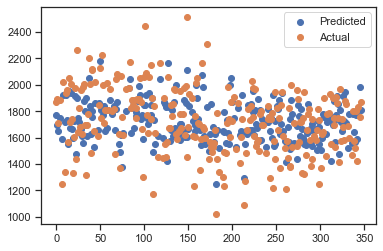

In [320]:
plt.scatter( X_train.index, model_22_32.predict(X_train), label='Predicted')
plt.scatter( y_train.index, y_train, label='Actual')
plt.legend()

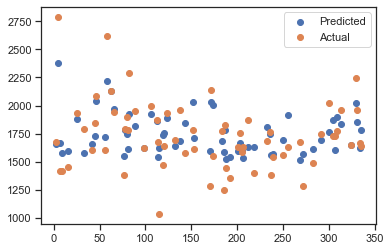

In [321]:
plt.scatter( X_test.index, model_22_32.predict(X_test), label='Predicted')
plt.scatter( y_test.index, y_test, label='Actual')
plt.legend()

In [322]:
#[246,101,34,190] is outliers in training set
#get data
df_22_train = df_22.merge(df_32['EFW_32'], left_index= True, right_index=True) #join based on left index and right index
df_22_train = pd.get_dummies(df_22_train, drop_first=True)
X = df_22_train.drop('EFW_32', axis=1)
y = df_22_train['EFW_32']

#best model to predict Wk32 using Wk22
wk_22_cols = ['GA(Day)_22', 'IUGR_22_1', 'Baby Gender_22_M', 'EFW_22', 'CM_22', 'Va_22', 'Nuchal fold_22']
X = X[wk_22_cols].drop(['IUGR_22_1', 'Baby Gender_22_M'], axis=1)
X = X.drop([246,101,34,190])
y = y.drop([246,101,34,190])
model_22_32 = Ridge(alpha=5.820097823045092, normalize=False, fit_intercept=True, solver='sparse_cg')

#test split and 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_22_32.fit(X_train, y_train)

Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001)

In [323]:
visualize(X_train, y_train)

GA(Day)_22  EFW_22  CM_22  Va_22  Nuchal fold_22    predicted  actual  \
115         151     386    4.0    6.4            4.66  1584.329370  1033.0   
174         153     509    6.7    5.2            5.48  2034.956169  1548.0   
171         156     499    5.2    5.2            5.09  1836.533072  2308.0   
73          150     382    5.2    7.7            2.86  1626.427305  2067.0   
30          159     460    5.5    6.1            3.87  1566.139301  1981.0   
..          ...     ...    ...    ...             ...          ...     ...   
139         157     439    8.4    6.6            5.18  1648.029236  1652.0   
242         159     505    5.6    5.0            5.79  1751.533092  1754.0   
36          154     462    5.1    6.8            5.11  1779.267288  1778.0   
93          156     503    6.2    6.2            5.55  1880.786961  1882.0   
291         151     416    6.4    5.0            3.50  1742.123445  1742.0   

           diff   square_error  
115  551.329370  303964.073982  
174  486.956169  237126.310992  
171  471.466928  222281.064572  
73   440.572695  194104.299224  
30   414.860699  172109.399361  
..          ...            ...  
139    3.970764      15.766967  
242    2.466908       6.085637  
36     1.267288       1.606019  
93     1.213039       1.471463  
291    0.123445       0.015239  

[262 rows x 9 columns]

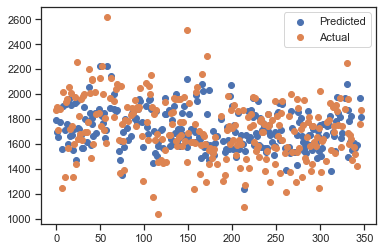

In [324]:
plt.scatter( X_train.index, model_22_32.predict(X_train), label='Predicted')
plt.scatter( y_train.index, y_train, label='Actual')
plt.legend()

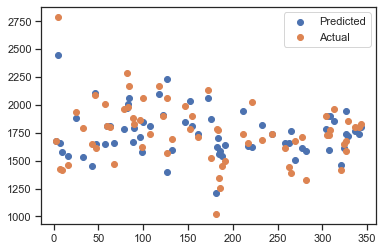

In [325]:
plt.scatter( X_test.index, model_22_32.predict(X_test), label='Predicted')
plt.scatter( y_test.index, y_test, label='Actual')
plt.legend()

In [ ]:
#this show that if GA is large, then EFW32 is small

In [246]:
#test outliers
#https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
# Q1 = X['EFW_32'].quantile(0.25)
# Q3 = X['EFW_32'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range. 

# filter = (X['EFW_32'] >= Q1 - 1.5 * IQR) & (X['EFW_32'] <= Q3 + 1.5 *IQR)
# X_temp = X.loc[filter]
#This method results in better RMSE, ~185, but lower r2, ~0.33

In [332]:
#ori
df_22_train = df_22.merge(df_32['EFW_32'], left_index= True, right_index=True) #join based on left index and right index
df_22_train = pd.get_dummies(df_22_train, drop_first=True)
wk_22_cols_cross = ['GA(Day)_22', 'IUGR_22_1', 'Baby Gender_22_M', 'EFW_22', 'CM_22', 'Va_22', 'Nuchal fold_22', 'EFW_32']
df_22_train = df_22_train[wk_22_cols_cross]

model_22_32 = [Ridge(alpha=5.820097823045092, normalize=False, fit_intercept=True, solver='sparse_cg')]

In [333]:
cross_validate_models(model_22_32, df_22_train[my_cols].drop(['IUGR_22_1', 'Baby Gender_22_M'], axis=1), label_name)

Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  Ridge(alpha=5.820097823045092, copy_X=True, fi...      0.398983   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.134947       0.445262      0.030787         -193.507701   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          22.016059       0.113774          -189.652307            5.510318   

   test_explained_variance_mean  test_explained_variance_std      y_mean  
0                      0.408856                      0.13236  1724.60241

The best model is 
 Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001) 
 with rmse score: -193.50770117031027
The error:11.200000000000001%
11.200000000000001


(Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='sparse_cg', tol=0.001),
 -193.50770117031027)

In [334]:
#to prove removing those 4 rows with high out square error helpful:
df_22_train = df_22.merge(df_32['EFW_32'], left_index= True, right_index=True) #join based on left index and right index
df_22_train = pd.get_dummies(df_22_train, drop_first=True)
df_22_train = df_22_train.drop([246,101,34,190])
wk_22_cols_cross = ['GA(Day)_22', 'IUGR_22_1', 'Baby Gender_22_M', 'EFW_22', 'CM_22', 'Va_22', 'Nuchal fold_22', 'EFW_32']
df_22_train = df_22_train[wk_22_cols_cross]

model_22_32 = [Ridge(alpha=5.820097823045092, normalize=False, fit_intercept=True, solver='sparse_cg')]

In [336]:
cross_validate_models(model_22_32, df_22_train[my_cols].drop(['IUGR_22_1', 'Baby Gender_22_M'], axis=1), 'EFW_32')

Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  Ridge(alpha=5.820097823045092, copy_X=True, fi...      0.444375   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.105649       0.489122      0.024623          -181.93999   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          16.424283       0.090273          -177.982149            4.123835   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.456465                     0.103526  1726.679878

The best model is 
 Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001) 
 with rmse score: -181.9399895036154
The error:10.5%
10.5


(Ridge(alpha=5.820097823045092, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='sparse_cg', tol=0.001),
 -181.9399895036154)

# Wk22 + Wk32 --> Wk35

In [53]:
#get data
df_22_32_train = df_22_32.merge(df_35['EFW_35'], left_index= True, right_index=True) #join based on left index and right index
df_22_32_train = pd.get_dummies(df_22_32_train, drop_first=True)

wk22_wk32_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'CM_22', 'Ut PI_22', 'Age_22', 'EFW_35']

X = df_22_32_train[wk22_wk32_cols].drop('EFW_35', axis=1)
y = df_22_32_train['EFW_35']

#best model to predict Wk35 using Wk22 + WK32
model_22_32_35 = [LinearRegression(normalize=False, fit_intercept=True), 
                  make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, epsilon=10, gamma='scale')), 
                  Ridge(alpha=0.053121562366700195,fit_intercept=True, normalize=False, solver='cholesky'),
                  Lasso(alpha=0.27980636354454624, fit_intercept=True, normalize=False, selection='random'),
                 ]

#test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_22_32_35[1].fit(X_train, y_train) #best using SVR

#ori result
cross_validate_models(model_22_32_35, df_22_32_train[wk22_wk32_cols], 'EFW_35')

Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.648394   
1  (StandardScaler(copy=True, with_mean=True, wit...      0.667085   
2  Ridge(alpha=0.053121562366700195, copy_X=True,...      0.649382   
3  Lasso(alpha=0.27980636354454624, copy_X=True, ...      0.648545   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.141143       0.682001      0.041015         -232.515781   
1     0.136849       0.678073      0.041439         -226.018214   
2     0.149171       0.680026      0.041352         -231.610619   
3     0.145203       0.681564      0.041002         -232.212555   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          68.780384       0.295810          -229.504709           20.382644   
1          67.987424       0.300805          -230.913594           20.417217   
2          70.919016       0.306199          -230.212429           20.444088   
3          69.892011       0.300983          -229.663101           20.364360   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.656200                     0.140985  2200.417431  
1                      0.673344                     0.137269  2200.417431  
2                      0.657218                     0.148817  2200.417431  
3                      0.656380                     0.144962  2200.417431

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -226.0182136963184
The error:10.299999999999999%
10.299999999999999


(Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svr',
                  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                      gamma='scale', kernel='linear', max_iter=-1,
                      shrinking=True, tol=0.001, verbose=False))],
          verbose=False),
 -226.0182136963184)

In [54]:
df_35['EFW_35'].describe()

count     223.000000
mean     2192.439462
std       408.090107
min       296.000000
25%      1964.000000
50%      2131.000000
75%      2333.000000
max      3818.000000
Name: EFW_35, dtype: float64

In [56]:
visualize_model_performance(X_train, y_train, model_22_32_35[1])

EFW_32  HC_GA_32     AFI_32  CM_22  Ut PI_22  Age_22    predicted  \
132  1695.0  1.225551  16.000000    3.4      1.12      28  2182.102026   
44   2018.0  1.305333  15.300000    4.2      0.56      25  2690.755409   
154  1898.0  1.379018  13.600000    6.7      0.97      28  2650.706292   
12   1964.0  1.277876  12.900000    7.3      0.73      29  2467.541944   
18   1744.0  1.304444  18.700000    5.1      0.35      37  2484.708629   
..      ...       ...        ...    ...       ...     ...          ...   
163  1356.0  1.245794   7.000000    5.4      0.54      26  1751.331568   
114  1678.0  1.279111  13.300000    4.5      0.63      22  2248.322504   
20   1601.0  1.258667  11.100000    4.8      0.77      35  2098.791291   
108  1740.0  1.300439  12.632277    8.3      1.05      36  2268.938315   
223  1979.0  1.268619  11.900000    5.6      0.99      28  2463.797478   

     actual         diff  square_error  
132   296.0  1886.102026  3.557381e+06  
44   3615.0   924.244591  8.542281e+05  
154  3421.0   770.293708  5.933524e+05  
12   1888.0   579.541944  3.358689e+05  
18   3012.0   527.291371  2.780362e+05  
..      ...          ...           ...  
163  1757.0     5.668432  3.213112e+01  
114  2252.0     3.677496  1.352398e+01  
20   2096.0     2.791291  7.791307e+00  
108  2268.0     0.938315  8.804358e-01  
223  2464.0     0.202522  4.101518e-02  

[174 rows x 10 columns]

In [57]:
visualize_model_performance(X_test, y_test, model_22_32_35[1])

EFW_32  HC_GA_32     AFI_32  CM_22  Ut PI_22  Age_22    predicted  \
141  1778.0  1.309692  14.300000    5.8      0.92      35  2412.207126   
58   2621.0  1.352632  23.200000    5.0      1.08      30  3475.182394   
323  1574.0  1.316290  12.819155    3.4      0.88      31  2251.347461   
137  1586.0  1.257965  11.400000    4.0      0.76      27  2090.463485   
246  1220.0  1.306280  16.700000    5.7      1.21      28  1864.072617   
146  1621.0  1.315179  10.900000    5.1      0.74      26  2229.947947   
306  1462.0  1.279736  14.100000    8.4      0.70      26  1969.850893   
112  1632.0  1.293750  12.820500    4.6      0.81      32  2235.263509   
281  1949.0  1.243220  16.900000    4.5      0.24      38  2534.359913   
33   1789.0  1.313596  13.100000    4.6      0.61      29  2447.871568   
256  1634.0  1.217904  12.196306    5.0      1.02      33  2027.810463   
186  1251.0  1.288406  10.700000    5.3      1.96      32  1732.396261   
22   1440.0  1.273661   9.900000    5.3      1.24      31  1912.545208   
287  1819.0  1.307296  15.300000    7.6      0.40      35  2454.991587   
284  1466.0  1.273451  14.200000    6.0      0.94      31  2005.276170   
332  1690.0  1.271556  12.700000    4.7      1.01      40  2237.363574   
228  1565.0  1.222124  13.300000    4.2      1.06      35  2004.552837   
252  1660.0  1.303509  11.000000    6.7      1.10      27  2188.302820   
98   1299.0  1.274194  11.900000    5.5      0.50      34  1850.607553   
267  1998.0  1.313274  11.800000    4.8      1.38      29  2582.609696   
313  1964.0  1.342478  12.600000    6.4      1.05      32  2622.004690   
169  1598.0  1.301327  12.200000    5.3      0.81      34  2199.290744   
32   1695.0  1.366972  16.900000    3.9      1.02      40  2548.904272   
35   1699.0  1.327232  13.800000    6.2      0.70      30  2364.928199   
339  1519.0  1.242411   9.400000    5.1      0.81      32  1940.017439   
164  1587.0  1.269333  10.400000    3.1      0.54      32  2144.459311   
285  1655.0  1.269912  16.500000    4.6      1.21      33  2233.930576   
129  1670.0  1.274336  11.300000    7.3      0.92      38  2150.361220   
311  1929.0  1.355556  12.857461   10.0      0.98      34  2554.265911   
192  1353.0  1.219469  12.527998    5.1      0.97      26  1749.015425   
230  1496.0  1.201322  12.400000    6.3      0.93      35  1837.116035   
342  1425.0  1.262673  11.800000    5.2      0.71      29  1930.549257   
128  1674.0  1.266667  12.700000    7.5      0.96      32  2139.944675   
225  1614.0  1.265487  13.100000    5.2      0.93      26  2124.100621   
200  1725.0  1.244783  17.300000    6.5      0.76      29  2234.782821   
175  1564.0  1.280804  15.800000    4.2      0.52      31  2206.344798   
277  1715.0  1.281333   9.200000    5.7      1.52      41  2182.780084   
299  1245.0  1.274419  11.400000    3.8      0.34      39  1844.770995   
188  1449.0  1.253363   9.000000    6.4      0.84      28  1855.103197   
201  1630.0  1.284889  10.500000    4.7      1.71      29  2116.040507   
45   1842.0  1.294397  12.900865    3.2      0.86      29  2465.790537   
237  1385.0  1.261468  15.900000    5.9      0.62      35  1950.851900   
258  1609.0  1.299554  12.200000    4.2      0.97      33  2217.765216   
337  1803.0  1.295575  11.500000    3.7      0.86      38  2414.348504   

     actual        diff   square_error  
141  3008.0  595.792874  354969.149140  
58   3818.0  342.817606  117523.910815  
323  1918.0  333.347461  111120.529857  
137  1797.0  293.463485   86120.816937  
246  2139.0  274.927383   75585.065968  
146  2002.0  227.947947   51960.266389  
306  2189.0  219.149107   48026.331136  
112  2031.0  204.263509   41723.581033  
281  2335.0  199.359913   39744.374910  
33   2254.0  193.871568   37586.184809  
256  2212.0  184.189537   33925.785464  
186  1550.0  182.396261   33268.396104  
22   2088.0  175.454792   30784.383912  
287  2280.0  174.991587   30622.055541  
284  1847.0  158.276170   25051.346123  
332  2363.0  125.6

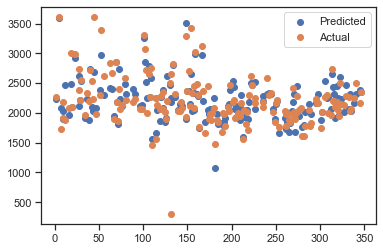

In [59]:
plt.scatter( X_train.index, model_22_32_35[1].predict(X_train), label='Predicted')
plt.scatter( y_train.index, y_train, label='Actual')
plt.legend()

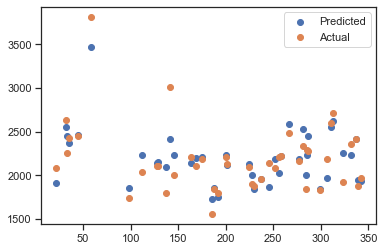

In [60]:
plt.scatter( X_test.index, model_22_32_35[1].predict(X_test), label='Predicted')
plt.scatter( y_test.index, y_test, label='Actual')
plt.legend()

In [70]:
#drop outliers [132,44,154]
#get data
df_22_32_train = df_22_32.merge(df_35['EFW_35'], left_index= True, right_index=True) #join based on left index and right index
df_22_32_train = pd.get_dummies(df_22_32_train, drop_first=True)
df_22_32_train.drop([132,44,154], axis=0, inplace=True)

wk22_wk32_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'CM_22', 'Ut PI_22', 'Age_22', 'EFW_35']

X = df_22_32_train[wk22_wk32_cols].drop('EFW_35', axis=1)
y = df_22_32_train['EFW_35']

#best model to predict Wk35 using Wk22 + WK32
model_22_32_35 = [LinearRegression(normalize=False, fit_intercept=True), 
                  make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, epsilon=10, gamma='scale')), 
                  Ridge(alpha=0.053121562366700195,fit_intercept=True, normalize=False, solver='cholesky'),
                  Lasso(alpha=0.27980636354454624, fit_intercept=True, normalize=False, selection='random'),
                 ]

#test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_22_32_35[1].fit(X_train, y_train) #best using SVR
#ridge second best
model_22_32_35[2].fit(X_train, y_train) #best using SVR

#result after removing outliers
cross_validate_models(model_22_32_35, df_22_32_train[wk22_wk32_cols], 'EFW_35')

Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.733233   
1  (StandardScaler(copy=True, with_mean=True, wit...      0.735888   
2  Ridge(alpha=0.053121562366700195, copy_X=True,...      0.732605   
3  Lasso(alpha=0.27980636354454624, copy_X=True, ...      0.732569   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.093173       0.774393      0.018030         -181.033903   
1     0.093029       0.770629      0.018257         -179.933316   
2     0.095690       0.773076      0.018158         -181.121720   
3     0.094800       0.773851      0.018047         -181.187727   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          20.394121       0.112654          -174.514172            4.978536   
1          19.114151       0.106229          -175.963446            4.928944   
2          21.640317       0.119479          -175.022977            5.010707   
3          21.271268       0.117399          -174.724076            4.968611   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.739491                     0.092611  2197.018605  
1                      0.741635                     0.092586  2197.018605  
2                      0.739205                     0.095253  2197.018605  
3                      0.739040                     0.094317  2197.018605

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -179.9333163883205
The error:8.200000000000001%
8.200000000000001


(Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svr',
                  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=10,
                      gamma='scale', kernel='linear', max_iter=-1,
                      shrinking=True, tol=0.001, verbose=False))],
          verbose=False),
 -179.9333163883205)

In [71]:
visualize_model_performance(X_train, y_train, model_22_32_35[1])

EFW_32  HC_GA_32     AFI_32  CM_22  Ut PI_22  Age_22    predicted  \
12   1964.0  1.277876  12.900000    7.3      0.73      29  2483.726516   
18   1744.0  1.304444  18.700000    5.1      0.35      37  2496.474665   
42   1602.0  1.286239  11.500000    6.4      1.48      34  2088.985601   
127  2058.0  1.318534  11.000000    7.3      0.79      27  2628.508935   
157  1603.0  1.255947   8.500000    4.9      0.85      31  2031.887904   
..      ...       ...        ...    ...       ...     ...          ...   
29   1631.0  1.281250  12.700000    4.6      0.66      38  2217.092661   
108  1740.0  1.300439  12.632277    8.3      1.05      36  2270.158883   
20   1601.0  1.258667  11.100000    4.8      0.77      35  2094.241712   
346  1868.0  1.291228   7.600000    6.0      0.73      32  2350.133514   
30   1981.0  1.285153  12.400000    5.5      0.59      31  2554.951467   

     actual        diff   square_error  
12   1888.0  595.726516  354890.081959  
18   3012.0  515.525335  265766.370603  
42   2537.0  448.014399  200716.902060  
127  2199.0  429.508935  184477.925602  
157  2457.0  425.112096  180720.293838  
..      ...         ...            ...  
29   2213.0    4.092661      16.749875  
108  2268.0    2.158883       4.660775  
20   2096.0    1.758288       3.091575  
346  2349.0    1.133514       1.284853  
30   2554.0    0.951467       0.905289  

[172 rows x 10 columns]

In [72]:
visualize_model_performance(X_test, y_test, model_22_32_35[1])

EFW_32  HC_GA_32     AFI_32  CM_22  Ut PI_22  Age_22    predicted  \
141  1778.0  1.309692  14.300000    5.8      0.92      35  2415.298004   
63   1805.0  1.295633  14.100000    6.3      0.48      39  2428.944660   
202  1911.0  1.321053  11.100000    5.0      0.87      27  2526.999120   
323  1574.0  1.316290  12.819155    3.4      0.88      31  2239.240999   
305  1733.0  1.386222  14.100000    6.3      0.85      32  2521.968017   
149  2516.0  1.434667  18.600000    5.3      0.79      34  3536.397227   
203  1753.0  1.324779  14.900000    6.3      0.73      34  2432.455708   
306  1462.0  1.279736  14.100000    8.4      0.70      26  1970.205007   
190  1231.0  1.312000  12.680451    6.6      1.56      32  1774.733568   
33   1789.0  1.313596  13.100000    4.6      0.61      29  2446.896068   
22   1440.0  1.273661   9.900000    5.3      1.24      31  1898.501385   
287  1819.0  1.307296  15.300000    7.6      0.40      35  2462.874000   
282  1324.0  1.253917  12.300000    6.6      0.84      38  1785.475140   
301  1372.0  1.246083  16.100000    5.5      0.69      22  1893.857645   
193  1482.0  1.239819  13.043438    4.9      1.56      32  1915.464051   
211  1738.0  1.296996  12.669062    6.3      1.02      31  2296.310646   
332  1690.0  1.271556  12.700000    4.7      1.01      40  2237.550647   
260  1525.0  1.220614  11.600000    5.8      0.78      28  1912.026143   
236  1763.0  1.288158  12.300000    6.9      0.82      30  2293.842193   
47   1610.0  1.267841  10.600000    5.7      0.90      26  2076.611092   
32   1695.0  1.366972  16.900000    3.9      1.02      40  2541.012790   
313  1964.0  1.342478  12.600000    6.4      1.05      32  2623.374818   
254  1367.0  1.222422  10.900000    5.2      2.41      33  1669.106432   
235  1694.0  1.303556   9.600000    7.4      0.91      28  2190.558779   
227  1540.0  1.246696  16.500000    5.2      0.89      29  2078.997251   
288  1580.0  1.295536  11.900000    5.8      0.74      33  2146.063745   
174  1548.0  1.260177  10.800000    6.7      1.03      29  1976.683694   
176  1526.0  1.296916  12.400000    7.3      1.04      36  2059.774232   
35   1699.0  1.327232  13.800000    6.2      0.70      30  2360.976798   
99   1624.0  1.265198  11.700000    4.8      0.91      33  2132.116837   
196  1744.0  1.214530  15.400000    5.8      1.40      24  2150.693505   
217  1660.0  1.253070   9.900000    6.3      1.08      24  2058.215030   
185  1343.0  1.269058  12.900000    7.6      1.28      41  1807.950023   
247  1578.0  1.274123  14.600000    5.1      2.28      30  2069.116815   
342  1425.0  1.262673  11.800000    5.2      0.71      29  1922.122678   
311  1929.0  1.355556  12.857461   10.0      0.98      34  2554.769521   
129  1670.0  1.274336  11.300000    7.3      0.92      38  2148.014613   
130  1845.0  1.312281  11.200000    3.9      0.96      31  2464.710009   
143  1581.0  1.311556  10.700000    5.5      1.04      33  2149.749495   
278  1718.0  1.247619   8.200000    5.1      1.98      31  2058.780655   
266  1374.0  1.257466  13.500000    6.8      1.63      46  1828.589293   
242  1754.0  1.317105   8.600000    5.6      0.84      33  2310.803962   
114  1678.0  1.279111  13.300000    4.5      0.63      22  2252.826363   

     actual        diff   square_error  
141  3008.0  592.701996  351295.656260  
63   2839.0  410.055340  168145.382226  
202  2186.0  340.999120  116280.399849  
323  1918.0  321.240999  103195.779607  
305  2262.0  259.968017   67583.369714  
149  3296.0  240.397227   57790.826887  
203  2211.0  221.455708   49042.630546  
306  2189.0  218.794993   47871.249155  
190  1992.0  217.266432   47204.702511  
33   2254.0  192.896068   37208.893059  
22   2088.0  189.498615   35909.725128  
287  2280.0  182.874000   33442.899781  
282  1613.0  172.475140   29747.673802  
301  1745.0  148.857645   22158.598416  
193  1777.0  138.464051   19172.293411  
211  2160.0  136.310646   18580.592260  
332  2363.0  125.449353   15737.540190  
260  2037.

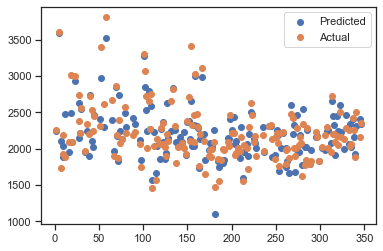

In [390]:
plt.scatter( X_train.index, model_22_32_35[1].predict(X_train), label='Predicted')
plt.scatter( y_train.index, y_train, label='Actual')
plt.legend()

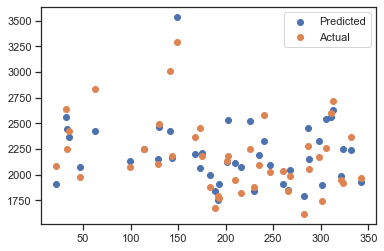

In [391]:
plt.scatter( X_test.index, model_22_32_35[1].predict(X_test), label='Predicted')
plt.scatter( y_test.index, y_test, label='Actual')
plt.legend()

In [408]:
#coef in ridge (approximate to SVR)
my_df = pd.DataFrame(model_22_32_35[2].coef_, X.columns, columns=['coef'])
my_df['mean'] = X_train.mean()
my_df

coef         mean
EFW_32       1.037510  1661.366279
HC_GA_32  1740.193359     1.283977
AFI_32      19.923814    12.073608
CM_22      -17.722954     5.490116
Ut PI_22   -18.513140     1.001453
Age_22       2.031047    31.470930

# Further post-hoc after removing outliers (features changed) - Stage 2

- After removing the outliers, the feature selections method generated different results

## Wk22 -> Wk32

In [40]:
df_22_train = df_22.drop([246,101,34,190])#outliers
df_22_train = df_22_train.merge(df_32['EFW_32'], left_index= True, right_index=True) #join based on left index and right index

#1-hot encoding
df_22_train = pd.get_dummies(df_22_train, drop_first=True)
df_22_train = df_22_train.drop('IUGR_22_1', axis=1)

wk22_cols = ['EFW_22', 'GA(Day)_22', 'Baby Gender_22_M', 'CM_22', 'Ut PI_22', 'Va_22', 'Nuchal fold_22', 'Hem_22', 'BPD_22', 'EFW_32'] #IUGR not possible

X = df_22_train[wk22_cols].drop('EFW_32', axis=1)
y = df_22_train['EFW_32']


models_22 = [LinearRegression(normalize=True, fit_intercept=True), 
          Ridge(alpha=12.340769010376022, normalize=False, fit_intercept=True, solver='auto'),
          Lasso(alpha=1.0405895699434454e-05, normalize=False, fit_intercept=True, selection='cyclic'),
          make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')),
         ]

print('Prediction of WK32 using WK22 my elimination after tuning.')
# cross_validate_models(models, X[my_cols], label_name)
cross_validate_models(models_22, df_22_train[wk22_cols], 'EFW_32')

#conclude:
#with IUGR and baby gender:  best rmse
#with baby gender: better
#nothing: worse

Prediction of WK32 using WK22 my elimination after tuning.
Cross validation Result for EFW_32:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.472853   
1  Ridge(alpha=12.340769010376022, copy_X=True, f...      0.474197   
2  Lasso(alpha=1.0405895699434454e-05, copy_X=Tru...      0.472853   
3  (StandardScaler(copy=True, with_mean=True, wit...      0.480197   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.097627       0.529201      0.022460         -177.370887   
1     0.097946       0.528072      0.022499         -177.135768   
2     0.097627       0.529201      0.022460         -177.370887   
3     0.095346       0.526101      0.022671         -176.130056   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          17.020830       0.095962          -170.867243            4.262828   
1          16.999321       0.095968          -171.071945            4.259545   
2          17.020829       0.095962          -170.867243            4.262828   
3          16.727602       0.094973          -171.428575            4.285289   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.486333                     0.095395  1726.679878  
1                      0.487447                     0.095685  1726.679878  
2                      0.486333                     0.095395  1726.679878  
3                      0.492354                     0.094185  1726.679878

The best model is 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False) 
 with rmse score: -176.13005629435443
The error:10.2%
10.2


(Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svr',
                  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=100,
                      gamma='scale', kernel='linear', max_iter=-1,
                      shrinking=True, tol=0.001, verbose=False))],
          verbose=False),
 -176.13005629435443)

In [41]:
#test split and 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
models_22[1].fit(X_train, y_train) #train ridge as SVM do not have coef params.

Ridge(alpha=12.340769010376022, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [45]:
X_train.describe()

EFW_22  GA(Day)_22  Baby Gender_22_M       CM_22    Ut PI_22  \
count  262.000000  262.000000        262.000000  262.000000  262.000000   
mean   435.603053  153.179389          0.465649    5.645802    0.971011   
std     66.769826    4.655392          0.499773    1.237706    0.432739   
min    284.000000  141.000000          0.000000    1.900000    0.240000   
25%    392.250000  150.250000          0.000000    4.800000    0.732500   
50%    429.500000  152.000000          0.000000    5.500000    0.880000   
75%    467.750000  156.000000          1.000000    6.400000    1.050000   
max    779.000000  181.000000          1.000000   10.000000    3.160000   

            Va_22  Nuchal fold_22      Hem_22      BPD_22  
count  262.000000      262.000000  262.000000  262.000000  
mean     6.505382        4.483855   25.405191   52.638550  
std      0.835867        0.779891    2.071894    3.475288  
min      4.100000        2.300000   20.700000   32.000000  
25%      5.900000        3.952500   24.100000   50.800000  
50%      6.500000        4.505000   25.400000   52.300000  
75%      7.100000        5.027500   26.575000   54.500000  
max      8.800000        6.660000   32.500000   64.800000

In [55]:
y_train

193    1482.0
17     2008.0
24     1639.0
140    1957.0
121    1446.0
        ...  
198    1873.0
77     1386.0
113    1872.0
286    1777.0
109    1898.0
Name: EFW_32, Length: 262, dtype: float64

In [46]:
X_train

EFW_22  GA(Day)_22  Baby Gender_22_M  CM_22  Ut PI_22  Va_22  \
193     386         152                 1    4.9      1.56    6.1   
17      486         153                 1    4.8      0.88    6.7   
24      420         151                 0    4.4      0.89    5.1   
140     419         152                 0    4.5      0.97    6.6   
121     363         150                 0    5.0      0.74    5.8   
..      ...         ...               ...    ...       ...    ...   
198     463         148                 1    6.9      1.27    6.4   
77      529         165                 0    5.3      2.67    5.9   
113     445         151                 1    6.4      1.07    6.7   
286     508         156                 0    5.1      1.04    7.1   
109     464         151                 0    4.0      0.67    5.9   

     Nuchal fold_22  Hem_22  BPD_22  
193            3.53    23.2    49.5  
17             5.99    26.3    54.8  
24             5.30    23.1    49.0  
140            4.56    23.5    50.0  
121            5.20    24.0    50.5  
..              ...     ...     ...  
198            5.67    25.6    53.8  
77             3.20    30.6    60.6  
113            5.05    27.4    54.3  
286            4.18    24.5    49.9  
109            5.36    26.9    54.7  

[262 rows x 9 columns]

In [62]:
X_train.iloc[0] @  models_22[1].coef_ + models_22[1].intercept_ #predict formula

1475.325251364071

In [54]:
models_22[1].predict(X_train.iloc[0:1])

array([1475.32525136])

In [48]:
models_22[1].coef_

array([  3.84437225, -40.73452298, -68.20054835,  25.12895133,
       -50.13980392,  12.94470423,  20.55123018, -10.35799101,
         4.98152765])

In [61]:
models_22[1].intercept_

6048.543070462445

In [109]:
#coef in ridge (approximate to SVR)
my_df = pd.DataFrame(models_22[1].coef_, X_train.columns, columns=['coef'])
my_df['mean'] = X_train.mean()
display(my_df)
print('intercept:', models_22[1].intercept_)
print(f"Formula: \n\
{X_train.columns[0]}*{my_df['coef'][0]:.3f} + \
{X_train.columns[1]}*{my_df['coef'][1]:.3f} + \
{X_train.columns[2]}*{my_df['coef'][2]:.3f} + \
{X_train.columns[3]}*{my_df['coef'][3]:.3f} + \
{X_train.columns[4]}*{my_df['coef'][4]:.3f} + \
{X_train.columns[5]}*{my_df['coef'][5]:.3f} + \
{X_train.columns[6]}*{my_df['coef'][6]:.3f} + \
{X_train.columns[7]}*{my_df['coef'][7]:.3f} + \
{X_train.columns[8]}*{my_df['coef'][8]:.3f} + \
{models_22[1].intercept_:.3f}")

coef        mean
EFW_22             3.844372  435.603053
GA(Day)_22       -40.734523  153.179389
Baby Gender_22_M -68.200548    0.465649
CM_22             25.128951    5.645802
Ut PI_22         -50.139804    0.971011
Va_22             12.944704    6.505382
Nuchal fold_22    20.551230    4.483855
Hem_22           -10.357991   25.405191
BPD_22             4.981528   52.638550

intercept: 6048.543070462445
Formula: 
EFW_22*3.844 + GA(Day)_22*-40.735 + Baby Gender_22_M*-68.201 + CM_22*25.129 + Ut PI_22*-50.140 + Va_22*12.945 + Nuchal fold_22*20.551 + Hem_22*-10.358 + BPD_22*4.982 + 6048.543


In [71]:
my_df['coef'][0]

3.844372250682724

## Wk22 + Wk32 -> Wk35

In [110]:
#drop the outliers [132,44,154]
df_22_32_train = df_22_32.drop([132,44,154])
df_22_32_train = df_22_32_train.merge(df_35['EFW_35'], left_index= True, right_index=True) #join based on left index and right index

#1-hot encoding
df_22_32_train = pd.get_dummies(df_22_32_train, drop_first=True)

wk22_wk32_cols = ['EFW_32', 'HC_GA_32', 'AFI_32', 'FL/HC_32', 'FEMUR_32', 'CM_22', 'Nuchal fold_22', 'Va_22', 'Hem_22', 'Age_22', 'EFW_35']

X = df_22_32_train[wk22_wk32_cols].drop('EFW_35', axis=1)
y = df_22_32_train['EFW_35']

model_22_32 = [LinearRegression(normalize=False, fit_intercept=True), 
               make_pipeline(StandardScaler(), SVR(kernel='linear', C=1000, epsilon=100, gamma='scale')), 
               Ridge(alpha=0.000706258210160292,fit_intercept=True, normalize=False, solver='svd'),
               Lasso(alpha=0.00047745705399706933, fit_intercept=True, normalize=True, selection='cyclic'),
              ]

print('After Tuning:')
cross_validate_models(model_22_32, df_22_32_train[wk22_wk32_cols], 'EFW_35')

After Tuning:
Cross validation Result for EFW_35:


Models  test_r2_mean  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...      0.739008   
1  (StandardScaler(copy=True, with_mean=True, wit...      0.738555   
2  Ridge(alpha=0.000706258210160292, copy_X=True,...      0.739432   
3  Lasso(alpha=0.00047745705399706933, copy_X=Tru...      0.739012   

   test_r2_std  train_r2_mean  train_r2_std  test_neg_rmse_mean  \
0     0.096910       0.789430      0.018170         -178.580304   
1     0.096172       0.784176      0.019086         -178.964248   
2     0.095779       0.789191      0.018163         -178.502385   
3     0.096909       0.789430      0.018170         -178.579187   

   test_neg_rmse_std  coef_var_rmse  train_neg_rmse_mean  train_neg_rmse_std  \
0          21.517129       0.120490          -168.564853            5.225793   
1          22.437911       0.125377          -170.647500            5.558305   
2          21.324106       0.119461          -168.661388            5.215844   
3          21.516535       0.120487          -168.564855            5.225793   

   test_explained_variance_mean  test_explained_variance_std       y_mean  
0                      0.745211                     0.097068  2197.018605  
1                      0.744959                     0.096888  2197.018605  
2                      0.745716                     0.095836  2197.018605  
3                      0.745214                     0.097067  2197.018605

The best model is 
 Ridge(alpha=0.000706258210160292, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='svd',
      tol=0.001) 
 with rmse score: -178.50238495982714
The error:8.1%
8.1


(Ridge(alpha=0.000706258210160292, copy_X=True, fit_intercept=True,
       max_iter=None, normalize=False, random_state=None, solver='svd',
       tol=0.001),
 -178.50238495982714)

In [111]:
#test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_22_32[2].fit(X_train, y_train) #best using Ridge

Ridge(alpha=0.000706258210160292, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='svd',
      tol=0.001)

In [114]:
#coef in ridge (approximate to SVR)
my_df = pd.DataFrame(model_22_32[2].coef_, X.columns, columns=['coef'])
my_df['mean'] = X_train.mean()
display(my_df)
print('intercept:',model_22_32[2].intercept_)
print(f"Formula: \n\
{X_train.columns[0]}*{my_df['coef'][0]:.3f} + \
{X_train.columns[1]}*{my_df['coef'][1]:.3f} + \
{X_train.columns[2]}*{my_df['coef'][2]:.3f} + \
{X_train.columns[3]}*{my_df['coef'][3]:.3f} + \
{X_train.columns[4]}*{my_df['coef'][4]:.3f} + \
{X_train.columns[5]}*{my_df['coef'][5]:.3f} + \
{X_train.columns[6]}*{my_df['coef'][6]:.3f} + \
{X_train.columns[7]}*{my_df['coef'][7]:.3f} + \
{X_train.columns[8]}*{my_df['coef'][8]:.3f} + \
{model_22_32[2].intercept_:.3f}")

coef         mean
EFW_32             1.023821  1657.354651
HC_GA_32        2345.285404     1.283648
AFI_32            20.200291    12.183727
FL/HC_32        6373.742359     0.206395
FEMUR_32         -12.136391    59.403488
CM_22            -15.389824     5.401163
Nuchal fold_22    49.576761     4.421512
Va_22             44.385685     6.509186
Hem_22            -9.774726    25.192442
Age_22             1.923715    31.482558

intercept: -3587.6956452400373
Formula: 
EFW_32*1.024 + HC_GA_32*2345.285 + AFI_32*20.200 + FL/HC_32*6373.742 + FEMUR_32*-12.136 + CM_22*-15.390 + Nuchal fold_22*49.577 + Va_22*44.386 + Hem_22*-9.775 + -3587.696


In [113]:
df_22[['Baby Gender_22', 'EFW_22']].groupby('Baby Gender_22').mean()

EFW_22
Baby Gender_22            
F               424.913978
M               448.956522

In [53]:
test_df = pd.DataFrame()
test_df['Baby Gender_22'] = df_22['Baby Gender_22']
test_df['EFW_32'] = df_32['EFW_32']

test_df.groupby('Baby Gender_22').sum()

EFW_32
Baby Gender_22        
F                  176
M                  156

## Some thoughts to be implemented in future

1. Research for extra datasets in different country (currently only in Singapore)
2. Feature engineer some interesting features.

# Ends

In [ ]:
raise Exception 

# Testing Area

In [ ]:
#normal way
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 42) 
  
#fit the regressor with x and y data 
regressor.fit(X_train, y_train)

#predict
y_pred = regressor.predict(X_test)

#evaluate model 
print('Score:', regressor.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
linearReg = LinearRegression()
cv_linearReg = cross_validate(linearReg, X, y, cv=9)
print(cv['test_score'])
print(cv['test_score'].mean())

In [ ]:
linearReg_pred

In [ ]:
regressor.train(X, y)

In [ ]:
#K folds
score = []

kf = KFold(n_splits=10, random_state=None, shuffle=True)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    #create regressor object 
    regressor = RandomForestRegressor(n_estimators = 100, random_state = None) 

    #fit the regressor with x and y data 
    regressor.fit(X_train, y_train)
    
    #predict
    y_pred = regressor.predict(X_test)
    score.append(regressor.score(X_test, y_test))
    #evaluate model 
#     print('Score:', regressor.score(X_test, y_test))
#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
'''
Yi Chong

1.	Pre-processing Data (Week 2 – Week 4)
    a.	Trying to find the correlation between data and filter out the useful features.
    b.	Standardize the data.
        i.	Scaling or Normalize (if needed by model)
    c.	Filling the missing data with machine learning model too (Random Forest).
    
2.	Train+evaluating various models (Week 5 – Week 12)
    a.	Week 22 features as input – to predict FW/percentile in week 22, 32, 35
    b.	Week 22 and week 32 features as input – to predict BW in week 35 (increase accuracy)
    c.	May consider to use deep learning.
    
3.	Report Writing (Week 13 – Week 14)

Findings:

Why need to estimate fetal weight? 
    - Let doctor to take action if the weight is abnormal in particular gestational age
    - detection of growth abnormalities may  help to prevent  fetal demise and manage perinatal complications 
      more appropriately , monitoring of fetal growth is an important part of antepartum care.

    Hadlock formulae – Uses Head circumference, abdominal circumference, femur length, biparietal diameter, humerus length to estimate Fetal Weight.
    Shepard: Log 10 (weight) = -1.7492+ 0.166*BPD +0.046*AC - 2.646*(AC*BPD)/1,000
    Hadlock 1: Log 10 (weight) = 1.304+0.05281*Ac+0.1938*FL -0.004*AC*FL
    Hadlock 2: Log 10 (weight) = 1.335-0.0034*AC*FL+ 0.0316*BPD+0.0457*AC +0.1623*FL
    Hadlock 3: Log 10 (weight) =1.326-0.00326 *AC*FL+0.0107*HC +0.0438*AC + 0.158*FL
    Hadlock 4: Log10 (weight) =1.3596 -0.00386* AC * FL+0.0064*HC+0.00061*BPD*AC+ 0.0424*AC+0.174*FL

    The Hadlock A formula remains the most reliable regression method, producing the smallest random errors.
    (unable to check exactly the amount of errors - the pdf of the citation need to pay.)
    
    (2018 Feb) ultrasound calculation of EFW consistently producing random errors below 10%, 
    
    - This machine learning method can make the random errors lesser (experimenting)
    - The Doctors will no need to consider so many formulae to predict the estimated fetal weight

'''

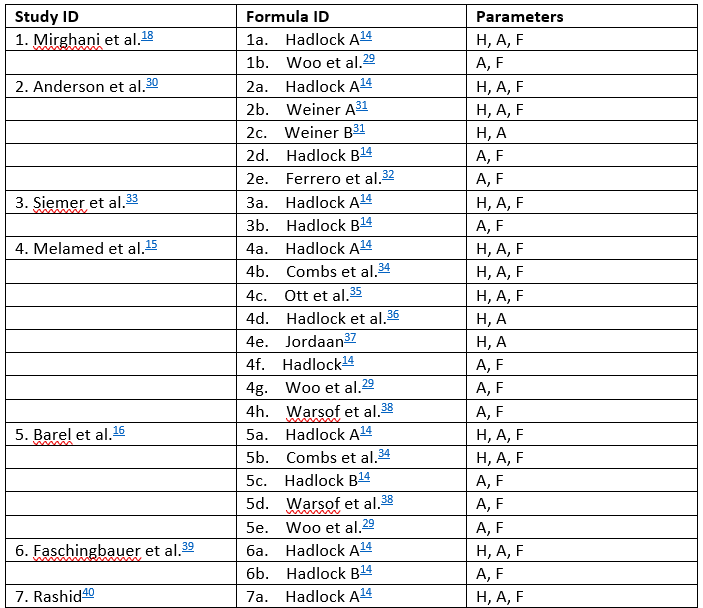

# Notes

In [ ]:
#tmr
'''
1. Fill in those missing value by training models - Done
2. Apply all pre-processing techniques (like standardize or normalize) on the machine learning algo and 
   get the highest accuracy as possible (by plotting a graph)
3. Test various tweaking in the algo.
4. Select K best

19/04/2021
5. Improve the model and learn what others people do to improve
6. Stepwise backward elimination

25/04/2021
7. Forward elimination
8. Feature importances using random forest

28/04/2021
9. Remove all unnecessary info!

17/05/2021

imputation techniques r2
which to imputate - only wk32
result - improve abit ~0.05 r2

standard deviation error
feature selection - correlation, manually filter.
outliers, medians
find reasons behind r2 and rmse, ways to improve them

21/05/2021
10. Test all combination of features

31/5/2021

-Ensemble Learning in Machine Learning
-Use the best model and manually investigate - create a model, then go deep into the data
-- plot graph - y = error / actual data
-- anymore possible graph
-SHAP value?

remove IUGR22 & baby gender
To know which rows error alot, then analysis which part make it.
Outliers: eat durians to improve the growth
Relationship of EFW and GA since GA is diff for each baby

11/06/2021

outliers - remove or not? 
coef_ - find out that how the coef is relatable, logical, find paper behind to support.
SHAP analysis - how to apply

12/07/2021
Plot the RMSE of each CV against each model? maybe using Leave one Out LOOCV techniques.

'''